# Fashion MNIST : tutorial and model comparison

![](https://cdn-images-1.medium.com/max/638/1*PtQ2I-3RIFiCypor4u_Nbg.jpeg)

 <a id="top"></a> <br>
 ## Notebook  Content
1. [Import ](#Import)
1.  [Fashion MNIST Dataset ](#Fashion)
    1. [Data Loading ](#11)
    1. [Define your test set](#12)
1.  [Statistics & Preprocessing ](#Stats)
     1. [Statistics ](#21)
     1. [Preprocessing ](#22)
     1. [Visualization of the data](#23)
         1. [Visalization of one example](#231)
         1. [PCA ](#232)
         1. [t-SNE ](#233)
1.  [Models ](#Models)
    1. [Crossvalidation strategy](#31)
    1. [A really simple model : PCA - RandomForest](#32)
    1. [Our first neural network : Multi Layer Perceptron (MLP)](#33)
    1. [CNN](#34)
    1. [Pretrained Model](#35)
1. [Error Analysis ](#Error)
    1. [Fast Analysis](#41)
    1. [GradCAM](#42)


In this notebook, we will do a tutorial to explain how to develop your own neural network. We will also deep dive into transfer learning, using pre-trained neural networks and compare our performance. 

We will do a home made leaderboard using a part of the dataset as "test set". As a result, we will developp a cross-validation to compare the models.

In this notebook, I took some inspirations from this link :
- https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 
- https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction

<a name="Import"></a> 

## 0. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

from sklearn.model_selection import train_test_split
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import np_utils
import keras.backend as K

import cv2
import scipy

from random import randint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

Using TensorFlow backend.


<a name="Fashion"></a>
## 1. Fashion MNIST Dataset

<a name="11"></a>
### 1.1. Data Loading

In [2]:
SEED = 42

In [3]:
data = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv', sep = ',')

In [4]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [5]:
X,y = data.drop(['label'], axis = 1), data['label']

<a name="12"></a> 
### 1.2 Define your test set

Now, we will create our own X_test, y_test to have our own local leaderboard among the different neural networks. We will not do anything on the X_test part in order to prevent our model from overfitting.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

<a name="Stats"></a>
## 2.Statistics & Preprocessing

<a name="21"></a> 
### 2.1 Statistics

5    4859
8    4851
1    4826
4    4815
2    4800
9    4790
7    4776
0    4768
3    4758
6    4757
Name: label, dtype: int64

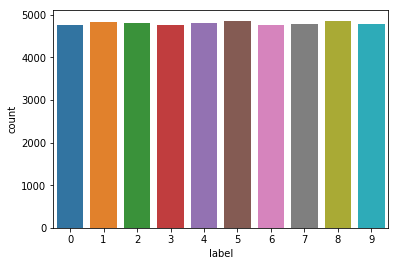

In [7]:
g = sns.countplot(y_train)

y_train.value_counts()

Our dataset is perfectly divided among the 10 classes.

In [8]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing value or corrupted images. It will be very easy to use every images to train our models!

<a name="22"></a>
### 2.2 Preprocessing

We are going to normalize our train and test dataset so that our models converge faster.

In [9]:
X_train = X_train / 255.
X_test = X_test / 255.

<a name="23"></a>
### 2.3 Visualization of the data

<a name="231"></a> 
#### 2.3.1 Visalization of one example

In the dataset, the labels are anotated by number such as :
 - 0 = T-shirt/top
 - 1 = Trouser
 - 2 = Pullover
 - 3 = Dress
 - 4 = Coat
 - 5 = Sandal
 - 6 = Shirt
 - 7 = Sneaker
 - 8 = Bag
 - 9 = Ankle boot

In [10]:
label_dictionnary = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 
                     3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 
                     7:'Sneaker', 8:'Bag', 9:'Ankle boot' }
def true_label(x):
    return label_dictionnary[x]

this represent a : Ankle boot


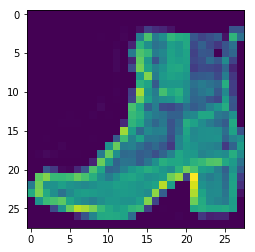

In [11]:
example = 16
g = plt.imshow(X_train.values.reshape(-1,28,28,1)[example][:,:,0])
print('this represent a : ' + true_label(y_train[example]))

<a name="232"></a>
#### 2.3.2 PCA

PCA is a dimension reduction technic that allow to summarize information from data into few dimensions. It can be summarized by the image bellow:

![](http://4.bp.blogspot.com/-pleL0HvLUgU/UYqpNFdd8EI/AAAAAAAAAHA/uf11u9lcq5g/s1600/PCA_1.png)

image taken from : http://mengnote.blogspot.com/2013/05/an-intuitive-explanation-of-pca.html

In [12]:
# Taking only the first N rows to speed things up
X_PCA = X_train[:3000].values

# Call the PCA method with 5 components. 
pca = PCA(n_components=5)
pca.fit(X_PCA)
X_5d = pca.transform(X_PCA)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target_name = y_train[:3000].apply(true_label)
Target = y_train[:3000]

In [13]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
    mode = 'markers',
    text = Target_name,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

Looking at this graphic, it seems hard to distinguish one class from another. But we can notice that a 'shoe' category (sandal, boot, sneaker) is separated from the others categories. The closeness between classes according to this graph seem quite logic

<a name="233"></a>
#### 2.3.3 t-SNE

In [14]:
# Invoking the t-SNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_PCA) 

In [15]:
traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    text = Target_name,
    mode = 'markers',
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

With this graph, we can easily separate some classes:
- bags
- boots
- sneakers
- trousers
- sandals

We can imagine that it will be the easiest classes to predict. On the contrary, it seems hard to separate shirts, t-shirts, coats and pull overs. It wille be the hardest classes to predict according to this first analysis.

<a name="Models"></a>
## 3.Models

<a name="31"></a>
### 3.1 Crossvalidation strategy

We will use the accuracy_score as our metric to compare our models.

For each model (except random becnhmark), we will use k-fold crossvalidation.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

The general procedure is as follows:

Shuffle the dataset randomly.
Split the dataset into k groups
For each unique group:
Take the group as a hold out or test data set
Take the remaining groups as a training data set
Fit a model on the training set and evaluate it on the test set
Retain the evaluation score and discard the model
Summarize the skill of the model using the sample of model evaluation scores
Importantly, each observation in the data sample is assigned to an individual group and stays in that group for the duration of the procedure. This means that each sample is given the opportunity to be used in the hold out set 1 time and used to train the model k-1 times.


explanation from : https://machinelearningmastery.com/k-fold-cross-validation/

![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACbwAAAVbCAYAAADgff6zAAAD8GlDQ1BJQ0MgUHJvZmlsZQAAOI2N%0AVd1v21QUP4lvXKQWP6Cxjg4Vi69VU1u5GxqtxgZJk6XpQhq5zdgqpMl1bhpT1za2021Vn/YCbwz4%0AA4CyBx6QeEIaDMT2su0BtElTQRXVJKQ9dNpAaJP2gqpwrq9Tu13GuJGvfznndz7v0TVAx1ea45hJ%0AGWDe8l01n5GPn5iWO1YhCc9BJ/RAp6Z7TrpcLgIuxoVH1sNfIcHeNwfa6/9zdVappwMknkJsVz19%0AHvFpgJSpO64PIN5G+fAp30Hc8TziHS4miFhheJbjLMMzHB8POFPqKGKWi6TXtSriJcT9MzH5bAzz%0AHIK1I08t6hq6zHpRdu2aYdJYuk9Q/881bzZa8Xrx6fLmJo/iu4/VXnfH1BB/rmu5ScQvI77m+Bkm%0AfxXxvcZcJY14L0DymZp7pML5yTcW61PvIN6JuGr4halQvmjNlCa4bXJ5zj6qhpxrujeKPYMXEd+q%0A00KR5yNAlWZzrF+Ie+uNsdC/MO4tTOZafhbroyXuR3Df08bLiHsQf+ja6gTPWVimZl7l/oUrjl8O%0AcxDWLbNU5D6JRL2gxkDu16fGuC054OMhclsyXTOOFEL+kmMGs4i5kfNuQ62EnBuam8tzP+Q+tSqh%0Az9SuqpZlvR1EfBiOJTSgYMMM7jpYsAEyqJCHDL4dcFFTAwNMlFDUUpQYiadhDmXteeWAw3HEmA2s%0A15k1RmnP4RHuhBybdBOF7MfnICmSQ2SYjIBM3iRvkcMki9IRcnDTthyLz2Ld2fTzPjTQK+Mdg8y5%0AnkZfFO+se9LQr3/09xZr+5GcaSufeAfAww60mAPx+q8u/bAr8rFCLrx7s+vqEkw8qb+p26n11Aru%0Aq6m1iJH6PbWGv1VIY25mkNE8PkaQhxfLIF7DZXx80HD/A3l2jLclYs061xNpWCfoB6WHJTjbH0mV%0A35Q/lRXlC+W8cndbl9t2SfhU+Fb4UfhO+F74GWThknBZ+Em4InwjXIyd1ePnY/Psg3pb1TJNu15T%0AMKWMtFt6ScpKL0ivSMXIn9QtDUlj0h7U7N48t3i8eC0GnMC91dX2sTivgloDTgUVeEGHLTizbf5D%0Aa9JLhkhh29QOs1luMcScmBXTIIt7xRFxSBxnuJWfuAd1I7jntkyd/pgKaIwVr3MgmDo2q8x6IdB5%0AQH162mcX7ajtnHGN2bov71OU1+U0fqqoXLD0wX5ZM005UHmySz3qLtDqILDvIL+iH6jB9y2x83ok%0A898GOPQX3lk3Itl0A+BrD6D7tUjWh3fis58BXDigN9yF8M5PJH4B8Gr79/F/XRm8m241mw/wvur4%0ABGDj42bzn+Vmc+NL9L8GcMn8F1kAcXgSteGGAAAACXBIWXMAAAsTAAALEwEAmpwYAAAEKGlUWHRY%0ATUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIg%0AeDp4bXB0az0iWE1QIENvcmUgNS40LjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93%0Ad3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0%0AaW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUu%0AY29tL3RpZmYvMS4wLyIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNv%0AbS9leGlmLzEuMC8iCiAgICAgICAgICAgIHhtbG5zOmRjPSJodHRwOi8vcHVybC5vcmcvZGMvZWxl%0AbWVudHMvMS4xLyIKICAgICAgICAgICAgeG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hh%0AcC8xLjAvIj4KICAgICAgICAgPHRpZmY6UmVzb2x1dGlvblVuaXQ+MjwvdGlmZjpSZXNvbHV0aW9u%0AVW5pdD4KICAgICAgICAgPHRpZmY6Q29tcHJlc3Npb24+NTwvdGlmZjpDb21wcmVzc2lvbj4KICAg%0AICAgICAgPHRpZmY6WFJlc29sdXRpb24+NzI8L3RpZmY6WFJlc29sdXRpb24+CiAgICAgICAgIDx0%0AaWZmOk9yaWVudGF0aW9uPjE8L3RpZmY6T3JpZW50YXRpb24+CiAgICAgICAgIDx0aWZmOllSZXNv%0AbHV0aW9uPjcyPC90aWZmOllSZXNvbHV0aW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNp%0Ab24+MjQ5MjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOkNvbG9yU3BhY2U+%0AMTwvZXhpZjpDb2xvclNwYWNlPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+MTM3MTwv%0AZXhpZjpQaXhlbFlEaW1lbnNpb24+CiAgICAgICAgIDxkYzpzdWJqZWN0PgogICAgICAgICAgICA8%0AcmRmOlNlcS8+CiAgICAgICAgIDwvZGM6c3ViamVjdD4KICAgICAgICAgPHhtcDpNb2RpZnlEYXRl%0APjIwMTU6MDk6MTAgMTg6MDk6Nzk8L3htcDpNb2RpZnlEYXRlPgogICAgICAgICA8eG1wOkNyZWF0%0Ab3JUb29sPlBpeGVsbWF0b3IgMy4zLjI8L3htcDpDcmVhdG9yVG9vbD4KICAgICAgPC9yZGY6RGVz%0AY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CuQfZbAAAEAASURBVHgB7N0LkBXV%0AgT/gwxsEREAeCr7BB2JJSBSfwTWWSXSNukaTqFGDiRqJycasunFrY7R01xhjGbMm+NrUbq3R1XJ9%0Aoia+H7jExEfUKBGIgCIoiqKgPAb4e3r/PdP33plhZrh3uD39dVVXd5/uPn3Od4ZImt+c7rb+kyVY%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKDeBP7+kwad+cm6c701bFO1%0Ap5vA26ai91wCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAi0KvDqJ2eF3TJE%0AAm8ZDLsECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUL8C3eu3aVpGgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSaBATemizsESBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAdCwi81fHgaBoBAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQINAkIvDVZ2CNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgACBOhYQeKvjwdE0AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIEGgSEHhrsrBHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnUsIPBW%0Ax4OjaQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQJCDw1mRhjwABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTqWEDgrY4HR9MIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoElA4K3Jwh4BAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQI1LGAwFsdD46mESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgECTgMBbk4U9AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AEKhjAYG3Oh4cTSNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBJgGBtyYL%0AewQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQxwICb3U8OJpGgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0CAm9NFvYIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAoI4FBN7qeHA0jQABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgSaBATemizsESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgEAdCwi81fHgaBoBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0ANAkIvDVZ2CNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBOhYQeKvjwdE0%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgSEHhrsrBHgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnUsIPBWx4OjaQQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECDQJCDw1mRhjwABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgTqWEDgrY4HR9MIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAoElA4K3Jwh4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI1LGA%0AwFsdD46mESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECTgMBbk4U9AgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKhjAYG3Oh4cTSNAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBJgGBtyYLewQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBQxwICb3U8OJpGgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAk0CAm9NFvYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAoI4FBN7qeHA0jQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSaBHo2%0A7dojQIAAAQJNAuvXr286sEeAAAECBAgQIECAAAECBAgQIECAQLsEunXr1q7rXUyAAAECBAgQIECA%0AAAECbRMQeGubk6sIECBQCIG2hNzack0hsHSSAAECBAgQIECAAAECBAgQIECAwCcCLQXbsu/RWroG%0AIAECBAgQIECAAAECBAi0X6DbJ/+HyxQ+7XdzBwECBLqUQHP/KWhrWZeC0BkCBAgQIECAAAECBAgQ%0AIECAAAECHRBoKdBWXl5+3IFHuYUAAQIECBAgQIAAAQKFFzDDW+F/BAAQIFB0gWywLd0/66yzwu23%0A3x4aGhqKzqP/BAgQIECAAAECBAgQIECAAAECBNotEINtEydODDfffHMYOHBg4yxw6fs3wbd2k7qB%0AAAECBAgQIECAAAECjQJmeGuksEOAAIFiCaQv19Jex+O4vvLKK2GPPfZIi20JECBAgAABAgQIECBA%0AgAABAgQIEOigwPXXXx9OOeWUxsBbNuiW3e9g9W4jQIAAAQIECBAgQIBAIQW6F7LXOk2AAAECjQJp%0A0C3dLl++vPGcHQIECBAgQIAAAQIECBAgQIAAAQIEOi4Q37Wl791iLXE/XbL7aZktAQIECBAgQIAA%0AAQIECGxYwCdNN2zkCgIECHQ5gfRlWnYb99etW5esaYcHDRqUfNo0PbYlQIAAAQIECBAgQIAAAQIE%0ACBAgQKB1gfPPPz/MnDkzuSh93xZnc+vevWkOgnR2t/hOLt1vvVZnCRAgQIAAAQIECBAgQCAVEHhL%0AJWwJECBQEIFsyC12OQ26pdv4Ei5devToET7zmc+kh7YECBAgQIAAAQIECBAgQIAAAQIECGxAYIst%0Atmi8In3nFsNu8b1bDLfFNZYLujUy2SFAgAABAgQIECBAgEC7BJp+nahdt7mYAAECBLqCQHyxlq7p%0Ab5uuXbu2K3RNHwgQIECAAAECBAgQIECAAAECBAhscoH4zi2+b4tr+h4ubi0ECBAgQIAAAQIECBAg%0A0HEBM7x13M6dBAgQyK1A9uVa3M+G3eK+hQABAgQIECBAgAABAgQIECBAgACBjRdIA2+xpjijW5zp%0ALRt4M9vbxhurgQABAgQIECBAgACB4gkIvBVvzPWYAAECjQJp2C1u0980NcNbI48dAgQIECBAgAAB%0AAgQIECBAgAABAhslkL5zi8G2dI3v4uK+hQABAgQIECBAgAABAgQ6JiDw1jE3dxEgQCB3Aulvjma3%0AcT+u2RneGhoactc3DSZAgAABAgQIECBAgAABAgQIECBQjwLpDG9p2C3dpu/oYptjWTwWgqvHEdQm%0AAgQIECBAgAABAgTqUaB7PTZKmwgQIECgtgJp0C0+JQ28pb9t6pOmtbVXOwECBAgQIECAAAECBAgQ%0AIECAQHEE0sBb+gun6Xu5uLUQIECAAAECBAgQIECAQMcEBN465uYuAgQIdAmB9AVb+sItDb11ic7p%0ABAECBAgQIECAAAECBAgQIECAAIFNLJAG3uJ7t/QXT9OwW7rdxE30eAIECBAgQIAAAQIECOROQOAt%0Ad0OmwQQIEKiOQBp2S7fZ0Ft1nqAWAgQIECBAgAABAgQIECBAgAABAsUWSANv6bu39F1cNuyW3S+2%0Alt4TIECAAAECBAgQIECgbQICb21zchUBAgS6pED2BVvcjy/evGDrkkOtUwQIECBAgAABAgQIECBA%0AgAABAptAIPvOLX0Xl22Gd3FZDfsECBAgQIAAAQIECBBom4DAW9ucXEWAAIEuI1D+Yi09jtv0N027%0ATGd1hAABAgQIECBAgAABAgQIECBAgMAmFEjft6Xv4GJT4r6FAAECBAgQIECAAAECBDouIPDWcTt3%0AEiBAINcC2Rdr6Qu3dJvrjmk8AQIECBAgQIAAAQIECBAgQIAAgToSSN+5pdvYtOx+HTVVUwgQIECA%0AAAECBAgQIJALAYG3XAyTRhIgQKA2AvHFWrp4yZZK2BIgQIAAAQIECBAgQIAAAQIECBCojkD6zq38%0APVx1alcLAQIECBAgQIAAAQIEiikg8FbMcddrAgQINAqkL93SguzLt7TMlgABAgQIECBAgAABAgQI%0AECBAgACBjRMofw+3cbW5mwABAgQIECBAgAABAsUVEHgr7tjrOQECBEoEvHAr4XBAgAABAgQIECBA%0AgAABAgQIECBAoCoC3rtVhVElBAgQIECAAAECBAgQaBQQeGuksEOAAAECUcAMb34OCBAgQIAAAQIE%0ACBAgQIAAAQIECFRHwLu26jiqhQABAgQIECBAgAABAlkBgbeshn0CBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQqFsBgbe6HRoNI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAIGsgMBbVsM+AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECNStgMBb3Q6NhhEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAVkDg%0ALathnwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTqVkDgrW6HRsMIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAICsg8JbVsE+AAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECdSsg8Fa3Q6NhBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIJAVEHjLatgnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgboVEHir26HRMAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBDICgi8ZTXsEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEDdCgi81e3Q%0AaBgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIZAUE3rIa9gkQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgbgUE3up2aDSMAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBLICAm9ZDfsECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgULcCAm91OzQaRoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQJZAYG3rIZ9AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKhb%0AAYG3uh0aDSNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBrIDAW1bDPgEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjUrYDAW90OjYYRIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQFagZ/bAPgECBAgQIECAAAECBAgQ6AoCf/nL%0AX8Jtt90W3nrrrdC/f/8wceLE8OUvf7luu5a39tYtpIYRIECAAAECBAgQIECAAAECBAgQIECAQJcX%0AEHjr8kOsgwQIECBAgAABAgQI5E1g9uzZ4V//9V/DmjVrat70Aw44IJx++uk1f05nPqChoSGcd955%0A4b333mt87IwZM8KWW24ZDjrooMayetnJW3vrxU07CBAgQIAAAQIECBAgQIAAAQIECBAgQKCYAgJv%0AxRx3vSZAgAABAgQIECBAoI4FnnjiiTB37txOaeHdd9/d5QJvixYtKgm7pZCzZs2qy8Bb3tqbetoS%0AIECAAAECBAgQIECAAAECBAgQIECAAIFNIdB9UzzUMwkQIECAAAECBAgQIECgZYGVK1e2fLLKZzrz%0AWVVueovVrVu3rsVz9Xgib+2tR8OitGn9+vVh+fLloSv+uS3KGOonAQIECBAgQIAAAQIECBAgQIAA%0AAQIbL2CGt403VAMBAgQIECBAgAABAgSqKjB69Oiq1tdaZVtvvXVrp3N5bsSIEaF///5hxYoVJe0f%0AO3ZsyXG9HOStvfXiVrR2PPzww+EnP/lJY9gt/u/EtGnTwsCBA4tGob8ECBAgQIAAAQIECBAgQIAA%0AAQIECBRcQOCt4D8Auk+AAAECBAgQIECAQP0JHHbYYWHYsGFh7dq1G2zcvHnzwnXXXVdy3R577BG+%0A+tWvlpS1dLDTTju1dCq35X379g0XXnhhuOWWW8KSJUuS8Nvee+8dDj744LrsU97aW5eIBWjU7Nmz%0AG8NusbtvvPFGWLp0qcBbAcZeFwkQIECAAAECBAgQIECAAAECBAgQKBUQeCv1cESAAAECBAgQIECA%0AAIFNLtCzZ8+w7777tqkdm2++ecV1MSx3wAEHVJQXqWCvvfYKcc3Lkrf25sVVOwkQIECAAAECBAgQ%0AIECAAAECBAgQIECg6wl073pd0iMCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQ6IoCAm9dcVT1iQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAl1QQOCt%0ACw6qLhEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKArCvTsip3SJwIECBAg%0AQIAAAQIECBDYeIEFCxaEjz76KPTv3z9ss802FRXOnTs3/P73vw+LFy8Offv2Ddttt13YZ599wtCh%0AQyuuba7gww8/DC+88EJy/3vvvReWLVuW1BOfN3LkyDBu3Liw7bbbNndrm8oWLVqU1Nm7d+8wevTo%0AELcbWjbU53j/W2+9FZ555pnw5ptvhg8++CAMHjw4DB8+POy9995h2LBhG3pEi+fz1t7yjjQ0NISF%0ACxeG+fPnJ2v82Rk4cGDy8zBmzJiw5ZZblt/SeNyjR48wYMCAxuNa7KxcuTK88cYbSdtef/31sHTp%0A0jBo0KAwYsSIsPvuu4cddthhox8b+//8888ndcf6u3Xrlvx8xD8Te+65Zxg1alSbn7F27dqwfPny%0AxutXrVrVuJ/uxD9D8c9N+dK9e/fEvrzcMQECBAgQIECAAAECBAgQIECAAAECBLqCgMBbVxhFfSBA%0AgAABAgQIECBAgECVBa6++upwyy23NNZ68sknhylTpiTHMWRz6aWXhieffLLxfLrTs2fP8O///u9J%0A+C0ty25jOOeee+4Jjz76aJg9e3ZYv3599nTFfgwhffe73w0TJ06sONdawbRp08JNN93UeEkMNv3P%0A//xPiO1raWmtz/Gel156KfzHf/xH+MMf/tBiu/faa69w/vnnhyFDhrT0mGbL89bebCfeeeedcM01%0A14SHHnooxJBWR5fvfOc74dhjj+3o7S3eF3/mrrvuujB9+vSwbt26Fq+LwbcvfelLSRv69OnT4nXl%0AJ2LQ78477wx33XVXmDdvXvnpkuPtt98+xD9LBx98cEl5cwenn3568mekuXNp2dSpU9Pdim2tPCse%0ApIAAAQIECBAgQIAAAQIECBAgQIAAAQKdLNDym/5ObojHESBAgAABAgQIECBAgED9CMQZ17JLnK0q%0ALnEWsnPPPTfEmdCaW2L4J56Ls71llzi71vXXXx/uuOOOsGbNmuypVvdfe+218P3vfz9Mnjw5Cb61%0ANktYtqIYwsouMfS0evXqVgNvLfU5tveGG24IN998c4tBt/RZMQx32mmnhUsuuSTssssuafEGt3lr%0Ab+xQHOsYivzP//zP8PHHH2+wjxu64I9//GPVA2+33XZbMnYrVqzY0OOTmftiMO6xxx5LAnIbvOGT%0AC1588cXwk5/8JMQZ49qyxEDchRdemMwCFwNpLc06GH/mYiB0Y5ZXXnllY253LwECBAgQIECAAAEC%0ABAgQIECAAAECBOpWoHvdtkzDCBAgQIAAAQIECBAgQKCuBGJo6Jxzzmkx7JY2trlZtH7wgx+EW2+9%0AtV1ht7S+uI0hpBgU6uwlBrli2+NscRuajS5t25IlS8JZZ50Vnn766bSo07ad2d5f/vKXycxu1Qi7%0ARaD4+dNqLvFn5qqrrgptCbtln/vqq6+G8vBj9ny6/8QTTyRhzLaG3dL74jbOCHfGGWe0GJTr1atX%0A6NevX/aWdu/HWQ0tBAgQIECAAAECBAgQIECAAAECBAgQ6IoCZnjriqOqTwQIECBAgAABAgQIEKiy%0AQAx7xVnLysM9cYaqYcOGhXfffTfEWdzistlmm5U8Pc6uFj8HWr7svPPOyadKt9pqqxDX+BnJhQsX%0AJs+49957Q7wvu7zwwgvhkUceCX/zN3+TLa7ZfgxK/cM//ENF23faaaew++67hxgoiuGoWbNmVbR1%0A1apV4Ve/+lXYe++9a9a+8oo7s71xJrs4e1p26datWzjmmGPCZz7zmTB27NhkBrg429/MmTPD7bff%0AXvE50fHjx4f+/fsnVcRPzR599NHZ6jZq/6233gqXXXZZSR09evQIn//855M1/rzFQNnixYuTn7f4%0Aid2nnnoqaXO8aUOzEMbZ0370ox9V9Gn06NHhwAMPDLvttlsyw9/y5cvD3Llzk5+TGHLL1hvL4+dv%0A42dyu3ev/H3EaDljxozGPsRZFsv/TMTnxXBc+RLLPve5z5UXOyZAgAABAgQIECBAgAABAgQIECBA%0AgECXEBB46xLDqBMECBAgQIAAAQIECBCorUAMBMXwTrpsvvnmIX6S8ZBDDgkxSLR27dokGPb888+H%0APfbYI70s2WZnRovBpiOOOCJZY3CsfJkwYUJSdPzxx4crr7wyPPTQQyWXxBDZ/vvv3+KnIEsu3siD%0Ahx9+uKSGUaNGhalTpybPz56In0qNYcBolF3++te/JrO8dVborbPaG38OLr300mxXQ/x5uOiii8Kn%0APvWpkvKRI0cmob8YNIvhwQ8++KDxfPzsbfw8bi2W+KnV7M9rfMbFF18c9ttvv5LHxXbH4GUMh8XP%0AysbPsz7zzDNh6NChJdeVH8TZ7cpnMoxBzH/8x38Mffv2Lbl8zJgxScjui1/8Yvjxj39cEhqNgcD7%0A778/HHbYYSX3xINvfetbyZqeuOaaa8JvfvOb9DDZ/su//EvF54NLLnBAgAABAgQIECBAgAABAgQI%0AECBAgACBLihQ+SvEXbCTukSAAAECBAgQIECAAAECGyeQDQ8NHjw4TJs2LQnxxLBbXOJ2zz33DCef%0AfHJF4GeLLbYIBx98cDL7Vwzs/P3f/31oLuyWbWEMIsXw0PDhw7PFIc7cFYNknb3EvsU+x7Bd+RJn%0AuYufW21uRq2bb765/PJOOa5le+PsbjEcll1OOeWUirBb9vwuu+wSTj/99GxRmD59enjxxRdLyqp1%0AEGfdyy5x3MrDbtnzcX/LLbcMZ599drjxxhuTn+fy8+lxnHUtzjaYXb7yla8kYbbysFv2mhh8iz9D%0A5Z8ajTO8NTQ0ZC+1T4AAAQIECBAgQIAAAQIECBAgQIAAAQKtCAi8tYLjFAECBAgQIECAAAECBAiU%0ACsTPlf70pz8Ncbaz9iwXXHBB+O53vxtGjBjR5ttikOzEE0+suD5+hrIzl3322SdcccUVySxmrT03%0Ahv3Kl2effTaZ/a68vJbHtW7v7NmzS5ofg2JHHnlkSVlzB3/7t38bhgwZUnIqzm5W7SXOvDZnzpyS%0AauMsbtVY4kyGMbSWXWL/p0yZki1qcX/AgAHha1/7Wsn5+PN89913l5Q5IECAAAECBAgQIECAAAEC%0ABAgQIECAAIGWBQTeWrZxhgABAgQIECBAgAABAgTKBOJnTMeOHVtWWrvD5p61aNGi2j2wrOZdd901%0Amb0tfop1Q0v8ROenP/3pksvi51zfe++9krJaHnRGe8vDZHGM2uIT+x2Nskv8pGe1l27dulVU+dpr%0Ar1WUdaQgBvTK2/yNb3yjYlbD1uo++uijQwy+ZZcYjLQQIECAAAECBAgQIECAAAECBAgQIECAQNsE%0ABN7a5uQqAgQIECBAgAABAgQIFF4gfhby8MMP71SHkSNHVjyvMwNvF110UbvCTPFTouVL+ec/y89X%0A87gz2jt37tySJrdntr+tt9665N74idpqLzHwVv7J3KeffroqwcOnnnqqornxc73tWeJnT7fffvuS%0AWxYuXFhy7IAAAQIECBAgQIAAAQIECBAgQIAAAQIEWhYQeGvZxhkCBAgQIECAAAECBAgQyAh873vf%0Ayxx1zu7gwYMrHvTBBx9UlNWqYODAge2qujzQFW/uzMBbZ7S3f//+JSYffvhhyXFrB0uWLCk5vdVW%0AW5UcV+tgzJgxJVV99NFH4cwzzwyvv/56SXl7D1588cWSW2L742d+27vEz6Bml84McWafa58AAQIE%0ACBAgQIAAAQIECBAgQIAAAQJ5FBB4y+OoaTMBAgQIECBAgAABAgQ2gUB7w1SboImb/JHNhZ8685Om%0A7QXoSHvLP0s6f/78Nj923rx5JdeWz8RWcnIjDo499tiKmfnefPPNED8/euWVV4a333673bUvXrw4%0ALFu2rOS+HXfcMaxZs6bd69ChQ0vqiYG8999/v6TMAQECBAgQIECAAAECBAgQIECAAAECBAg0L9Cz%0A+WKlBAgQIECAAAECBAgQIECgtgLLly8Pf/7zn5MZ0JYuXRrefffdZI3Bn3Xr1tX24TWqvXfv3hU1%0Ax0BUvS4daW954O3VV18Ns2fPDmPHjm21m4888khF0Kx8JrZWK2jHyW222SaZ0e2KK64ouSuOxe23%0A3x7uuuuusO+++4YjjjgiTJo0KcTPoG5oaS6QNmPGjHDIIYds6NY2nY+Bui222KJN17qIAAECBAgQ%0AIECAAAECBAgQIECAAAECRRYQeCvy6Os7AQIECBAgQIAAAQIENoFA/CzkPffcEx599NGwcuXKTdAC%0Aj9wYgUMPPTTcdNNNoaGhIakmhhMvv/zy8POf/7xiVrX0OXFGtWuuuSY9TLY9evQI48ePLymr5sGR%0ARx6ZBCd/+ctfhtWrV5dUvXbt2vDkk08m6+jRo8Nxxx0XvvCFL4Q+ffqUXJc9qPWndJubbS/7fPsE%0ACBAgQIAAAQIECBAgQIAAAQIECBAg8H8CPmnqJ4EAAQIECBAgQIAAAQIEOkVgzpw54etf/3r4zne+%0AE+6//35ht05Rr/5Dtt1223DMMceUVDxr1qxw8sknJwGyjz/+uPFcnBXtt7/9bZgyZUpYtGhRY3nc%0AOeWUU0Ksq5bL0UcfnQTtPvWpT7X4mDfeeCPEmeBie2IYs6Ulfna0Vkv8NGqtLWrVdvUSIECAAAEC%0ABAgQIECAAAECBAgQIECgswXM8NbZ4p5HgAABAgQIECBAgACBAgrMnz8/nH322WHZsmUVvY+f1Rw+%0AfHgYMmRIGDp0aMjOdLV+/fpw7733VtyjYNMKfPaznw3//d//XdKI+EnOf/qnf0rKhg0bFuIsavFT%0Atc0tcWa3E088sblTVS+LYbIrr7wyxFBebPPjjz/eODtd9mFvvvlmOOuss5K1PNAXr2tu9rfddtst%0AmRkuW0979wcOHJh8XrW997meAAECBAgQIECAAAECBAgQIECAAAECRRUQeCvqyOs3AQIECBAgQIAA%0AAQIEOklg4cKFzYbddtpppxBn4DrkkENCv379mm2NwFuzLJu0cNWqVeGyyy5rtQ1Llixp8fyee+4Z%0Azj///NC9e+dOOr/rrruGCy64IAld3nfffeHWW28N77zzTkk748/b1VdfHWKQbdy4cSXnYjCtfBkw%0AYEA46qijyosdEyBAgAABAgQIECBAgAABAgQIECBAgEANBTr37XINO6JqAgQIECBAgAABAgQIEKhP%0AgRggKg8W7bPPPuG6664LRxxxRItht/rsjVb96le/CnHGvnSJnwudPHly6NatW1rU7HbkyJHhoosu%0ACldddVWI+5tqGTRoUPjqV78abr755vC9732vYua2ODPdpZdeWtG85gJvb7/9dsV1CggQIECAAAEC%0ABAgQIECAAAECBAgQIECgtgJmeKutr9oJECBAgAABAgQIECBQaIH4CdOZM2eWGMTPXV544YWhR48e%0AJeUO6l8ghsHi7Gjp0qtXr2TWtMGDB4cFCxaEGTNmhDijX/w8aJzBbdttt21c42dM4+dr62WJbf+7%0Av/u7sPPOO4fzzjsvLF++vLFpMdD33nvvhdivdNl6661Dz549Sz6HWh7kTK+1JUCAAAECBAgQIECA%0AAAECBAgQIECAAIHaCQi81c5WzQQIECBAgAABAgQIECi8wLx580IMSWWX+EnLvn37Zovs50Rgzpw5%0AYeXKlY2tjWGxNBSWhtsaT+ZkJwbxDjvssHDLLbeUtPjVV18NkyZNaiyLAbnY35dffrmxbMWKFUnQ%0AL/Z9Uyzx87IWAgQIECBAgAABAgQIECBAgAABAgQIFE3AJ02LNuL6S4AAAQIECBAgQIAAgU4UaG4G%0ArO23374TW+BR1RR46aWXSqpbv359yXFeD/baa6+Kpjf3sxvDceXLf/3Xf5UX1eR48803r6g3zkJn%0AIUCAAAECBAgQIECAAAECBAgQIECAQNEEBN6KNuL6S4AAAQIECBAgQIAAgU4UGDFiRMXTFi1aVFHW%0AUsHNN9/c0inlm0Bg0KBBJU+Ns53FwNcHH3xQUp63g+aCY2PHjq3oxhe/+MWKsgcffDD5hGvFiSoX%0ADB8+vKLGxYsXV5QpIECAAAECBAgQIECAAAECBAgQIECAQFcX8EnTrj7C+keAAAECBAgQIECAAIFN%0AKLDTTjuFbt26hexMYM8++2yIn2Ls06dPqy278cYbw7XXXtvqNU52rkCcCa18PK+77rpwww03hHHj%0AxoU43vFztXHt169f4/5mm20WYvhx9OjRYcCAATVt9HPPPRf+9Kc/haOPPjqUB/RaevD//u//lpyK%0Any/dcccdS8riQSyLn+SN9adL/GTvJZdcEi644ILQXCgtva65bbw3ziTXXDC0/Pott9yyvCg89thj%0A4cgjj6woV0CAAAECBAgQIECAAAECBAgQIECAAIGuLCDw1pVHV98IECBAgAABAgQIECCwiQVi6Gmb%0AbbYJCxYsaGxJnOHtqquuCmeffXbo0aNHY3m68+GHH4bLLrssPP7442mRbZ0IxADZ1772tfCb3/ym%0ApEXr1q0L8XOn5Z88Lbno/x8MHjw4TJgwIZxwwgmhuVnUmrunPWX33Xdf+O1vfxtuvfXWpK1HHHFE%0Aq8G32JdHHnmk5BG77LJL6Nmz+Vcm3/72t8PUqVNDDKulS+z3lClTwjnnnBMmT56cFre4nTVrVvjd%0A734XHnjggfDRRx+Fe+65JwkItnjDJye22mqritMxPBr7Wz7z3F//+tcwcODAMGzYsIp7FBAgQIAA%0AAQIECBAgQIAAAQIECBAgQCDvAs2/vc17r7SfAAECBAgQIECAAAECBOpG4Nhjjw0/+9nPStoTAz4x%0AJBTPbbvttkk4Jwbh/vjHP4b7778/rFixovH6OFvYypUrG4/tbFqB008/PZnJ7Oc//3nJzH1tbVX8%0AfGgMmMV13333Deedd16IIbhqLatXr06qWr58eYizz/36179OnrPzzjuHUaNGhThT2tKlS8PChQuT%0An7XXX3+95NG9e/cOZ511VklZ9mC33XYL3/zmN8M111yTLQ4xqPmjH/0omcVu++23DzvssEOyxuBc%0A7PO7774b3njjjfDMM8+EZcuWldz7/vvvbzDwFmeP22effcLMmTMb740zJ1566aXh7rvvDmPGjAlr%0A1qwJf/7zn8P8+fPDl770pfCDH/yg8Vo7BAgQIECAAAECBAgQIECAAAECBAgQ6CoCAm9dZST1gwAB%0AAgQIECBAgAABAnUqEIM3McgWP7+YXebNmxd++tOfZosq9uPnGuNnMq+44oqKcwo2nUAMqMXZ+Roa%0AGjaqEfFToj/84Q9DDM9t6BO3bX3QyJEjSy6NbXziiSeSteRECwdx5sFdd921hbP/V3z88ceHGKiL%0An90tX2KoLa5PPvlk+akWj9v6mdeTTjqpJPCWVhhDbnHNLjGAZyFAgAABAgQIECBAgAABAgQIECBA%0AgEBXFBB464qjqk8ECBAgQIAAAQIECBCoM4Fzzz03CQjF2a3asvTv3z/Eew466KBw7733tuUW13SS%0AwPTp05OgYpxdLF3izGPxU59xdrW4rlq1KlnT/Ti7WZxR7amnnkpmV0vvi9tXXnkl+YTtP//zP2eL%0AO7z/5S9/Ofz+978P8bOe7Vk233zzEANl5Z8HbamO0047Ley4447h3/7t35IZ3Fq6rrXyOJvcySef%0AnMxw2Np16bndd989+UzrTTfdlBa1uB0yZEiL55wgQIAAAQIECBAgQIAAAQIECBAgQIBAngUE3vI8%0AetpOgAABAgQIECBAgEDhBWKoJYbDsp8A3WabbTbaZauttiqpI34GMoZzOrrEGaziLG1PP/10mDZt%0AWpg7d26zVcVnxM9cnnHGGWHrrbdOromfcuzevXtYt25dclzetuYqKr+mLe3vyD3lz06fk35WM7a7%0AfMax8nvicUee3ZF7yp/d3vbOmjUrGcds2G3y5MnhggsuSGZ8K6+//DjOtnbrrbcmPwPZc48++mjy%0AadON+RlL64t9ip8yjTMKxk99vvjii63ORBeDbscdd1w45phjwmabbZZW06btIYccEg488MBwxx13%0AhAceeCDMmTNng595HTRoUIjBtXjfZz/72dDW2d3SBsU/G5MmTUo+Zbp48eK0uGS73XbbhaOOOqqk%0AzAEBAgQIECBAgAABAgQIECBAgAABAgS6ikC3T15SN/1KdlfplX4QIECAQIVA+j/38R+K4/7atWuT%0ANf6jYzrzRpyJI35u7Ctf+Upyf/wH9PipMQsBAgQIECBQ3wLxv+tLliwJa9asCfFTk+0N0LTUu2XL%0AloW49urVK4wYMSIJnbV0bXvL33nnneSzj/HTj2+99VbYYostkmDYnnvu2Wz74+cj33vvvSSQNHTo%0A0DY9riPt78g95Y2Jf6eK4xH/zhXb2tYQVUee3ZF7Nqa9U6dODS+99FJjFaNHjw7XX3996NevX2NZ%0AW3Z+9rOfhbvuuqvk0quvvjqMHz++pKwaB3E84ixycYa56PXxxx8nP2sxMBhDlWmgshrP+uCDDxKf%0ApUuXhrgfg6jxz2MMucV1++23D6NGjarGo5I64p+jBQsWhNdffz2sXLky+XkbM2ZM8pyqPURFBAgQ%0AIECAQLsFYpj+/vvvT+6Ln2+fMmVK6Nu3b/IJ9/h367j27Nkz+ft1/AWJbt26Na7tfpgbCBAgQIAA%0AAQIECBAgUEABM7wVcNB1mQABAgQIECBAgACBriXQo0ePNs0i1t5epyGd9t7XluvjLFxxnTBhQlsu%0AT0JD7Q3ydaT9HbmnvAN9+vQJMQjW3qUjz+7IPeXtamt7X3vttZKwW6wn/mNue8Nu8b44Q1l54O3V%0AV1+tSeAt9i/+nLX1Zy22r6NLnC1uv/326+jt7b4v/XM0ceLEdt/rBgIECBAgQIAAAQIECBAgQIAA%0AAQIECORVoHteG67dBAgQIECAAAECBAgQIECAQOcJxEBa+dLRGdnST75m60s/YZsts0+AAAECBAgQ%0AIECAAAECBAgQIECAAAECBMoFBN7KRRwTIECAAAECBAgQIECAAAECFQLvv/9+RdmHH35YUdaWguxn%0AUdPrx40bl+7aEiBAgAABAgQIECBAgAABAgQIECBAgACBFgUE3lqkcYIAAQIECBAgQIAAAQIECBBI%0ABcaMGZPuNm4ffvjhxv227vzpT38Kd955Z8nl22yzTYifA7UQIECAAAECBAgQIECAAAECBAgQIECA%0AAIENCfTc0AXOEyBAgAABAgQIECBAgAABAgTiDGzdu3cP69ata8SIwbWePXuG008/PfTp06exvLmd%0ANWvWhPvuuy9cf/31oaGhoeSSb33rWyXHDggQIECAAAECBAgQIECAAAECBAgQIECAQEsCAm8tySgn%0AQIAAAQIECBAgQIAAAQIEGgX69esXvvCFL4R77723sSzu3HbbbWH69Olh0qRJYcKECWHIkCFh0KBB%0AoVevXuHtt99O1sWLF4fHHnssLF26tOTeePD1r389TJ48uaJcAQECBAgQIECAAAECBAgQIECAAAEC%0ABAgQaE5A4K05FWUECBAgQIAAAQIECBAgQIBAhcA555wTli1bFmbMmFFybuXKlUmgLYba2rMccMAB%0A4dRTT23PLa4lQIAAAQIECBAgQIAAAQIECBAgQIAAgYILdC94/3WfAAECBAgQIECAAAECBAgQaKNA%0A/KTphRdeGI477rgwcODANt5VeVmcAS6G5y655JLQrVu3yguUECBAgAABAgQIECBAgAABAgQIECBA%0AgACBFgTM8NYCjGICBAgQIECAAAECBAgQIECgUiB+qnTq1Knhm9/8Znj00UfD3XffHV555ZXQ0NBQ%0AeXGmJIbcxo8fHz73uc+FAw88MPTu3Ttz1i4BAgQIECBAgAABAgQIECBAgAABAgQIEGibgMBb25xc%0ARYAAAQIECBAgQIAAAQIECGQE+vTpEz7/+c8n69q1a8PChQvDW2+9FT7++ONkjTO3bbbZZslMcCNH%0AjgwjRozI3G2XAAECBAgQIECAAAECBAgQIECAAAECBAh0TEDgrWNu7iJAgAABAgQIECBAgAABAgT+%0Av0CPHj3Ctttum6xQCBAgQIAAAQIECBAgQIAAAQIECBAgQIBALQW617JydRMgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWoJCLxVS1I9BAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIFBTAYG3mvKqnAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgSqJSDwVi1J9RAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIBATQUE3mrKq3ICBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqJaAwFu1%0AJNVDgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAjUVEHirKa/KCRAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBaAgJv1ZJUDwECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAjUVEDgraa8KidAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgACBagkIvFVLUj0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgUFMBgbea8qqcAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABKolIPBWLUn1ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBNBQTeasqr%0AcgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBColoDAW7Uk1UOAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECNRXoWdPaVU6AAAECuRZYvnx5+Pa3v53r%0APmg8AQIECBAgQIAAAQIECBAgQIAAgc4UeOGFFzrzcZ5FgAABAgQIECBAgACBwgkIvBVuyHWYAAEC%0ALQt069YtxDVdVq9eHW688cb00JYAAQIECBAgQIAAAQIECBAgQIAAgXYIlL9va8etLiVAgAABAgQI%0AECBAgACBFgR80rQFGMUECBAokkD2xduoUaNCnz59itR9fSVAgAABAgQIECBAgAABAgQIECBQE4Gd%0AdtopqTf7/q0mD1IpAQIECBAgQIAAAQIECiRghrcCDbauEiBAoDmB7IxucX/IkCHhhhtuCI8//niI%0AM7ytXbs2WdetWxfWr1/fuKZ1xTILAQIECBAgQIAAAQIECBAgQIAAgSIJpO/U0m337t1Duvbo0SP0%0A7NkzjB8/Puyzzz4lX1SI16f3FMlLXwkQIECAAAECBAgQIFBNAYG3amqqiwABAjkSKH+5lr5oi9v4%0AMm7s2LFh1apVYc2aNcna0NAQYugtBuDS4FvsrsBbjgZdUwkQIECAAAECBAgQIECAAAECBKoikL5b%0Ai9s06BZDbr169UrW3r17h759+ybhtuy16cNjmYUAAQIECBAgQIAAAQIEOiYg8NYxN3cRIECgywhk%0AX7jFl3PZl3Txt1FjwC1us8E2gbcuM/w6QoAAAQIECBAgQIAAAQIECBAg0AGB8ndq8b1afIeW3aZB%0AuPTa+Ji4ny7Z/bTMlgABAgQIECBAgAABAgQ2LCDwtmEjVxAgQKBLCWRfpKX7cZuu8cVcdo2/mZqG%0A3eI12U+bRpj0XJdC0hkCBAgQIECAAAECBAgQIECAAAECrQik79LiNg22xfdocU3fraXlcZu9Pu6n%0AS3Y/LbMlQIAAAQIECBAgQIAAgdYFBN5a93GWAAECXVYgfZmWvmzLvoBLX8plw27p+fLAW5cF0jEC%0ABAgQIECAAAECBAgQIECAAAECrQiUv1eL79TS0FsafEvfqaXb7Du5Vqp2igABAgQIECBAgAABAgRa%0AERB4awXHKQIECHR1geZeyqVht169ejXO3hZfyMVPm8Y1DbylNmZ4SyVsCRAgQIAAAQIECBAgQIAA%0AAQIEiiKQDa6lYbbse7Vs8C09n76LS+9NrcqP03JbAgQIECBAgAABAgQIEGheQOCteRelBAgQ6NIC%0A2ZdrcT996Zb+FmoMsaVBtvKwWwy8xSU9n267NJjOESBAgAABAgQIECBAgAABAgQIEMgIpO/XYlH6%0Abi1u0/draeAtDcGl16T3pdtMlXYJECBAgAABAgQIECBAoI0CAm9thHIZAQIEuopAfJmWhtTifnzZ%0AFkNs8eVbLM/O4Ja+iItlcXa38vPRJK2rq/joBwECBAgQIECAAAECBAgQIECAAIENCcT3anFJg2vp%0Ae7Q04JYG3tJtLE+vSe/d0DOcJ0CAAAECBAgQIECAAIHmBQTemndRSoAAgS4nkL5ISwNq6XHcxpdt%0AsTwNvcWytDyWlYfd0joiUna/y6HpEAECBAgQIECAAAECBAgQIECAAIFmBLLv1rLv0uJ7tmzoLd3P%0Aht3S69NtrD6tr5lHKSJAgAABAgQIECBAgACBMgGBtzIQhwQIECiCQPYFWtxPA29p39OXbekLunTW%0Atxhui/vZReAtq2GfAAECBAgQIECAAAECBAgQIECgCALl79fSd2xpsC19r5YG3uI2lqXv3bL3F8FL%0AHwkQIECAAAECBAgQIFBNAYG3amqqiwABAjkUSF/GxaanL9rSsvgiLgbcsoE3AbccDrImEyBAgAAB%0AAgQIECBAgAABAgQI1EwgvktL1zTUlgbf0qBbtjz7Di42Kj2uWQNVTIAAAQIECBAgQIAAgS4mIPDW%0AxQZUdwgQINBWgfIXafGlW7rE/eaCbtmwW3Y/vc+WAAECBAgQIECAAAECBAgQIECAQJEE0ndscZtd%0AswG37H72miI56SsBAgQIECBAgAABAgSqKSDwVk1NdREgQCAHAvGlWhpWi/vZJX35Fs/Hc/E4vTZu%0A0/3sPc2VZc/bJ0CAAAECBAgQIECAAAECBAgQINDVBMrfq6XHcZtd0/dt2bKsRXpftsw+AQIECBAg%0AQIAAAQIECLQuIPDWuo+zBAgQ6JIC8UVaGlTLvlRLy+O5dD8CpNem2y6JolMECBAgQIAAAQIECBAg%0AQIAAAQIEOiiQvmPLbuN++XGsPlvWwce5jQABAgQIECBAgAABAoUWEHgr9PDrPAECRRaIL9bSAFv6%0Aki31yJ5Lr4nnsvvptbYECBAgQIAAAQIECBAgQIAAAQIECFQG2dJ3buXbaJWWcSNAgAABAgQIECBA%0AgACB9gt0+yS8sL79t7mDAAECBLqKQPl/BrLH2f3Y3/LjrmKgHwQIECBAgAABAgQIECBAgAABAgQ2%0ARqA8wJY9zu7HZ5Qfb8xz3UuAAAECBAgQIECAAIEiCgi8FXHU9ZkAAQLNCDQXZmuurJlbFREgQIAA%0AAQIECBAgQIAAAQIECBAgkBFoLtTWXFnmFrsECBAgQIAAAQIECBAg0EYBgbc2QrmMAAECRREQcivK%0ASOsnAQIECBAgQIAAAQIECBAgQIBAZwgIunWGsmcQIECAAAECBAgQIFAkgZ5F6qy+EiBAgMCGBcpf%0AwAnAbdjMFQQIECBAgAABAgQIECBAgAABAgRSgfL3a2m5LQECBAgQIECAAAECBAhUR0DgrTqOaiFA%0AgECXFfCCrssOrY4RIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHcCXTPXYs1mAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKKSDwVshh12kCBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkT0DgLX9jpsUECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAopIDAWyGHXacJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECCQPwGBt/yNmRYTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECg%0AkAICb4Ucdp0mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBA/gQE3vI3ZlpM%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBQgoIvBVy2HWaAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+RMQeMvfmGkxAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECikg8FbIYddpAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQI5E9A4C1/Y6bFBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQKKSAwFshh12nCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkD8Bgbf8%0AjZkWEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJACAm+FHHadJkCAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQP4EBN7yN2ZaTIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUIKCLwVcth1mgABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAvnUuLiVAABAAElEQVQTEHjL35hpMQECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAopIPBWyGHXaQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECORPQOAtf2OmxQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECikgMBbIYddpwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJA/AYG3/I2Z%0AFhMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCQAgJvhRx2nSZAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgED+BATe8jdmWkyAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAIFCCgi8FXLYdZoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQL5ExB4y9+YaTEBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQKKSDwVshh12kCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkT0Dg%0ALX9jpsUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAopIDAWyGHXacJECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQPwGBt/yNmRYTIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgkAICb4Ucdp0mQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIBA/gQE3vI3ZlpMgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgACBQgoIvBVy2HWaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0A+RMQeMvfmGkxAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECikg8FbIYddp%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5E9A4C1/Y6bFBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKKSAwFshh12nCRAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgkD8Bgbf8jZkWEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAoJACAm+FHHadJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAQP4EBN7yN2ZaTIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUIKCLwV%0Acth1mgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvkTEHjL35hpMQECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAopIPBWyGHXaQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORPQOAtf2OmxQQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECikgMBbIYddpwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIJA/AYG3/I2ZFhMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCQ%0AAgJvhRx2nSZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgED+BATe8jdmWkyA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFCCgi8FXLYdZoAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL5ExB4y9+YaTEBAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQKKSDwVshh12kCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAjkT0DgLX9jpsUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAopIDAWyGHXacJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQPwGBt/yN%0AmRYTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgkAICb4Ucdp0mQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBA/gQE3vI3ZlpMgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgACBQgoIvBVy2HWaAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAEC+RMQeMvfmGkxAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECikg8FbIYddpAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5E9A%0A4C1/Y6bFBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKKSAwFshh12nCRAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkD8Bgbf8jZkWEyBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJACAm+FHHadJkCAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQP4EBN7yN2ZaTIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgUIKCLwVcth1mgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAvkTEHjL35hpMQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAopIPBWyGHX%0AaQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORPQOAtf2OmxQQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECikgMBbIYddpwkQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIJA/AYG3/I2ZFhMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQKCQAgJvhRx2nSZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgED+BATe8jdmWkyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFCCgi8%0AFXLYdZoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL5ExB4y9+YaTEBAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKKSDwVshh12kCBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkT0DgLX9jpsUECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAopIDAWyGHXacJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECCQPwGBt/yNmRYTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECg%0AkAICb4Ucdp0mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBA/gQE3vI3ZlpM%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBQgoIvBVy2HWaAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+RMQeMvfmGkxAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECikg8FbIYddpAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQI5E9A4C1/Y6bFBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQKKSAwFshh12nCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkD8Bgbf8%0AjZkWEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJACAm+FHHadJkCAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQP4EBN7yN2ZaTIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUIKCLwVcth1mgABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAvkTEHjL35hpMQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAopIPBWyGHXaQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORP%0AQOAtf2OmxQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECikgMBbIYddpwkQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJA/AYG3/I2ZFhMgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCQAgJvhRx2nSZAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgED+BATe8jdmWkyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAIFCCgi8FXLYdZoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQL5ExB4y9+YaTEBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKKSDwVshh%0A12kCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkT0DgLX9jpsUECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAopEDPQvZapwkQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBGou8OabbybPGD58eOjZ0z9L1RzcAwgQIECAAAECBAgUQMAMbwUYZF0kQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECHSGQENDQ7j44ovDpEmTwqBBg8KoUaOSdcCAAeHQQw8Nzz//fGc0%0Ao+IZs2fPDjvssEPo3bt3GDhwYDj33HMrrqlWwQMPPBAmTpwYtttuuzBhwoQwffr0alWtHgIECBAg%0AQIAAAQIEPhHwqzR+DAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBDZaYO7cueH4448PTz/9dEVd%0Aq1atCjEI9uMf/zjccccdFedrXTB//vwwb9685DFr1qwJM2fOrNkjZ8yYEZ577rmk/gULFoSHH344%0AHH744TV7nooJECBAgAABAgQIFE1A4K1oI66/BAgQIECAAAECBAgQIECAAAECBAgQIEAg5wIvv/xy%0AmDZtWli/fn3Ve7LXXnuFk046qer1FqHCE088sdmwW7bv77//fvbQPgECBAgQIECAAAECBNotIPDW%0AbjI3ECBAgAABAgQIECBAgAABAgQIECBAgAABAptS4Nprrw2/+MUvatKEIUOGCLx1QPahhx6qmDXt%0A1FNPDUcddVQYNmxYmDNnTrjzzjuTz4p2oHq3ECBAgAABAgQIECBAoFFA4K2Rwg4BAgQIECBAgAAB%0AAgQIECBAgAABAgQIECCQB4Hly5fXrJkrVqyoWd2dWfGiRYtCXPv16xd23nnn0KNHj5o+/vLLLy+p%0A/8wzzwxXX311Y9mkSZPCCSec0HhshwABAgQIECBAgAABAh0V6N7RG91HgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIENgUAvvvv3/o1atXEuKKQa6W1vK2de/evcVr0zoOOOCA8ttyd/zEE0+ErbfeOnz6%0A058O48aNC9/4xjdq3oeXXnqp5BlnnHFGybEDAgQIECBAgAABAgQIVEtA4K1akuohQIAAAQIECBAg%0AQIAAgcIJvPnmmyGuDQ0Nheu7DhMgQIAAAQIENqVADHCtXr06+XtY/LtYS+uWW25Z0sx77723xWvT%0AOh588MGSe/J48O6775Y0+5133ik5rvbB2rVrk9nk0nr79OkT9thjj/TQlgABAgQIECBAgAABAlUV%0AEHirKqfKCBAgQIAAAQIECBAgQKArC8R/BL344otD/BzToEGDwqhRo5J1wIAB4dBDDw3PP/98p3d/%0A9uzZYYcddgi9e/cOAwcODOeee27N2vDAAw+EiRMnhu222y5MmDAhTJ8+vWbPUjEBAgQIECBAgEB+%0ABBYvXhxi6C1dhgwZku7aEiBAgAABAgQIECBAoOoCPateowoJECBAgAABAgQIECBAoEIgBqFeeeWV%0A0L9//3DQQQeFzTffvOKaTVFQr+3aFBYbeubcuXPD8ccfH55++umKS1etWhViGOzHP/5xuOOOOyrO%0A17Jg/vz5Yd68eckj1qxZE2bOnFmzx82YMSM899xzSf0LFiwIDz/8cDj88MNr9jwVEyBAgAABAgQI%0A5EMgBt6yS/zlEAsBAgQIECBAgAABAgRqJSDwVitZ9RIgQIAAAQIECBAosMDLL78cpk2bFtavX191%0Ahb322iucdNJJVa+3lhVec8014Ywzzmh8RJyNa9asWcmMXI2Fm2CnXtu1CSja9MgTTzyx2bBb9ub3%0A338/e2ifAAECBAgQIECAQCEE4kzI2aV7dx8YynrYJ0CAAAECBAgQIECgugICb9X1VBsBAgQIECBA%0AgAABAp8IXHvtteEXv/hFTSzip3HyFni77777Sixee+21MGfOnDBu3LiS8s4+qNd2dbZDW5730EMP%0AVcycduqpp4ajjjoqDBs2LBnPO++8M/m0aFvqcw0BAgQIECBAgED+BV599dVw//33hzjj7ttvvx36%0A9OkThg8fHnbddddkFtyhQ4d2qJPx06DPPvts+Mtf/pKscTbf+On6+Fn5/fbbL1l79OhRUXeckXjp%0A0qVJefz/G9ll2bJl4Q9/+EO2KNmPbdxxxx0ryttSENu1ZMmS5NL4S0/Z5eOPP654XmzznnvuGZpr%0Ae/bedP+dd95JfKNzfE7sw+DBg5O/f0+YMCEcfPDBnT5zdmxH/Ht/bFOc1S7O4B1/oenoo48OY8eO%0ATZtuS4AAAQIECBAgQIBAjQUE3moMrHoCBAgQIECAAAECRRRYvnx5zbq9YsWKmtVdq4rLZzuIz6nF%0A7HftbX+9tqu9/eiM6y+//PKSx5x55pnh6quvbiybNGlSOOGEExqP7RAgQIAAAQIECHRdgRdffDGc%0AcsopSSitpV7GUFf8RZ34i0AxFNXW5cEHHwzf//73w0svvdTiLaNGjQo//OEPw9SpUxuviUG3GLRr%0A7u/48aKnnnoq7L333o3Xpzu9e/cOMVgWA3XtWdasWRPGjx8fWvr/Z/GXfJp7Xpxl+rTTTmv1Ua+/%0A/npyze9+97uwbt26Fq/t2bNnmDJlSrjiiivaZdxiha2cWL16dTjrrLPCDTfcEGIgsXw577zzktDb%0Ar3/96+BzruU6jgkQIECAAAECBAhUX8Cc0tU3VSMBAgQIECBAgACBwgvsv//+oVevXslv7sd/6Glp%0ALYeKn71p6dq0/IADDii/re6PJ0+eXNLG0aNHhzFjxpSUbYqDem3XprDY0DPL/8Ex+4naDd3rPAEC%0ABAgQIECAQNcRiL/0EINccQa21pYYiorhp//H3p2AW1XVfRxfMqNgTIIiCAgoKipgzAKaA1k2mUNW%0AWs5v06O+r6aVlZpls0OZ+b5maTkkqWQZ6asXUEDQRF8RAxVDkFlAAZnB19/O/3atdfc599x7z+Xe%0Ac853Pc92rbWns9dnU2fftf9nraFDh+YNXvPP8aUvfckdd9xxNe6/ZMkS99WvftUpIMzSihUrcga7%0A2T5ZuQK5Vq9enbUp7zr9yClXsFu+AxXMli/dd999yShwGjkvX7CbzqHgPo0urtHeZs6cme+09dqm%0AgMBjjz02+aysYDc7+QMPPOA++MEPOgVEkhBAAAEEEEAAAQQQQKBhBRjhrWF9OTsCCCCAAAIIIIAA%0AAhUpcNZZZzktNSVNBamXB5b+9re/ufHjx1u1bPJLLrnEDR48OJn2RiMnnHDCCcl0R43dwKZ6XY3t%0AEn++XmotW7YsXa2pqg499NC0TgEBBBBAAAEEEECg/AX0THjyySe7iRMnBo3VFJsKgFPQlaa4fP75%0A55OANY2ApvTPf/4z2f7www+7MWPGBMf6lTvvvNP9+te/9lclwXIaSbhbt25u6dKlybmeeOKJdIQx%0AP3hM05Luueeebt26dcE5aqpoStOePXvWtFu17Wp39+7dk+uqtjHPCjllJQWvacQ6BbDFabfddnMH%0AHHCA69Kli3vuueeqBdpp+lb9MErBiBdccEF8eL3qmrZVU6dqxLo4tWvXzu29997JNguE07WMGDEi%0ACdqL96eOAAIIIIAAAggggAACxRMg4K14lpwJAQQQQAABBBBAAAEEEMgU0AsajQigpSmlpnpdTclI%0A16IXl/YCS/VOnTopIyGAAAIIIIAAAghUkIBGa/OD3TQC9bXXXuv0IxI9V/tJQVmnnXZa8oMXrd+0%0AaZO79NJLc45CtnnzZqfR3SzpfHfffXdyDltnuX6IceONNyaLAs4s6UcZCs5au3Ztskqjv/nn1OjO%0At912m+2e5gp4U1vqkhTMZz9gUps//elPp6fRiNYK8vOTRgHPFVynqULjYLeDDz7YXX/99UnAoE0T%0Aqudyjb6skeCuueYa98477yQfofUyPumkk5x+WFWsdOWVV1YLdjv99NPdueeemwTZaUpY3d9bb73V%0Aff/733caaW/jxo3uySefLNYlcB4EEEAAAQQQQAABBBDIECDgLQOFVQgggAACCCCAAAIIIIAAAgiY%0AgALe/GQv2/x1lBFAAAEEEEAAAQTKV0ABTN/5znfSBjZr1sxpdOrjjz8+XecXNIrZM88844YMGeJe%0AfvnlZNOsWbPcn//8Z/eJT3zC3zUpa1S49evXp+vPOOOMzGA37bDPPvskgXZXXHGF22OPPdJjVNCo%0Aa1qUNPKYn3bffXenUeCKmTSinBalVatWBadWIFihnyffq666KjheU7tOmDDBxc/eCs47/PDDk6V/%0A//7u7LPPTqdylaGC4G644YbgXHWtvP766+6uu+4KDv/MZz7jNBqfH+TYtm1b97WvfS0ZAVD39+mn%0Anw6OoYIAAggggAACCCCAAALFF2hW/FNyRgQQQAABBBBAAAEEEEAAAQTKR0DTK/lJLzhJCCCAAAII%0AIIAAApUj8NOf/jSY4v7MM8/MGexmKpru0g+S03qNFpaVFBznpyOOOMKvZpbjYLfMnUpk5XXXXRf4%0A9u7dOwkojIPd4uYoMPDHP/5xsFrTwmZNPxrsVGBF12VT0+oQBdrdfvvtQbCbfyoFI06dOjUZ+c1f%0ATxkBBBBAAAEEEEAAAQSKL8AIb8U35YwIIIAAAggggAACCCCwiwWmTZuWjCjQoUMHN3bs2GBKnkcf%0AfTR5WaJRujS1zejRo92nPvUpp+l0cqUNGzY4nfPZZ59NprNcvXq169atWzJCgUYpGDBggOvTp0+u%0AwzPX61f+S5YscZpqaPjw4TVOi5mvTZq2p6qqyj3++OPutddeS0Z5+OAHP+j0Ykwvh2qTmup1+W3Q%0AFE9z5851mjLJpk3Syy+1deDAgU4jKmSlXr16ua5du2ZtqnGdpoOyUSpefPHFYH9NWRSP2mAjTRQy%0AHZSmffr73/+eTHGlz3jrrbeSkTj071OjgXzoQx9KR8oIPrgBK7oOjTjy0ksvJf/m9QJV/8b1vxWN%0AnFHfpCmmZs+e7ebPn58s8m3fvr3TPRo1alSyFGJX3+vgeAQQQAABBBBAoLYCW7dudT/5yU/Sw1q0%0AaOGuvvrqtJ6v8NnPfjaZZtNGDNa0nxrNTKOt+UnPRX6KnzX9beVWXrduXbWgtYsuusjJuZCkEd6+%0A9a1vJdOKan/dL5tetJDjc+2jv0HiKVbPO+88p5Hr8iX9bfLggw8mQW/x3xH5jmMbAggggAACCCCA%0AAAII1E6gsL8YandO9kYAAQQQQAABBBBAAAEEdpnAE088kQS52Qfec889yfQ/b775pjvllFOcAt78%0AdOONN7rvf//77pvf/Ka/2imI7K9//au76aab3GOPPZZOixPs9F5F09doNIEf/vCHSbBZ1j7+OgWv%0AjRkzJl2l6XkeeeSRtB4XcrVJ+913333JS7NcoxYoGO+BBx5IgvLi88b1pnpddp26J3fccYe7/PLL%0AkyAsW19ormmcli1bVuju6X4axUGBdG+//Xa6zi/IftiwYf6qpHzLLbe4888/v9p6W7F48eJku+79%0Azp07bXW1XC/39OLu5z//ebVpqqrtXM8VeiGo6Zd+85vfOAWlxemyyy5Lgt5++9vfVptOKt43V13/%0AG7z44ovdCy+8kGsXt++++7pvfOMb7itf+UrOfdiAAAIIIIAAAgg0hoCe/fSDGEsHHHCA69mzp1Xz%0A5hoZuG/fvsGz7Kuvvpo8a/oH6kcPfpo4cWLyA5wjjzzSX12WZf2wRUFvlvTDlnPOOceqNeba/+ST%0AT3a///3v031tGtl0RR0K+oGGf9/1g6nTTjutoDNpWln9LRpP01rQweyEAAIIIIAAAggggAACBQkw%0AD0tBTOyEAAIIIIAAAggggAACTVVgy5YtwaWprhHZNJJbHOxmO65cudKKSb506dIkIO3jH/+4e/jh%0Ah/MGu+kAC8Q68MADk1/vByfLqGh0AD/FdX+byllt0jGf+9znkpc5uYLddOy8efPciBEj3KRJk1TN%0Am+LriOvxwbvquvS5GnFs5MiR7otf/GLwgjC+pnx1jaShETRqm/RiK1ewW75zKaAtV1KgoqZA0shu%0A+YLddLymUNVoEnrxOXPmzFynrPd6jTR37LHHJp+VFexmH6AASo0gOGfOHFtVcP6lL33JKcAzX7Cb%0ATqbRD7/61a/mDQQt+EPZEQEEEEAAAQQQKKJAHDx12GGH1ersPXr0CPZfsGBBUFdFP1rRSNKW9Dyq%0AZyhN11mX51I7Tynkr7zySnCZgwcPdpoOtjbpmGOOCXbPMg52KKCikbT9pGfzLl26+KsoI4AAAggg%0AgAACCCCAQCMKMMJbI+Lz0QgggAACCCCAAAIIIFB8AQXunH766S7f9DHx9Dg/+MEP3PTp04OLadOm%0ATTIag1487bnnnk4jMWg6xjVr1qT7rV+/3imgRy9YNAVkQyW95PrYxz5WLYBvn332cQpSW7t2bfDR%0AmiJT++vlXG2nXg1OVEOlIa/r3HPPdbNmzUqvQNNdaoQLvQDTFFAK7NNIfGprrmT75tqea71GZOje%0AvbtTIGRtUjwyh45V8JpGLYunQ9I2jRSoEUL04kzTW8UvM/XyT23WqIMXXHCBDila0ogVmjo1K3hS%0ALxg1Op62WSCcrkWBlAraKzTdeeed7te//nWw+9ChQ5MpfTVFsHw1Ra1GNLTPyRc0GJyICgIIIIAA%0AAgggsIsE4oC3GTNmJM//hX68/obwk/6uiJP+PtEIZWPHjk2fi/Scr9F2NZ2qno21aLS4cktxwNt+%0A++1X6ybq7yI/ZRn72wspL1q0KNhNfx+QEEAAAQQQQAABBBBAoOkIEPDWdO4FV4IAAggggAACCCCA%0AAAJFEPjRj36UBKbZqRT8ppdDe+21VzLK1F/+8pck0Me2K9dIV5b0kknTUp500kmubdu2tjrJNf3j%0Atddem0yJqmkvlRS0o4A5TZPaUElTeto0Pwr8Ou+885IpWW0qJb2E0xStf/rTn9JLUADRdddd5zSF%0Aa0OlhrquW2+9NRg5Ty+X7r777mDqWrVJ05VquiN/NDu1V/dbqXXr1klel/8oEMv+XSgY7dOf/nR6%0Amn79+iUjAaYr3i1oiiO7H/56TRUaB7sdfPDB7vrrr0+mRdUUTEq6XxoFTSPBXXPNNckogrb+0ksv%0ATf496t9wsdKVV15ZLdjN/reiILtWrVq5TZs2Od0L/dtesWJFMlrek08+WdAl6AWtgkEtKbhP9zBr%0AGijdR903LbxINDFyBBBAAAEEEGgqAnFAlgKh4mCo2lxr/OMbO3bUqFHurrvuSp717dlf2/RM+sMf%0A/tDp75wTTjjBXXLJJe7oo4+2w0o+j32znqlramQc8Pbmm28mP1Tq1KlTTYfm3B6P8MZzak4qNiCA%0AAAIIIIAAAggg0CgCTGnaKOx8KAIIIIAAAggggAACCDSUgD+CgkaX0ksjjWR16KGHJiO/qf6Rj3wk%0A+HjV9fJII4ZNnTo1mTo0DnbTAQoC+u53v+suvvji4Pg//OEPQb3YFXvhpZHmHnroIXfzzTcHwVX9%0A+/d39957r/vCF74QfPRtt90WjEgXbCxCpaGu66c//WlwdTbaRbDy3YpebN1zzz1JbtsUyKUpoHT/%0AmjWr+5+8stboflr23XdfO32S69+BbbM868WcplO96qqrgmM1NZVGBVFuwW7aQYGMGj3t6quvdrff%0AfrvzX4RqJEEFwRUrvf7668n/LvzzfeYzn3EakU3/W1H7lGT4ta99zT377LNOI7PVJj3//PNO123p%0AjDPOyAx203bdRwWSaqph/e+QhAACCCCAAAIINCUBPTsVK2kk3U984hM5T3fqqacmI/+efPLJ1Z5l%0A33nnHfe3v/0teV7Tj3Psxxk5T1YiG+LAsroEqWmE5jjpWbw+acmSJcHhtZ1mNTiYCgIIIIAAAggg%0AgAACCBRdoO69/0W/FE6IAAIIIIAAAggggAACCBRPQIFGhU4DeeaZZ6Yvjwq5Ao1s5gck6WWIjfhW%0AyPF12UcBWFOmTHHjx4/PPFwjaClYSoFTljRFpoKrGjIV+7p0zf60URrpQkFYuZI+X1OGWtKUsxrF%0ArykkjbCn0css9e7dO/l35ge62TY/V3DYj3/8Y39VMjVo1vSjwU4FVnRd/r9XBdopyE7/hrKSAtIU%0ACKqR3wpNzzzzTLDrEUccEdSzKg05LXDW57EOAQQQQAABBBAoRCAePUw/FJg1a1adluXLl7uapuzs%0A06ePmzBhQjJq9YUXXuiyAsAeeOABN2jQoOQHA4W0oSnvE49irB9B1DbJ1U/64Ub8oxV/eyFl/Z3h%0Ap9WrV/tVyggggAACCCCAAAIIINDIAgS8NfIN4OMRQAABBBBAAAEEEECg+AJHHXWU+/a3v138E793%0ARo0g0KNHj/T8mo6yPtMapSfKUdCIW/fff78bPHhwjj3+vVovz44//vhgH0252lCpIa5rzpw5bufO%0AneklFxIopSlC/TRv3jy/2ihljX4XB61ddNFFQaBkvgs7++yzgyl1NZ2uphetb9JUo/EUq5oi10Z1%0Ay3V+vTR88MEHXWyda//27dsHm55++umgTgUBBBBAAAEEECgVgb59+waXqpHWhg0bVqelNgH+/fr1%0Ac9dff73T87ye3/TjCT/pRzdnnXWWv6okyxox2U9x8Jq/LVc5HoVP9yzXjzlynSNeHwfMlcuIenE7%0AqSOAAAIIIIAAAgggUKoCBLyV6p3juhFAAAEEEEAAAQQQQCBTQL/E/93vflfvFxyZJ/dWxiMzNGTA%0A2/Dhw90xxxzjfXruYvxCzh9hLPdRddvSENe1cOHC4GK6du0a1LMq8YhpGiWusdPcuXOdTfmqa9E1%0AnnPOOQVflvbXVFZ+8ke+89fXpixfTflqqWXLljmnGrV9LFeg5ymnnGLVvLlGHPHTxIkT3bRp0/xV%0AlBFAAAEEEEAAgZIQiAOyFi9evEuvu3Xr1k4/UJg/f747/fTTg8/WFKcvvfRSsK7UKrFvHLxWSHvi%0Ae6Jgwfom/wdOOlf8GfU9P8cjgAACCCCAAAIIIIBA/QQIeKufH0cjgAACCCCAAAIIIIBAExPQ9Iy9%0AevVq8KvSiFd+0ghcTSHFUy415AhvtWlvodcVB+wtWLCgxo+JX/IdeuihNR7T0Du88sorwUdodL52%0A7doF62qqxEGOhVjUdM7XXnst2EWBaV26dAnWFaMyYMAA57+8VJDdcccdl4x61xQCEovRRs6BAAII%0AIIAAApUhED+f6jlPIzzv6qQRee+8885qI+7Onj27oEvZvn17Qfvt6p38Z0Z99hNPPOFqO5qaRiL2%0AU//+/f1qncrxCG/PPfecq82PiTSyMgkBBBBAAAEEEEAAAQQaToCAt4az5cwIIIAAAggggAACCCBQ%0AwgKbNm1KRkuYOnWqu+eee9x1112XTJN6xRVXOC3FGG2rIXjiEdHWr1/fEB9T63MWel0KlPKT/Lds%0A2eKvqla+9957g3WHHXZYUG+MShzwFo8IWMg1xUGCr776aiGH5d0nHomwe/fuefev68YWLVq43//+%0A96558+bpKfTS77LLLkum4/rGN77hihHAl56cAgIIIIAAAggg0EACCnjzn2lWrlzp7rrrrgb6tPyn%0A1TSdH/nIR4Kd4hGSbWM8CnJtg8jsPA2dH3TQQcHo3Poh0e23317wxz7//PPu0UcfDfb/2Mc+FtTr%0AUhk4cKBTkKElTWX75z//2ap58xkzZrgbb7wx7z5sRAABBBBAAAEEEEAAgfoJEPBWPz+ORgABBBBA%0AAAEEEEAAgTITmD59ujvrrLOSUa8OPPBAd9RRRyVTB/3nf/6nu+aaa9z3v//9ZImDj/QCpCkkBRo1%0AxVTodbVv3z4ZCcza8K9//ctdeeWVVq2WK6hq8uTJ6XpNadsUA9569uyZXmOhhTjg7c0333Rr1qwp%0A9PDM/eIR3hoq4E0fPmrUqORlsO6Jn/Sy9Yc//KHTyBsf/ehHg/vn70cZAQQQQAABBBBoCgJ6Pj3/%0A/PODS/nBD37gdu7cGazbVZXVq1cHH6XArKwUj1Cm58DGGJku69r8db1793annXaav8r96le/Kui5%0AV3+D6W80PynYbcyYMf6qOpU7d+7sTj755ODYm2++2W3cuDFYF1deeOEFp2vQD6hICCCAAAIIIIAA%0AAggg0HACBLw1nC1nRgABBBBAAAEEEEAAgRISUACbXhYdeeSR7ne/+12NLzJKqGkld6k33HCD8wPk%0AFBx14oknuscffzyZ3kij1ikw8Stf+Yo788wzg/b94he/qPXUocEJilSJA8s6depU6zN37Nix2jE1%0AvWCrdkC0YsmSJcGa2k6zGhxcQOXUU091mv5JLwubNQu7IPSC8m9/+5v70Ic+5E466aRaT11VwMez%0ACwIIIIAAAgggUBSBq666yvlB/PPmzUueX+Lgs1wfpudXjRod/2jG9tezkgK3apr6fcWKFe7vf/+7%0AHZbkQ4cODepWiQPe9MOJRx55xDY3qVxtb9myZXpNclLQ2uuvv56uiwsKKFOg3IQJE9JNGonv2muv%0ATev1LXz5y18OTqHR5M444wyX68dODz30kBs9enRBwXrBiakggAACCCCAAAIIIIBArQXC3uZaH84B%0ACCCAAAIIIIAAAggggEDpCyxevNgdc8wxbu7cuUFjDjjgAHfOOeckU5j+8pe/dL/5zW/S5ZBDDgn2%0ApVI8AY2mEE/BpJdH48aNc3vttVfyslGBiRr5wU+nnHJKtQA4f/uuLOs6/aSpr2qbli9fHhzStm1b%0AF7+4DHYooOK/qNXuhb6kLeDUOXfp06dP8iJy/vz57sILL3RZwX8PPPCAGzRokKuLU84PZgMCCCCA%0AAAIIIFAkAT3bfetb3wrOpuktDz/8cHfHHXckf0ds27Yt2K5nOQW5feELX3Aauff0009PflgT7PRu%0ARcFT999/v/v2t7/t+vXr577zne9kTv2uYLXjjz/eLVu2LD3F8OHDXbdu3dK6X9hjjz2cpgv1k34s%0AoucuBc7phxB33nlnMrp1fO3+MbuirGlj41H0XnzxRTdy5EinYMOHH37YrV271m3ZssU99dRT7qab%0Abkp+qOQHu+k6ZV3Mv9MUvBaPHq179eEPf9j9z//8j9PfkQpm1BSmCr77+Mc/7tatW5eQqU0kBBBA%0AAAEEEEAAAQQQaDiBpjnXTcO1lzMjgAACCCCAAAIIIIAAAoGAXu4ce+yxbuHChel6BbopmEojT+22%0A227per9w7733BgFyufbzj6Fcs4Be+H3xi19MA7E00kNNL+D0Mu/yyy93l1xySc0fsIv22H///YNP%0AioPXgo05KvGIFnppVt9/Z3HAnKYX3VVJL3Cvv/5696Mf/Sh5MaypwPz/3emlq6YTVnAjCQEEEEAA%0AAQQQaGoCCtz/3//9X/foo4+ml6bnFwVZKem5VYH+GnlMAWVbt25N97PC9u3brZjmer7T8+yGDRuc%0Anhm/973vJYvW6ZlS2zV68FtvvZUeo4KC8PQ3Sb70zW9+MxmRzPbRs59G1o2Tgu3i59d4n4auX3nl%0AlW7OnDnJqM72WXoe1nolOWgU6Fx/G+iHSjfeeGOybzH/c/fddyeBhv5IyQo+zDda3uDBg93EiRNd%0Ar169inkpnAsBBBBAAAEEEEAAAQQ8AUZ48zAoIoAAAggggAACCCCAQOUJPPPMM+6ll15KG961a9dk%0ABAGN+Fbf4KL0pBQKFvjrX//qJk2alO6vKS+nTJniPvaxjyWjm9k92XvvvZMR3y666CKnkcOuuOIK%0A16ZNm/S4xi7ELwzj4LVCrk8jRvhJAWP1TT169AhOEX9GsLGBKq1bt3bnnXdect800omfdL/9/z36%0A2ygjgAACCCCAAAKNKaBnGAW8aWSveDRiXZcCsfQco+errGA3HfPRj340swkK1oqTpjdVAJim0YyD%0A3TSqm0Y322+//eLDgrqetUaMGBGsy6oouK6xU5cuXdzkyZOTH0e0atWq2uXohzFZwW4dOnRwf/zj%0AH92tt97qdt9992rH1XfFwQcfnIzgduCBBxZ0Kk15qr9f4hGfCzqYnRBAAAEEEEAAAQQQQKBgAQLe%0ACqZiRwQQQAABBBBAAAEEEChHgWnTpgXN+uQnP+l69+4drKOy6wSmTp2afpgCvDT6nqYyffDBB52C%0AxvTi780330ymctKLpOuuu67e03ymH1jEQhzw9sQTT7jajqamNvupf//+frVO5XiEt+eeey6YFqum%0Ak27evLmmXQrerheZmkZLLxH9NHv2bL9KGQEEEEAAAQQQqJdAz5490+MVtJZrCtB0pxoK5557bjLS%0A8+c+97lkVLRmzXK/ZtF08pqG9JZbbnEL3x1RWlNkZiWNgqsffZx44ol5f8Sha//Zz37mXn311eQZ%0AOetc/rrmzZs7PYd+97vfTUag87eprB+TaJrT+proXJ07d3bytdS9e3crFpzL8utf/3oybelxxx0X%0AnC8+SceOHZ3ugZ5nTz311HhzZl1BdRolzlKh16jAQv3dqADCXD+yGTNmTPI3i6a41X3XiH8ysaQf%0AVpEQQAABBBBAAAEEEECgeALvP9kX75ycCQEEEEAAAQQQQAABBBAoGYEnn3wyuNbDDjssqFPZtQLT%0Ap09PP1AjY2zZsiV40dW2bVunpamngw46KHmBqJEolNSW22+/3f3Xf/1XQZeukTz86bJ0kEa5q28a%0AOHCgU6CZjTqi6/vzn//s/uM//qPGU8+YMaPo00TpJetHPvIR9+KLL6afr5fBJAQQQAABBBBAoFgC%0AGtF52bJlyehgCuzKFbBUm8/Tjwj+8Ic/JIfoBwEacXjevHnJlKSdOnVyCqzSj2g0Kli+gDj/Mz/8%0A4Q87LXr+1TUvWrTIrVq1KpnuVD+m0KLRegs9n51bAV5XXnml0/Smr7zySnKda9eudfvss4874ogj%0AihLsps/Sj1V0Xk3LqufNQoPJ7Dr9/PDDD0+mDN24caObNWtWck79eERtUeCYHHTtfvCaf3yu8qBB%0Ag5Ifz6xcuTL5G6M216h7etdddyWj7emaNMWppqFVQKWesePRmHVtS5cuTRb9/VKMoMJc7WI9Aggg%0AgAACCCCAAAKVKEDAWyXeddqMAAIIIIAAAggggAACqYCmwPFTIVM8KihLwT+k4gtopAZLesmnADEt%0Affr0sdUlkesF52mnnebuueee9Hp/9atfubPOOsvpJWi+pCC0a665JthFwW4aNaK+SaNMnHzyycnL%0AOjvXzTffnIzskW8KqBdeeCEJuNu0aZMdVrR89erVwbn0wpCEAAIIIIAAAggUS0AB9rUJbKrt5yqA%0ATgFaWoqRNEraqFGjkqUY57NzKAhNI+vGo+va9mLkCuwq5nO7nk+PPvroYlxaeg5N31qfa9TUtBq1%0Ar5Akc/1dQEIAAQQQQAABBBBAAIHiC+Qea7v4n8UZEUAAAQQQQAABBBBAAIEmJzBkyJDgmiZMmJBM%0Amxms9Cp///vfk5EX1q9f7611zkbyClZSqbWARvvy00033ZSMZqHpPDUFlF4ufepTn3Kf//zn3QUX%0AXOAuv/xyd+uttyZTNb311lv+oY1eVtCapjKypKmnFLSmqVlzJQWUKVBO/w4taSqqa6+91qr1zr/8%0A5S8H59BocmeccUbOf8MPPfRQYr9mzZrguHwVBdWp/ZqCNl9asWKF0/+m/DR06FC/ShkBBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAgUCAEd4CDioIIIAAAggggAACCCBQaQIKotKoDxawpqAkBev8+te/%0Adr169Uo5NGXNT37yk2RKR9s33UihaAIKYps9e7b77W9/G5xT0y9pyZc0AoSOv+SSSxp0FI981+Bv%0A69u3rzv//POdgvYsaerOkSNHunPPPdeNGDHCDRs2zOm6/+///s89/fTT7rbbbkvab/sr/8IXvuAO%0AOeQQf1W9yvo3r6l7Fehm6f77708COfVvX1NpaeTDOXPmuBtuuMH96U9/cjt37kx2VZsWLFhgh2Xm%0A+t+HznffffclbT/vvPOSNuhYPz3yyCPu0ksvTaYYs/XDhw9nuifDIEcAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBBDIFCDgLZOFlQgggAACCCCAAAIIIFApAoMGDXIXX3yx+/nPf542WSNOaUSxAw44wPXo%0A0SMJyFGg0vbt25N9NGrXmWee6X7zm9+kx1AojoBsNWLbs88+65577rlanXTjxo3uuuuuS+6Lpp1t%0AClNjXnnllUng2OOPP562RSO8ab2Sgi1btGjhtm3bltTj/5xzzjlJkGW8vr71u+++OxktT4GclhSA%0ApiVXGjx4sJs4cWIQCJq1r9qkqaI2bNjgli9f7r73ve8li9btv//+SZtfe+01F4/It9dee7l77703%0A65SsQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgFSDgLaWggAACCCCAAAIIIIAAApUqoOkiNarY%0AlClTUgIFIM2dOzdZ0pXvFjTq2z333OPatm0bBLwpyIdUf4EdO3a4008/PQh2O+GEE9z48eOdpvu0%0AZfPmzUlA1aJFi5KRylatWpV++Lp169yJJ57onnrqKde1a9d0fWMUunTp4iZPnux++tOfum9/+9tu%0A69atwWVoNLSsYDeNsHbLLbe4U089Ndi/WJWDDz7YzZgxIwl6mz9/fo2n1ZSnv/zlL4MpWvMdpEA9%0AjQ7nJ01vqlHjslK3bt3cH//4R7fffvtlbWYdAggggAACCCCAAAIIIIAAAggggAACCCCAAAKpQLO0%0ARAEBBBBAAAEEEEAAAQQQ2MUCPXv2TD+xdevWdZrKUAFFGiHLUvfu3a1YcN6qVStXVVXlNOqVRqDK%0AShqd6uyzz05GHtNUlB07dnQ6Tql58+ZOo1PlSrW9xtru73/u3nvvnYygZevyedT2c2q7v12D8kKv%0A64orrnATJkxID1Xw24MPPuguvPBCd/nll7urrrrK/fjHP05GPdP0n48++qjTiGn//d//HQRjaQSx%0AYo0W1rlzZ6d/n5bymdo+ft6sWTP39a9/PQnAO+6444Jz+fuprH9Xn/vc55KAv0KD3ep6XxRcNm3a%0AtCTAsE2bNvGlJPUxY8Yk/nfccYfbc889E2N5WMoVUHj99de7SZMmJYGHuc6tcyjQ7Wc/+5nTVMLj%0Axo2z05IjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIJBTYLd3f03+Ts6tbEAAAQQQQAABBBBAAAEE%0AGlBAf44sW7YsGeFKgS/5AmPyXYZGjlq5cmUSSFTbYKT4vDt37nSLFy92L7/8snvllVeSYDoFBo0e%0APTqZptHfX1M2vvHGG65Tp05JMJC/LS7X9hpru7//eRrhTNelID255ku1/Zza7u9/dk3X9a9//cv1%0A69fP6R4oDRgwIBl5T6PpFZKuueaaZBQ12/ezn/2su/POO61ar1wjy2l6TgU56t9YfUb009Srs2bN%0ASs6n+6SATQWOafrcI444IgjgLPSi63Nf9BmaXlTXpClO9e9awaiaElb3I04apW7p0qXJKIc1/fvS%0AsVu2bHHPPPOM02h8GonPpjZVcKnarIBAEgIIIIAAAggggAACCCCAAAIIIIAAAggggAAChQoQ8Fao%0AFPshgAACCCCAAAIIIIAAAgg0qMD3vvc9953vfCf9jF/84hfuq1/9alqvqfD4448Ho4QNHz7czZw5%0As6bD2I4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIlJMDPqEvoZnGpCCCAAAIIIIAAAggggEA5%0AC8yfPz9oXq7pZYOdvMrChQu9mnOHH354UKeCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACpS9A%0AwFvp30NagAACCCCAAAIIIIAAAgiUhUD79u2DdmiKzULT9u3b3W233RbsPnLkyKBOBQEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBEpfgIC30r+HtAABBBBAAAEEEEAAAQQQKAuBUaNGBe247rrr3EMP%0APRSsy6q88cYb7txzz3VTp05NN3ft2tWdcMIJaZ0CAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AlIfAbu+8m8qjKbQCAQQQQAABBBBAAAEEEECglAVWrFjhBg8e7JYtW5Y2Y7fddnPDhg1zn/zkJ92A%0AAQNcly5d3O677+6WLl3qFi1a5ObMmePuuOMOt3HjxvSYli1buqqqKnfkkUem6ygggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIBAeQgQ8FYe95FWIIAAAggggAACCCCAAAJlIaAAtnHjxrm1a9fWqT1t%0A27Z1N910kzvrrLPqdDwHIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAQNMWYErTpn1/uDoEEEAA%0AAQQQQAABBBBAoKIEDj30UDdjxgx3/vnnu3bt2hXc9j322MNdeumlbuHChQS7FazGjggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIlJ4AI7yV3j3jihFAAAEEEEAAAQQQQACBihBYv369mzBhgps3b14y%0AhammOtVUptu2bXO9evVyvXv3TpcTTjghme60ImBoJAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0AFSxAwFsF33yajgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiUkgBT%0AmpbS3eJaEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEKFiDgrYJv%0APk1HAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEpJgIC3UrpbLzl3%0AiAAAQABJREFUXCsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUMEC%0ABLxV8M2n6QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAKQkQ8FZK%0Ad4trRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQqWICAtwq++TQd%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFyEHjnnXecFhICCCCAAAIIIIAAAggggED5C7Qo/ybS%0AQgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECgngVzBbfH63XbbrZyaTVsQQAABBBBAAAEEEEAA%0AAQTeFSDgjX8GCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUBICcUCbXbStjwPccq2348gRQAAB%0ABBBAAAEEEEAAAQRKT4CAt9K7Z1wxAggggAACCCCAAAIIIIAAAggggAACCCCAAAIVJ2DBa2q4Xz7v%0AvPPcSy+95MaPH58sQ4YMcQp884PftL9frzg8GowAAggggAACCCCAAAIIlJHAbu/+kfdOGbWHpiCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggECZCfivMqysXEuPHj3cihUr0hbffPPNTkFwFuBmuXbw%0Ay+kBFBBAAAEEEEAAAQQQQAABBEpKoFlJXS0XiwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhUl%0AYAFuarQFue3cuTMpz549Owh20z5HHXVUup8do1zJP9e/1/BfBBBAAAEEEEAAAQQQQACBUhNgStNS%0Au2NcLwIIIIAAAggggAACCCCAAAIIIIAAAggggAACFSJgAWp+bkFvyh9++OFAom/fvm7//ffPDGxj%0AdLeAigoCCCCAAAIIIIAAAgggULICjPBWsreOC0cAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoHIE%0A/EA3jfCm5ZFHHgkAjj/++GS9bVduyQ+as3XkCCCAAAIIIIAAAggggAACpSfACG+ld8+4YgQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEyl7AD1DLCnZbt26dmzlzZuBwzDHHuB07drhmzZolizbaeRjh%0ALaCiggACCCCAAAIIIIAAAgiUrAABbyV767hwBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTKU8CC%0A1Kx1FvDmj9xWVVXltm/fbru4Vq1auZEjRyYjvNlKBb7ZufyAN63z67Y/OQIIIIAAAggggAACCCCA%0AQNMXIOCt6d8jrhABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgYoUsEA3Nd7KCnrTKG7xdKYjRoxw%0Abdq0SbYZloLaLLhNuRKBbqZDjgACCCCAAAIIIIAAAgiUpgABb6V537hqBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQqQsAPdPNHeHvssceC9h999NHp6G4KarNgNzueQLeAiwoCCCCAAAIIIIAAAggg%0AULICBLyV7K3jwhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKD8BG4nNAtXUQitbwNs///lPt3jx%0A4qDxRx11VDq6m4LbbDpTO1+wMxUEEEAAAQQQQAABBBBAAIGSFWhWslfOhSOAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggEDZC1iwm3ILeItHd9t7771d//790+3+MQZE4JtJkCOAAAIIIIAAAggggAAC%0ApS1AwFtp3z+uHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBshWwwDULdLOgtzjgTaO7aR/b33KD%0AUZ2EAAIIIIAAAggggAACCCBQHgIEvJXHfaQVCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiUjYAf%0AsGZl5Qpq27hxo5s5c2bQ1rFjx6bBbsGG9yqa4pSEAAIIIIAAAggggAACCCBQHgIEvJXHfaQVCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAgiUvEA8Epsf7GYBb9OnT3ebN29O29qsWTM3atSotJ6rQNBb%0ALhnWI4AAAggggAACCCCAAAKlJUDAW2ndL64WAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGKELBg%0ANzXWgt2UV1VVBe0fMmSI23PPPZN9/A0EuPkalBFAAAEEEEAAAQQQQACB8hEg4K187iUtQQABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEECg5AX8QDc1xuoW9BYHvI0ZMyZpswW4Kc8q+zC23V9HGQEEEEAA%0AAQQQQAABBBBAoDQECHgrjfvEVSKAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUNYCCmjzkx/oZuXF%0Aixe7BQsW+Lu5sWPHpnULdsvK050oIIAAAggggAACCCCAAAIIlLQAAW8lffu4eAQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEyk/Agt8s0E35zp073WOPPRY0tmPHju6QQw5J1tUU5GbbgxNQQQABBBBA%0AAAEEEEAAAQQQKDkBAt5K7pZxwQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIlK9AHOymQDctWp81%0AnWnz5s2TKUwtoC1XXr5itAwBBBBAAAEEEEAAAQQQqCwBAt4q637TWgQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEmqxAHOymui3btm1z06dPD67dpjPNFeSm9XHKWhfvQx0BBBBAAAEEEEAAAQQQQKDp%0ACrRoupfGlSGAAAIIIIAAAggggAACCCDgkhecuRx4WZlLhvUIIIAAAggggEBpCVigm3/VFuhm+axZ%0As9yGDRv8XdyYMWOC0d2aNWsW1C0QLjiICgIIIIAAAggggAACCCCAQEkLEPBW0rePi0cAAQQQQAAB%0ABBBAAAEEylMg64VnVkv9/Qh+yxJiHQIIIIAAAgggUHoCFuAW55MnTw4aM3DgQNe5c+fMALc40C2u%0AByeiggACCCCAAAIIIIAAAgggUFICTGlaUreLi0UAAQQQQAABBBBAAAEEyl/AD2JTa+1F56RJk9zX%0Av/51d//996frfI34OH8bZQQQQAABBBBAAIGmL2DPfbpSe7azdTt37nRxwJumM7VANuXx6G46j21X%0AmYQAAggggAACCCCAAAIIIFAeAozwVh73kVYggAACCCCAAAIIIIAAAmUhYC821RgrK3/sscfcRz/6%0A0bSN99xzjzv55JPTul5kKmlfK6cbKSCAAAIIIIAAAgg0aQF77rOLtLpyW1auXOleeOEF2yXJNZ2p%0AkgW1We4HviU7eP/hWdHDoIgAAggggAACCCCAAAIIlKgAI7yV6I3jshFAAAEEEEAAAQQQQACBchOw%0AF5tql5XtBWdVVVXQXAXA2TbLbQc71urkCCCAAAIIIIAAAqUjYM9y9oynXKO7xc+D7dq1c4MHD06D%0A3SzIzXILfvPz0lHgShFAAAEEEEAAAQQQQAABBPIJMMJbPh22IYAAAggggAACCCCAAAII7BIBe7Gp%0AD/Nfblp906ZNwXWobvv5o3RYWdusHBxIBQEEEEAAAQQQQKDJC9hznp/H05mOGjXKtWzZMg148wPb%0A/HKTbywXiAACCCCAAAIIIIAAAgggUGsBAt5qTcYBCCCAAAIIIIAAAggggAACDSXgv9T0yzt27Ag+%0AUqN8aMkKastaFxxMBQEEEEAAAQQQQKDJCfjPfn5Zz3x6Fpw6dWpwzWPHjk3qfnBbPLqbduDZMGCj%0AggACCCCAAAIIIIAAAgiUhQABb2VxG2kEAggggAACCCCAAAIIIFC6AnqhqeTn9pJTLzhVjgPeVNdi%0ALzWV+0kvNnUcLzh9FcoIIIAAAggggEDTE7BnQP/K4mfBZ5991q1du9bfxSngzQ92y1X2D+LZ0Neg%0AjAACCCCAAAIIIIAAAgiUrgABb6V777hyBBBAAAEEEEAAAQQQQKDsBOyFp3IbxU35tm3bgraqrvVK%0ACnaz43iJGTBRQQABBBBAAAEESkrAAt100VZWHk9n2q9fP9e9e/cg4M1+CBE/D1ogXElBcLEIIIAA%0AAggggAACCCCAAAJ5BQh4y8vDRgQQQAABBBBAAAEEEEAAgYYUsEA1/4Wmyn6wm0Zy27JlS3AZqsej%0AvvmBb9pZLzd1rvilZ3AiKggggAACCCCAAAKNLmDPgnYhVrc8DngrdHQ3ngNNlBwBBBBAAAEEEEAA%0AAQQQKC8BAt7K637SGgQQQAABBBBAAAEEEECgpAXspaZyBb0pqE351q1bg3apbiO8aYMFt+k4XmwG%0AVFQQQAABBBBAAIGSEfCfBa2sqUxnz54dtEEBb5b07OeP7qZ61vNg1jo7BzkCCCCAAAIIIIAAAggg%0AgEBpCRDwVlr3i6tFAAEEEEAAAQQQQAABBMpGQC8xs5K93FRuQW+bN28OdvVHeLOXnPnOxwvOgI8K%0AAggggAACCCDQJASynt/8Z0GVp06dGvzQoXXr1m7o0KFJUJue8fwlDnxTI3kObBK3motAAAEEEEAA%0AAQQQQAABBIoq0KyoZ+NkCCCAAAIIIIAAAggggAACCNRSwF50xi83Fexmy8aNG4Ozbtq0Kd2m42y0%0ANzuHdrbzBgdSQQABBBBAAAEEEGiSAvYc5+d6xquqqgqud/jw4a5NmzZJIJsC3CzIzXILgNNBBLsF%0AdFQQQAABBBBAAAEEEEAAgbIRIOCtbG4lDUEAAQQQQAABBBBAAAEESlfAD05TWS837WWnygpw89Pb%0Ab7+dBrz5+9p5LPePoYwAAggggAACCCDQ9ATsmU9XZmXl9ow3ZcqU4KLHjRuX1C2wTTnBbgERFQQQ%0AQAABBBBAAAEEEECg7AUIeCv7W0wDEUAAAQQQQAABBBBAAIHSEbCXnLpie9Gpl50KcPOTRnyzl6B2%0AjHIly/39KSOAAAIIIIAAAgg0LYH4mc1/prPyiy++6JYvXx5c+NixY4NpTP3ANxvRzXI7MK7benIE%0AEEAAAQQQQAABBBBAAIHSFCDgrTTvG1eNAAIIIIAAAggggAACCJSdgP/S015yWh4HvKlu2+w4y8sO%0AhgYhgAACCCCAAAJlLmDPdWqmyvbDhsceeyxo+b777uv69OmTrLNAN390N22w4DbbHpyACgIIIIAA%0AAggggAACCCCAQFkIEPBWFreRRiCAAAIIIIAAAggggAAC5SFgLzvjfP369UEDVbcXobavdlCZhAAC%0ACCCAAAIIIFAaAv5znK7Y6pZnTWdqgWw15aUhwFUigAACCCCAAAIIIIAAAgjURYCAt7qocQwCCCCA%0AAAIIIIAAAggggECDC9iLTuXr1q0LPm/z5s1u69ataYCb9iEhgAACCCCAAAIIlKaA/9xnZf3A4amn%0AngoapOlMlSzYzR/dzdYFB7y3b7yOOgIIIIAAAggggAACCCCAQGkLEPBW2vePq0cAAQQQQAABBBBA%0AAAEEyk7AXnJaw7Zt2+Y2btxo1TRXEJy/r8okBBBAAAEEEEAAgaYvkPXcZs91lk+fPj35gYO1pkWL%0AFm7EiBFpsJsFuGXlOkbrSQgggAACCCCAAAIIIIAAAuUpQMBbed5XWoUAAggggAACCCCAAAIIlLyA%0Avexcu3ZtZlvWrFlTbb0do5yEAAIIIIAAAggg0PQF/Oc3K2vq+qqqquDihwwZ4tq1a5cGvPmju1nZ%0ADiDYzSTIEUAAAQQQQAABBBBAAIHyFGhRns2iVQgggAACCCCAAAIIIIAAAqUkYC83LVDNr2cFtqlt%0AWu/vV0rt5VoRQAABBBBAAIFKF7DnODlY2c+nTJkSEI0bNy4NdvNHdbNgN39dcCAVBBBAAAEEPAF9%0A1xQjEVxdDEXOgQACCCCAQN0FCHirux1HIoAAAggggAACCCCAAAIINIBA3Pm8evXqzE/Renspqh3i%0A4zIPYiUCCCCAAAIIIIBAowrEz2x+XWWN7vbqq6+6hQsXBtc5duzYpK4AAwtys9yCDiy3A+O6rSdH%0AAAEEEKgsAf+7plgtr+mcfAcVS5rzIIAAAgggkC1AwFu2C2sRQAABBBBAAAEEEEAAAQQaWUCdx1pW%0ArVqVeSX++po6mjNPwEoEEEAAAQQQQACBRhWw5z3LFeymcjydaZcuXdxBBx2UOcKbBRT4uZUbtXF8%0AOAIIIIBAowtk9RVkravvhWZ972R9TtZ+9f1sjkcAAQQQQKBSBQh4q9Q7T7sRQAABBBBAAAEEEEAA%0AgSYsYB3DylesWJF5pStXrgxGeNNOdlzmAaxEAAEEEEAAAQQQaDIC/nObyhbspnIc8KbR3RQk4C/+%0A6G7++ibTQC4EAQQQQKBRBfzvGV2I1S331xVyofmC1XTOXNv99f5n6zP9bYVcA/sggAACCCCAwPsC%0ABLy9b0EJAQQQQAABBBBAAAEEEECgkQXU+WsdwJbnCnjTetsn6zito/O4kW8oH48AAggggAACCGQI%0AxM9w9iynfMuWLW7GjBnBUf50pnq+y1qCA96t8BwYi1BHAAEEKkfAvmfUYisrv+yyy9zvfvc717x5%0A82R6bOWtW7d2rVq1ci1btnS7776722OPPdL8Ax/4gLOlc+fOTiOOaunatavbZ599XLt27dLvG/uc%0Amr5//O12jK7TX686CQEEEEAAAQTyCxDwlt+HrQgggAACCCCAAAIIIIAAAg0sYB28luvjrKx86dKl%0AmVeg9dpu+2buxEoEEEAAAQQQQACBJiOQ9dxmz3OWP/nkk27Tpk3pNSsAYPTo0UGQG6O7pTwUEEAA%0AAQQiAf+7xsr2HbNhwwa3evXq6Ii6VxXwtu+++7pevXolS58+fdyBBx7o+vfv7/r165cE0dk15Apo%0As/U17Vf3q+RIBBBAAAEEylOAgLfyvK+0CgEEEEAAAQQQQAABBBAoWQHriLZ8yZIlmW2x9baf5dpZ%0AZXUaW555AlYigAACCCCAAAIINJqAPbvFeTyd6eGHH+46duwYBLzpOc9frBG2zurkCCCAAAKVK2Df%0ALxKwabOLraEAuvnz5ydLfG6NGnfwwQe7ww47zA0bNsyNGjXKDRw4MP3+0v7Wb2Fl5fRjSIGEAAII%0AIIBAzQIEvNVsxB4IIIAAAggggAACCCCAAAINJKCOXKU4t3Va//rrryf7xP9RwJt1Wtvx8T7UEUAA%0AAQQQQAABBJqWgJ7b7NnNz1XWs93kyZODCx4zZkwaHKDAgHh0N+1MoFtARgUBBBCoWAH/e8UQrN/A%0Aclvf0PnWrVvdc889lyx33HFH8nGaFnX8+PHuE5/4hDvxxBOTqVT1HeanrCA4fztlBBBAAAEEEPi3%0AwG7vfvH/++0CIggggAACCCCAAAIIIIAAAgjsQgH9OWqLOp537NiRLNu2bXNa1Dm8Zs2a5NfQuS7r%0AiSeecJoyRL+cbtmyZbI0b97cacl6GZrrPKxHAAEEEEAAAQQQaFgBexXhP//ZM+D27dudlkWLFrnB%0AgwcHFzJhwgQ3ZMgQ16JFi2DRs5899ym3oDfLg5NQQQABBBAoewH7nlFD7btGub5rLNjt5ZdfTn5U%0A5/c/qO9hy5YtSR+EptR+++23k6m1NXrb+vXr3VtvvZUsa9euTfoo3njjDadt9U1du3Z1X/nKV9zF%0AF1/s2rZtm36P6bx+EJxfru9ncjwCCCCAAALlJMAIb+V0N2kLAggggAACCCCAAAIIIFDiAtZBbZ3T%0ACxYsyNuiV1991fXu3bvaKCF5D2IjAggggAACCCCAQKMKxM98FpAQT2f6gQ98IPnxgwWxWZ71wwbb%0A1qgN48MRQAABBJqEgPUp+LmC3tR/sN9++yU/trMgOMt14fb9FDfCDzpTeePGjW7VqlVu+fLlTqPP%0AL168OFnUR6F+jJUrV8anqFbXPt/97nedRn/7y1/+4vr165cZ9KZr8j+/2olYgQACCCCAQIUKEPBW%0AoTeeZiOAAAIIIIAAAggggAACTVXA75CuKeBNv84++uij019vW5viTmo6iE2GHAEEEEAAAQQQaBoC%0A/jOfleOAt9GjRyejulkwW768abSKq0AAAQQQaGwBvz/Avl+UK7BNi0Z383N/H//YuB1+0JlGmd93%0A331djx493Ac/+ME0IM320ahw//znP93cuXPd7Nmz3dNPP52MLBefU3X1e2iaU01/2r59+2AXO5+u%0Ay8rBDlQQQAABBBCoYAEC3ir45tN0BBBAAAEEEEAAAQQQQKCxBPxO5Lhz2bYpVwdxvqTt+Y6nQzif%0AHtsQQAABBBBAAIFdK5D13GYBCJrSdNq0acEFjRs3Lqnrmc6WrNHd/IN4/vM1KCOAAAIISCD+/rHv%0AHsv97TWJ+d8zVo7zdu3auWHDhiXL2WefnXyHLVy40D322GNu4sSJ7plnngk+RiPEPfDAA+7zn/+8%0A0/ecn+zc/jrKCCCAAAIIIOBc+I2JCAIIIIAAAggggAACCCCAAAKNLOB3NMcBb5rWyk/z5s1Lfpnt%0AH+Nvp4wAAggggAACCCDQ+AJ6VouT//ym8j/+8Q+nEXH8dOSRR6aBbnrhHwe7aR2BAL4YZQQQQAAB%0AE4i/ZwqtWxBcrlwjxPmjxKmsoO041zp/6dmzpzvrrLOS6UsnTZrkevXqZZea5K+99lo6Cl18rdpB%0A60gIIIAAAggg8L4AAW/vW1BCAAEEEEAAAQQQQAABBBDYxQLWYet35uoSVFfn8vPPPx9c0fHHHx/U%0A58+f7zZt2pT+WtuOjc8bHEQFAQQQQAABBBBAoNEE7LlPF2Bl5fF0pgMGDHDdunULAt4swM1ya0Rc%0At/XkCCCAAAIImECxAqTtu0t9FlZWbgFyFhDn537g27Zt29zAgQPdQQcdZJeW5Dpex9h5dE4SAggg%0AgAACCOQWIOAttw1bEEAAAQQQQAABBBBAAAEEGkDAOm2zcq3Tog7el156yW3YsCG4gpNOOimY3kOd%0AxgqKs+Ms10Eq+ymu+9soI4AAAggggAACCDSsgP+cpk+yuuWTJ08OLmDs2LE1BrsR6BaQUUEAAQQQ%0A8ATsO8JybbKyRgytabF98+XexyVF+05TboFrFsRmAXAW/KZ9/JQV8OafT/vGx/jHU0YAAQQQQKDS%0ABFpUWoNpLwIIIIBA7QT4A6p2XuyNAAIIIIAAAoUJ2DNGVq5OXq2fNm1acDKN8KEpP/r27etefvnl%0AdNv06dPd6NGjq7001Tm0qHPaz9MDKSCAAAIIIIAAAkUQ0LMGKbeAnsP8ZM9ofr5q1apqI/uOGTMm%0AOcwCDWw6U8uz3LPW+Z9NGQEEEECgsgTsO0S5vj/su0cK9v2kbbbecn+7L2bHxNttvZ0r3q5+Dku2%0Ajx1j61W3oDd/H5VJCCCAAAIIIFBdgBHeqpuwBgEEEKhoAf1R5S8VjUHjEUAAAQQQQKBBBKxT189V%0AtkA3exaZMmVK8PmDBg1KnlOU+0n72TF+rn2sbmX/OMoIIIAAAggggEAxBOx5w/JinLNczyEjJbNS%0ArmdAe56zdu++++7uiCOOCEbi0Qt/P9hNdX+xY8kRQAABBCpbIP5usO8PfYdoad68ebK0aNHC2aJ1%0AVs6V2z7+8Va23M5vn6XP9pN971n/h7/Ngt2U2+J/X6pMQgABBBBAAIH3BRjh7X0LSggggEBFC2T9%0AsZS1rqKRaDwCCCCAAAII1FvAni8sjztxVde21atXuyeffDL4vFGjRiX1kSNHugkTJqTb5syZ4xYu%0AXOj69euXBs3pPNaprfNpUd3y9GAKCCCAAAIIIIBAEQT8F9p63lDy1xXhI8rmFPZs5udVVVVB+0aM%0AGOFat24dBLTJM16Cg6gggAACCFS0gL4j7DvYIOy72L4/FJhmZeUKTPO/j+x4y+08Vo9zbdc6f73V%0ALbd+Dqv7+9r57TzWR6LcvzZrh+3n1/1zUEYAAQQQQKCSBAh4q6S7TVsRQACBDAH748o2+XW/rO1x%0A3Y4hRwABBBBAAAEEaiug5wp/8Tt1Vf7DH/7gduzYkZ5Wv7AePnx4cszgwYOdRv3YuHFjuv322293%0AV199dforaL9jWOdTZ7A+z/L0QAoIIIAAAggggEAdBPK9aLZt1o9i9Tp8TNkc4j/3+WV7Bpw6dWrQ%0A1nHjxiV12dmi5zsrm6nlwcFUEEAAAQQqXiD+ftB3iJL/3ez3G9h3k79PXPbrdh4/t3P4ud8fobKS%0AcjsuWfHef7TOvhf9c/j7UEYAAQQQQACB9wUIeHvfghICCCBQcQL+H1VWtvzRRx91kyZNchs2bEhd%0AbFu6ggICCCCAAAIIIFAPAXu2UK7FOnaVP/jgg8GZjz76aNe+fftkv1atWrkTTjjB3Xfffek+v//9%0A75MAOHVY22IvRLVT3NmdHkgBAQQQQAABBBCog4D/bKFA/GOOOcadeOKJwZlsHz3nWDnYoQIq9rzn%0AN9V/9lP5+eefd2+88Ya/ixszZkwQ3CY/f9HOsWlcD05IBQEEEECgIgT0XeB/9/jfDRbgZvvY95Ht%0Ab7mg/HJct21ZudbZ4vdxqGzJjrO65XZcrtyu22+THUuOAAIIIIBAJQoQ8FaJd502I4AAAu8K2B9V%0Afm7lyy67zP385z/HCQEEEEAAAQQQaDICn/nMZ9KXmurcPeWUU9zEiRPTUeC2bt3q7r777iZzvVwI%0AAggggAACCFSWwC9+8Qt39tlnu1tuuSXpc/FfRvOC+t//FuwFvmpWVh5PZ9q7d2+33377BQFuClKQ%0Ao7n6uZUr618crUUAAQQQyCWg7wV9v/i59rW6fQdpncpZebLyvf/YPv5+ftm223kt9wPe/BHstd0P%0AgIs/y45X7ifV+c7zRSgjgAACCFS6wL/Hb610BdqPAAIIVJiA/aHk5ypr0fRhBLtV2D8ImosAAggg%0AgEATF9BoKQMHDkw6dq1zVy9CTz311CZ+5VweAggggAACCFSSwG233eZuvPHGIJhL7ff7XyrJw9pq%0AfU5x3dZPnjzZNiX52LFj0xf6evbLtwQHUkEAAQQQQCASyPoOsVHh/bx58+bJaPHK8y0tWrRIt1tZ%0Aeb5F57N97TPtuvzLte9Fy7VNZRICCCCAAAIIZAsQ8JbtwloEEECgbAXsDyQ/t18avf322+4b3/hG%0A2badhiGAAAIIIIBA6QkcccQR7vLLLw9edNoIHxdeeGEy3VXptYorRgABBBBAAIFyFbj66qvdqlWr%0A0qna/f4Xtdnq5dr+fO1S2+Plrbfecv/4xz+Cw8aNG5fULRjAnv2srjxOWevifagjgAACCFSOgH1n%0AWIutbrl9t1gAWr7cAuBsH79u5azcD4Lzt9t57Nr8POs5wb47/f0oI4AAAggggIBzTGnKvwIEEECg%0AggTsjyU/V7Cb6sr/+Mc/uuXLlwcip512muvQoUOyzo4LdqCCAAIIIIAAAgjUQcB/rlDZX/Rcog7g%0AAQMGuGOOOSYJdrN12s/voL7++uvd1KlT3QsvvJBMb6rjbLvldnmqkxBAAAEEEEAAgWII2HPFpk2b%0A3B133JGeUgFcql900UXJ84w9w2h/e46xPD2oTAtqZ5y0zl8ef/zxdIp67duqVSs3bNiwas9z9lzn%0A59rf7oPKJAQQQAABBGIB+/619fm+N+Jt8fdYTdv1GfreV9Kxfll1C3TTeeJzJQe99x//ezK+Bn8/%0AyggggAACCFS6AAFvlf4vgPYjgEDFCtgfXJbrj6/bb7898BgxYoS74YYbgo7IYAcqCCCAAAIIIIBA%0ALQX8zlqVbdGziJYdO3akuZXjY/SR1kGsDuNjjz3WjR8/PplWRHX9cjruSPY7k/1yLS+f3RFAAAEE%0AEEAAgUTAnkWUa0S3SZMmpTLqX/na176W1PVMomcc5ZX8DGLPfH4ul3g606FDh7q2bdsGz3pmbYbm%0AaHkKTwEBBBBAAIEMAfu+8PsWtJutzzgkWaXt8TH+vv7xtp++q5SsbmXVtc0WfQf6xycH8R8EEEAA%0AAQQQqJUAAW+14mJnBBBAoHQF7A8s5f5iL5bVOTtz5syggWeeeabbtm1bur9ttHPZH3z8YWYy5Agg%0AgAACCCBQk4A9R2g//5lEZT2X2KLtesZQZ7C2ZT1vaJ0tdryOU7K6bfeP98v/3pv/IoAAAggggAAC%0A+QX0bKHkP0fYc8YZZ5wRBLzNmzfPvfzyy65///7JMfY8k1TeO0eu5xvbp1xytdPsrOznccDb2LFj%0A0+c7uZmxX5aNfx/KxYp2IIAAAgg0rEDWd4d9R+X65Kxjcu0br9d3l5J97/nfZfU5b/w51BFAAAEE%0AEKhUAQLeKvXO024EEKhoAfsDS7m9VH7kkUfSDkjhtGnTxh199NFu+/bt6R9kFY1G4xFAAAEEEECg%0A6ALWsew/m9g6fZg6g/16vguwzmI7l55xtM7WW57vHGxDAAEEEEAAAQRqI2DPGsOHD3edOnVya9as%0ASQ9/+OGHXd++fas9i1TKM0n8DGd1/1lt/vz5bsmSJamZCn7Am/n6AQLaJzaM69qHhAACCCCAQCEC%0AdfkOse80//y5zqP1uRb/eMoIIIAAAgggUHsBAt5qb8YRCCCAQMkJ2B9g1qmoBqhswW6aLmz69OlB%0Au4YNG+ZatWqVTCtmx+X6o00H5tsWnJgKAggggAACCFS0gD2XGILVLbdniji3/bXe9tU6v6x61vZ4%0AnZ1b+5MQQAABBBBAAIFcAvFzhr+fttkzhQKyjjzySPfggw+mu8yYMcNdcMEF6Utu9cFo2nU7pz2f%0A2DnSA8uwoDb7iyxUr6qqClq79957p6PiySVetLN52bbgBFQQQAABBBDYBQL2XZTro+y7Ptd21iOA%0AAAIIIIBAcQT+PZZqcc7FWRBAAAEESkRAf3BZsJvlTz31VHD1I0eOTILdFAxnHZGW8wdbQEUFAQQQ%0AQAABBOohYB3F9tJSL4z1MlhLixYt0rxly5YuXrTdFjtGx9soILosO389LpFDEUAAAQQQQACBRED9%0AIdanYrn6StR3on4UP82aNSvoe7FjlVdS8tvrG6gcT2c6bty4akFu9lxnz4qWV5IhbUUAAQQQKC0B%0A+66qKS+tVnG1CCCAAAIIND0BRnhreveEK0IAAQQaRCDuVLS6OmbXr1/vNI2EnwYPHpz++lbr/T/O%0ArO7nKpMQQAABBBBAAIGaBPRMUUjynz38sh1rzzJxbtvJEUAAAQQQQACB+grYc4ueN+JkzyBar/Kg%0AQYOCXVasWOFef/11t99++yV9Kgrc0n46p53PyvY5wQnKoGLtVB4vGzdudDNnzgxaqelMleSRawkO%0AeG/feB11BBBAAAEEEEAAAQQQQACB8hcg4K387zEtRACBChewzkVj8DsYFeymZe7cuWlnq/bTCCkH%0AH3xwus46GeNf1Wrfcu2UVdtICCCAAAIIILBrBey5wp49snK7Iv+ZJi5rn/gZyI4jRwABBBBAAAEE%0AaitgzxX+M4f6U5RsW58+fVy7du3chg0b0tPPmTPH9ejRIxl9Vvv7QW/pTmVYMBO/ab6dytOnT3db%0AtmxJd1Ff1KhRo4JAt7gfyp4NdZA9N6YnoIAAAggggAACCCCAAAIIIFBRAgS8VdTtprEIIFDpAn7n%0AojpaVVf+wgsvBDTqpG3VqlXaeagORlusc9HPg4OpIIAAAggggAACtRTwX1haWXnWS047tf9cY880%0A2mbr/f2sTI4AAggggAACCNRFQM8XSvbMoVzPKn7firYfeOCB7plnnlExSepvGT9+fLKfnmvsOcWO%0At/3KOffbbGW5xdOZaoS89u3bpwFv+Z4D7XmxnN1oGwIIIIAAAggggAACCCCAQH4BAt7y+7AVAQQQ%0AKAsB61C0xljdOmbnzZtnm5J8wIABaQejOhH1K1sLeLNc662D0fLgJFQQQAABBBBAAIFaCNjzhJ+r%0AbC87dSrbprKeZyy3Zxp/nW1LduI/CCCAAAIIIIBAHQX85wuV9dyhRc8lWlRW0jb1p/gBb/Pnz0+2%0Aa5u/2P7K/ecb1cslWXvVHpUtt/VxwJumMzVTP7dnQX9dcjL+gwACCCCAAAIIIIAAAgggUNECBLxV%0A9O2n8QggUGkC1qno5+qYffXVVwOK/fffP+1kVLCbBbxZHnc26uBy7aANYKgggAACCCCAQIMK2POE%0A/0LTyvpg265y1otTe8bxt6tMQgABBBBAAAEE6iKQ9bxhAW87duxIn01sP/Wn+En9LdqmY+LnlPi5%0Axq/75yi1slnYdVvd2i+L1157zS1YsMB2SfJx48alfVHW72S52VhuB8Z1W0+OAAIIIIAAAggggAAC%0ACCBQ/gIEvJX/PaaFCCBQwQLWqegTWAejn8edjBbwpo5FLRb05ge8Waejzk0Hoy9MGQEEEEAAAQTq%0AIuA/T6hs9bhs57bnHHum0Xq/bHXbnxwBBBBAAAEEEKiLgP/MYcFuyvWMoqA3Je2jdXHAm/pb7PnE%0Az+tyHaV4jG/nt7+qqipoTqdOndwhhxySrLNnv6xcO9j64ARUEEAAAQQQQAABBBBAAAEEKk6AgLeK%0Au+U0GAEEKlXAOhbVfisr37Ztm1u6dGnA0rt373QKUz/YzcoW7OZ3MqpMQgABBBBAAAEE6iPgP09Y%0AOc798+tZRinO/XXJDvwHAQQQQAABBBCog4D/jKGy+kMU2GaBbjqlrVe5T58+ytK0YcMGt2bNGrfX%0AXnsFfTE6Ros956QHlFFB7VOytlqwoOpxwNuYMWPSaexloiXue7L1ZUREUxBAAAEEEEAAAQQQQAAB%0ABOohQMBbPfA4FAEEEChFAetotFzBbup09FPPnj3TzkV1MGqxYDcb5c06GpUrWe6fhzICCCCAAAII%0AIFBbAf+ZIlfZzqnnGUu5yradHAEEEEAAAQQQqK2APV9YH4py//lEdes3UXmfffZJ+k/8gLjFixe7%0ALl26pIFf/jXoGCX/nP72Ui1bu5THy9atW9306dODpo0dOzapyyHXEhzwbqXczOL2UUcAAQQQQAAB%0ABBBAAAEEEMgvQMBbfh+2IoAAAiUvYB2LaoiV/XzRokVBG9u1a+c6dOiQdBxap63lFuxmdetctDw4%0AERUEEEAAAQQQQKAOAvFzRVz3T2nb9GxjZW1XnYQAAggggAACCBRDwJ4rlPs/GFRd/SRap34S5S1a%0AtHDdunULRtJXwNugQYMy+2T855diXGtjn8Os/OvQOn+ZNWuWe/vtt/1d3JFHHhkEuslTNvESHEQF%0AAQQQQAABBBBAAAEEEECgogUIeKvo20/jEUCgkgTiTkfrbFy2bFnAoF8jK1mnogW3WWej1W27ckt+%0A2daRI4AAAggggAAC9RGoy/NFXY6pzzVyLAIIIIAAAgiUn4D1o+i5wsrqE7GksgW7WV+J9uvevXsQ%0A8KZ+F+uD0bF2LjuP5VpfTs8w1uY4nzx5sjU5yQcOHOg6d+6c9kPJIF7sAFtvdXIEEEAAAQQQQAAB%0ABBBAAIHKFSDgrXLvPS1HAIEyF8jqQPU7GdV81VeuXBlIdO3aNe1YVIetdSYqj+u2TSdQmYQAAggg%0AgAACCDSGAM8hjaHOZyKAAAIIIFDeAnq+8PtWVFeAm3ItFuRmdeVKGuHNTytWrEiq1iejin9ef99y%0AKGe109bJLw5403SmvmHc9yQT214OPrQBAQQQQAABBBBAAAEEEECgOAIEvBXHkbMggAACJSNgnYyW%0AW8erNcAPeLMOxaxOXNumnIQAAggggAACCDSEQG2eM/RsQ0IAAQQQQAABBIop4D+L6FnD7wuxchyg%0AtddeewWXoH4Xe06xvhjtYGX/M4IDS6xibbTLtrq1U7ks5s6da7skuQLelMzTct812cH7T7mYeU2i%0AiAACCCCAAAIIIIAAAgggUEsBAt5qCcbuCCCAQCkKWOeif+3W8fjGG2/4q511zFoHo+Xaycp+buuD%0Ak1BBAAEEEEAAAQR2sYCeT0gIIIAAAggggECxBdR/4j9n+H0iflmfq7r1q9h1qN8l7pexPhnbp9xy%0Aa5+1W7lGd6uqqgqa2q5dOzdo0KC0v8mC3Cz3fa0cnIAKAggggAACCCCAAAIIIIBAxQo0q9iW03AE%0AEECgAgX8jkY1X/U1a9YEEp06dUo7GrVBHYpZebLS2251cgQQQAABBBBAAAEEEEAAAQQQQKBcBKxf%0AxNrj162s3MqdO3e2XZPc+l3iPhnbSevLMfnttXI8neno0aNdy5Yt034oc4zzcvShTQgggAACCCCA%0AAAIIIIAAAvUTIOCtfn4cjQACCDRpAetQzLpI61C1jlfbp2PHjmknbdzBaJ232tcv27HkCCCAAAII%0AIIAAAggggAACCCCAQDkKWB+J2haX/XX6IaGf1O9ifTCWa3uusn9sqZXVpqxFo7vt2LHDTZ06NWhS%0A1nSm8ehuOoA+qICNCgIIIIAAAggggAACCCCAwLsCBLzxzwABBBCoEIG4w1HN1ro333wzEFDAm1JW%0A563tSEejSZAjgAACCCCAAAIIIIAAAggggEClCljfid9P0qFDh4DD+l3UB6Nk/TNWTlaW+H+sbX4z%0ArJ0KdlP52WefrdYHNWbMmLT/ybeMy/55fWt/PWUEEEAAAQQQQAABBBBAAIHKEiDgrbLuN61FAIEK%0AFcjV8SiOdevWBSp77rlnUrcOxDgPdqaCAAIIIIAAAggggAACCCCAAAIIVKCA9ZdY01XXYv0qtn7D%0Ahg3J6GaqZ/XP2H7lklugm7XX6lVVVUET+/fv77p37x4EvGWN7qaDzDY4ARUEEEAAAQQQQAABBBBA%0AAIGKFiDgraJvP41HAIFKFbAOVv3KVh2vfmrfvn3Skah1uTpv/f0pI4AAAggggAACCCCAAAIIIIAA%0AApUi4AdfWdnvP1G/SpzU92J9MRYAFu+juu2Tta2pr4vbZXXLJ0+eHDRB05n6fnFZO9u64EAqCCCA%0AAAIIIIAAAggggAACCLwrQMAb/wwQQACBMhTI1UFqnYxqssobN250Cnrzk/0S2Tpr6Vz0dSgjgAAC%0ACCCAAAIIIIAAAggggAAC1QWsH8X6Vfw94tH1tS1X341/XCmWre/Jz9esWZNMaeq3R9OZKlm/Uzy6%0Am3n6x2St87dTRgABBBBAAAEEEEAAAQQQqBwBAt4q517TUgQQqHABvyPVyvHobiJq165dOrJbTR2J%0ANW2vcHKajwACCCCAAAIIIIAAAggggAACZSCQ1f9h65T75T322KNai99+++0kwM36Y6rtUMIrstqk%0Adf4yderU4AeXbdq0cUOHDk2D3cxQQW9x4JtozLeEmbh0BBBAAAEEEEAAAQQQQACBIgsQ8FZkUE6H%0AAAIIlIqAOh41wluc2rZtG6yyTkXLg41UEEAAAQQQQAABBBBAAAEEEEAAgQoV8PtKrKy8devWgcim%0ATZvSehwgFtfTHUuw4Ae5WVkzC1RVVQWtGT58uFPQm6y0xEFutl4HqUxCAAEEEEAAAQQQQAABBBBA%0AIBYg4C0WoY4AAgiUmYDfcWqdjdbEzZs3WzHJ1YlonbJ+h6JfDg6gggACCCCAAAIIIIAAAggggAAC%0ACFS4gN9vovLuu+8eiNgPDq2PJs6DnUuw4vc3WVm5gt2UT5kyJWjV2LFjk7qsbImD3rSD7xqcgAoC%0ACCCAAAIIIIAAAggggEDFCxDwVvH/BABAAIFKEFDnop+s7v/CWNv9X9eqTseiFEgIIIAAAggggAAC%0ACCCAAAIIIIDA+wJ+f0lWWf0rftIPDq0vxtbHdVtfSnncBtVtsWC3uXPnuhUrVgTNGjduXBroJr94%0A0c6+a1Y9OCEVBBBAAAEEEEAAAQQQQACBihMg4K3ibjkNRgCBShXI6oTcunVrwNGqVaugHlfizsZ4%0AO3UEEEAAAQQQQAABBBBAAAEEEECgXAX8fhG/rPb69bh/Zdu2bSlJ3D+TbijxggW6qRlWVh5PZ9qz%0AZ0/Xu3fvpLUy0+KP7qYNZmnbk535DwIIIIAAAggggAACCCCAAAKeAAFvHgZFBBBAoNIE4oC3li1b%0ApgR+52K68r2CbYvXU0cAAQQQQAABBBBAAAEEEEAAAQTKWcDvE7Gy5dZuv39F6+L+l3IKerPgNmu7%0A1S2fPHmybUpyTWcqr0KW4EAqCCCAAAIIIIAAAggggAACCHgCBLx5GBQRQACBShDwO1X9Xxir7fYL%0AZOuo9XO/XAlOtBEBBBBAAAEEEEAAAQQQQAABBBCojYAFceUKePP7ZPzz5lrv79PUyxbg5ufr1693%0ATz31VHDpCnhTMit/dDdbFxzw3r7xOuoIIIAAAggggAACCCCAAAKVLUDAW2Xff1qPAAIVLrBjx45A%0AoHnz5um0EcEGKggggAACCCCAAAIIIIAAAggggAAC1QSyfiDYokWLYL+dO3cG9axKqQW9ZV2vH+ym%0A8rRp05z/Y0sFAo4YMSINdrMAt6xcRmab5cU6BBBAAAEEEEAAAQQQQACByhYg4K2y7z+tRwCBChOI%0AOyPjDlf9qtaSdSpabuvJEUAAAQQQQAABBBBAAAEEEEAAAQTeF7C+E+Va/P4V7RX3v7x/ZHmU4kA3%0A1dXmqqqqoIFDhgxxe+yxRxrw5o/uZmU7wEytTo4AAggggAACCCCAAAIIIICAL/B+ZIO/ljICCCCA%0AQFkIxAFucWdhvN06F20/y8sCg0YggAACCCCAAAIIIIAAAggggAACRRTw+01ylfVxNsK+v08RL6PR%0ATmWBbroAK/v55MmTg2sbN25cGuwmC1v8/ihbFxxIBQEEEEAAAQQQQAABBBBAAIFIIBxbPdpIFQEE%0AEECgdAXiYDZriXWuKj/ggAPcZZddZptcp06d0s5G208b/XK6MwUEEEAAAQQQQAABBBBAAAEEEECg%0AQgWsr0R5vHzxi190y5YtS2UGDRpUVn0rcZ+TX1dZo7stWLDALVq0KDVQYezYsamVBblZbjuaa666%0ArSdHAAEEEEAAAQQQQAABBBCobAEC3ir7/tN6BBAocwF1EvqdjtZc64jt27ev+/KXv5zuY+vjXMdp%0AHQkBBBBAAAEEEEAAAQQQQAABBBCodAH1keTrb/nUpz6Vbte+FtTl97eUi6Ec/EXBbqrH05l27drV%0ADRgwIGm27xCXtYOtKxcj2oEAAggggAACCCCAAAIIIFB8AQLeim/KGRFAAIEmIaDOQXUwKleyzkI/%0AV4er9rGU1QFr+9s5bF9yBBBAAAEEEEAAAQQQQAABBBBAoJIFrM/Ez62vRYFfStoW97fY+mSH9/ax%0Acinlfp+SyhbspnI8nemYMWOq9U3FLuZYSgZcKwIIIIAAAggggAACCCCAQOMIEPDWOO58KgIIILBL%0ABdRhaMk6D60DVp2Q1kGpdbbYfnYcOQIIIIAAAggggAACCCCAAAIIIIDAvwX8fhOVrT/F72fRnrZf%0AnNu2f5+t9P5rfUnWXj/fvHmzmz59etAoTWeqFDv49eCA9/aN11FHAAEEEEAAAQQQQAABBBBAQAIE%0AvPHvAAEEEKgQAb8D0Q92U/Otk1L7WAetcv8YlZUsTyr8BwEEEEAAAQQQQAABBBBAAAEEEKggAfWL%0AWD+Kmu33nfj9LdZ/ojxXX4sd7+cqN+Xkt92u0w92U/nJJ590CnqzpPaPHj26mpVvZ2U7hhwBBBBA%0AAAEEEEAAAQQQQACBfAIEvOXTYRsCCCBQJgLWaWidrH5HpN9E257VEevvRxkBBBBAAAEEEEAAAQQQ%0AQAABBBCoVAH1nyhZf4sf6GYBYZZrP+tnsX4XO87Oo31KMfn9S365qqoqaM5hhx3mOnTokHr57bey%0AHRDXbT05AggggAACCCCAAAIIIIAAAr4AAW++BmUEEECgDAXUUahOR+XWAWu5mqv1lmwfvyPWtiu3%0Asu1PjgACCCCAAAIIIIAAAggggAACCFSqgPWVKI/7WrIC3rSPf0ypullwm67f2mnrdu7c6SZPnhw0%0ATdOZ+u02B8u1s20PDqSCAAIIIIAAAggggAACCCCAQA4BAt5ywLAaAQQQKGUBdRKqozErV2eiJW1X%0A3TonrXOxefPmybHa5nc++sdZmRwBBBBAAAEEEEAAAQQQQAABBBAodwH1mSj5fSgq+/0s2m59K/5+%0Atk79LdbX4u9r57Zc25pisjbZtVlduS1LlixxL730ku2S5Ap4UzKHXHmy03v/aeoW/rVSRgABBBBA%0AAAEEEEAAAQQQ2PUCBLztenM+EQEEENilAuogVKejdRQqt85Y22YdlKrbdivH+S69eD4MAQQQQAAB%0ABBBAAAEEEEAAAQQQaGIC6ivJ1deiS7XtVra+FftRodWbWLNqdTnWl6TcFo3uFk9nqqlMNaWptdkM%0ALLf1vlWtLoSdEUAAAQQQQAABBBBAAAEEKlKAgLeKvO00GgEEKk1AnYeW1KEYd0pqm9ZZJ6Pldoxt%0A9+uUS1dA99f+DZRuK7jyQgW434VKlcd+3O/yuI+FtoL7XahUeezH/S6P+1hoK7jfhUqVx37c7/K4%0Aj4W2gvtdqFTT3S/f39O6v9bvYv0slmubLXHr8p0z3rcx63adyrUowC1e4oC30aNHpz+8tGuXQ1ay%0A82dtK4V1udpVCtfONSKAAAIIIIAAAggggAACpSZAwFup3TGuFwEEEChQQJ1s1lGY1eGmDlh1Ssbb%0AVPcX+zjbz3JbT146AvbvwXK7cu6pSZRXbvfZcmsd99skyiu3+2y5tY77bRLlldt9ttxax/02ifLJ%0A/Xvsl9VC7nf53GdriX+P/TL324TKK/fvsV/mf9vldZ+tNf499svcbxMqrVz3zb+Puno/yE19LUp2%0Afy3XPirHS7Kzt7/Vm2qutlv7rWz59u3b3bRp04JL13SmcZvjenDAuxVtL8VkLrr2Um1DKbpzzQgg%0AgAACCCCAAAIIIFCZAgS8VeZ9p9UIIFAhAupcy9fZps5WS/5+ts7P4w5bfxvlpifgd6zG91b1rO1Z%0A65pey7iiLIF89477nSVW2uu436V9/2p79dzv2oqV9v61vd/59i9tifK/+pruXdb3d03HlL9a6baw%0Apnvn32+VlWo6pnQ1yv/Ka7p33O/y+Tfg30u1SvWsdf6/Cb/1tr/WaR/Vm3qya1buj+y2Y8cOp+Xp%0Ap59269atC5qhEd7sB5fWRv88VrZ9ZJHLLDhxI1QKuS7bx9pq9Ua4XD4SAQQQQAABBBBAAAEEEChr%0AAQLeyvr20jgEEEDg/U5TdbBldbY9//zz7lvf+pZ78803Ay465AKOkqzY/fYvfsOGDe7111937du3%0Ad/vuu6+/KSlz36uRlMyKrPutFw1Lly51H/jAB9w+++xTrS3c72okJbMi637r/8eXL1/uOnbs6Lp1%0A61atLdzvaiQlsyLrfq9du9atWLHCderUyXXt2rVaW7jf1UhKZkXW/V69erVbtWqV69KlS7LEjeF+%0AxyKlU8+637rXuuf637b+Nx4n7ncsUjr1rPut/y/X/6fvvfferkOHDtUaw/2uRlIyK7Lu9/+zdyeA%0AllTlgYAP+ybIrigqiyvgAhiMKIiCxCWiUZAsGg04mpmM46iJRNHRELdgYmZIosEBM1HjhpowbiCK%0AxoXESYtCgyCibCqLgCBIQzet0381/+W86nvf3v2q7v0Kbp9Tp07VPef7733v3Xr/q7r22mvLrbfe%0AWh7wgAeU7bbbbp25iPc6JL1pyHhnGQOPz2LxGTzifZ/73KeZSx3jut6bid4z0JxnXUY9zjfUy1Zb%0AbVVe+cpXNk0x33xEQ9bTIct6/77V47P3W9/61nLAAQcMkvbSaBzm17d4GC8BAgQIECBAgAABAuMt%0AIOFtvONrdgQIEGgE4qRafYW2rMfG173udeXcc88lNWEC8UuW9onoCSOYqOlGvK+++uqJmvMkTzbi%0AfeWVV04ywUTNPeJ9xRVXTNScJ3myEe8f/OAHk0wwUXOPeFsmR0C8JyfWMVPxnqx4t//AcJJmv2LF%0AivLtb397kqZc7rjjjvLlL395MOdMdIvEt6wPNqoQIECAAAECBAgQIECAwLwF7r2X3bwPYUcCBAgQ%0A6LpAfVIt/7I0xxxXE7AQIECAAAECBAgQIECAAAECBAgQILAwgZtvvnlwe9s4B1efh6vrC3sWexMg%0AQIAAAQIECBAgQICAK7x5DRAgQGACBfKEW5ZJ8Ed/9Edl//33z1V/eTqQ6E+lPnma9TrO/+W//Jey%0AevXqZkKvec1ryr777tufyRnpOgIZ49iQ9Tref/iHfzhofx8s0M8AAEAASURBVMMb3lD23nvvdY6h%0AoT8CGeMYcdbreL/iFa8YTOakk04aetviQQeVzgtkjGOgWR8V75NPPrnstNNOnZ+TAY4WyBhHj6xn%0AvOOqMCeccMJg51NOOaVss802g3WV/glkjGPkWc94xxVZ3/a2tw0mdeqpp5ZNN3XqZgDSw0od4xx+%0Axvuiiy4qf/M3f9M0b7LJJuV973tfdlH2VGC6eP/7v/97+Yd/+IdmZvF1PL6eW/otMCzecUX9aP/S%0Al75UzjjjjGaCm2+9XXn0M9fe1rPfM147+rXz/lV8E1v7fexXMec1j2buv1zbXtZuX7vH2luZlo03%0AXnOeKR8brbmnadSjXLN9zX9R9nW55drLyg/OWxvv8InXQcytvqJbXe/rPI2bAAECBAgQIECAAAEC%0AXRJw1rRL0TAWAgQIrAeB+gRs1Ov1+tam8dQHH3xwec5znrMeRuGQG0qgjm/GO8qIdTwiqTGXQw89%0AtDztaU/LVWUPBWaKdyS85RKxPuigg3JV2UOBmeJdJ7z9xm/8RnnUox7Vw1kacgrMJd7PetazyoMf%0A/ODcVdlDgWHxju/b0f7jH/94SsLbUUcdVXbcccceztKQU2C6eF944YVTEt6OPvrostlmm+Wuyh4K%0ATBfv7bbbbpDwtvGaRJBjjjmmhzM05FpgunivWrVqkPC2xRZbiHcN18N6xjqGHvV85Pfvn/70p4OE%0At00236rs/pgx+Oy9Zp453zWzXjvnX65eU96T7Bb1XF/TFjlvsQyS2jbeZE2O2yZr8t7WlpH8Fklu%0Ag3Jt914mvm26xVaDhLeYRvyhYXxdj0e9hEW8ViS/1SrqBAgQIECAAAECBAgQmJ+AhLf5udmLAAEC%0AvRDIE7B1GfVMfsoTsb2YjEHOKNCOc6y34z3jQXTojcBM8c4r+fVmQgY6rYB4T8szdhuni3e8t+P7%0At2V8BEbFO9rFe3zinDMZFu/6Z3Pfv1NqPMqZ4u3r+XjEOWch3ikxWWXEPR/11/N8PYylRlyJbc28%0AY2kSt361Jolr7craBLa4WluJRK81rdF3zRKJbmuv7rZm/Z62KMcx8StiX399l/TWvAT8Q4AAAQIE%0ACBAgQIAAgUUXkPC26KQOSIAAgW4KtE/Axi/T4jHWJ2G7GYoNNqo8yRonWjPeG+zJPdEGFxDvDU6+%0ApE8o3kvKv8GfvI53fk3f4IPwhBtMIOMd37vzF+cb7Mk90QYViFjnI2MdpWU8BTLW7ff4eM52cmdV%0Axznr+b3b+3v8XhcZ47qcyHgPEtcimW3jJvmtSYHbKNLg1ia4ZbLb2vKeW5nmSyL2r+pZ7WsZr4e7%0A7767xK2qc4mkt3FM7sv5KQkQmF5g5cqV5dxzzy1x9c/1sey3335l//33Xx+HdkwCBAgQIECAQKcF%0AJLx1OjwGR4AAgcURqE++Rj1OwOZJ2Fi3jI9AO9bteI/PTM0kBEbFO5Ik4gS7ZbwEhsU7k1nFe7xi%0AHbNpxzu/b3t/j1+sR8U7Y+79PX4xz/d3xr7+2Tze45bxEsh4Zyne4xXfUbMZFu+IvWU8BSLe+d6O%0AMn9GH8/Z5qwiRe2ehLa8ktuaK72tTeqKW5WuTepeu762Pa/y1hwhbme6tnJPOV5FvAZi7vnIrwkx%0Ay7Um4zVfsyFAYLTAZz7zmfKiF72o3HrrraM7LXDLLrvsUm644YYFHsXuBAgQIECAAIH+CUh461/M%0AjJgAAQKzEoiTabHUZX0SNn9hnttndVCdOivQjmOst+PtF6idDd+cBzZdvPOXK36hNmfWTu7QjnUM%0Actj7W7w7Gb45D2q6eMe2/AWqeM+ZtpM7jIp3xLeOt+/fnQzfnAc1Xbwj5vn+Fu8503Zyh2HxjoFm%0ArDPeUVr6L9COd65nvP183v8Y1zPI+A4r870dMc/t9b7jVo/ErbUpb5H8tiaBbc3/v1rzZW2juLJb%0AnJOKi7vFpJvEr0iCi4ZIAlub7NYkfkXbmC0R+/iDhUx2yzLaG7NWOWbTNx0CBCqBeN+/4hWvWK/J%0AbvF0v/jFL6pnVSVAgAABAgQITI6AhLfJibWZEiAwQQLtE6uxXj/qk7ATxDK2U51NvDPmY4swQROb%0ALt75S7Xo44pA4/miaH8tz5iLt3iPp8BkzWrU+1sC1Pi9DupYZz3i7Oe18Yt1zChjnGXGOcvxnPXk%0AziriHEsd7/x5zdfz8Xtd1PHOOGc59vGORLXm5R7/RNJaJHOtTXqbkux2T9ibbZns1pSxz9pkt7X/%0Axuqgds9e/SzidRHxj9uY5iO/JkTZJPrdM7X2ej9nbNQECIwS+Pa3v11+8pOfjNq8aO2PfOQjF+1Y%0ADkSAAAECBAgQ6JPA2j+n6tOIjZUAAQIE5i0QJ9Ly5GuUcQIu2izjI1DHc1i8x2emZhIC7XhnzOO9%0APfa/YJnAl8CoeOfX8wkkGespt+Od37+9v8cz7MPinbH29Xw8Yx6zirjHo35/R90yngIZ74x5vLfF%0Ae/xjXcc76pbxE6jf23W8x/L9fU9CWp2W1iRv3ZPItvZKZhs3iW+R4DZ4bLzJvVd2q5Pdoj5+L4lm%0ARvk1Pr/He/+PaaA7Pq2rr7663HnnnYOfOTs+3LEc3rJlyzbIvH7zN39zgzyPJyFAgAABAgQIdE3A%0AFd66FhHjIUCAwCIK5Am1USdg4wRc9lnEp3WoJRLIWE4X7yUamqddDwKj4h3tcVJdgsR6QF/CQ4r3%0AEuIvwVOL9xKgL+FTjop3DMnX8yUMzHp66lHxjnbxXk/oS3jYYfGOOGe8o24ZHwHxHp9YzmUmEfd8%0A1O/vfD3M5Vi96xsJcGvyOO8p1gw/EtiiYa1JzOfeq5mt6dtKdpsy3zjImCwR+/g8Ho9NNtlk8PrI%0A10lMM+r32ozJxE2jEwL1154LLrigvPe97y2f+tSnyhZbbNG87nKQXn8psX7Lb33rW0OfYNttty07%0A77zz0G1zbdxnn33Ka1/72rnupj8BAgQIECBAYCwEJLyNRRhNggABAqMF8kRHnlirS79gGe3W9y11%0AnGMusS7efY/q6PHX8c5Yi/dor75vEe++R3Bu4xfvuXn1vXcd7/g6no++z8v4Rwu0Yx7rlvEVaMfb%0Az2vjG+uYWcY7v5aL92TFe2y/njfZbWuSteI1HiG9J9ttbfM92W+R+DYkf21tgs3axLdm1/gnlmGd%0A127p7b/xfs+vAXUZE4p1yUa9DW1nBz7sa060ff7zny/Pf/7zyyc/+cmy5ZZbDsZf9/d6HLAsemVU%0AwtsJJ5xQTjzxxEV/PgckQIAAAQIECEyagFuaTlrEzZcAgYkWiJMZ8ahPuNcnOCYaZwwnPyzeYzjN%0AiZ5S/f7NeEeZ7/GJxhnDyYv3GAZ1mimJ9zQ4Y7hpunjX28Zw6hM5pYxplPXD9+/xfDlMF+/cNp4z%0An8xZZUzr93bUM/llMlXGc9YZ45hdO+6T8vV8kNPWJKxFklvcxjTKYY/4NcSQZLcxfHnkez5fB/Vr%0AZQyna0odEMivQTmUfM1leyS9HX300SNvb5r9cn/l4gisXLmyLF++fOjBHv/4xw9t10iAAAECBAgQ%0AIDA3AQlvc/PSmwABAr0UqE9cZD3KrPdyUgY9VKAd14xxu33ozhp7KZAxjsFnnLPs5YQMeloB8Z6W%0AZ+w2ivfYhXTaCYn3tDxjt1G8xy6k005IvKflGbuN4j12IZ12QhnvKOvHtDv1fWN1RbZIemsS36Kt%0AedyT2Na05tbctiYRLvunQXWsbBqHMl8LMZd8jbTr4zBPc1h6gfbrK197WeYIP/e5zzVXervzzjuH%0Afq2qj5P7KBcmEMlukfQ2bDnwwAOHNWsjQIAAAQIECBCYo4CEtzmC6U6AAIG+CtQnLvKkR93W13kZ%0A93CBOrbiPdxonFrFe5yiOfNcxHtmo3HqId7jFM2Z5yLeMxuNUw/xHqdozjwX8Z7ZaJx6iPc4RXPm%0AuQyL98x79bxHJrjdM40piWy5rSqnbI99clvPGUYNP14T+cg+9esk25QEFiJQv6aynq+7YVcWPeus%0As8oLXvCCKVd6y/4xjjzGQsZk33sFRt3OdI899ig777zzvR3VCBAgQIAAAQIE5i0g4W3edHYkQIBA%0A/wTqkxgx+vZ6/2ZkxNMJtOPrxNV0Wv3fJt79j+FcZiDec9Hqf1/x7n8M5zKDdrznsq++/RMQ7/7F%0AbCEjjnhbJkegHe/2+uRITMZM2/Ftr4+tQiSuVUsmtrXLqsvaZLcpDeO3Usc/6vX6+M3WjJZaIF9f%0A+VrLcti4Iuktbm+6YsWKKeeF62MM20/b3AVGJby5utvcLe1BgAABAgQIEBglIOFtlIx2AgQIjLHA%0AdCc+xnjaEzs18Z6s0Iu3eE+WwGTN1vtbvCdLYLJm6/0t3pMlMFmz9f4W77EXyKu1tZLfpsx7Nn2m%0A7ND/Fe/9/sewyzOI11e95OstruxWP+o+Wa+T3vJKcLl/9GkfO/dTzk1g2bJlQ3d4/OMfP7RdIwEC%0ABAgQIECAwNwFJLzN3cweBAgQGBsBJzDGJpSzmoh4z4pJJwIECBAg0CkB3787FY71PhjxXu/EnXoC%0A8e5UOAyGAIHFEKgT2+r6Yhy7J8eIr+2+vvckWGMwzHy91WUksa1evbp55BQf+chHlmOOOSZXy9ln%0An92sx5XeJL0NWBatsnLlynLRRRcNPZ6Et6EsGgkQIECAAAEC8xKQ8DYvNjsRIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQ2HACmVCZZTxz1Osru2USW45qs802Kx/+8IfXSXp74QtfOOX2ppk4l8fM%0A/ZVzE1i+fHmJpLdhi1uaDlPRRoAAAQIECBCYn4CEt/m52YsAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIDAkghkglqWmfTWvsJbDG7TTTedNuktk+TyWLFP1C1zF/jWt741dKe99tqr7LDDDkO3aSRA%0AgAABAgQIEJi7gIS3uZvZgwABAgQIECBAgAABAgQIECBAgAABAgQIECBAYBEFMtlKufbWuMMcgjvb%0A63q0RdJaJrtFvb1IemuLrJ/1ZcuWDT2w25kOZdFIgAABAgQIEJi3gIS3edPZkQABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAYK4CmbRVl3M9xiT2T6+Ye9ajzKu71Ulvw3xGJb0de+yxze1NY//6uPk8%0Aw46lbbjAqCu8uZ3pcC+tBAgQIECAAIH5Ckh4m6+c/QgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABGYtkMlU9Q7Zphx9Zbe2TZ2YNizZLa70NmqR9DZKZuHtK1euLBdddNHQA7nC21AWjQQIECBAgACB%0AeQtsOu897UiAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgBoFI2KqXWP+nf/qncv755zdXFKu3%0AqY8WqB2znslvdeLblVdeOfoga7Zk0lt0OuOMM5q+Z599dokrvX3sYx8rW221Vdl443uvmbHRRhs1%0AcYrSMlpg+fLlJZLe2ku4HXDAAe1m6wQIECBAgAABAgsQkPC2ADy7EiBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIjBbIxKzokfUozzrrrPLhD3949I62rFcBSW+Lz7ts2bKhB917773L9ttvP3SbRgIE%0ACBAgQIAAgfkJSHibn5u9CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEphHIBLfokvUo8zHNrjZt%0AAAFJb4uL/K1vfWvoAe93v/uVc845Z+i22TRuu+225QlPeEJxhb3ZaOlDgAABAgQITIqAhLdJibR5%0AEiBAgAABAgQIECBAgAABAgQIECBAgAABAgSWQKBOcMtbcGYCXAzniU98YjnooIOWYGTj/5S77bbb%0AtJOU9DYtz5w2jkp4+8Y3vlGOPPLIOR2r3fnMM88sRx11VLvZOgECBAgQIEBgYgUkvE1s6E2cAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQILB+BDKhLZPd6jKS3url2c9+djnxxBPrJvUNKCDpbeHYK1eu%0ALMuXL1/4gUYc4Y477hixRTMBAgQIECBAYDIFNp7MaZs1AQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIDA+hDIZLf62NEWiW7xWL169eAWp3Uf9aUTyKS3Y445ZjCIs88+uxx77LFlxYoVTdzqpMXoNCzO%0Ag50nrHLhhReWVatWrbdZ77vvvuvt2A5MgAABAgQIEOijgIS3PkbNmAkQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECHReoE6SyHslu8Whf5a3jU5mI4Ul6m3+YR93OdP5HvHfPvfbaq+y33373NqgRIECA%0AAAECBAgUtzT1IiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFgvApnoVl/dzRXe1gv1ohw0k97i%0AYGeccUZzzLzS28c+9rGy1VZblY03vvd6GhtttFFzpbcoJ3kZlfC24447lt13333eNNtss0155zvf%0AWSbdd96AdiRAgAABAgTGVkDC29iG1sQIECBAgAABAgQIECBAgAABAgQIECBAgAABAhtOoL7FZSa6%0AxbNHslus55XdstxwI/NMcxGQ9DYXrbV9RyW8vfa1ry1veMMb5n5AexAgQIAAAQIECEwrcO+fYEzb%0AzUYCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECcxPIxLf6Cm933313kwA3tyPpvSEFMuntmGOO%0AGTxtXultxYoVgyTGjG90ivokLnfddVdZvnz50Kk//vGPH9qukQABAgQIECBAYGECEt4W5mdvAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgACBIQKZDFWXcXU3tzQdgtXBJklvswtKJLutWrVqaOcDDzxw%0AaLtGAgQIECBAgACBhQlIeFuYn70JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQqgWFX+oq2vMpb%0A3uK02kW1owKS3mYOzKjbme65555lp512mvkAehAgQIAAAQIECMxZQMLbnMnsQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgMJ1AJr3VV3fLRLe4wlvULf0QmC7p7c4772xuZVrHO2aV6/2Y4cJGOSrh%0Aze1MF+ZqbwIECBAgQIDAdAIS3qbTsY0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGBBAsOS3iYp%0AIWpBeB3ZOZPenvGMZwxGdPbZZ5ff+73fa5IXM8aDjRNUWbZs2dDZSngbyqKRAAECBAgQILAoAhLe%0AFoXRQQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBGqBOqkt61Hmld7qvurdF7jgggvKN7/5zcFA%0AN9tss/KiF71oEM9MeqtjPeg8ppW77rqrXHTRRUNnJ+FtKItGAgQIECBAgMCiCGy6KEdxEAIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQItgUx+iuY6IWqjjTZq9bTaZYG4befTn/708rOf/awZZlzx%0A7f3vf3+JK75FAmPGc+ONNx7UuzyfxRrb8uXLy6pVq9Y5XHgccMAB67RrIECAAAECBAgQWBwBCW+L%0A4+goBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECQwQy0a3eVCfC1e3q3RMYlux26qmnliOPPLJJ%0AdsuEt0jyqmOd65kM172ZLXxEYTNs2Xvvvcv2228/bFNn2q666qryjne8o8SV+2LZZ599yumnn96Z%0A8RkIAQIECBAgQGA6AQlv0+nYRoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsCgCmQwl2W1RODfI%0AQYYlu51yyinl8MMPL6tXry5xRbd8ZFyjHOcktxp+2bJl9eqg3uXbmd52221Nottf//VflzvvvHMw%0A5ltuuWVQVyFAgAABAgQIdF1AwlvXI2R8BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBDawwLBk%0At3e9613lsMMOa5LdIuFtk002GVzlLRLfMtktyw085A3+dKOu8NbFhLe4El/chvaNb3xjuf7669ex%0AOvDAA9dp00CAAAECBAgQ6KqAhLeuRsa4CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECCyBwLBk%0At7e97W3l0EMPHSS7RQJVPCK5rf2YhNuZ3nXXXeWiiy4aGp2uJbyde+655TWvec3g9qXDBi3hbZiK%0ANgIECBAgQKCrAht3dWDGRYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAhhUYluz2lre8pTzp%0ASU8ameA23QgjGW4cl+XLl5dVq1atM7W40t0BBxywTvtSNHz/+98vz3ve85pb0F5wwQWDIWy66brX%0ARJHwNuBRIUCAAAECBHogIOGtB0Gaboif/vSny8knn1zOOeec6brZRoAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQGBagWHJbnELzIMPPnid/epEtrq+TscxbVi2bNnQmT384Q8v22677dBtG7LxE5/4%0ARNl3333LmWeeOXjauPLescceWz7/+c8P2qIS7fvvv/+UNisECBAgQIAAgS4LSHjrcnRmMbZXvvKV%0A5YQTTmges+iuCwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIF1BIYlu73+9a9vkt0iISofuWOs%0A51LXs23cy/AatnTldqZxC9P6CnTPfOYzy/nnn18++tGPlttuu23K0LuSpDdlUFYIECBAgAABAtMI%0ArHu92mk62zRZAt/5znfKJZdcUrbZZpty2GGHle22226yAHo62+uvv76cd955ZeXKlc1f48SHFAsB%0AAgQIECBAgAABAgQIECBAgAABAgQIEOiSQH1FsNWrV09JzOnSOPs+lkhEG3b7yva8hiW7/emf/mmT%0A7Ba36JzuMV0iXDzPuCbDdTnh7eqrry7XXHNNE+YnP/nJ5e1vf3s55JBDBmFvj70rt2AdDFCFAAEC%0ABAgQIDCDgIS3GYBms/naa68tb37zm8uFF17Y/MD/yEc+spx++um9/gH+1FNPLX/4h384mP6ee+5Z%0ALr300rL55psP2lS6J/CTn/ykPOIRjyi33357M7j4APqlL32pSVjs3miNiAABAgQIECBAgAABAgQI%0AECBAgAABAgQmVaBOgorfscTDsvgCj370o5vfX0135GHJbq973evKE5/4xEGi2yabbFLajzoJLpPe%0AMq65Pt3z9nnbXXfdVS666KKhU4i5f/3rXx+6ba6N++23X9l+++3nultzS9UXvOAF5bjjjivPetaz%0A1tm/fTvWAw88cJ0+GggQIECAAAECXRaQ8LaA6MRfH5122mnlT/7kT8qtt946ONK//du/lfe85z1l%0Ayy23HLTNtvKZz3ymfOUrXynf+973yh133FH22muvcuSRR5bf+q3fGvwFzlVXXVU+8pGPNIfM573u%0AuuvKO9/5zsHTxFXZ4nan810+//nPT9n1iiuuKJdffnnZZ599prRb6ZZAfIDKZLcY2S9/+ctyzjnn%0ASHjrVpiMhgABAgQIECBAgAABAgQIECBAgAABAhMrkAlR9RXeJhajAxOPZLcjjjii3HLLLc1o4mpw%0Akex28MEHNwlusV4/Iukt1jP5LZLeMrmtLjswtfU6hLgIRn270PrJXvWqV9WrC6oftuYOTF/+8pfn%0AfIwddtihfOITnxi5X/sKbxLeRlLZQIAAAQIECHRUQMLbPANz2WWXlZe//OXlX//1X+d5hKm73XTT%0ATeXoo49ukt3qLeeee26TVHf44YeXL37xi82mf/mXfymvf/3r624lrjLXbvvd3/3dstNOO03pN9uV%0Au+++e52uM334jDHEY6uttipxG834sGOZn8B8LYfFbX4jsBcBAgQIECBAgAABAgQIECBAgAABAgQI%0AEFg8gUyGiiPW9cV7Bkeaq0Be2W1Yslud5LbZZps1SW5RZr1OeovfB+XV3iK2k7C0E8bW15xvuOGG%0ART903O70xhtvHBw3YuaWpgMOFQIECBAgQKAnAhLe5hioSCh617veVU466aRy5513znHv0d2PP/74%0AJtktPhT8wR/8QTn00ENLJJhdcMEF5cMf/vCUy03HJaRjeyzf/OY3S1w2Oa7oVv/1Rfzlxo477jj6%0ACWfY8pSnPKV89rOfHfTafffdy0Mf+tDBervyta99bTCm2PbiF7+4fOADH2h3sz4LgYVYxmsjPmzW%0Af1X01Kc+dRbPqgsBAgQIECBAgAABAgQIECBAgAABAgQIEFg/AnUSVCa7xR/x/9f/+l+b33GsXLmy%0AxO9f8hG/H4k7mEQ50x/jr58Rd/Oo01nU2+LqY+9973unncRsruyWCW5Rbr755kOT3TLRbdiV3mIA%0AdeynHVDPNobxhljiAhOLvbST9eL3f9ttt91iP43jESBAgAABAgTWq4CEtznwxv3sX/aylzVJaPVu%0AD3nIQ0rcZnS+y49+9KNy5plnNrufcMIJ5W1ve9uUQ731rW8tkQSVy0EHHTS4stwee+zRPHf8wLtY%0AV5uL5/njP/7jsv/++5e4kt22225bnvnMZ5Ytttgih7BOGVeoq5f6L0PqdvWZBRZiueeee5aLL764%0AfPWrXy2rV68uv/Zrv9bEceZn1YMAAQIECBAgQIAAAQIECBAgQIAAAQIECCy+QJ3wlPUo4w/3444x%0AkewWf9gff8gdCW9xbjuS3eqEtzqZa/FH2O8jpk1dzpS8NFOyW17FrU54q+t59bdhtzXtt+bsR79i%0AxYrZd15AzyOPPHIBew/fNX7fWS/1BTXqdnUCBAgQIECAQJcFJLzNMjpxtbLjjjuu+aCVu8SHsUhG%0Ai6utPfrRj87mOZff/e53B/tEglJ7iQ986+MH2vbz1OvxYfOII45oHnW7evcFHvawh5V4WAgQIECA%0AAAECBAgQIECAAAECBAgQIECAwFIKZIJbjCHq8cgrgUWZt8KMMhPc6r51EtdSzqNLz50mOaZcjzIf%0AtXv2y3K2yW55Rbcos95Oesv45VXeMsb5/Fnmc49T+d/+238rX//618vll1++3qYVv398yUtesujH%0Ab1/hTcLbohM7IAECBAgQILABBCS8zRI5bisaf1UUS/yAHrcgfcc73lF23nnncskll8zyKMO7xVW5%0AcvngBz9YjjrqqOYDX7YpCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ9EojfpWQyVtTrRyZIRRlX%0AC2snu+V6JnDlcfo0/w0x1nSpncIuXIct80l2yyS3THqLeOWV3TLhrY5t1Cdhibskff/73+/lVCW8%0A9TJsBk2AAAECBAi0BCS8tUBGreYP6HEFtr/9278tcVvRxVoe+tCHlgMOOKCcf/755VOf+lRzVbWT%0ATjqpPPnJT16sp3AcAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAGF2gnQ0UyViZMZbJblLFE39ge%0ACVyRuBVLJnM1K/5pBOpEt2hIryyHJbzNN9ktE90i8S3ilI9Mdovnikf+Hi1D1F7PduXSClx99dXl%0AxhtvHAwi4hTJexYCBAgQIECAQN8EJLzNMmKvec1ryktf+tJyzDHHjPzLmFkeap1u8cNkXEHumc98%0AZrniiivKl7/85XLIIYc0t0l95StfWV784heXLbfccp391nfDf/zHf5Qf//jHZYsttihPeMITyo47%0A7jjlKX/wgx+Um2++uWlrX7L51ltvLbF/e9lpp53KXnvt1W4euX7ZZZeVs846q1x11VXlhhtuaMay%0A6667lkc+8pHl2c9+donjzWWJy0v/9Kc/Ldtvv31zK9r4QJbLF7/4xfK5z32uXHfddWWXXXYpT3rS%0Ak8pv/dZvlfgQN91y++23N5et/va3v93se9NNN5X73e9+zTxjrjHW+ip+w441H8thx6nb4nW17777%0Alrgl7lyX+LAT7uEfXhHPuIVvuDzucY8rT3va08p2220318M2TqP844P4ueeeW7761a828d5tt93K%0A4x//+BKX0t5jjz3m/Fx2IECAAAECBAgQIECAAAECBAgQIECAAIGlEYjz03HON8r6kclRUcb5+Uie%0Ain6xRL9oj0S3+gpvsS37RH3Sl9oi6vFIsyzr332E1/pMdsv4xvNEvS6bFf90SmDZsmVTxhO/x4rf%0AmVkIECBAgAABAn0TkPA2y4g9/elPn2XP+XV7xCMeUb7zne+Ud77zneW9731vueWWW8ry5cvLy1/+%0A8nLyySc3CXFxdbkNtURiWCTd5RLz/8IXvpCrTaJbJHLdfffdg7a6ct555w29Cl78JVAkU2277bZ1%0A93XqMfdIMIyr3o1a4gPb7//+75e/+Zu/Kdtss82oboP2r33ta02SWzZ89KMfLccee2xjHYmMkfBW%0AL6ecckp529veVt7whjfUzU09PkB+5jOfKX/3d39XvvSlL410iM7xAS+SFiO2kcTVXiJpcD6W7eMM%0AW48EtWuvvbY5cTBse7vtmmuuaV5zEev4YDxqiZMQxx13XHn3u989K/s4zij/2PbJT36y/Mmf/EmT%0A8Bnr7SV8/vmf/7lxam+zToAAAQIECBAgQIAAAQIECBAgQIAAAQLdFshktkx0i/PPcZ45l9yeCVtR%0AZmJXJnVlX+W9CYDDkt1Wr1495cIN8TuCI444ovldSNiF+wknnFCe+MQnDq7WFm15Jbd2mbc0jT7x%0AiN/NZOJixC0esbTLptE/nRNwO9POhcSACBAgQIAAgXkK3PtpYp4HsNviCcQVs97+9reXN73pTeVj%0AH/tYk+h2ySWXlLh62rOe9axy4YUXDk2YWrwR3HukO++8896VNbX2+vXXXz9tkteUnauVlStXlrgC%0A2nQJb5FE9sd//MfrPGd1mKYaH9r+4R/+ofz7v/97+fjHP17222+/dpcp63fdddc66zGWQw89tHz3%0Au9+dsi1X4qpy7eUnP/lJeeELX1i+8Y1vtDcNXY8PnB/4wAeahK0PfehD5aijjprSb76WUw4yYiWu%0AphYfZnffffcRPe5tjqSz//Sf/lP52c9+dm/jiFokOr7vfe9rrsj2wQ9+sPz6r//6iJ73Ng/zj9fV%0A8ccf3yR03ttz3dqll17aPMdHPvKR5kqI6/bQQoAAAQIECBAgQIAAAQIECBAgQIAAAQJLLRBJT5mo%0AlmPJpKgoM+GtTmKr2zPhLbfnsbLMY05ymRZplGbxO5NMdquv8FbfvjIS1v70T/+0SXaLPrGeCW1R%0AzifZLeMbMYm6pdsCEt66HR+jI0CAAAECBGYvIOFt9lYbrGfcgvKla65uFlcve8UrXlFOO+205qpo%0AkTQVf3UzbMkPOMO2rY+2uMRxJOj9/Oc/n9Ph4xakD3rQg4buEx/Ejj766PIv//IvU7bHrTQPOuig%0A5laacbvRSPy76KKLyqpVq5p+kRQY288+++wpV6WbcpAhK/F8v/M7vzMy2S12iQ977SWSEtvJbnHL%0A2b333ru5jWm4/PCHPyzf+973Brd8jWPcdttt5T//5/9cDj/88ClXRZuvZXtc812P5LU/+qM/ahLY%0A2seID6cPf/jDy84779xcgfAXv/jFlC6RjPnkJz+5udJdvFbnssSxnvOc56xzZb24Cl4kwrUT7+K2%0AqtH/+9///oy3iJ3LOPQlQIAAAQIECBAgQIAAAQIECBAgQIAAgcUTiPPK8TuLOvkp6pHslklamZCV%0A7bEtE7eijCX7Zr1p9M8goTB8wirKTHaL8/3xGPa7jWh7/etfXw4++OAmFrEej0x4k+w2GS8uCW+T%0AEWezJECAAAECkyCwbjbPJMy6J3OMD3jveMc7moS3GPKwq5BtscUWzWx+9KMfbdBZxfNeeeWVg6Sk%0AuAVmJHPl8pSnPKW8//3vz9VBGQlv+UF20HhPJa7WVie7Rb+Yf1ztrf5gHN3j9q9xO9LLLrus2XvF%0AihXNLTHjam+zXf7iL/6iSUrL/pH89rKXvazEbUAjoe7Tn/50edrTnpabB2X911Bxdbi47ezzn//8%0AEomK9RJXs4vxx21RMzkvrg4XCXPRlst8LXP/dvm4xz2uSa5rt49aP/3009dJdttnn33K//yf/7NJ%0AJLzvfe/b7BofmMMlrgT31re+dfChOtrjdqRhEHazXeKvyDJhMmIdV5eL28dmQmQktsX6Jz7xicEh%0A47n++q//usTtZi0ECBAgQIAAAQIECBAgQIAAAQIECBAg0A+BOMefyW054myL88Nx7jeTtzLRLcpY%0Assz9Jr2sfaIebpHkFobxe6W2c3hFYtsb3/jG5spu0SfM64Q3yW6T8aq66qqrmgts1LM94IAD6lV1%0AAgQIECBAgEBvBCS8dSBUcdWyHXfcsblUdHs4d9xxx6AprgTWXh7wgAc0SV+RhHXNNdcMkoXa/dbH%0Aelx5LR6x3P/+95/yFFtvvXVztbMpjdOsxDz/x//4H4Me8YHrc5/7XDnyyCMHbXUlkrrir1DiB/FI%0AjIrlm9/8ZjnzzDPLc5/73LrryHpcgS2Xv//7v2+uppfrj370o5urv+V6XcbtZSNRKxLxhiXEZd/4%0AgPjmN7+5xNxOPvnkbC5xW9M64S02LKZl2M12ibH92Z/92ZTuT3/608sZZ5xRMtEtN8YH4Mc+9rHN%0A42EPe1g57rjjBre1javXRRLc//pf/yu7z1hmsltcES9uSfsbv/EbU/aJ54j2P/iDPyj/+I//ONgW%0AiZRvectbmvfMoFGFAAECBAgQIECAAAECBAgQIECAAAECBDojEElXkYwVZS7tc9eZ8BYJW3H+uZ3w%0AlvtJeEuJe5P/MuktzOIRtpHwlt7hmUsktsXvKuLKbrFE3zrZrb6VaV7tLcrsE8eKfeKRMcsyjpfP%0AGXVLtwXaV3eL3zvm7/m6PXKjI0CAAAECBAisKzD7zJh199WySAKvfe1rm9tGRtJV3LYxl/hLi0gq%0AyuWpT31qVgdl3G4yl7jC2vnnn19+/OMfNwlC8SGnL8tf/uVflmuvvXYw3Lid66hkt+x0n/vcZ0qS%0AXLRHItRcl0j4msvtOGNskYw3XbJbPYa4kll8MMwl4pNXfMu2pSrjamm1+x577NHMrZ3s1h7fi1/8%0A4ilJfLE9Xr9XXHFFu+u065Hs9pWvfGWdZLfcKT4on3TSSVOuChi3Qj3vvPOyi5IAAQIECBAgQIAA%0AAQIECBAgQIAAAQIEOi6QCVKZOBVJVPHIpKooM9kq/pjcY/YGwxLW8ncSUf75n/95ibvVpHF9Nbd0%0ATvsso288JLt1/I01x+G1E94OPPDAOR5BdwIECBAgQIBAdwQkvHUgFpH0E8ltkbC2/fbbl912263E%0Aldv23HPP8qUvfakZ4atf/ermA0l7uK961asGfz3z2c9+tsQPp7vvvnt56UtfWm666aZ2906ux60/%0A3/Wudw3GFh+iIslpNsvv/u7vTrm6XNzqtL4q3kzHOOyww8qb3vSmmbotaHv8dUzEJJf4K6urr746%0AV5esjCus1Veei4H89//+36ck5003uEjGrG/jGnE87bTTpttlyrb4IP2pT32q7L///lPa2ysPfvCD%0A10l+jFvDWggQIECAAAECBAgQIECAAAECBAgQIECguwJ55a+6jPpMSW+ZmBXJV3U9k7GUmw2SA9Mn%0AyvqRyYTvfOc7S1xMoW2WSW/R3k56y+NIduvue2u+I2snvLmd6Xwl7UeAAAECBAh0QeDey051YTQT%0AOoZM7vrIRz7SXOEtbnGaS1xO+MQTTywveclLsmlKuc8++zS3n4xkuZ/+9KeDbdEet0ntwxJXBbv9%0A9tsHQ42r1j3oQQ8arE9XiQ/Ge++9d6nNfvjDH5b99ttvut2abZFo+H/+z/8ZJAzOuMMCOkTS1pVX%0AXjk4QiS8xbiXcrn44oubW7PmGOKqbscff3yuzlhG/6OPPrp88IMfHPTN28sOGqapPOEJTyiHH374%0AND3u3dS2qq9Kd28vNQIECBAgQIAAAQIECBAgQIAAAQIECBDokkAkuOWtTbOM8WV73q40b9GZY8/2%0AXFeuFaidoh6O9d1+cvuWW25Z3v3ud5dDDjmkudVpesbvVDIZLpPlMhkuE92ilOw2nq+4dsKbK7yN%0AZ5zNigABAgQITIqAhLcORHqXXXYp733ve8vf/u3flksuuaS5xeTWW2/dXOEtrvYWH1imW17wgheU%0A5z3veU1C1TXXXFN23XXX8qhHPWrG/aY75obc1k6SesxjHjOnp6+vnhY7/uAHP5hVwttjH/vY8pCH%0APGROzzXfzvWV0OIYcTW0pV4uv/zyKUOIK63FbWLnskTCWp3wFvbrY4n3Qb24wlutoU6AAAECBAgQ%0AIECAAAECBAgQIECAAIHuCmRy27DfdbS3ZWJWd2eztCPLhLYsYzRpGG2R/BaPpzzlKeXuu+9uHpHk%0AFtuiXzwyoS0S3TLpTbLb0sZ1Qzx73GnqxhtvnPJUEt6mcFghQIAAAQIEeiYg4a1DAYu/mIkrk83m%0A6mTtYce+cRWs9pWw2v26uN5OeDvvvPNmfeWvmM/3vve9KdOKK7xt6GXFihUlkg3jymP5uPnmm5sP%0AkTGW9hw39PiGPV874S2uQjfXpZ2Itr7sI4mzXm677bZ6VZ0AAQIECBAgQIAAAQIECBAgQIAAAQIE%0AOiyQSVkxxKjXS65nUla9TX2qQCa6RVkveeW2SHbLPrE9bLMt6tmvTnCLxLe86psru9Wq41VvX91t%0Ajz326M2dosYrEmZDgAABAgQILJaAhLfFknSceQu0E6/idp/xmO8SH9Q21PKNb3yjnHbaaeXjH/94%0AueOOO2b9tO0Po7PecRE7tt1nexvZegjthLdbbrmlRKLfYt9Od0PGtJ6fOgECBAgQIECAAAECBAgQ%0AIECAAAECBAgsjkCd2BZHzPXFOfrkHCXcMqktEthiiUS1aMsyfwcR2yPhLZZ2wlsmucX596jHI/rH%0AI/rWj9y/OZB/einQTnhzdbdehtGgCRAgQIAAgUpgw2UGVU+qSqAW+NGPflSvLqget+R87nOfu6Bj%0AzGbnuJLZUUcdVS6++OLZdO9kn7h8db3MJ0lthx12qA/R1CPxbz7HWudAGggQIECAAAECBAgQIECA%0AAAECBAgQIEBg7AQikSqWTMrKCWZ7ritnFqiT0iJRrZ3wlld3iyNF3+yTyW6Z6CbZbWbrPvQ455xz%0AmrsQDRvrWWedNaU5bnn7gQ98YEpbrDzucY8rj3nMY9Zp10CAAAECBAgQ6JqAhLeuRWQCx9O+Sthv%0A//Zvl1e/+tXzkth3333LNttsM699Z7tT3Lr08MMPL1deeeWUXR7+8IeXQw45pMR87n//+5etttpq%0AsP3d735355Ljdtlll8H4onLDDTdMWZ/NynXXXTelW8z5gQ984JQ2KwQIECBAgAABAgQIECBAgAAB%0AAgQIECBAoC0wlwS3dnJc+1iTsh5mYZF2UcYjEtmiPR6RvBZLtNUJb7EefdtJbpLdxuPVE8luRx55%0A5Kwnc+aZZ5Z4tJcjjjiixLEsBAgQIECAAIGuC0h463qEJmB8e++995RZxgeygw46aEpbV1ZWrVpV%0A4of9OtktEt3e8573lKc97WmDD5nt8cYtT+urweWH0Xa/Dbm+1157TXm6dvLalI0jVtpX54tYdmFu%0AI4armQABAgQIECBAgAABAgQIECBAgAABAgR6KOC889qgZbJbluGSyW5R5hLtkeyWtzON9uwb/eok%0At1iPR2yvH7lPHlPZbYFPfepTizLAhzzkIYtyHAchQIAAAQIECKxvAQlv61vY8WcUaCdexRXUurp8%0A61vfKpdddtlgeLvuums5++yzyx577DFo60ul7d5OXpvNPNqxeuhDHzqb3fQhQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIE5ikQiWmZ9BaHqJPdYj0T17I916PMBLcss63eL+tRWvohsNNOOy14oHEHpVe8%0A4hULPo4DECBAgAABAgQ2hMC9f+6xIZ7Nc0yMwN133z3rubav8Hb55ZeX1atXz3r/Ddnx61//+pSn%0Ae97znrfek93mYjllcDOstBPevva1r5Ubb7xxhr2mbv6///f/Tml42MMeNmXdCgECBAgQIECAAAEC%0ABAgQIECAAAECBAgQILA4ApGcVi+5nklrmcQWV3DbdNNNB4+8jWm0ZT365n5R5iOOH3VLvwTe+ta3%0ADm5rG8mQ83ncfvvt5dd+7df6NXGjJUCAAAECBCZWQMLbxIZ+cSd+3/ved8oB55I4FQlv8QErlxtu%0AuKF8+MMfztVOlf/2b/82ZTyPecxjpqwvxspCLOfy/I961KOmfGhduXJl+cd//MdZH+LCCy8sX/zi%0AF6f0f85znjNl3QoBAgQIECBAgAABAgQIECBAgAABAgQIECCweAKZjFaXmawWSWyZ0FaXmeiW2zMx%0ALpPeYnT18RZvtI5EgAABAgQIECBAYP0ISHhbP64Td9QHPvCBU+Z81VVXzfoqbdtuu215+ctfPmX/%0At7/97eWXv/zllLYurGy//fZThtG+peeUjfesfOMb3yjnnXfesE1D2xZiOfSAIxr3WHMb1mOPPXbK%0A1ve85z3l5ptvntI2bCX+Mij+WqheItntkEMOqZvUCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAgfUk%0AkIludVkns2XSWya6xXpuz31iaJLd1lOAHJYAAQIECBAgQGC9CUh4W2+0k3XgdpJWJE194QtfmDXC%0An/3Zn5Xttttu0P/SSy8tz3/+88tNN900aJuuctttt5WPfvSj5Yc//OF03Ra87YADDphyjDPOOKP8%0A4he/mNJWr5x11lnlGc94Ronx1UskjI1aFmo56rjD2iNpbbPNNhtsCr9IWvvRj340aGtXVqxY0STK%0AxdxziQ/J73jHO3JVSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECKwngUxQy8Nn8lpesS2T2tpl9muX%0AcZz2MfPYSgIECBAgQIAAAQJdFNi0i4Pq4ph+/vOfl09/+tNDr1r2k5/8ZJ0h/9M//dOURKLoEElB%0Av/mbv1nat6xcZ+ceNmyzzTYlbpF5ySWXDEb/+7//++V973tfOfjgg8vdd99dvvKVrzS3wIy2Oskq%0Adthll13KiSeeWE444YTB/meeeWZZtmxZiau9HXjggeXhD3/4lP2uu+665pif//znyyc/+ckm8exN%0Ab3pTOemkkwbHWOzKk570pOZDXyasRYLY0UcfXf7+7/++POQhDxk83Y9//OPyrne9q5xyyikl+w42%0AzlBZqOUMh5+yOW4nG1fX+7u/+7tB+3e/+93yxCc+sbzsZS8rv/7rv14OOuigsvXWW5cLLrig/Md/%0A/Ed5//vfX84///xB/6i85CUvKfvuu++UNisECBAgQIAAAQIECBAgQIAAAQIECBAgQIDA+hGIBLX4%0A/cOoRLVh7dmWZY6svZ7tSgIECBAgQIAAAQJdFZDwNsvI/NVf/dWcEqkiWWjY8sY3vrH8+Z//+bBN%0AvW97wxveUF784hcP5nHjjTc2V2kbNNxTiaS0vfbaq91cXvWqV5VzzjmnSYrLjZE4FslUsUSS3J57%0A7lniCmPXX399WblyZXYblJFYtz6Xxz3uceXVr351efe73z14mriK28Me9rAmIW/33Xcv1157bYmk%0AsRxLjDuS/04//fTBPjNVFmo50/Hr7W95y1vK8uXLy1e/+tVBc1zhLdpjiQ+6m266aVm1alWz3v7n%0A+OOPbxL72u3WCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQ0jMJuktXaf9vqGGalnIUCAAAECBAgQ%0AILBwAbc0naVhJDEtxnLDDTcsxmE6eYzf+Z3faa4INtPg4gpmw5YtttiiSXj73//7fw+9Cl4kXF12%0A2WXlmmuuGZrsFlfOe/aznz3s0IvaFrfuPOyww6YcM8Z28cUXl7PPPrtceOGFg2S3uOpbJJK98pWv%0AnNJ/pg+RC7Wc8mQzrOy8887ly1/+cvmLv/iLsvnmm6/TO/5CbFiy2/bbb18+9rGPldNOO625Atw6%0AO2ogQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE1ptA/K6h/fuGbBtW1gNp71dvUydAgAABAgQIECDQ%0AdQEJb7OM0KGHHlo23nhhXLH/IYccMstnXNpukQQVV/XK5QEPeEBWR5Zxy9avfe1r5c1vfvOUW4/m%0ADvHhKa50dr/73S+bhpZxdbxIHvu93/u95kpw07lvt9125cgjjyynnnpqufLKK0vccnTUMp85DTtW%0AJIWde+655SMf+cjQK9XFPpHUd9xxx5Vvf/vbTRLgDjvsMEgmC6e4het0y2ws48p3wywf+MAHDg4d%0APve5z30G66MqYfy6172u/L//9//K05/+9BLJh6OWmEvE5jvf+U554QtfOKrbOu0L8b///e8/5UP7%0AbF6P6wxAAwECBAgQIECAAAECBAgQIECAAAECBAgQGEOBTG6bzdTm0nc2x9OHAAECBAgQIECAwFII%0A3JvRtBTP3qPnfNGLXlTiMSlL3LrzlltuKXFFukh+mm2CUSTJvWXNrTDjlpyXX355ufTSS8vPfvaz%0Asttuu5UDDzxwaILWMNNI2vrQhz7UbLrzzjvL9773veZY1113Xdlxxx1LJE/tscce5RGPeMSsExHn%0AO6dh44sPhL/927/dJHzFFee+//3vN/ON+T/4wQ9uEu/qK9lF20033VTiNq8x/khEm2mZr2XcnjRu%0ABbt69eombsOu2jbquR/72MeWL3zhC+WOO+4o3/zmN0t4x5hjLLvuumuJW7ZGHGN9rstC/J/xjGc0%0Ar8cYS7gOS/Sb63j0J0CAAAECBAgQIECAAAECBAgQIECAAAEC4yQQv7uwECBAgAABAgQIEJgEgbln%0ArUyCijk2ApFYtOeee85LI5Ks9tlnn+YxrwNUO2255ZYlErHisdBlIXMa9txxZbS4bWk8jjjiiGFd%0ABm1xpbXZXG1tsMM9lblaxpge9KAHtQ8zp/Wtt966PPWpT53TPrPpvBD/SBKcTaLgbMahDwECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQD8FFnaPzn7O2agJECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAoIcCEt56GDRDJkCAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAwCQKSHibxKibMwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBHooIOGth0EzZAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECEyi%0AgIS3SYy6ORMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCHAhLeehg0QyZA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAkCkh4m8SomzMBAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgR6KCDhrYdBM2QCBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAhMooCEt0mMujkTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECghwIS3noYNEMmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIDAJApIeJvEqJszAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEeigg4a2H%0AQTNkAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQITKKAhLdJjLo5EyBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoIcCEt56GDRDJkCAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAwCQKSHibxKibMwECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBHooIOGth0EzZAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECEyigIS3SYy6ORMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCH%0AAhLeehg0QyZAgAABAgSapIz/AABAAElEQVQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgMAkCkh4m8SomzMBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgR6KCDhrYdB%0AM2QCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhMooCEt0mMujkTIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECghwKb9nDMhkyAAAEC60ngn//5n8sll1yy%0Ano7usOtL4Fe/+tXg0FGPxy9/+cvBY/Xq1eXuu+8uUUZ7Lh//+MfLsmXLclXZE4GZ4p2xjrLu+6EP%0Afah85Stf6cksDTMF6hhGPR71+7uOd+4T5emnn1523XXXukm9BwLTxTu+hufX84h7vZx66qnlvve9%0Ab92k3gOB2cb75z//+ZTZnHLKKWXrrbee0mal+wKzjfd11103ZTJ/+Zd/WTbZZJMpbVa6LzDbeF9x%0AxRWDycTX+JNPPnmwrtIfgXa842e1aIsyv3dHefHFFw8mdccdd4j3QKNflYx3lhnviHHU8+fz888/%0AfzCxVXfeXr73rx8arKuMn8DtN149fpMyIwIECBAgQIAAAQIECHRcYKM1H87v/S15xwdreAQIECAw%0AO4H80h5lPOLEa55oX7VqVVm5cmW56667msdzn/vccumll87uwHoRIECAAAECBAgQIECAAAECBAgQ%0AIDBU4KEPfWj57Gc/W7bYYovmsfnmm5fNNtusbLrppk0SeySyb7TRRs0jDhB1CwECBAiMj0D7dzP5%0ARxD172fidzSRJP+yl72sfOELXxhM/jWveU159atf3XzPiO8d8YjvG/E9ZOONN24e+T3E948BmwoB%0AAgQITLCAW5pOcPBNnQCByRXID0UhcL/73W9yIcycAAECBAgQIECAAAECBAgQIECAwCIJ5Hm2+tzb%0AIh3aYQgQIECAAAECBAgQIECgEnBL0wpDlQABAuMu0D7ZFusnnnhik/R26623NleBy9tx5NXh8i+S%0Awqauj7tVn+ZXxyVimrFrxyza77zzznLttdeW+9znPmWXXXZpphn7xNIu67amg386ITBTvOvtK1as%0AaOIdtzrcaaedmvG345zrsbGud2KyBjHl627Ep/3+ruP9i1/8olx//fVlhx12aB51TDO2WdbbMHdH%0AoI5nHe+o5/fnHO3tt99ebrjhhrLjjjuW7bffvmmOfqNiXLfnMZRLKzAq3jGq+r0e63Fb0xtvvLHs%0AvPPOZbvttoumJtZ1XEfVm87+WXKBucQ7fi6/6aabmltTx89ssUR8R8W4bl/yiRpAIzCXeN98883l%0AlltuaT6TbbPNNs3+4t2vF9J84n3/+99/cHtq8R6veMds8jUR37vje/gDHvCAsuWWWzYTFe9+xbse%0Abf39NuOYZVx1J67AEz+nHX/88et8z673rY+pToAAAQIECBAgQIAAAQLzF5DwNn87exIgQKBXAvXJ%0AtTwhF+Vuu+1WXve61w1ucZqX087boMaJ2jxZm2WvJj4Bg824ZJlJEVlGez6iLeIe6/k6iBOzsdSX%0ARY969Mlt0dfSDYGISyxZZpyjjCXeu/U28W5YevtPxjLLjHMd99gWj2gbFe/6tjnt97X3d3deHhnn%0ALOt41zGPEdfxzphGGfHMMuvRP+OcZbRZllYg45zlqHjH9nhE7KIcFu+6LWaVcc5yaWfq2UMg45xl%0AvqdjPev1ayDjHWU88n0dpXh3/zWVcc4yYxzr8bNaLHVbxjvjXMddvPsf74h7/RgW7zrO+Z6PmUe9%0ALpsV/yypQP2+jvjkeznKeMSSbdG3HcP6fZ71jH+775JO1JOvI1DHJ+rxGStvMxe3nItbl0ZiY9zK%0ANLbnIw+U++e6kgABAgQIECBAgAABAgQWJiDhbWF+9iZAgEAvBOqTalnPE29xYjUfcaIufgETZS55%0AYj7W88RublN2QyDjkmXEM06wR4wzflFGW55Ij/X6NdCuR7/ok/1ju6UbAhGXWLKs4x3tEav8RUvG%0ANdpjifXon+1Zj1K81xp17d+Mc5YZqxxnrOcvzjOuuW26eEef2F6XzYp/llQg45xlxjtjGe0Z79gW%0A7dEWZT6iPZYos0+sx/a6bFb8s6QCGecsI14Zz6jX38vrgWYs6xhnrHNbu6z3V18agYxzlhnj/Pks%0A4x2ji231EvGMn8+jjId41zrdrGecs6zjHTGM9myLet0WMxLvbsZ11KgyzllmPPN9HWVsy+1xnKjn%0Aez3jHe3RFo84Riztsmn0z5IKZBwjNvmItqhH7LIeg8y+OeDsk/uJd8r0o4y4xZLxi/duPCKOWdYx%0ArfvnDLMt15UECBAgQIAAAQIECBAgMH8BCW/zt7MnAQIEeieQJ+XyBFxd5om6TTdd+60h+8YJ2jxJ%0Am2XvJj7mA8641GX9S5Vor9drjohzvA4y3lmPMpZor8tmxT9LKlDHOQZSxzfWIxkm4h1L9m1W1vyT%0A8RXvFOl+mTGsy4hvvkcj3lGP7dknZ1XHu12PPt7fKdWdMmNYlxHv+B4dZca+He98T0fZjnU7zrne%0AnVlP7kjqOIdCrNcxjvd3xj6317GOttiebRn7aM84ZxltlqUVGBXvfD9H7LOeZcYvYxtlPGLJtqhn%0AvyyjzbK0AtPFu4511jN2UeZDvJc2hnN59na8M67R3q7Xx81YRxlfz2OJuvd3rdS9+qh417GOPvnI%0AGURsY6m/d4t36vSjzBjGaON9GrGMMs6jRT3X8+t3lrFfvW8/ZmuUBAgQIECAAAECBAgQ6L6AhLfu%0Ax8gICRAgsCCBPKmWJ9iyzBNveVIuTtDlCdroE/XoU5+kzRO7CxqQnRddIONSlxnLaKvr8eTZL18b%0A8RqoXxfRJ2IfS/bJsmn0z5IKZPzqMmMcA4t45nr2ifY6xnU9tol3KHRzyRjWZdQjxrHMFO+IdcS3%0ALqMeS7tsGv2zpAJ1nGMgsZ6PfF/XZR3DfB+L95KGcE5PPireGeP82SwOmu/5qLdj7f0dKt1fZop3%0Axj1mUsc74lvHON/j2R79o16XzYp/llRgtvHOr/E52IxrxjnLbI9+4p1a3Snb8c73cL6vs5wu3vm1%0APeKbcRfv7sS4HslM8Y7t9WugHcc6xnW93a9+TvVuCNRff6Men8Xi/Rpl/NzWTnyLPu1HHeduzMoo%0ACBAgQIAAAQIECBAg0F8BCW/9jZ2REyBAYEaBOLEWJ1vbJ9jihFyelMsTc3nyPfrGFUXyqiLZHk8W%0AdUv3BOq4ZD3K/MVKltFWb89fpETMox5L3Rbrsa0umxX/LKlAxjAGkfUo85cq8d6t13Ow7ThHu3in%0ATnfLjHGMMOt1fCPu+ahn0Y53rLcf2T/aLd0QyBjHaLIeZcY8y3y/R7+MX8a3fl/n1/bsU/ePumVp%0ABTLGMYqsZ4zrst6WsWzHO+Mex8o+7XqsW5ZOIOMYI8h6vJejHo+6nn0ilrEt4psxzjLjnGXsU9dj%0A3bJ0AhnjGEHW6xjX9dyeoxXvlOhPWccw6u1HxDuWjHs9s4x3lLHkezzq9Xu6rsc2y9IJZLzrMurt%0AOOfrIEaa8YsyHhnnLOs+7XqsW7ohMCyOcU4tz6ttttlmU5Leoj1jnLGvj9GNWRkFAQIECBAgQIAA%0AAQIE+isg4a2/sTNyAgQIzFkgT6zGCbd45Em5PFGb2yNhJk7W5gn53J7lnJ/YDutVoB2X+kR7PHFs%0Aj5hmPeIcbVG2H/G6iCXah5VNo3+WVGCmeNfv3fZA82R7tOfXgaiLdyh0c5ku3rEtH/m+r2dRv5/r%0AeGd79s3457py6QRGxTva6+/J7Xjn1/IYecQ31jPOWeasxDsllr4cFe861hn7GG3UM9btMuOcZc5O%0AvFNi6cuZ4p3v6+jX7htxzZhnPWYk3ksf11EjaMcw4xtl+z3ePkbGOGKe9egj3m2p7qzX8a7fw3W8%0AY7T5OqhHnjHO+LbL7OvreUosfZnxbpcZ7xhh/TrI9YxhnIfJungvfTznMoKMW5TxiPjFI8+txRXe%0A6qS33B5l7juX59OXAAECBAgQIECAAAECBKYXkPA2vY+tBAgQ6KVAnEjLk68xgTwZl2WekKtPwsa2%0APBmXJ2rzhHweK8teooz5oOvYRD1jN6zM10e+HoaV8VqI48S2WLIcc8beTG9UvDP2UWafLIfFOdvE%0Au9uhzxjGKKOe7+usR5mPnEnGdlgZ8a6X6GPphkDEsV4yxtGW9Yx19s34ZawzvrEe9dyex22vZ7ty%0AwwtkDPOZ6xhHW7zX2/GO9ox1xjjbxDskurvMJd4xi+zfjne+h8W7u7Gu45ejrN/f9fs669lvtvHO%0A10Hup1xagXy/5ijaX7/rn93qvuKdYv0qM4ZRRgzb8Y727JOxz/dslPmzWl3m9pCo6/2SGf/R1rHJ%0AWEYc45G3M82Et1yPbdG3ftRS9THrdnUCBAgQIECAAAECBAgQmFlAwtvMRnoQIECglwJx0ixPwGYZ%0AbXGyLdbjL1CjbG+L9jxhmydno08sWfYSZAIGnfGJMh8x7YxnttWvjajXj+ifJ2SjHtss3RSYKd4x%0A6jrmGUvx7mY8ZxrVqHhHe/21OtaHxTrbvL9nku7G9mHxbrdF3COuGfOIbSz1ezzr2d508E/nBNqx%0AjfV8xGDz+7h4dy508xrQfOMd8Y8l39dZZluz0T+dE6jj3f5+HYPN93fU65iO+pqe/aK0dE9gunjX%0AX9ej3o53rMeS7fV692ZqRCEwU7yzTzveEdth7/Hon3GPuqV7AnV8Mo5Zxrm0vNJb1qOMWMcj+uX+%0A7bJ7MzUiAgQIECBAgAABAgQI9ENAwls/4mSUBAgQWJBAfTIt6nlyNQ4a69k27FameRI3+tb1WLd0%0ASyBPpEcZj/oXaBm73BYjz9jXZbbHayT6xjZLNwUyPhnT9i9Roz2WLOs4Zz22R128Q6LbSzveGfcY%0A9bD3esa4LqNv/rIljxdtlu4JZHwyzlnGSOt458gjzrGId4r0q1yMeNexz+P1S2FyRpvxiXKm792p%0AEvHNn9/rWEc9j5d9ld0SyPgMi3eMtG6PeMYi3g1DL//JeNffq6Ot/cg4Z5nv71jPn9W8v0Oj28t8%0A491+r8e6eHc71jm6jF2sZ9yijPdtPDLBrb66W/2ezn3yeEoCBAgQIECAAAECBAgQWJiAhLeF+dmb%0AAAECvRHIE2txsq29xLY4KR8n5/LkfJ6Uj75Rt3RfIOPUjl29PmwW+dqIMpZcz3rT6J/OCcwU79ie%0AMa0Hn/HNbbkefbKt7q/eDYFh8Y6RZbJElHX8Mv4Z39yW67FvtkXd0i2BhcS7/j4v3t2K66jRzDbe%0A+b6OMuOcZRxbvEcJd6t9unjHtjrOEVPx7lb85jqaYfHOOGcZx8zvyeI9V+Fu9Z8p3u3RindbpF/r%0Ac413zi6/X+f7Ptdje7ZlX2V3BTJuWcbPZPUjk9+yLft1d0ZGRoAAAQIECBAgQIAAgf4JSHjrX8yM%0AmAABArMWiBNqcRK2LmPn/OVonnCLRIl2olvsV5/AnfWT6rikAhmzGMSoGGafiH8u9Wsi26Ks+9Tt%0A6t0QyFjGaLKecY8y3/uxvY6leIdI/5aMcYw86/ONd/166J/EZIw4Yzwq3tGe7/E6nsPe3/X2ydDr%0A3yzFu38xW8iIh8U7E5jjuLE939+xHvV85HqUsXh/r3Xo8r+ziXfGMmMv3l2O6PRjE+/pfcZpax3r%0AmFeut7+ex7b6a3XW6/d5u0+sW7or0I5hxjLK+Fk8H7me22NGUa/LZsU/BAgQIECAAAECBAgQIDAv%0AAQlv82KzEwECBPojECfT8hcn9ajjBFy250m4WM9H9I26pV8CdcyynmXOpF4fdrJ1WFvuq+yWQB3L%0ArGeZI63Xh8V2WFvuq+yWQB3LrGcZI63rGddoH1av26KPpXsCdTyznmWMtq7X8cx6ltG3rse6pXsC%0AdTyznmWMtq7X8cx6ltG3rse6pXsCdTyznmWMtq7X8cx6ltG3rse6pXsCGc8sY4Sj6nU8s55l7FfX%0AY93SPYGMbZYxwlH1Op5ZzzL2q+uxbumeQMY2yxhh1rOMtnYscz3LYX2izdJtgYxflPUjzrfV63U9%0AZhTrFgIECBAgQIAAAQIECBBYuICEt4UbOgIBAgR6I1CfVIt6nICNR12PydQnZut6byY64QPNmNVx%0AzXpNk7GPttheL+31ept6twTEu1vxWN+jmW2863G038/t9bqvercE5hvviHG9b7dmZTSjBOqYRT0e%0AdSzr/bI9yqzH9qhb+iEwLN6jRp4xFu9RQt1vz3jnSNvr2R6leNca/ay349ter2cl3rVGP+vt+OZ6%0AlBHfehHvWqPf9Tq2WY+y/YhZZlu/Z2z0BAgQIECAAAECBAgQ6J6AhLfuxcSICBAgsOgCcXItT7pG%0AvV7qbdkny7pf1Ee1t/tZXzqBjG8dq7reHlnGP/eL7Vmfbr/2cawvjcCwWA2LW7RF33hkPUc87Bi5%0ATdktgWGxEu9uxWgxRzMq3vk+bj9Xtud+sT3rw14n7f2tL63AsFjl1+th8RPvpY3XQp9dvBcq2K/9%0AZ4p3vtfbs8r9oj3rw74etPezvrQCw2KVMY4y6+1R5n7RnnXxbit1b31YrDLG08Uv9xPv7sV0uhHV%0Acav7ZftMZR3ven91AgQIECBAgAABAgQIEJifgIS3+bnZiwABAr0TiBNvecI1T8LlJHJbtme/3K7s%0Ap0Adx4zxTDPJ18BM/WzvnsBs4t1+HYh39+I42xGJ92ylxqPfqHhHe76Pvb/HI9YxC/Een1jOZibi%0APRul8ekzKt71DH09rzX6XRfvfsdvrqMX77mKjU///Hk8ZjSq3t42PrM3EwIECBAgQIAAAQIECCyd%0AgIS3pbP3zAQIENjgAnniLU/E5np7IKPa2/2s90NgpnjnLMQ9JfpdzhTvjHOW/Z6t0Yv3ZL0G2vGO%0A9fq9HPV6fbJ0xm+24j1+MZ1uRuI9nc54bctYx6xGfc329Xx8Yi7e4xPL2cxEvGejNN59hn1dH9Y2%0A3gpmR4AAAQIECBAgQIAAgQ0jIOFtwzh7FgIECHRKIE+2zeZkbKcGbjDzEhgW7/pAub1uU++vQMaz%0Afn/nbHJbriv7L5AxFe/+x3I2M2jHO9dj37o+m2Pp032BjGm+v3M9Rl7Xuz8TI5yNQMZUvGej1e8+%0AGeuYRca7nlG9vW5X76dAHU/x7mcM5zJq8Z6L1vj3rV8P4z9bMyRAgAABAgQIECBAgMCGF5DwtuHN%0APSMBAgQ6I9A++TbsBHxnBmsgCxbIeGcp3gsm7fQBMs5Zinenw7XgwWWcsxTvBZN2+gAZ5yjFutOh%0AWpTBifeiMPbmIOLdm1AtykAj3hlzX88XhbTTBxHvTodn0Qcn3otO2vkD5tfzzg/UAAkQIECAAAEC%0ABAgQIDAmAhLexiSQpkGAAIHFEHBybjEU+3MM8e5PrBZjpOK9GIr9OYZ49ydWCx2pWC9UsF/7i3e/%0A4rXQ0Yr3QgX7tb949yteCx2teC9UsF/7i3e/4mW0BAgQIECAAAECBAgQINAPgY37MUyjJECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89SRQ%0AhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBP%0ABCS89SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMn%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgEBPBCS89SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5Dw%0ANumvAPMnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgEBPBCS89SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAIFJF5DwNumvAPMnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUk%0AUIZJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgEBPBCS89SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBA%0ATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDz%0AJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ%0A8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89SRQhkmAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1%0AJFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUkXkPA26a8A8ydAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89SRQhkmAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUkXkPA26a8A%0A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89SRQhkmAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUkX%0AkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89SRQhkmA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS8%0A9SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumvAPMnQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPUkUIZJgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBSReQ8DbprwDzJ0CAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQE8EJLz1JFCGSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgUkXkPA26a8A8ydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgEBPBCS89SRQhkmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFJF5DwNumv%0AAPMnQIAAAQIECBAgQOD/s3cnAHJU1f7Hz2SybyQhZCNAEiAgRCCAQZawBVAUWQIioKAsD9T3V0BF%0AQFQUkUWU5wNEQeC5ICgoiihL2GQXSViyEZJAEsKSBBISkkwyW/LvX4XT3K7pnumZ6Zmp6vkW1Nyq%0AW7eqb31Od2e6+swtBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFIiQMJbSgJFNxFAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBzi7QtbMDcP4IIIAAAoUFNm7c%0AWHgjW1InUFFR0WifiXejPKnbSLxTF7JWdZh4t4ovdTsT79SFrFUdJt6t4kvdzsQ7dSFrVYcbize/%0Am7eKNnE7NxZrdZZ4Jy5kreoQ8W4VX+p2bireqTshOowAAiUXqKmpsUceecTeeeedkh9bBxw3bpyN%0AHz++TY7NQRFAAAEEEEAAgSQLkPCW5OjQNwQQQKCdBLi43k7QHfwwHmcvvTtcnHWJ8io9zl762RFv%0Alyiv0uPspc6OWJdXjMOz8Th7SbxDnfJb9jh7SbzLL8bhGXmcvSTeoU75LXucvSTe5RdjP6MwxuEy%0Av6+5UHmVYYzDZeJdXnH2swlj7HUqiXeowTICnVfgH//4h33hC1+wVatWtRnCFltsYcuWLWuz43Ng%0ABBBAAAEEEEAgqQIkvCU1MvQLAQQQaAeBfBfl8tW1Q1d4iHYQ8NiGF11Vl6++HbrDQ7ShgMdUD0G8%0A2xA6IYcuFO8NGzZkexg+D7KVLKRSgHinMmwt7jTxbjFdKnck3qkMW4s7TbxbTJfKHYl3KsPW4k4T%0A7xbTpX7H8HNXoedB6k+SE0AAgaIF9D5w1llntWmymzqzdu3aovtEQwQQQAABBBBAoJwESHgrp2hy%0ALggggECRAuFFN+2i9YceeqjNhlUvsls0ayOBeLzr6+tt1qxZNmTIEBs6dGhOQpS6EF6gbaMucdg2%0AFMgX7xkzZtiIESNMf/EZj298vQ27xqHbQCAe79raWps5c6ZtvfXWNmjQIOLdBuYdech4vHVbFMV7%0A9OjRNmDAAOLdkcFpg8eOx3v9+vU2e/Zs22677axfv37Euw3MO/KQYby1vG7dOpszZ46NHTvW+vTp%0AQ7w7Mjht8NjxeOtLyrlz59oOO+xgvXv3zok3v6u1QQDa8ZBhrPWwWl+9erW9+uqrtuOOO1qvXr1y%0AekO8czhSt5Iv3hrRZ8GCBbbTTjtZjx49cs6JeOdwlM2K/t3+xCc+YT179syek54bxDvLwQICnUbg%0AhRdesLfeeqvNz1e/UzAhgAACCCCAAAKdUYCEt84Ydc4ZAQQ6tUB4AdaXL730Urv44os7tQsnjwAC%0ACCCAAAIIIIAAAggggAACCCCAQGsFJk+ebHfeeWd0GE9082twvt7ax2B/BBBIvsDUqVPbpZNHHHFE%0AuzwOD4IAAggggAACCCRNgIS3pEWE/iCAAAJtKOAX18JSy0899VQbPiqHRgABBBBAAAEEEEAAAQQQ%0AQAABBBBAoHMI6Drbhg0bckZ180Q3XYfz5c6hwVki0HkFpk2blvfkNWL34MGD825rbqVGEP3mN7/Z%0A3N1ojwACCCCAAAIIlIUACW9lEUZOAgEEEGhaIExyU2uth7MfYdSoUdFtLn2dMp0CHu9471Wviy26%0A8Kpp2223LdkFlvhjsd5+Ao3FW39N6tu333776DaX7dczHqktBDye8WOr/rnnnstW65YWm222WXad%0AhfQJFIq1ziQe75133tn69u2bvpOkx1mB5sR7l112aXAbvOyBWEiFQGPx1u3nwy/Hxo8fb927d0/F%0AedHJ/AKNxVu3r9Xt533aY489rGtXLte5RxrLxuL9/vvvR7cr9vMaOHInswpfo0yjQGPxrlm32qqW%0AvxGdlhKcJkyYkMZTpM9FCuh2xbr9vCY9L8LnhuKvdRLdisSkGQJlIhD+Th+e0vnnn28XXXRRWMUy%0AAggggAACCCCAQAsEuILWAjR2QQABBNIm4BfZwlLLSnpS6fU6r3POOcdOO+20tJ0i/Q0EPJ5hGcZ6%0A9OjRtmbNmmiPCy+80I4//vhgbxbTJhDGWX3XehjvkSNHWnV1dXRaP/rRj+xTn/pU2k6R/gYCjcVb%0AcR8+fLgpUULTT3/6U9t///2DvVlMm0BT8R46dGj23/Bf/OIXtvvuu6ftFOlvIBCPd/heruUhQ4Zk%0AW99yyy02duzY7DoL6RNoLN5VVVW29dZbZ0/q9ttvtxEjRmTXWUifQBhvLYfza6+9lpMEc/fdd1v/%0A/v3Td5L0OCvQWLz1xwmHH354tu3EM64hASarkc4Fj3fmhZ05Ab2+dR4qN9jbrzxj0+64JDqxnj17%0A2oMPPhgt86M8BfT6njRpUvbk9LmsS5cu0WvcSz1fSH7LErGAQFkL1NTU5PxRQ3iye+65Z7jKMgII%0AIIAAAggggEALBUh4ayEcuyGAAAJpFfAvV/TFqc/ZC7RpPSn6XVDA462SeBdkKpsNHmcvFXOm8hXw%0AOHtJvMsz1oqvJo+zl8S7/OOtWBPv8oyzn5Xiq8ljrVJfjnvisrejLA+BeLz9d3Pez8sjvvGzKBRv%0AXt9xqTJZj97Pc5PdMm/ueoMvkxPkNJoroPcAf39XspuW40lvzT0m7RFAIF0CGsFXSW/5Jo3oy4QA%0AAggggAACCCDQegES3lpvyBEQQACBRAvEL7T7RTf/gkUX3L1Nok+EzhUl4LFU6bPHWiVfsBTFmJpG%0A+eKtOo858U5NKIvqaGPxVqwVd6byEfB464y07LO/l/P6Lp9Ye4z9jDzWKom3q5RXqdj6FI+3x9y3%0AU6ZfgHinP4bNOYOm4h1ub85xaZtMgYbx1O9smd/J9btb5nfzaDmZXadX7SBQV1dnlZWV0SMp2c2f%0AL35bU637cjt0h4dAAIF2Fih0O9NRo0bZ4MGD27k3PBwCCCCAAAIIIFCeAiS8lWdcOSsEEECgoIAu%0AqGn2L9P0hblfdCu4ExtSKxCPty64MpWnQBhrf30T7/KLtb9f54s3CVDlGW+PtUp/bSvWxLu8461Y%0AE+/yi3F4RvHXdhhvLTOVl0AYb38/95hrnam8BBqLN7+fl1eso7OJXsO6zpJZ0w/9n0l6i5LdeD8v%0Aw4AXf0rx39fjyW3x9eKPTEsEEEiDQKGEN0Z3S0P06CMCCCCAAAIIpEWgS1o6Sj8RQAABBJov4F+e%0ANHXB3ds1/xHYI0kCHsfG4s0XqEmKWOv6Eo+3jqb4qt6/QPX11j0SeydBwOOtvvhr3OOr0uck9JU+%0AtF4gjLeO5q9rLxXv+BdorX9UjtBRAvniHY818e6o6JT+cYuJNwkxpXfvqCMS746S75jHLSbe+jec%0AqTwE4vFWplv0X5TsllnaoD8uJN7lEe3mn4WeH/r33D+naV3L8edNfL35j8QeCCCQVIGpU6fm7dqe%0Ae+6Zt55KBBBAAAEEEEAAgeYLkPDWfDP2QAABBFIhkO+imep89otu+gI1X9tUnCSdzArki6HHWqXi%0ArVjrgmu+ttkDsZAKgXwx9Hh7rD3eqTghOtmoQDzevq6SeDdKl8qNHl/vvK97vMOYexvK9Ap4fP0M%0AfF1lPObehjK9Ah5fPwNfj8ebhDcXSnfp8fWz8HWV/l6ukni7ULpLj6+fhdZ9DuOtZab0CzSMd+ac%0AMjHX6G5RGSU2KbmpPv0nyxm0WECfyTXrda/Znzde+oHj615PiQAC6RWoqamxmTNn5j0BEt7yslCJ%0AAAIIIIAAAgi0SICEtxaxsRMCCCCQXgFdSPOLbX7xjYtr6Y1nUz0P461lxZyp/AQU23D2i+nEuzxj%0ArbOKx1sxJ96dK94kSJR/vP33NZXEu/PE238/L78z7txnpH+3Nan039P8326VTOUl0Fi8+X2tvGK9%0A6Ww+eH1rfLcPbmWaLXl5l2PAiz4n/f6m17y/7/tnOB3A3yeKPhgNEWgjAZ6LbQM7Y8YMU9Jbvolb%0AmuZToQ4BBBBAAAEEEGiZAAlvLXNjLwQQQCA1An7hwi+seakLbv4li7dJzUnR0YICHkuPs5cea75g%0AKUiXyg0eb3U+jLWW+cI8lSFttNMeb4+1Sv/yxF/jjR6AjakSKBRvxZp4pyqURXU2X7z9Nc77eVGE%0AqWrUWLz9NZ6qE6KzjQrki7fiHL7GGz0AG1MlQLxTFa7Wd/aDZNbMp7Ho/00/PvhjpOh1TsZb65HT%0AeQS9F3iym//brjqfdVb+fpHOM6TXaRfw5+K9995rf/nLX7LPTa9P+/l1dP+nTZuWtwtjxoyxgQMH%0A5t1GJQIIIIAAAggggEDzBUh4a74ZeyCAAAKpFfCLFl76F+ZaZyo/AY+zl36RtfzOlDPy17DHWiXx%0ALv/nRRhv/zKl/M+6854h8e5csff3cS/1ns5UvgIeZy/1ns5UvgKKs896bWuZqXwFwljz+3n5xjl7%0AZno5R3Pm3229tjMjvjF1XgG95v1zmr8XdF4NzjwpAvHnYm1trZ1wwgl211135XTR26lkar7A1KlT%0A8+7E7UzzslCJAAIIIIAAAgi0WICEtxbTsSMCCCCQHoHw4kR4wULLfMmSnjgW29Om4l3scWiXDgGP%0Ad1hqWbNe30zlKUC8yzOuhc6KeBeSKc964l2ecS10VvF4kxBTSKo86sN4e6z5fa08YpvvLMJ4a1mx%0A9rp87alLu8CmpJDodqZ+e9Mo+y3t50X/Wyrgr3m97v2172VLj8l+CLRGIP788+embr+rpLdwpLfw%0AceL7hdtYzi9QaIQ3bmea34taBBBAAAEEEECgpQIkvLVUjv0QQACBlAmEFyf8goZffEvZqdDdIgQK%0AxZsv1IrAS3ETf22rVKyJd4qDWaDr+V7bHnfiXQAtxdUeW52CL3tJvFMc2AJd99h6vL1UPfEugJbi%0AauKd4uC1oOvxePs6r+8WYKZgF4+vuurLYZmCU6CLzRDI/DO9aTQ3FZ7g5gMiRRubcTCalpWAfn8L%0AX/ta1uR1ZXWynEziBfz5p476c9BL1Snp7cQTT8xJesu3j9oyNS5QU1NjM2fOzNuIEd7yslCJAAII%0AIIAAAgi0WICEtxbTsSMCCCCQPoF8FyrCixvpOyN63JhAPN5qG9Y1ti/b0iUQj6uve5mus6G3TQko%0ArmFsfT2sa+oYbE+XQBhb4p2u2LWktx7vMNZe15LjsU+yBTy2xDvZcSpV7zzeOl4Y81Idn+MkV4B4%0AJzc2pe9ZlAGnF3npD80RUyMQvubj7/2pOQk6WjYC/hyMPy+93k9USW8nnXRSdHvTeFtvE9/H6yk/%0AFJgxY4Yp6S0+VVRU2O677x6vZh0BBBBAAAEEEECgFQIkvLUCj10RQACBNArEL0zE19N4TvS5sEAY%0AXy2H64X3YksaBeLxja+n8Zzoc+MC4euZeDduVQ5biXc5RLH4cyDexVuVQ0viXQ5RLP4ciHfxVmlv%0AqVgT77RHsfj+R7EOktyi0d6C9eKPRMtyEcj3HlAu58Z5pEcg/HdIvfbnpY9AGB9J2pPewtub+j5+%0A1vFjej3lJoGpU6fmpdh2221twIABebdRiQACCCCAAAIIINAyga4t2429EEAAAQTSLBC/UJHmc6Hv%0ATQsQ76aNyqkF8S6naDZ9LsS7aaNyakG8yymaTZ8L8W7aqJxaEO9yimbT50K8mzYqpxbEu5yi2fS5%0AKMdNMWdCwAV4D3AJyo4U8OdhvjLeLyW9ff7zn7dbb73VJk+ebBqZLJy0ruPE68M2nXl52rRpeU9/%0A6NCh9uCDD+bdVkxlv379bK+99sK9GCzaIIAAAggggECnESDhrdOEmhNFAAEEGgr4RY6GW6gpRwHi%0AXY5RLXxOxLuwTTluId7lGNXC56R4M3UeAeLdeWKtM+X9nHh3LoHOdba8vjtXvDNv6J3shDnduACv%0A+bgI6+0t4J8jwtKflxrZzWfv15AhQ0zJbitWrIjKL3zhC1HS2zHHHGNdumy6WVSY7KZjkfTmeh+W%0AhRLennrqKTvssMM+bNiCpbvvvtuOPPLIFuzJLggggAACCCCAQHkKcEvT8owrZ4UAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIINDJBDzJzU/b11V6opuX3mb48OH28MMP26BBg6IqJb8p6e2uu+7K%0A7hMeR4183Y/R2cuamhqbMWNGmzFUVVW12bE5MAIIIIAAAgggkEYBEt7SGDX6jAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggEABAU9IU6nZk9xU1tfXR+vhrrvttluDpLeTTz6ZpLcQqZHl6dOn%0AW21tbSMtWrdp5513bt0B2BsBBBBAAAEEECgzARLeyiygnA4CCCCAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggEDnFciX7OZJb0p28zkuRNJbXKT49UK3My3+CIVbjhkzxsaNG1e4AVsQQAABBBBAAIFO%0AKNC1E54zp4wAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJBwAU/cSng3E9U9N1MZzk2N8OYn%0A4UlvkyZNshUrVphub3rKKadEmydPnhyVXbp0sYqKiuj4YenH6IxloYQ33SZ25MiRLSbp06ePXXHF%0AFZF3iw/CjggggAACCCCAQBkKkPBWhkHllBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBtAp4%0A0la+/je2LV/7zlbnPmGymy/77UwLjfDmViS9uUTxZaGEt29+85v2ne98p/gD0RIBBBBAAAEEEECg%0AKAES3opiohECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBbCniylj/G0qVLbc2aNb4ajSiW%0AXWEhr4Ant2mjln1kN09y04htmpcsWZJ3f68k6c0lmi6rq6ttxowZeRvuueeeeeupRAABBBBAAAEE%0AEGidAAlvrfNjbwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVYKhMluvnzOOefYn/70p1Ye%0Amd1bKkDSW3FySnarra3N23iPPfbIW08lAggggAACCCCAQOsEurRud/ZGAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAoOUCnuCmMpxbfkT2LJWAJ70NGjQoOqRGhzv55JPtrrvuyo4eF8ZPjXy9%0AVH1I+nEK3c509OjRtvnmmye9+/QPAQQQQAABBBBIpQAjvKUybHQaAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEi/gCdHhaWWffYzrKioMM1MpRfo0qXx8TE86W3SpEm2YsUK0+1RlfSmafLkyVGp%0AYyg+iltYRhvL/EehhDduZ1rmgef0EEAAAQQQQKBDBUh461B+HhwBBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQ6JwCYZKbBDzJbcOGDdlll/nxj39sF154oa9StrMASW+FwadOnZp3IwlveVmoRAAB%0ABBBAAAEESiLQ+J9slOQhOAgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAChQXCZDclvGkU%0AMU+IK7wXW9pTwJPe/PamPtJbZ769aXV1tc2cOTNvGEh4y8tCJQIIIIAAAgggUBIBEt5KwshBEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEihXwZDZPdFOpRDefSXgrVrJ925H0lus9Y8YMq62t%0Aza3MrOm2rrvvvnuD+iRV6DXGhAACCCCAAAIIpFWAhLe0Ro5+I4AAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAJlIuCJbz66GwlvyQ0sSW8fxmbatGkfrgRL2267rQ0YMCCo6djF1atXm0biO+OMM0wj%0Azw0fPty6d+9u3bp1s2HDhtmnP/1pu/HGG6ORFTu2pzw6AggggAACCCBQnAAJb8U50QoBBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAEAvlGd8s3wpuS35iSKUDS26a4TJ06NW+AknI703nz5tmX%0Av/xlGzp0qB177LF28803m5L0lixZEo2mWFdXZ0uXLrV7773XzjrrLNt3333tlVdeyXtOVCKAAAII%0AIIAAAkkSIOEtSdGgLwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAGQt4slt4ij66mye9aXQ3%0AJeLkaxvux3LHCpD0ZlHyWL4oJCHh7Ze//KWNGzfObrjhBlu3bl2+bjaoe/bZZ238+PFWKJGvwQ5U%0AIIAAAggggAACHSRAwlsHwfOwCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACmwQ82Y1bmqbr%0AGeFJb5tvvnnUcSUrnnzyydHtMxVLzZ64GC/TdaYNe1tdXW0zZ85suCFT09EJb4sXL7avf/3rVlNT%0Ak9O/rl272tixY+3www+3j370o6b1+KTkuLPPPjtezToCCCCAAAIIIJAoARLeEhUOOoMAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIlL9AmPyk5XD2pDeVTMkXUNLbQw89ZMUkvfnZePx9PY3ljBkz%0ArLa2tkHXu3TpYrvvvnuD+vaseOCBB6JREvWYSmo7+uijo9uWVlVVRbcs1S1Mp0+fbitXrrTTTjut%0AQdeefvppu++++xrUU4EAAggggAACCCRFgIS3pESCfiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACnVAgnuwWHxmsE5Kk7pQbS3pTfH2kt3JIdPPgFLrtp0ZQ69evnzfrkHLFihVWUVFhJ554YpTg%0A9te//jUa1a1bt245/enTp4/dfPPN9slPfjKnXivTpk1rUEcFAggggAACCCCQFAES3pISCfqBAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCHQigTD5KUx68wSpTkRRFqfaVNJbGGOdcBj/NAIUSgjr%0A6NuZylKjts2ZM8duu+02GzNmTJO8X/3qVxu0mTt3boM6KhBAAAEEEEAAgaQIkPCWlEjQDwQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEECgkwmESU+eEMUIb+l9Euy0006mxDef6uvr7c9//nM0wls4%0AypvH3Utvn6YyyQlvgwcPNo00V+y03XbbNWgaHw2uQQMqEEAAAQQQQACBDhTo2oGPzUMjgAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAgh0coEw6cmXVfpyJ+dJzenX1NTYcccdZw8//HC2z0cccYTd%0AeOONUcKbbrGpmKpM+1RdXW0zZ87Mexo6vyeffDLvtuZWjhs3zgYMGNDc3Zrdfs2aNQ32UdIcEwII%0AIIAAAgggkFQBEt6SGhn6hQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0EoEwuY1kt/QF3ZPd%0A7rnnnmznDz/8cLvhhhusS5cu2YQ3T3rzRr6etiS46dOnW21trZ9GTnn22WfnrLdm5cADD7RHH320%0ANYcoat98o9VNmDChqH1phAACCCCAAAIIdIQAtzTtCHUeEwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAIEeARLccjtSs5Et2O+yww+zaa6+Nkt10W9N8tzNNzQnm6Wi+BLE8zVpdtWzZslYfo5gD%0A3HvvvTnNlKR40EEH5dSxggACCCCAAAIIJEmAEd6SFI126ouGJf7xj39sa9eutS984QvGX2i0EzwP%0AgwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAk0KeOJbOOpbkzvRoEME8iW7TZo0yX72GtrWTwAA%0AQABJREFUs59lk90qKyujhDclvSmRyuObtlHdQmCN8NYe09ixY9v8YebPn2///Oc/cx7nmGOOsUGD%0ABuXUsYIAAggggAACCCRJgIS3JEWjnfry+uuv2xVXXBE9Wu/evUl4ayd3HgYBBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQKBeBfMluBxxwgF122WXZZDclufnsiW5+/p7QmMbEt3Xr1vlptGmpkfLa%0AetIgGYpROH33u98NV1lGAAEEEEAAAQQSJ8AtTRMXEjqEAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAQHIF8iW7TZw40S655BLzEd2U0KZEKk90i5fh2XnyW1iX5OWvf/3rtt1227VpF/fff3/7%0A4he/2KaP8fDDD9tvfvObnMc44YQTbLfddsupYwUBBBBAAAEEEEiaACO8JS0i9AcBBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQACBhArkS3bbd9997fvf/36U7BYmtukU0pbMVgz7+PHjbd68ecU0%0ATWyb1atX25lnnpnTv5EjR9r111+fU8cKAggggAACCCCQRAFGeEtiVOgTAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAgkTyJfsts8++9hFF11kXbt2tTTenjRhxO3Snfr6etNIbq+99lr28bp0%0A6WK33nqrDRw4MFvHAgIIIIAAAgggkFQBRngrQWQ0HLN+ge/Mv8S/+OKL9vLLL1ufPn3swAMPtP79%0A+5dAlkO0tcDSpUvt6aefNn1A1V8jjR07tq0fkuMjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA%0ACgXyJbvtvffeduGFF1q3bt2y35UpcUqzf3fmZXjK8e/U4uthW5ZLL3D22Wfbvffem3PgK6+80g44%0A4ICcOlYQQAABBBBAAIGkCpDw1szIKLnt2WeftXvuuccee+wxW7x4sb399tvWo0cP23HHHW2nnXay%0Aj3zkI3biiSfaqFGjmnn0dDa/4YYb7Mtf/nK286NHj7Y5c+ZY9+7ds3UsJE/grbfesh122MHWrFkT%0AdU4fPh9++GE7MJOwyIQAAggggAACCCCAAAIIIIAAAggggAACCCCAQJIE/va3v9miRYuS1KWy6Ytu%0AY/nd73630fPJl+z28Y9/3C644IIo2U3fMVRWVkazJ7xp3Zc96c1LfzAS3Vyi/corrrjCfvGLX+Q8%0A4HnnnWff+ta3cupYQQABBBBAAAEEkixAwluR0dHQvr/73e/s8ssvt3nz5jXYq66uzqZNmxbN2njp%0ApZfaxRdfbOeee270i36DHWIV2vdPf/qTKVnsK1/5SrRVj3P//ffbo48+aj179rQ99tjDjjjiiChJ%0AKbZ7g9U333zTHnjgAfvPf/5jCxcutI997GM2adKkNklmuu+++3Ief8GCBTZ//vwo+S9nAyuJEnjy%0AySezyW7qmJI5H3zwwTZ5jiTqxOkMAggggAACCCCAAAIIIIAAAggggAACCCCAQOIF4olR+r5DM1Pp%0ABXbddddGE94aS3bT4Aee6Oalbm3qy2HSm5LfwriS7Fb6WDZ1xO9///v2ox/9KKfZqaeeaj/5yU9y%0A6lhBAAEEEEAAAQSSLkDCWxERWrZsmR111FH273//u4jWm5pUVVXZ+eefb7fddps98cQT1q9fv0b3%0Avfvuu+2qq66yIUOGRAlv119/vWk4YSXS+XT77bdHSXS//e1v7dhjj/XqBuUjjzxixx13nL333nvZ%0AbUp+UxLe6aefbl/96lez9aVYCPvox9u4caMv5i01Kp7mXr16RbfR1AceppYJtNQyX9xa1gP2QgAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEECgNAJhQlRpjshRWiNQKNlN34F5spsS3HRLU5+1ni/pLYwt%0AyW6tiUrz99X3dt/4xjfs5z//ec7Oxx9/vP3617/OqWMFAQQQQAABBBBIgwAJb0VE6Wc/+1neZLeB%0AAwdGtzHt27evTZ8+3ZYuXdrgaC+99FI0nHN8aOAGDT+oUBKSbg+q24Rq2nnnnW2vvfaK/mpp5syZ%0AtnbtWvvsZz9rs2fPjh77g92yxT//+U87+uijs4lyur3qvvvua88884zNmjXLbr755mgUr+wOJVg4%0A4IADTI/rk4a+3m677Xy1QakEwP333z9bf/LJJ0ej52UrWChaoDWWe++9d/Ths7a2Nvt4Bx10UHaZ%0ABQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE2lMgTILS8sEHHxwNFKC78Pisu5Vo9j+897I9+5mW%0Ax2rMRn9M39SIeY0lu/Xo0SNKavMkt3gZJr35bU3DEd5Ifmu/Z5G+ezzrrLPslltuyXlQDZBx7bXX%0ARredzdnACgIIIIAAAgggkAIBEt6KCNI777yTbTVo0CA788wzo18MR40ala3XghLKvvSlL9nUqVNz%0A6n/5y1/aCSecYBMnTsypz7eyYsWKKNltxIgR9te//tUmTJgQNdOHkv/+7/82HUvLSsLL9xcXF110%0AUTbZ7ZprrrGvfe1r2YdR8p2S4XSL01JO3/rWt2z8+PE2d+7caCS7ww8/3PRBp9C0fPnynE3vvvtu%0AzjorxQu0xlK3z9Vz9vHHH48uFOi2t4ojEwIIIIAAAggggAACCCCAAAIIIIAAAggggAAC7SkQT37y%0AdX3foKS36urqaNYfcCt5R7O+K/HENy1rZmooELqEy03dIraYZLf4yG6e9Ob14Shv8aS3hj2lpi0E%0A1qxZYxrF7b777ss5/A9+8IPorlI5lawggAACCCCAAAIpEiDhrYhgDRs2LPorFSWcXXLJJda/f/+8%0Ae2k0No2kdsghh9hjjz2WbaMPEBqxrZiEN+205ZZb2qOPPmrbb7999hj6cHfllVfaH/7wB3v//fdt%0AypQp2W2+oNuWKqlN04knnpiT7Ka6XXfdNeqXPhy++uqrqirJpL7pnDUzpUtAz7HweZau3tNbBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAgbQL6DsGn3xZpWYfEUxlZWVl9MfbKvW9i5Ld1EbLPvtxKD8U%0AkI2msNSyTAtNzU12061NPdnNy3zJbh5XL/X4WmZqGwGN4nfEEUfY888/n30Axf26666zr3zlK9k6%0AFhBAAAEEEEAAgTQKkPBWRNTOO++8aES3bbbZpsnW+gVety9VcpmG1/ZpxowZvthkefvtt+dNQurX%0Ar1804ttDDz1k+iVVH0jCDwJ///vfs8c+7bTTssvhwtZbb2233XZbdJvUsJ5lBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQKCjBDwJyksl5niim5LcNOs7GJ/io7t5Qpdvp9wk4C4qwzn8fim0ak6y%0AW5jopuVwXbGKJ715bMPHY7ltBGbPnm2f+tSnbNGiRdkH6NWrl9166602efLkbB0LCCCAAAIIIIBA%0AWgU+/GSQ1jNoh34PHDjQNBc7aaS3HXfcMbpdpO8zZ84c01Db+suWpqbGHmv48OHR7jqWbn+6+eab%0AZw/nv7TqA+CBBx6YrY8v9O3bN17FOgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQrgJKgFIS%0AlidfqfREtzDZTYlTnuDmbXw9TOJq186n5MFCH1+WnXzjU0uS3ZqT6BbGWY/t6/F+sN46Ad2F6uij%0Aj7aVK1dmD6S7WWngjI997GPZOhYQQAABBBBAAIE0C5Dw1kbRU9LbrFmzskfXhwTdijRMUMtubMaC%0ARnnzSccMJ09422KLLXL+yils01bLzz33nL355pvWo0ePaPS4QYMG5TyUbqGqBD1N8+fPz9m2atUq%0A0/7xSVZjxoyJVxdcnzt3rt1///3RX6ssW7Ys6suQIUOi5MNPf/rTzbZ/8skn7Z133rEBAwbY/vvv%0AH/31mD+4Rtm79957bcmSJSbvfffd14455phGExrXrFljOuYLL7wQ7bd8+XIbOnRodI46TyVJjh49%0A2h+iYNkSy4IH+2CDPlTqOau/7mnu9O6770bu8peX4qmkTbnstttuplvoFroNcKHHasxeH8gfeeQR%0Ae/zxx6NYKwl0zz33tD322MNGjRpV6JDUI4AAAggggAACCCCAAAIIIIAAAggggAACCCRIQNeldb3X%0AJ637HE9280QtbdfddTTHE978OJ29DE1l4XYqZeZzPOGttcluSnxTYqIGfvDR+PQYPntsVWryMlrh%0AR8kEdBepL33pSxZ+hzhu3Dj7xz/+YcXcyapkHeFACCCAAAIIIIBAGwuQ8NbGwH54/ZIfTwLzbaUq%0AlWykqSVJS63pg5KTJk6cmD3EoYcealOmTMmuK9FNyVx1dXXZunDh6aefjm7VGtZpWR+OlEwVJvnF%0A22hdt4vVL+/PP/98vs1RnT5cnXLKKXbttddanz59CrbzDU888USU5Obrf/zjH+1zn/tc9Ncwn/3s%0AZ00Jb+F0zTXX2I9//GP7zne+E1ZHHyT1IUK3uX344YcLGmgnfbg7+eST7YorrjAfyS/nYJmVllrG%0Aj5NvXQlqulWurIqZFi9ebGeeeWYUa31ALjTpua9b7F599dWtstfx//KXv5huMbxgwYK8D6fn2V//%0A+tfo+Za3AZUIIIAAAggggAACCCCAAAIIIIAAAggggAACiRIIE6G07Mluuu7sI7t5h7XNk9203ZO5%0AtD2e6OX7dMYytPBENy/dL/wuoFCy2wUXXBB9V6M4aFYym9+2NBzZLZ7spmN7opvKMMaKh9aZSi9w%0A5ZVX2oUXXpjzWjjssMPszjvvbPbABKXvHUdEAAEEEEAAAQRKK0DCW2k9s0dT4lA4DR48uM1/gVfC%0A0tKlS6MksfCx23p5/fr1OQ8RX1efCiW75ewYW9EHLI2C1ljCmxLJvvWtb1n8MWOHij4A/9///Z/9%0A+9//tjvuuMP01yyNTdXV1Tmbta6+aKS32bNn52zzFY0qF05vvfWWHX/88fbUU0+F1QWX9WHzd7/7%0AXZSwdeutt9qRRx7ZoG1LLRscKE+FEib1vB05cmSerblVSjz7r//6L3vvvfdyN+RZU+xvvPHGaFS2%0A3//+9/bxj388T6sPq/LZK76nn3663XbbbR82zLOkWwfr+PoLpsMPPzxPC6oQQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEkibgCVFhkpSSpnTdXLNv92StMNnN2yTtnDqqP/LwyW3k5bMMNYcJby+//LJp%0A9mnvvfc2Jbspwa0lyW5hwpvHzpPcvPTHoiyNwH//93/b9ddfn3Ows846y6677roohjkbWEEAAQQQ%0AQAABBMpAgIS3NgiiErU06lg47bLLLuFqmywrUWnmzJmmW2cqeUkJcEmYdLtO3dJSt3RtzqRbmm61%0A1VZ5d9GHseOOO87+9re/5WzXrTQnTJgQ3UpTtxudPn16ZFJbWxu10wc2bX/ggQdyRqXLOUieFT3e%0AiSeeWDDZTbvoQ184XXbZZQ2S3Xr27GnbbrttdBtTmbz22mv2yiuvZG/3qv1Xr15tX/nKV2zSpEkN%0ARkRrqWXYr9YsK3lNH5qUwBaf9CF17NixpuTOF1980dauXZvTRLey3W+//aLR7vQhq9hJx/nMZz7T%0AYFQ9jYKnRLh40p1uqar28+bNK+oWscX2g3YIIIAAAggggAACCCCAAAIIIIAAAggggAACrRfwhCdP%0AZNMRfVnblPQWJmNpu9fpWr0nbnkyl++vkunDke7ko8mTA2Xns671x43dTsluGiUsTHbT9x/FjuzW%0AWLKbPwZlaQUuv/zyBslu+g5F30lp0IjmTMcee2yzvj9rzrFpiwACCCCAAAIIlFIgN0OnlEfuxMe6%0A//77o1tfhgRKlmrrafvttzc9tqa///3v0YhY+R5To3O159SjRw9buHBhNjFJtztVQpdPBxxwgN1y%0Ayy2+mi2V8FboA5dGawuT3dROv9DrF3f/sOwHUvKVbkc6d+7cqGrdunXRbTE12luxk4aBVmKaT4rn%0AGWecESUVKsnwnnvusYMPPtg3R6Vux+qTRobT7T8nT57c4JazSpBU33VLVE/M0+hwSphTXTi11DI8%0ARri82267RQl2YV1jyzfffHODZLeddtrJfv7zn0eJhJtttlm0uz40y0XPtUsvvTQ7fLbqdUtSORSb%0AkKm/IvNkScVZI8vp1rGeDKnENq3/+c9/znZdj/M///M/plvNMiGAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggkW8AT3fL10rfp+nA82c2TurzMt39nq3MLlT7LTdfNleimUqb5vn/ZZ599ouvtSnbTds1a%0A9rmp25iqvY/Sp8fw2WOgdabSCuiuOVdccUWDg+qOPv/7v//boL6pCg1eMHHixKaasR0BBBBAAAEE%0AEOhwARLe2iAE8dsuKknpmGOOaYNHyj3kqaeeatdee21UqQQkJXn17ds3p5FuAfr9738/p649VjTy%0AmmZNw4YNy3nI3r17RyOe5VQ2slJVVZVzDvrwdO+999phhx2Wdy8ldU2bNs123333aNQvNXr22Wft%0A7rvvtqOOOirvPvHKMNntV7/6lYUjlH30ox+NRn+L7/OpT30qStRSEl48GS5sqw+IF198sem8fvKT%0An2Q36bam8YQ3bSylpeyKndS/H/7whznNDz30ULvzzjvNE918oz7U7rrrrtGsRMzTTjste1tbjWCn%0AJLhiP2h5sptGxNPtaD/xiU/4w0Sljq96Pf9/+9vfZrcpifIHP/iBDRo0KFvHAgIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggECyBMIkKE+Q8mvX4bqPVKYkLi1r8uSu+HK0sRP/8EQ3EXiymxLd5KqkN026%0Ajh9OukPLd7/73ehuNnL3W5nGR3dT8pu+11B9mBhHsluo2X7L+v7Kv0cpxaPqTj5MCCCAAAIIIIBA%0AGgSKz3ZJw9kkoI9Tp06NEoDCrpxwwgkNEoLC7aVaHj9+vO21117R4TS61tFHH20PP/ywaUSz2bNn%0A2ymnnGL/7//9v2gIYyWZpXX66U9/avrLFJ90XoWS3byNEv/iiX5KhmrupISvMNmtsf3VLyXiNZbs%0AFu6vkcz0AdGnN998Mzvim9d1ZKkR00L3UaNGRecXT3aL9/Hkk0/OSeTTdiUNLliwIN604LqS3f71%0Ar381SHbzHfTh+5JLLsn5gK5boT799NPehBIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgQQK6rhuf%0AVKekLCVP+eyJVT7KmCdc+WhjXmrwAeYeUTKaTGThNmHpjuH3EbpLjb4z0T5xb+3r5l56G48RyW7x%0AZ3L7rQ8ZMsQ0l2LSnXnCOzSV4pgcAwEEEEAAAQQQaCsBEt5KKKu/ktEvgv6XRTq0bst51VVXlfBR%0AGj/U7373O9tmm22iRkp2O+SQQ0zJbTvvvLP9/ve/txEjRthjjz0WlY0fKZlbdfvP0FMfqpToVMx0%0A0kkn5Ywup1udatSyYqcDDzzQvve97xXbvNntNHLbyJEjs/vpr61ef/317HpHLuivg8LR59SXc845%0AJydBr7H+aYS3Xr16ZZsojjfddFN2vbEFfZi+6667TAmdjU1bb711g8RH3RqWCQEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQCCZAp70pjI+e+Kbvgfw2ZO1vPRELl+n3HT7UU9Si3t4oppKH0VP333oriw9%0Ae/bMuXWp9nVfP55KPwbJbsl4TemuSkuXLs3evtZH92tJuWzZMtNddZgQQAABBBBAAIE0CHw4nFQa%0AepvwPt5www2mEd7CSaNi6S8impr69OkTNdEHjDAxKL6ft9MHDf2lTXzSUMMa1eqMM86wJ554wtas%0AWRM1UeKdbj959dVX2/Dhw82Pk7aR3jQqmJ+TTkznu9VWW8UZ8q7Ldtttt7UlS5Zkt7/22ms2bty4%0A7HqhBY0w9pvf/Cb6wF2oTSnqlbS1cOHC7KGU8KY+d/Q0a9asnCGxNarb6aefXnS31P64446Lki59%0Ap3nz5vlio6VGLZw0aVKjbXxj3Cockc7bUCKAAAIIIIAAAggggAACCCCAAAIIIIAAAggkTyBMfosn%0A66i3usavek1eRiv8yBGI22mQBk8m9G1KWlPCmq69X3bZZdF2N5WzZk9sC5PmvI5ktxxyVhBAAAEE%0AEEAAAQQ6QICEtxKhv/zyy/btb38752if+MQnTLdzLGY6//zzoyQ1/QWNJ6Pl20+jbOlxlKhWKFlN%0Ao7jpVpoaIWzGjBnRB5VddtklJ1nrueees1WrVkUj0OV7nKTWxZOkdF7NmcIR1LTfq6++WlTC2667%0A7podOa85j9fctvFkR42EloRp/vz5Od3QaGu6TWxzJn1w1iiDPsm+1JOSOcOJEd5CDZYRQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAIHkCSgZy5OtfDme/KZee5v4cvLOqGN75EltXnqym7t5vb730K1MtV3f%0AJ6ne2yqhzZPb4iXJbh0bXx4dAQQQQAABBBBAYJMACW8leCasXr3aJk+enDPymEZ1+/Wvf92so2sU%0AtmKmwYMHF9Ms+uuc3XbbLW9b/UVOscfJe4AOqownvGk0u2JH/1KXX3nllZyea4S39pzWrVtnixcv%0ANo085vOKFSuyH9Tj59eefWvsseIJbxqJrrlTPBmtLeyHDBmS0y29NpkQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEki2gRCslXGnScjj5trDe24btWN4k4DYqNbubj9ymhDWN+rbllltaXV1dlOzmo+ep%0ArZY94U3JbmHCG8luPMsQQAABBBBAAAEEkiJAwlsrI1FbW2vHHnuszZkzJ3uk7t2721133VX0rTaz%0AO7LQpEA88Uq3/NTc0kkf1Npjeuqpp+ymm26yO+64w6qqqop+SP9gWvQObdQw7l7sbWTD7sQT3lau%0AXGlK9hs0aFDYrFXL7RXPVnWSnRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQaCHhill8X9/UGDTMV%0AjW3L174z1Xmim85ZTlr3JDbfpoQ3d9Y2rXt7bxtPeiPZLSLiBwIIIIAAAggggEBCBNon2ychJ1vq%0AbujDwKmnnmoPPvhgzqFvuOEG22+//XLqWCmNwBtvvFGaA2WOoltyHnXUUSU7Xr4DaRSzI4880mbN%0AmpVvc2rqFi1alNPXliSpDRw4MOcYWlHyX0uO1eBAVCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiU%0AhYAns3lClk7K68riBNvpJMJkNz2kPJXMptn/eFxt/HamaqP1eMKbJ76p9P1Vqq3P2leT1pkQQAAB%0ABBBAAAEEEGgPARLeWqF8zjnn2B/+8IecI/zkJz+xL33pSzl1rJROID5K2AknnGDnnntuix5g5513%0Atj59+rRo32J20q1LdbvVhQsX5jQfO3asTZw40XQuw4YNs169emW3X3311YlMjtMtesNp2bJl4WpR%0Ay0uWLMlpp/PWkOlMCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEBeLJU2ECXLwt6x8KuJu8PCHN%0AS09m89aqV53bhglt4YhuJLu5GCUCCCCAAAIIIIBAUgRIeGthJL73ve/ZNddck7P3BRdcYOedd15O%0AHSulFdh2221zDqgPYRMmTMipS8KKbnV7yCGH5CS7KdHt+uuvt4MPPrjgXznplqfhaHD+wbSjz2nM%0AmDE5XYgnr+VsLLASH51PsUzK+RXoMtUIIIAAAggggAACCCCAAAIIIIAAAggggAACCRHgenJxgfBE%0AN7X25TCxzZPbtF31fjtTX/ekuLAME+G0j8/aR5PWmRBAAAEEEEAAAQQQaE8BEt5aoH3VVVfZpZde%0AmrPnV7/6Vbv88stz6lgpvUA88UqjqCVxmjZtms2dOzfbtSFDhtgDDzxgo0aNytalaSHuHk9eK+Zc%0A4rHabrvtitmNNggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINACAU9E8wQ1Ja5p8nUluykBLp4Y%0AFya4+bLv46V3R+tMCCCAAAIIIIAAAgi0twAJb80Uv+GGG+zb3/52zl66hel1112XU8dK8QJ1dXVF%0AN46P8DZ//nyrr683DaedpOnJJ5/M6c7RRx/dLsluzbHM6WATK/GEtyeeeMLeffddGzx4cBN7frj5%0A73//+4crmaXtt98+Z50VBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaJ2AEtA8gc1Hc/MkNU94%0A0yN4nZa9vdeFSW5a9novtY8mrTMhgAACCCCAAAIIINARApv+lKMjHjmFj3nbbbeZRnILp+OPP95u%0AuukmfqkPUZpY3myzzXJaKHGq2EkJb2Fy27Jly0xxSdr0zDPP5HRpl112yVkv1UprLJvTh4985CM5%0Az/Gamhr77W9/W/Qhpk+fbg899FBO+8985jM566wggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA%0A6QQ8QU2lJ66p1PcsKrt27Rote6l6n7Xd9wmP470j2c0lKBFAAAEEEEAAAQQ6QoCEtyLVNTrVF7/4%0ARdPwzj4deeSRduutt+YkYPk2ysICW265Zc7GRYsWRaO05VQWWOnXr5+deeaZOVsvu+yynLjkbOyg%0AlQEDBuQ8cvx2njkbP1h56qmn7Omnn863qWBdaywLHjTPhlGZW7F+7nOfy9ly/fXX24oVK3Lq8q3o%0AL8PitwBWstvEiRPzNacOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEWiEQT0bzhDVPYlPpSW+e%0A4BaWYbsw6c27FD++11MigAACCCCAAAIIINBeAiS8FSH9+OOPm0ZyC28Xeeihh9odd9xh3bp1K+II%0ANAkF4klaSpqaMmVK2KTR5R/+8IfWv3//bJs5c+bY5MmTbfny5dm6xhZWr15tf/zjH+21115rrFmr%0Atu2+++45+9955522du3anLpw5f7777dPfvKTpr6Fkw83HtaFy621DI/V1LKS1sLnu/yUtPbGG28U%0A3HXdunVRopzO3yd9aL788st9lRIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTaSMCT0zzpzct4%0AUpsnwIUJbuG+3j2v83VKBBBAAAEEEEAAAQQ6QqBrRzxomh6ztrbWTjrpJKuurs52W7/sa8Sr888/%0AP1tXzEL37t3tvPPOsy222KKY5mXbpk+fPqZbZL788svZczzllFPsxhtvtH322SdKLPzXv/4V3QJT%0AdWGSlXaQ30UXXZTjf/fdd9vUqVNNo73tscceNnbs2Jz9lixZYjrmfffdZ3/5y1+i5LPvfe97dskl%0Al2T7UMqFfffdN7oFqCesKTnsuOOOs1/96le2zTbbZB/qzTfftKuuusquueYa87bZjUUstNayiIfI%0ANtHtZDW63i9+8Yts3ezZs23vvfe2M844wz7+8Y/bhAkTrHfv3vbSSy/Zc889Z7fccos9//zz2fZa%0A0EiJO++8c04dKwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFA6ASWm+fcOvuzJavF1f9Rwu+p8%0APb7s7SkRQAABBBBAAAEEEOgoARLempDX6GFKSgon3db017/+dVhV9PKgQYPsggsuKLp9uTb8zne+%0AYyeffHL29N59991olLZsxQcLSkobM2ZMvNrOPvtse/DBB6OkON+oOCmZSpOS5EaPHm0aYWzp0qVW%0AU1PjzbJlOGJftrJEC7vttpude+65dvXVV2ePqFHctt9++ygZb+TIkfb222+bEsa8H+qzEv9uvvnm%0A7D7FLLTWspjH8DY/+MEPbMaMGaZRD33SCG+q16QPv127djUliuabTj/99Ci5L9826hBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQKB0Ap7YpiOGyWu+7glxvq5SU762m7bwEwEEEEAAAQQQQACBZAhw%0AS9Mm4qDktlJO77//fikPl9pjnXjiidGIYE2dgEYwyzf16NEjSnhT4uFmm23WoIkSrubOnWuLFy/O%0Am+ymfT796U832K+UFbpt54EHHphzSPVr1qxZ9sADD9j06dOzyW4a9U1JZF/72tdy2sc/VOZs/GCl%0AtZb5jlmobvDgwfboo4/alVdeaRqxMD7pw3G+ZLcBAwbYn/70J7vpppuiEeDi+7GOAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACpReIf8+gda/z5XgZ9sLbhnUsI4AAAggggAACCCDQ0QIkvDURgR13%0A3NHGjx/fRKviNmvkqwMOOKC4xilqpSQonZtPI0aM8MWCZWVlpT3xxBN28cUX59x61HfQByiNdjZ0%0A6FCvylvqVppKIPv85z8fjQSn280Wmvr372+HHXaY3XDDDbZw4ULTbUcLTS05p/ixlBD2yCOP2O23%0A3553lDq1V0LfaaedZi+88EKUADhw4MBsIpmMirn9bTGWGvkun+WWW26Z7bZ8+vbtm10vtCDjb3/7%0A2/af//zHDj30UFPyYaFJ56PYvPjii3b88ccXapZT3xr7YcOGZT+o66DFPBdzHpwVBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQTKTMAT2sLT8jovC20L61lGAAEEEEAAgbQL1NvGDTW2evkSW/rOKlu+%0AsspaMwRUfc06W79mlb2z5E17fdEiW7To9cz8hr29ZLm9v6ba1tfUpx2M/idY4MMspQR3siO7pmSe%0A559/viO7kPjH1u07V65cacuWLYuSn4pNMlKS3A8yt8LULTnnz59vun3se++9Z8OHD7c99tgjb4JW%0APgwlbd16663RpvXr19srr7wSHWvJkiWmW8gqgWrUqFG2ww47WGMJceGxW3pO4TG0rA+KJ5xwQpTs%0ApdHm5s2bF52rzn3rrbeOku7CUexUt3z5ctMtXtV3JaEVM7XUUrcn1a1g6+vro+SwfKO2FXr8XXfd%0A1aZMmWJVVVX27LPPmrzVb/VlyJAhptu2Ko5ab87UGvtPfvKT0XNR/ZBrviS/5vSFtggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIlIuAvrPwKbydqerCbd6GEgEEEEAAAQTKR2BDfY3VVL9n61avtOcf%0AfcReqf2IDR462I44bJz1ypzmh78lFHHOuvNbdZW9s3ieLcsku70wfYYtWrrWauu7WGWXnjZw6DY2%0AbvddMrkfW9iYEZtbrx5dm3f8IrpAEwSal4mCFwIFBJRcNHr06AJbG69WktVOO+0UzY23bHprz549%0ATYlYmls7teac4o+tRDvdtlTzIYccEt+cs65R1ooZaS1npw9Wmmupfm211Vb5DlV0Xe/eve2ggw4q%0Aun0xDVtjryTBYhMFi+kLbRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKDcBEtzKLaKcDwIIIIAA%0AAoUFNtTX2sLn77b/u/oqe/nlufbA/JrM7dK+Zh/f+6OZu+SNs56ZXYtPeFtrVe8vtSnXnmeX3/6c%0Avfz6iswAOxtsQyYJzqeKikqr7FppQ8Z81PY/9Yd26Wn72pB+Pa2bN6BEoAQCJLyVAJFDIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQFIG17y60RfNesFdfed4efeZle/aF%0A1zJ37ltla9aade/Rxep6VDYj0U1ntcHefP5Be2vhHLttyku24M13rKaij43cdT/bd/etrc/G1bbu%0AnTfs8bv/ZW+uq7Mlr8+35/7xG7tnp+G2785b2UdH9EsKDf0oAwES3sogiJwCAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQOcW2Lih1urraqxqzWpbMOs/9sxDf7Kn/vU3u+OZ%0ADVZT/6FNRf8e1qVv9yjhrbjR3TbaxtrVNvPxe2zWi8/ZnU+8atatnw3eelubcPiJdtYJE2xg/RJb%0ANW+arX9xtj30+jJ7972lNuuhW+3P4w+33j162vbD+lnPLh/2gSUEWiNAwltr9NgXAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEECNS8/7q9+ep0u+e2X9n//HGqvfPeGquv%0AzU12i7pZlfm5rhkd3lBn6xZMsav//B97curL0Y7dR3/Wdpq4v/3kvGNsSI9u1tW2tvqttrOf3VJl%0Ax33tl/buSwujdo9f+wsb3aPWtt9ljE3YzKyyuAy7ZnSOpp1RgIS3zhh1zhkBBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgTAQ2Zs6jyp7+9ZX27DNP26+fXWxvLh1uux1wjO09%0A6WM2vvcc+8l1d9qcV9/cdL5qrrnIqb62xmbef5u98/abVlW9aai4g47Yx/Y/YF8b1qt7JtlNU6V1%0A6TPAhu52uB055i+22Vuv2/3vbLDa9TNs3qJX7LEX37bx+w2zyq5kvBXJTrNGBBgssBEcNiGAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkAaB+pq1VlNba6u7DLddJ+xj+x1w%0AgB2geeIets2AfjaoJSexsSYzStwqm/v8fKtaraHhlLDW38aMHm7bjh7yQbLbBweuqLTKfiNtu60G%0A23Yj+n1QudqWLV9us+Yts9oNGz6oo0CgdQKM8NY6P/ZGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQKADBZSE1sd2P2qy9Ry3j838Vx/77rePs1GD+1r/bpkR2dbX2l69+1qX%0ATLLafc0Z2k1nVL/C6ta+ZlP+tsiWr6rOVPTIzDvbmC2HZ+b+ahFMGndroI3de2d7u+Zds5f+E22b%0A/9pSW/XYTFv5+Y9Y7+6ZpLhgDxYRaIkACW8tUWMfBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQSJLDZ2MNtzzH19ov9K2xA/z5Wmb3vY02ml824h2l4TnXrbWP1KqvauNE2%0Ajc+m5Lp+1ieTuNane9jww+UtthltW2zzeqZiU8LbxjU1VrdsjWmAtxb24sODs4RARoCEN54GCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikXKCye2+rzCSh9ewdOxHlqGlu%0AwVS/bo2tW7HUXs0kvOmGplbZzSqHbmub9e1lmxVIeOvdr79p9mnjho22sS4zewUlAq0UyOZytvI4%0A7I4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJlJFC3bq1VrXzHFmzc%0AYOt1XpVdreuWo61/v57Wr0DCW4+ePU1zdsrsa/V1mRHiSHrLmrDQKgES3lrFx84IIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCJSpgDKLmnn/yLrMLpp9ql+y0NbNfNIWv1dn%0A1fVeS4lAywVIeGu5HXsigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFC+%0AAn4rVC8ztyetX1WdyWjLjNpW7LQxk+VWX2s1mfbN2KvYo9OuEwqQ8NYJg84pI4AAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQIoGNZsp/8xy4Jo9R2c2se0/rWlFR/D5NHpQG%0AnVmgmYMOdmYqzh0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgc4rUNG1%0Ai3Xbpr9V9uxqxY6yVTl0K+u1w142ekCl9arsvHaceekEin3ule4RORICCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkX6A+czvSulqzjZlh3TLTxupqW//kc/bm26vt7ari%0Aul/Ro9K69O1mXRjhrTgwWjUpQMJbk0Q0QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEECg8wlUdO1uld17W/9Mslo0OFsm8W3j+jVWm0mEq92UA9cAZUNdnWnOTmq3oegboGZ3%0AYwGBQgIkvBWSoR4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXITUO5Z%0Akfln3fsOsv5Dx9jOFV2sb+SwIfNztdVsqMvM+WFqVq0yzT51qe9ilbWV0SBxBXLkvCklAkUJkPBW%0AFBONEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIv0BFn0y+W+8iz6Nn%0Af+s6YEvbrqLSekW7rM/8fMzmvfVWZl6b9yBvz3vNNPs0Zsct7aBP72mDu1VaV6+kRKAVAiS8tQKP%0AXRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSLRA7Tqr2lBva23T+Gob%0Aa+ttQ2bWWpMjrnXpbV26b25jx29uvft1++A062zBgncz8/LYaeto79sb8xZm5sXZbUOH9LNxHxlq%0AlZWkKWVRWGiVAM+kVvGxMwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACRXYuMGqVy23lXU1tsK7uOZ927B2ja2t3dh0wpv1tMpug2yniaOs74CefgR79eXXbN7s13KPsTFz%0Am9M1i23OywvslblvR20reg20ESO2sF123MK6VhZ5H9Xso7CAQH4BEt7yu1CLAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECKBTZYfWZ0t5ce+Ie9uPxde/mDM6l+ZYotm/2Y%0APfnqalufSXprfOqSSXjrZeOPOtr6bbFFtum8+261Z+76rd2bOUbVB8eoXfu+vfL3m+zPMxfbvUs3%0ARG177fMN237XSbbflt2sK/luWT8WWifArXFb58feCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAgh0vEDt27b09YV2/x332+Lq9bZswRu2YuHr9vLb82zuG+9ZvfewfqEtmrXC%0ALvnSUXbXuF1sxBab2ZCBA63HFrvYEYfvaSOHbWa9vG2mrKjsbpvteJx985Q5dtiuL9jF//dvq69Z%0AbK9Nv9d+dPrr9tyRn7HBFWts47JX7e77H7IZC9+1mg1KjjvQLv3aZDtoz62tL0NyBaIstlaAhLfW%0ACrI/AgggUGYCVVVVtnLlyjI7q/I/nY0bN/3lhUrNGzZk/lqjvj6aa2trraamJpqrq6uj7S5CvF0i%0AXWU83oq1Yl5XVxfNheK9du1aXt/pCnXU2zDeirPPYbz12lbcva12XLNmDfEuw3h7rFWGE/EONdKz%0A7K9Zlf7a9vfz+L/f4VmtXr2a13cIkpLlYuKt17b+vQ4n4h1qpGe5ULz12ta/4f5+rt/Hw2nVqlXR%0A+0FYx3LyBfLFW7+j++9rheJdu261VVRwtT/5Ec7tocfbMjf9iZYztwbaGP2eXm8b6+tsQ31tNNfV%0Ars/ZkWstORxlt6Lfx5kQQAABBBBAAAEEEEiEwMZ1tva9t23WY4/ZS5mEt6ULlfD2pr2R6VzuOG7r%0ArWr1epv9XOZWp++ttGGbZxLeBg+2HqM2t333/6iNaHAyFVbZZ4TtOv5jNqBfb9vzP0ts4YIltnr1%0AMnv5uSesz8DNbPONq81WLLapc96yXoO2tC233N5GjjjA9vvoVjZqi77GJ+AGqFS0QqAi86E89znd%0AioOxKwIIIIBAcgT87V2lZn156hfc/QtUXXRfv369nXrqqfb0008np/P0BAEEEEAAAQQQQAABBBBA%0AAAEEEEAAgRQKDBo0yJ566inr2bOn9ejRI5q7dcvcuqlrV6usrLQuXbpEc0XFpns5eZnCU6XLCCCA%0AAAIxgULfy4TfzfgfwZxxxhk2ZcqU7BG+8Y1v2Lnnnhv9e6F/NzTr3w39+xH+26F/N/i3I8vGAgII%0A5BOomR8lu1182H/ZfZkUt9w/tcu3w4d1FT03t557fdfu+t/P2cRdh1ufDzflLNVWrbJX7rvGLr74%0AFps6a6G9nrN108qE475he+1/gJ37lSNtq8xQXIzGlQeJqlYJ8JxqFR87I4AAAukW8A9G3bt3T/eJ%0A0HsEEEAAAQQQQAABBBBAAAEEEEAAAQQSIKAEBb/mRkJCAgJCFxBAAAEEEEAAgc4m0G0bGzvxc/bL%0AhYfYusy5N2sErMwo5BU9BtiQQb2tRyNu3Xr1tx0O/7r9csKJ9v6q9+3tJSuson9/21hda1a9wbpt%0APtiGDxtq/fr2sv4kuzUiyabWCJDw1ho99kUAAQRSKuAX3bz7xx57rD3zzDPRbXW8jhIBBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEihfQCDwnnXRSzg4kveVwsIIAAggggAACCCRDoG6dVdeZ1WyosD69e5bX%0ArTYrMqNE9uxmW2zTt+2sM6NNduuduQVqz142aEitbT40M45cZoRjq6u3irqNVtG7j/XtlRmpssum%0AUY3briMcuTMLkPDWmaPPuSOAQKcUCC+yeeLbQQcdZI9l7uO+cuVK03DaPmuYbd0KVXM4FHenhEv4%0ASYfxUVw9Zn47W61r0rpmxVbDoWvSxVgvtezPC3+u+HrUiB+JEGhuvOvq6qKh79V5xTOMsy+r1HGJ%0AdyJCnNOJMN7aoHWf871Hq87jrPaKrZfxePu2qAE/EiHQWLy1zd/f/X09/vr217De433ZX9/EOxEh%0AzulEY/H2WHvctaP+/fbXscdXZTzeaqt6pmQJtCTeHludiWKq+IfPAX9dE+9kxVq9KRRvf237+7iX%0A4e/nimcYb4+zl8S7/OLtr2uVHmcviXe64u2vcfXaX9/h72se6/A1rrbEWwrJn/z1qNJjqNvM+aw7%0AKPTr18/6Z0a28DZ+VvF1r6dEAAEEEEAAAQQQaGcBfUdWu96q3nvH3l9fb2s3dLWRW29lPTNfmW26%0Akt7O/Un7w3Xpbl17dLeBWxS6+WnaT5D+J1mAhLckR4e+IYAAAiUW0MU1n/xCm5e6KKcLckp2q6mp%0AMV2Q1ZcumsMvWv2LGz8OZTIEPC7xUhfY/YK7l+qxt/P4q/QL7/EL7WGbZJwtvfD4haWWPcbhcjze%0AWvcvz8PYKu7aL6xDOhkCYZzVI62HMQ6Xvcd6LijOmvy1HcbW4x1/vfv+lB0n0Fi81SvFNnyte0/j%0A8Y2v67jE27WSUxaKt+o154u3x9JjHL7GfVlnqO1hGa3wo0MFWhJvdTh87fp7u+JLvDs0nE0+eKF4%0A63WtyT9nadnrtOyvbZUeb491/HXt69qPqWMF8sXb/71Wz+LxVuy03WOr0pe1zWft63H2UnVMHSvQ%0AWLy1zWOvZW+rHntcPd6qC+PubcJSy0zJEfDXoUqPo5Ld9H6t25jq2lqPHj2ysfaY+346k3A5OWdG%0ATxBAAAEEEEAAgc4iUGdrV7xlM6bcbud/639s8Zp1tnH4VnbhHU/bZ7btY8P7bLqm3lk0OE8E0i5A%0AwlvaI0j/EUAAgSIF/IJaeLFNy36BTqUu0OlCvEq/KKs2fsFWD+X1RT4szdpJwOPipR7W46aL7f5l%0Aiup8Dp8T/jwInx+qU9uwrp1Oh4dpQkBx0RSWHlf/Mk2v4/CLljDe2ubrirOWiXcT6B24OYyzxz0e%0Ab4+fb9e6Zk2KtyaPs5c6hrfx50PUkB8dKtBYvP29PHxtq73Hz2Mblr5MvDs0rAUfvLF46/1cr9F4%0AvHUwxdVjm6/0NmGpZaaOFSgm3v7vuHrqr2/FWJOeD8Q7okjFj0Lx1mtas2KpUpNi6/HWejzOHnt/%0ALsRL7cPUsQL54u3v3/nird4qrpo1+e9r/nu6YhyPs69HO/CjQwWairfi6vFXR/317XEN4+51Ht94%0A2aEnyoM3EAjjo2XFUq/bcFadz2oT7uMH9Dpfp0QAAQQQQAABBBBoW4GN9TX2/tsv2h3XX2HzF71t%0AU15YYvOXvGPrNwy2gf1H2JABPa1bV8Z3a9socHQESi9AwlvpTTkiAgggkDgBXUjzC7LqnF9wU+kX%0A4fzinP4y1dtqu1+kVcmUXAGPWVgqZoqv6jx+Xno7nZE/H/y5oHVNWvdlbxNt4EeHC3j8vFRctaxZ%0Ar2WPs5feTh1XLD22Xqo+XCbeEknO5PHzGIelx9vr1GtfVkw1qfT4+ms6vu710Q786FABxU+TxzEs%0AVa/Xtb/mfd3j569dPS88/mpDvKWQzKlQvNVb/U6WL97a5rFWbH0O632716lk6niBYuKteIbtwte3%0Ax1qlJo+zl14XbeRHhwuEcdSyz+qYlpXcGL6fqy4eb72fh3Ue67Cuw0+UDkQCip8mj7OXqvP38jDe%0AqtfksfR/u309jHVYt2kvfna0QHPjrfbhe7e/n+s84rEm3h0d3eIeX3HyOOr1m2/27SqJa3GutEIA%0AAQQQQAABBEousLHO1q1ZZeurVtui+XPshf88ZfMXv2svzvXvPHtYl4p+1rdn5g8ZyHcrOT8HRKCt%0ABUh4a2thjo8AAggkSCC8kBpeePMLc/FkN9X7RXmVmvzCboJOi64EcVF8FGeVPnsMw3WhxS+4hs+J%0AfNu9vbYxdayAYqlJpcc7HudC8dZ+fsHdSx3D4xsv1Z6pYwXCeHtP4vGOv0f7c0PtwziHy9pGvKWQ%0ArKmpeMdjH/beX8seZy/jcfb1cF+WO0YgHm+thzPx7pi4tNWjFhNv/f7t7bwf/prVazp8XftrXu28%0AjZe+L2XHCXgcw1LLPvtnLfXQ23hvFUfi7RrpKD2GYemxVplv9EbV+2uWeKcjzt7LMM6q81j7v9te%0AejvfT/H2mfdzV0lX6a/ZMI7hNTVdV9PsdfE462z9GOk6c3qLAAIIIIAAAgikUSDzvebqN+xfv7na%0AZk2fbufd/Fiek1DCW1/brGfm9zgS3vL4UIVAsgVIeEt2fOgdAggg0GoBXUjzC+nhBTkt+wU4H0HE%0A2/nFdl2kjV+ojV+wbXUHOUBJBOJx8XV9saIpXyxV788JlfELsarzNmEZVfKjQwU8vt4JxVdT+HpV%0AG1/3dh5Tf42H8fdt8dL3pew4gTDeWvZ1j2++WKtOcdbkcY6/xn1bWGqZqWMFPL7qhZZ93ePtZXy7%0Ax9lL/Ruvydd9OSy1zNSxAh5f9SKMt5Y9OcLbhNs9rv46j8db230Kl72OsmMEPJZ69DCeWg7j7dtU%0AeowVR18m3h0Tv+Y+quLnk8dU61qOx1v1en/3GPtrXKXi7a9jr1d7TV6/aY2fHSmQL95eF34m8zov%0A4zEn3h0ZxeIf2+OnPbTss9bj8fa24evXlxX/+HNAx9DE63uTQ9J+elw8hir1uvW5W7duUcKbJ715%0AjFX6Pn5Ofixfp0QAAQQQQAABBBAolUC1LZk/1Ra89JRd+t0bbdaypfZ+bW2pDs5xEEAgQQIkvCUo%0AGHQFAQQQKKWALpz5hdXwuH6BzS+66SJceHHW63WxTl+6aNbkZXgslpMjEMY6jKeWFTuv8zhq3Z8L%0AOgstK/aaFPtwu7Zp8jJa4UeHCig+PnlstR7GWvX54q16f51rH4+7lx5nL9WGqWMFiom3xz7sqcdQ%0Apcc3XoZtwn1Z7jiBpuLtr2svw54qnh5vX9Z2jzvxDrWSsRyPt+KqOPlr2uPs9Wqv2ePrpWLs8Q2X%0AdZZen4wz7ty9aE68JeWx1rK/jj2+HldfVxtNXr9pjZ8dKVDKeCvOOh7x7siINv7Y+eKtPVSvOXw/%0Ajx9JcdXk8SXecaHkrRcTb4+9917vz6oj3i6S7lLx1Kx4+qxrKfGEN9Vpu7cPy3QL0HsEEEAAAQQQ%0AQCB5Ahs31Fnt2hX2xvzZNu/lF2z2zBk2f+FiW7K+wmq7VNoWQwfa8ndWZT+fJe8M6BECCDRXgIS3%0A5orRHgEEEEiRgC6k6YKqSk1+YU0X2zypKbwIq+36a2RtU+lftoZtUnT6nbKripUmj5mX/gWLr6v0%0A54WeD5q0Hi7788W3RY34kSgBxVFTGF9/3ao+X7zDOBNvKaVnCuOpXvt6PObhGRHvUCNdyx5flZp8%0A3V/vXoZnRbxDjXQte3w93uq9Yuxx9jI8K+IdaqRrufb1DGoAAEAASURBVJh4K76Ku8p8s844rPf1%0AdEl0jt7G4+3r/rr2dZWKqSb/HU2lx1n1vuztVMeUHAHFUFMY0/i6b4safvAjjLcvaxPxDpWSt1wo%0A3v7aVultwt57jHl9hyrpWw5fn4qlZl1L06w/LPXZ67xN/P07vp4+CXqMAAIIIIAAAggkR0DJbm9O%0A+4dd950L7F+vvGsvrNho3Xr2th79t7GB/Tazw44cYf/84/225v0qq950c6TkdJ6eIIBAiwRIeGsR%0AGzshgAAC6RSIX5DThTeftE0X4JToli/ZLd+FWt+XMjkCHicv/SK71n1WrH27eu7PC8Xf173UNl+O%0AFviRKAGPo8c2X0m8ExWyVnWmNfH213n4mva6VnWKndtMoFC89YD+Raq38de5xzQs1T6+rjqmZAn4%0A+7d65XH1OHvp9Y3FW9s0ecyjFX4kTqCpeGu7x1Kd9/Xwd7UwxuFy4k6WDmV/B/dYhvH339WJd/k8%0AUcL4+nK89Hir3pf99e2l16v05fJRKp8z8djGX99e7zFWqcljGcY5jHG4HO3Aj8QKhLFSPH32BDdP%0AfFPp2zz+4b6JPUE6hgACCCCAAAIIpE6gyt6dP8P+cuF37M8zVtjSdRuta49edvBpP7JTj5tk240c%0AbFsPrLM935lm0+e9YTe9RMZb6kJMhxHII0DCWx4UqhBAAIFyFtCFNb+46hdddb5er4tx+uLFv3zx%0AC7VuEu7jdZTJEVB8FMswblqOf1ke9ljPB9/PL7yqDKf4eriN5Y4T8LiF8fbXrnql+vjksQxj7cve%0A3tvE92W9YwWKibdi53FUbz2W/r7vsfZ2vr1jz4xHzyeQL96q81n7hLHWuseTeEsjXVNL4+2vaZ2t%0AL6v046VLofP01uOjUrMmX46ve1zVxpdVhuvax+uiDfxIlIDHx2OszvmyynDdY6w6X/bY+rofL9qR%0AH4kT8Ph4jNVBX1bp69FC5kc8vvF1P563p0yWgMcnX4y9LuxxPL7xdT9euA/LyRLwmKlXWg5n/Q6u%0A2ZPcVPpy2C5ZZ0RvEEAAAQQQQACBchHoaj379bdtdv+I1b71vn1kzBjbY4+dbdInDra9dt3eNu/f%0Ay/p1rbJBvbpY/+7pOedly5ZZdXW11dXVpafTJeqpRk0ePnx4NHpyiQ7JYcpQgIS3Mgwqp4QAAgiE%0AArqolu+iqep14c0vuuminCe6ecKM9tPkZXw52siPxAoobh47Xw7XFXuf/Hngdb6u9l7nbSmTKeAx%0AVu98OYy36j2WHl8vfRvxlkQ6Jo+xeuvLHm+v86QnrXvsvU7rxFsy6Zg8xuqtL4fx9rPwOPtrO1wn%0A3q6U/DIeY1+P99zjrHpf9pjH27KeXAGPr0pNvh7vscdY9b5MvONKyV/3+BLv5MeqFD0k3qVQTM8x%0AiHd6YtWansb/7Q3/TdayPm8VmsO26kP8WK3pF/sigAACCCCAAAIIdLe+W4ywXY86ysa89bbttf9+%0AduwxB9rHt+5nldHNjXTdJX2jus2dO9dWrFhhVVVVnS7Effr0scGDB2e/y+50AJxwUQIkvBXFRCME%0AEECgPATCi2m6AOdftPhFN9U1luwmBd+nPETK/yz8ons8dqpX3L3Udn9++PPB9/F6rTMlV8Bfm/FS%0APfY4e6k6j2sYb9UzpUPA46zeatnXvVRctRzGWW2JtxTSN3lc1XMt+7qXxDt9MW2sxx7XQvH2fXl9%0Au0S6y8biHX9t60z1+7pP/hzwdcrkC4Tx1ucun1RPvF2jfMrmxFvxD1/T4XL5iJT3mSjeHvN46Wfu%0AcSXeLpK+0mPoPfd1j6n+nY4vh3W+HyUCCCCAAAIIIIBA6QW69x9h2x/8Fbtvnw3RqGDdu3f7INmt%0A9I/VXke87rrr7Pnnn7e33nqrvR4yMY+z1VZb2ZQpU2zEiBFR0ltiOkZHEiVAwluiwkFnEEAAgbYR%0A0MU2v+DqF+P8kXThTdu8ja9ru+/jbePrXk+ZPIEwpupdPHa+3Xvu8Vfpz5F4G29LmTwBj1UY5/iy%0Ax1W9J97Ji2FzetRUvOPHisfbnxvhcyK+D+vJEWhJvL33HnutE29XSXZJvJMdn1L2Lnwv9mUdP1yO%0AP174Oub1HddJ9rrHNYybeuz1+XpPvPOppKPO40q80xGv1vayVPEOX/Ot7RP7t71AGC9fVtnYrF6F%0Abdu+lzwCAggggAACCCDQyQT0+1jXHta/b/mcd+/evaPfIdeuXVs+J1XkmXTGUe2KpKFZIEDCW4DB%0AIgIIIFDOArqoFl6I9XP1et8WL9XO63wfynQIeNzCGPuyzsCXVfrkdb7d6ymTL1BsvMPYEu/kx7VQ%0AD1sS7/BY4es+rGc5mQIeb++d1uOvX2+TL7b56vxYlMkS8DiGvYrHO9yWL7b56sJ9WE6OQLHxVkz9%0AeRDvPfGOiyR3nXgnNzZt0TPi3RaqyT1moXirx/4eHi7ne+/OV5fcM6ZnLhDGTcu+Hl/2+IelH4MS%0AAQQQQAABBBBAAIFCAjvssIO9+uqrtmDBAqutrS3ULBoBbejQoTZs2LBodLuCDTt4g0a7r6+vt9Wr%0AV9uyZcusuro6mju4Wzx8igVIeEtx8Og6Aggg0FwBXXDzC7F+Ec6P4eu+XfXhsrejTJdAvhiqzuPt%0AZxM+N1QX3+7tKJMtQLyTHZ9S9454l1o02ccj3smOT6l711i8ta3Qv9OF6kvdP45XWgHiXVrPpB+t%0AJfHmtZ30qObvX75Yq6W/j3sZ35t4x0XSsU680xGntuhl+JrNt5yvri36wTERQAABBBBAAAEEyk/g%0AtNNOM410Nnv2bFu+fHnB72379OljxxxzjH3xi1+0/v37F7x22NFC69evj5LdXnjhBbvtttts0aJF%0AnfJ2rR0dh3J6fBLeyimanAsCCCBQhIAutPmF2PCim+/a1HZvR5keAY+3ehzGN76ubfmeE+k5U3oq%0AAeLduZ4HxJt4u0D4/s77uaukuyz29a2z5N/vdMdavSfe6Y9hc86AeDdHK/1tiXf6Y9icMyDezdEq%0Ar7bx38eaWi+vs+dsEEAAgf/P3p0A1nXV977/SWfSPMsaLI/yPMR27DhOcBIgCQklQNJC2lJm0tAL%0A9/HgFrglZSg09D564QJ99JbHDVNo2pIJCCE0CZA4ThTPjh3b8hTbsmVbtmXNs47OeWtte8tbx0ey%0AbGs4R/pu2NrT2nuv9Vln78jHf/8XAggggAACoyFQWFio97znPZo+fbo+85nPOMFi8e5jM6atX79e%0AgUBAX/3qV2WHQk3Eyf55yc5Lly7V29/+dtXW1uqTn/ykk8GOIUwTsccSv04EvCV+H1FDBBBAYMQF%0A3C/d3C9i3W33RnbbPebuY5m8Am7/2j616+622yK3v2P3u8dZJpeA24/0d3L125XWlv6+UrnkPI/+%0ATs5+u9JaX6q/7XXdMld6D85LHAG3Lwf777etqVsmcWpNTa5UwO1L+vtKBZPrPPo7ufrramvr9rd7%0Andhtuz/ePrc8y+QUGKpPhzqWnK2l1ggggAACCCCAAAJjJZCamqqKigrnzxBr165VVVWVmpubL7q9%0A/X7h+PHj2rx5s7Zu3apVq1YpOzv7onKJsiMYDCotLc2p4/vf/3798Ic/dILe7HCnTAhcjgABb5ej%0ARVkEEEBgggl4v3Szvwx5J+8x737Wk1fA26duf7v73GXyto6axwp4+5T+jtWZeNv098Tr06Fa5Pa3%0A+2zbsu4+dznU+RxLLgG3T2P7292fXK2htpcScPuV/r6U1MQ4Tn9PjH4cbivo7+FKTaxyvM8nVn9e%0ATmvcZ/5yzqEsAggggAACCCCAAAKxAvn5+U7Gtre85S3av3+/2traFC8wzA55unv3bq1bt04zZ850%0AzvH5fLGXS5htG/RWUFCgP/3TP9Wzzz7rBOx1dnYmTP2oSHIIEPCWHP1ELRFAAIFRF+CLuFEnTqgb%0A0N8J1R2jXhn6e9SJE+oG9HdCdceoVoa+HlXehLs4/Z1wXTKqFaK/R5U34S5Ofydcl4xqhejvUeVN%0AuIvT3wnXJVQIAQQQQAABBBBAAIGkEwiFQs7Qn4cOHdKmTZu0bdu2uG1oaWnRP/3TP2n27Nl605ve%0ApMrKyrjlEmWn3+/XjBkzZIP5bDa7P/zhD4lSNeqRJAKpSVJPqokAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAwKQSyMjI0H333afPfvazys3N7R/xw4sQiUScIU9/8IMf6KGH%0AHpLNmObNOu0tmyjrNtDtxhtvdOZEqRP1SB4BMrwlT19RUwQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAIFJJmAztwUCAZWVlamjo0O9vb0XCdigtzfeeEPFxcU6c+aMpk6dqkQe%0A2tQ2oLS01JlthuxED9C7CJwd4ypAhrdx5efmCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggMLpCfn6958+bpO9/5joqKipxhQOOVrqurU1VVlR544AE1NjbGK5JQ+xYtWqQl%0AS5bIZrGzQW9MCAxXgIC34UpRDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQACBcRAIhUK65ZZb9JGPfETvfOc7B61BfX29fvnLX+qJJ57Qnj17Bi2XCAfssKY5OTlavHixgsFg%0AIlSJOiSJAAFvSdJRVBMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgcgrY%0ADGhpaWlOcNj8+fOdQLF4EnZo0/b2du3atUu1tbXq7OyMVyxh9vn9fuXl5Q2atS5hKkpFEkqAgLeE%0A6g4qgwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAfIE/+7M/05//+Z/r%0A2muvVSAQiF/I7P3Rj36kp59+WgcPHlRfX9+g5cb7QHp6uiorK51hTW2WNzK9jXePJMf9/clRTWqJ%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDkFrDDgM6dO1cPPvigbPCb%0AHcK0q6vrIhSb2e2ZZ57R0aNH9ZOf/ES5ubmyWeISbbLZ3d7ylrc4bbCZ6YqKipSZmZmQdU00u8lc%0AHwLeJnPv03YEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBpBKwQ5vaoLd7%0A7rlHVVVV2rZtm6LR6IA22O26ujrZIU6fe+453XrrrSosLBxQJhE2srKytHz5ctllb2+vbMa3jIwM%0AAt4SoXMSuA4EvCVw51A1BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS8%0AAj6fTwUFBbr33nvV09OjAwcOqLW19aKgN5sxrba2Vr/85S81f/58J3OaDZZLpMkN3rMBfEwIDFeA%0AgLfhSlEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEEEPD7/VqzZo2a%0Am5udoLdHHnnEWcZWzWZNe/LJJ50sag0NDc7wobFl2EYg2QQIeEu2HqO+CCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAApNewA16y8vL065du7R79251dHRc5NLd3a2HH37YGf50%0AyZIlztCmqampF5VjBwLJIsCnN1l6inoigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIjJhANDpilxq3C+Xn58sOB7p69WrZdTvcabzp8OHDTlDc9u3b42aCi3cO+xBIVAEC3hK1%0AZ6gXAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwKgI2GC3cJ+U7EFvNlNb%0AYWGhvvCFL2jRokXKyMiI62Uzv9XW1urv/u7vZIc2jUQiccuxE4FkECDgLRl6iToigAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIXKaADepqVM3JPh0/403ndkRdvVV6cc8ZNbX3%0AXuY1E6+4zepWWlqq//bf/ps++clPKiUlJW4l7dCm27Zt0/e+9z09+uijccuwE4FkEPAnQyWpIwII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACQwvYoLaowt296upsVnd7kw5u%0A/rVeOdqmI43egLewOlsb9OxDT2jeh9aqa16ZphZkKS0YkkmYZgLGhr5LIh61QW+LFy92hiu94YYb%0AtHXrVtkAt9jJ7vvDH/6gs2fP6sYbb1R5ebn8fsKHYp3YTmwBPrGJ3T/UDgEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOASAj2dLWaI0j71hCPqbutQc0OtWs6e0AuPPqaq420m%0Ak5s34E0mGK5DL/30ca2cn6lwtFMps0qVl5klfyDVCXpLz8pVwGeC3y5x30Q6PG3aNIXDYb35zW/W%0A3r171dvbG3fo0i1btjjBcNXV1SoqKiLgLZE6kboMS4CAt2ExUQgBBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAg8QRMkFvHSf3yS+/QEy8f1bP7zgW2RSN9JtlbVL3dXWb4UrN+%0A0dRl9qzTv/z9q/qBL1W+VF9/Zjcb7PY3//qy7l1ZrrJsE/WWRNOMGTP0wAMP6LXXXtP27dt18uTJ%0Ai2rfZwIDbUDc5z//eT3yyCOqrKxUenr6ReXYgUCiCphEjEwIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCSrgAls62xVR1uLmpubnbmltU0tbe3qNMFuA3O7edsYNkOfdqi9%0AzZRtOXeee37URtQkU3q3881KNWOyZmZm6nOf+5zuvPNOZWVleRvcv26HNj18+LC+/e1v66WXXurf%0AzwoCySBAhrdk6CXqiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBXICXF%0Ap8yCqSouj2pGzNClcU+4xM70rBzlhGzWt0sUTODDCxYscDK3TZkyRR0dHRcNbRo12e/s/j179ujI%0AkSNqbW1VdnZ2AreIqiFwQYCAtwsWrCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggklYBPgfRy3f3get2dVPUe3cqWlpbqPe95j2bNmqWPf/zjajNZ7GInO7Tphg0blJOTY4Zz%0ATdGHPvQhhUKh2GJsI5BwAgS8JVyXUCEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBK5OoLKyUsXFxfrgBz+oJ598UnV1dXEvWFVVpVOnTmnJkiVatmyZMyRq3ILsRCBBBJI4%0A+WKCCFINBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQSTMDv9ysrK0tL%0Aly51At8yMzPj1rCzs1NnzpzRzp071dzcLJv5jQmBRBYgw1si9w51QwABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAIGrF4hGFe3rUWtHrxm6Uc589Rf1XiHFBAmlKCM7XT5zg1RzDyYE%0AEkEgGAzqvvvu0549e5SRkaGNGzdeVC0b4GYzvP3DP/yDpk+frjVr1qigoOCicsm8IxruVndvn7p7%0A+uTzjfwDap//VJ9P6Zlp8o/85ZOZflTqTsDbqLByUQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBIFIGelhM6XPUf+vCXX5T8EZWVhUa0aq2tQR04UKB/+tWDWjGnQNPiJ9Ia0Xty%0AMQSGK2AzvX3iE5/Q7bffrr/4i79QW1uboiYI1DvZoLeTJ0/qoYce0v79+/XpT3/aezjp109v/Tf9%0A4D+26Ke/3qdFi7LlH+GoNPv8T5u3WH/3/31Gy0ysYIgxN0f1M0PA26jycnEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGG+BaESKhCPK8Z3S4bp61db2jmiVuruzzJCQ89SrsKIE%0AuoyoLRcbGYGKigrZbG/33HOPnnzySbW3t18U9BYOh/Xaa6+ZDGg+3XzzzVqyZIlzzsjUYHyv0mce%0A+aBalKljpo2dF7X9amtnn/9Abokivqu9EucPR4CAt+EoUQYBBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEklYgxRdUWvZU3bCqTL0bzmjbrlq1dEveHFfpuUVKD/mVHvDFCYY5N0Zh%0ASkpE4Z5OtbV3qr3DXMCdUopMNM1CpZusUQEC3lwVlgkkkJWV5QSy/fmf/7leeeUV1dXVOUFvsVU8%0AfPiwGfI3Rb///e81Y8YM5eXlOefFlku2bV9GiSpnl+um1SV6/NevqrkzrK6+C61I9QeUnp2vnHS/%0AGZI4Je47ICXFDI0c7VNvd6fqG1rM+oXzFZil1GCqMkwklh02mWl0BQh4G11fro4AAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC4ywQzC7SzLV/ov+++q265Sff1LM/+La+uysyIODl%0A5o9+WXeuma+b5heqt8ukg/IGs8inVBPIlqJOndj1tP7tyRf16G8297cqJTNXwXlvUllBSLkjO1pq%0A/z1YQeBqBdLT03Xrrbfqve99r3bt2qWnn3467iWPHj2qb3zjG1q9erWT5a2wsDBuuWTaOeWa2/Su%0AxTfq1ntPqrLuRv1mX7N+f+LCQ15QMUe33f8V/eVbZijLRK1Gek1ayP7JRrH6zDCoYXW31unQ9qf1%0AV198WB2dPf0lgrOWKHvOEk3NNqMm9+9lZbQEMB4tWa6LAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAokhYFIupfhDJgNbprKyQmY22zFZmFasuV4rVs7VoqlpikYuBMKca4BbuE9z%0AZk5VKBJSec8Jff+FE+oKR5WRm6HKNy1WYSigtMRoMbVAIK5AIBDQxz72MW3fvl179uyRDW6zQ5l6%0AJ7vd2Nio//k//6fe//7364//+I+TfmjTFH9QQb95rk2mu+zsVIViAlNzTCa7NXYY10U5JuDNPO+x%0ArwAT7mozvEX65qly5jR9cXOVntt+XC+awDk7TVsyS7PMnGvWSfLokIzqDwLeRpWXiyOAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA4giYKBYTy5Li89YoYDbyVF5aoIL8bKWnDR1K%0AkZGRrjkzKnRqdpF8L9VJ4T6lpQU1Y/YUpflNJjjvpVlHIAEFZs6cqa6uLq1atUr19fVqbW29aAjP%0ASCSiHTt26JprrnHmBQsWmCyHE+HTHXWe/5QBTckzAXDFmlpeoMyMkDMs6eDdlqGQP1Wr5pZo99Em%0AU+xcwFtJeZ5KzTz022Pwq3Lk8gQGdN/lnUppBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAgWQRsyqaI+lIi6nETtjlVzzM/b9GM0lwV5AwnXMWn/OISTZs7pz8AKNtkjVt9jcn8%0AFhzO+cniRT0nqoDf79ecOXP0wAMPqKysTDbrW7yptrZWzz33nH7wgx+ou7s7XpEk22eHKbXPf1R9%0AA2q+TOnB5ZpdFlJgQDDsgEL9G6mpAc1cMN+8B4r79y00AbB2ZhobAQLexsaZuyCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAuAqYYJf2Izqy/6w2bIiYYRzPVSYlM1uhZddpamZI%0AecMIdrFnZRQXqnDOLJMp6twJmekBLZpbbAKHCMMY1y7m5sMWCJkxPefOnasvfvGLuv322wc97/XX%0AX9d//Md/6Omnn1ZDQ8Og5ZLiQE+Dwk2H9PIrYR2puTBmaXDOAuXMW6BpZphT/4Bg2Pitss990fxK%0A5z3glphRkSc7M42NAKHFY+PMXRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg%0APAWiEXU3HdfJ1mbtM8mq3AxPocw0lS+ZpbyQX8FhBLvYJvizSlQ48zp96AMfUUePNHXOPFXmpop4%0At/HsYO59OQIpKSlmKN40rV69WjU1NTp27Jh2796tvj73yTh3tZ6eHifQ7cknn9SsWbNks8Pl5ORc%0Azq0SpmxfZ7M6Go9pT2dEp84HvNrKFc0qU4mZs8zzP5xXQEqqT6HiJVp9k3RfX6UivoCunVOh8kwC%0AXseqswl4Gytp7oMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC4yYQjUTU1XBS%0ApzqaVKML2Z3SMkKavmCqssxYhvEHdry4yr60Kcqfukof/fAcMzxiSGnZWZqWIfmGEy1z8eXYg8C4%0ACKSmpmrevHlatWqVDh8+rAMHDqizs/OiuvT29uqZZ57RXXfdpby8vKQNeOvtaFb72eM6FOlTi6eV%0AU6YXqdTM6Z59Q66mmODWvEW6/sbpmjHvrQoH0jVt9lTlpA15FgdHUICAtxHE5FIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkJgCUZO56lT1DrXWnRhQwZzskNasqFAoOPwQitRQ%0ArjJDOVqabwPnzkW5maRPw8oONeDmbCCQAAK33HKLZsyY4WR4s0OYtre3X1SrlpYWfetb39L8+fP1%0Ar//6r/KdH873ooIJvMM++yd3bZN9F3inRXOKZefhTybgLcdkdMuKqmyWPStFqT6yuw3f7+pLon31%0AhlwBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBJaIGqGamzXgT0bdKbuiKem%0AJcpMr9A1c4oUGHQ80m61NJ3R2frTqm9sVyTiBrmlOkE/PhPoYmeSu3lYWU0qgVDIZDmcPl1f/OIX%0AtWDBAtnteNO+fftUVVWl//N//o9OnBgYOBqvfGLt6zbP/kHte/1l8y5wxzM1UaqarsqpU8ycO0h1%0AexTubVPDmRM609CqphY3A16qUk2Uqw38c59/3gGDEI7C7uGHJ4/CzbkkAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCAw+gIRRaM9ajx1Vh2t3uxV2Qr4clSQEzTDkcYJV4n2qbfj%0AjE7UnlRruwl0C05RaFGFMkw2uLEavjQaCZuMVGF19vQpJV4dRxsvatqdGjQBgWbIVz95lUabezyu%0Abz9XwWBQS5cuVUVFhY4fP666urqLqtLR0aGGhga99tprWrt2rYqKipzzLiqYkDvC5tlv1dmT9eZd%0AYINW7WQD3gqUnZlh5vgDGoc7m9Xa0qxDh0+qz1eqrJxMZWSnKxjndeFckh9jIkDA25gwcxMEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGD+BHvV11WnPb3tVV+MGu9jaLFJaYLFm%0AF/vlt7EvMVNvR6P2Pf63+sj/86y27I0oK/ftenTTN7VidrFKxyjiorv5hAnUO6wXth03QWeBsQ16%0As4FB4YhS8hZqwdwyzTfDPo5Rs2N6gs3RFvD7/U6Wt0996lNat26dvva1r8W9ZVtbm5Phbe7cuerq%0A6tKqVavilku4nX2nVLe7Ra8/FdGFAU1tJrs1Ks/LN3OcF4A5emzdQ46HfQdIf6SVN63Sj5/7qhal%0AnQuXS7h2TpIK8R6aJB1NMxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJisAtHe%0ATnU3HlF1pEfevFWlN87XjDfNV4WJdYkNdwk3HdKp/Rv1FRPocuRog1KyKpS+fLmKM4PKii08irDN%0ANVtV/dLP9eD3d45tsJvbppSg/KX36yMfWqNpJuAtx93PckIKrFixwgms3LZtm37/+9+rs9MdwvNC%0AcyORiH7961+rpaUlaQLewk3HdKKzUbtkhjc+3xR/elAVt63UtOIsFcckL4yGu9R9YoN++KPntH7j%0ATueMkMmAl71wvkqCJunhBQ7WxkGAgLdxQOeWCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIDB2AtFwjzqbTutUpE9tA24bVtgEwzWfOa1mm83s/NzX3aLTR3Zoz9ZXTWa3U2o15wSK%0A01Qwe6pyzHCmYzmcYW9Hg1pOHVR1dfWAmo/ZRmqafK31OtXQqciY3ZQbjZdAfn6+Zs6cqZtvvlnb%0At2/XmTNn1NPTc1F17LCndk6Wqaf5jJq62nTKVPjC59hme+xVe1ODGk+bELbzQ506wW5tZ3Vwy3pt%0Aev2w9pmAVzvlzixT3tRiZZqijGjqkIzbDwLexo2eGyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIDAWAj0dHao/vB+He3tVbPnhnVVm7Wrvlm/mN9khu4MOwEv0UhYbUc36/mXt+t3%0AVbv6SxfmpuvaNXOVlxaQSfA0ZlNqakD+QLrS0zNMhrcxu+2FG6WG5EsPKOBPJcjngsqEXquoqJAd%0A2rSqqkpbtmxRbW3tRe21Wd7snCxTw9E3dLKhXsc8FQ6b7HVHfv2snl/QoiNzC869A8zx7sYaM/Rx%0Atb7709+qq7u3/4xlq2Zr0dLpyuzfw8p4CRDwNl7y3BcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEExkSgu71Vx/ZsU19vbKaqLTp8eIe+9IWn+rM72SxPUTP0aWdn94C65WSl6dol%0AUxUyGd7GcsqbuUZL7szR32cdld/cOmVMx1I0GbBskF3B9Vp1zXSlj2XDude4CaSYyMpQKKQHHnhA%0AP/zhD/Wzn/1MHR0dA+qTk5MjOyfLdHzvDjWfjs1I12Wq/7x+9IOXzLPlebBM0GtfX6+6PcFutp3L%0AFpZpQWVxsjR5QtdzbN/CE5qSxiGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA%0A4gl0q6u9SceqDyvccyFbk63nnGULlZ+XpzwT62LyuzlT1Ax72n72qI6falDnGbf8VKWHpquyPFsB%0A39imWQvmlKhwVki3plUq1Q6lOKa3t0M+mim9RFMKskWQyTmOyfJzzpw5mjlzpqZMmaKjR4/2Z3QL%0ABoO66aabtHbt2iSgsFnounV8/xE1nT43NKlb6aAJ6lt0/fXO8+83z1Xf+QM97Q1qbTyj3W2d6ovY%0AZ8CGek7VzNJ8VRSR3831G88l76Lx1OfeCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIDC6AtEOdbY16sie4+rtdYdgNJFj/hyteNObNa9ypqb5pB4T8GJDWyJ9YZ099Ko2btmltpYW%0AtdhEb4FZSsuo1IzCdPlN2bGc/Bm5yjbz8pKxvOvo36uurs5k0BqYRW/07zo+d/D5fLLDhCbbZOud%0AkZGh3NxcE2h5LtLS7istLdVb3/pWrVmzJgmaZMLYoq06uu+EGk+3XKhvarrSckr1lnfe7Tz/aeaV%0A0HuuiWqvP6KTh3erru6MGtp6TTCsCXILLNG0ghyV5YUuXGPYa+cCRyN9EecdY09LMakaU1PP33DY%0A16GgK0DAmyvBEgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQmnkDnabWeOa1t%0Au6PqcVM4+XLkK/uE7v3TD+vm66crd0Croybo7V6t+8m39VTXfv3LaxEFZy1UzpyFmpFt4uQGlGXj%0ASgXuu+8+vfzyy1d6elKdN336dO3cuTOp6mwr+9hjj+m3v/2tdu3aZYb4PPfw5JmMiH/7t3+r6667%0Azsn8lvCN6jPDlnYc1Y7qXpO18UJtU7PXKH/O3frr//px5/kPeGLPopF2NZ3cp8ITm/SjzSY7ZDRb%0AwXmrTcBbUGUZF64x7LW+DvX29KixoeNcJslUnwJpGSrKyxnjjI3DrnHCF+Q9nPBdRAURQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4EoFOusP65SZN/VFzcCG5yZ/ekBT37xA5SX5%0AKjTDGl6ctC1bOcGQCs4HwRQtmKFSM9vAOJMIimkEBNra2tTc3DwCV0r8S7SYTIHJNHV0dOjIkSP6%0AyU9+ourq6v5gt9WrV2vevHl697vfrYKCApOhLPGfhr6ednWe2KWtPd2qdYYnPdcTuZXFmnbTXJWk%0AnXv+PfFuToGMjCwVmgxsNhAulJWp8usWqcAM5Zp1BR3ZWVul7du363Pf+IXO5ZgsU07uH+vHj9+r%0AwqygriRn3BVUY0KdQsDbhOpOGoMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0AXoHOpjNqNXOTZ6fPjEs6dXahMkzg28XBbragX1mFZSqft1SLuno1Y+F0zZtRRHY3j+HVri5fvvxq%0AL5E059shQJNlspncGhsbtWHDBh08eFBNTeeenPT0dC1btkzXXHONSkqSZ3zdiMms1n76uJpMuzo9%0AnZBTkKmymQWDPNOp8vkzNKVysea1NCk/e55mLCpXRtA3yPvCc+E4q531x3Tq0G5VGVM7pQYrVTLr%0AVoU9AXhxTmPXEAIEvA2BwyEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGWyAa%0AjWqwebTvPRmu31RTKzt7p5AJXLl2/lRlZw6WWylTM254uzIq5mjKgXaVLFql4inF3kuwfpUC3/nO%0Ad67yCpw+GgJdXV3au3evvvrVr+rMmTNOdjebya28vFzvf//7naFMR+O+o3XNHpOt7nT1fvX19g64%0AxdTiHC2bUzZg34WNgNJypurGT/6d8t5oVY8/x7wD5ivXBMheyVRfUyM7u1NaYbqm3zFL2QEztKm7%0Ak+VlCRDwdllcFEYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGDsBGwg3GBTSkrs%0AIHyDlZys+61dt2r2rzfzKx6EAgUDs7V4bpmyMoKe/QNXs4tnKjO/QuWLIvKZ4U3Ha/jG5pqNOvz6%0AS/raj3aZYSTTFDTBemM2maxY6o0oZdo7dMdbF+uOW+Yy/OKY4Y/Pjb7//e9r3bp1On78uBPs5vf7%0AlZubq29961tasmSJ0tLSxqdiV3TXHnW0nlD11l+pt7vj/BXsMKwzVFI4TQtmTxn0qvaZL5v/JhVV%0ARhQ1Axnb7aD/ct+5599B1RtVU725/15ZOelasmqWQr5UhkjuV7m8FQLeLs+L0ggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCIyYQH19/aDZ3dysb/Zm8YLbhgqGi1fBeNeIV27i7ItI%0A0SYdr24xsxvsYltXIF/qLFUUpikUsMEv8adUn1929g+WBC7+aSO+t7vplM4e2qktWzYoI8MMweq7%0A3KCbq6iSDbiMpMq/YKXmLZ6pHnOpcea4isZw6lACPWboz927d+uVV17Rzp07nWA3W76yslIrVqxw%0AhjLNzs6O+y4a6rrjeizaps7mZh3c2GoC3tzgYfvMVyonY4rKC4bKr5ZigtzSzHw1LbDPqk/Tr79H%0Abypers8uMwGkZsqeMl3LlpcoMJbPsnPnifODgLeJ05e0BAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAgwQVswIh3evjhh7Vnzx598IMf1F133aW8vLyLAuBs+UgkMmSGseEEsw0nQG44%0A1/HWP7HXTcBbX5NOHOjViYNusIupsc8EvIVMhqecgIadLC3a5wQAdbZ3yoas+E22p4AJhhn2+VcB%0A1dPeotZTx3Ts2MGruMpVnOpLVyijSaebu522X8WVODVBBey7ocMM/VlVVeUEu9WcH37TZnebP3++%0A7rjjDk2dOlWBwFABYgnYuIgJeGtt0xs7ogr3V88EvAXMcKIZhZqSPdxsieb9Yd4B7a0dzvvZvgPS%0As3JN4Kx5nVwy/jSgOTe/zwyR3KuV7edq4fMHlJGTbwLe+ivFymUKDB6qfJkXojgCCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIDC1w2223XVRgy5Yt+tSnPqUFCxbo3e9+t/7xH/9R%0AL774oppNZiIb6OZmerPr7uzuc5fecu6+4SxjK+M9J/ZY0m33hRU9/YaqeztVbQYldKdgZalybl6k%0AqWk+pV0yWOXcWdHm17TrP/9F75oxQ/PM/OEHvqHH97eqx8TUjfbkM0Ex4xpnZIKhwg1hRTrOZaca%0A7fZy/bEXsJkmt23b5rx73GA3W4u1a9fqT/7kT/S+973PDKV7VanOxr5R5o7RxuNqNvNG8/x3uzXw%0A+5R561IVzitV2XDThPU2K1q/Tn914yrdZp7/BUuu0b9sOKbXTvdf1b163KUvmKW0zHwVFxc7c0F+%0AntKHe++4V2QnfHwGEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGEUBb9a0O++8%0AUx/4wAf0s5/97KI72iEF169f78zuwVmzZmnp0qVOlqV58+Zp7ty5mmECLsrLywcMLWjvYYPVYifv%0AvWOPDbbtnuNez90erHyi7o+Ee9V0eLeOdrXrhKeSJeWFWrR0trJM4MvwsgT1adfvHlfVunXa2myy%0ArcnYRzOVlxXSMOPlPHe//NXCeTdrde50Pbbk9OWfPBJnpJiIu/R5WjCvRFkjcT2ukVAC3d3dev75%0A52WzTZ46dUrhcNjJ5GazTX7mM5/Rtddem5TBbha59eQRnTHzIbPuZnjzmed+yfI5mlZepDSz/9JT%0An5pP1+j1x7+jjSdrdaLZBCFHpik/O13poThhV5Gwuk9s0PpXd2v95jecy3erS709repqOKLC2x7U%0A7BkV+vAtMy59a0oMKhBHftCyHEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB%0AYQjYIDF3tsW9QWNf/vKXtWTJEn3zm9/UmTNnhrza4cOHZefYyQ4taIPe7FxWVqaSkhIVFRU5c2Fh%0AoXJycpzhUXNzc5WVlaWMjAxlZmYqLe1ciIdbn9igNrs/dp/ddsvH1iORt6MRMwTh2dPq6O25kN3J%0AVDgrK81kWcqR37T10pMJbultVc2hQzp0+KhabIicP1+hYKayQqnG5dJXuNoSwewpKghl6025XVd7%0AqSs83zTSn6HszDQRZHKFhAl6mn22Gxsbdch8vqurq9Xb2+vUNBQKOUOY2qyTNitZsk5dLU3qMHOn%0ApwGp5qGdMiXX+TwPJ+A1Gu5Ue3O9qndVq6GnV+0pacoMFCjbBLuF/PFeAFFFuhp06sh+vb5pq3rM%0AvTvVoZ7uZnWcOaAZc+uVmlHgqRGrVyLAu+hK1DgHAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQACBQQQGCw7z7r/77rtls709++yzevLJJ7V582b19Q1/yEgbmGKHHvQOPzhIdS7abYcm%0AdGe/36/U1FRntgFxdkjV//E//kd/gJtb52QMeus1mav2b3pVnS0tAwymlWVr5eIS+XzxglUGFDXB%0Abh3qPPCo/vHx10y2puNSaki+8ltUOnWe5k3xy+Q+G/3JnyafmcsyRv9W3GFyCXR1dTmBt7///e91%0A9OhRp/H2nbBw4UJ9+9vfdrJJ2uC3ZJ2O7d0tO3sn+9xfv6xM9j0wnKm79gW9vnmd7n/oXLY2pRUo%0AOO02LShP05Ss+CFzKT6/eo7V6uy6l1RlhlN1s8vZ++WajfEKXR1Oe5OlDAFvydJT1BMBBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIOEFbICYmyHNVtZue2dvA2zQ2Tvf+U69613vUmtr%0Aq1599VVt3bpV27Ztc7It2aEFR2OyQ6faOd5ks85df/31sgF53sltl10mx1Sv7rZjevVnu9V8qv18%0AlW142lJNya3UvKnZ8qVeoi3dZ9RSs0f/74f/lwmaOeZcI9XnU9nKBSqdViKbo+kSVzh/XxYIJJ5A%0AU1OTM3yyDbo9cuRIfwXvuOMOrV271hlK2b6jknOywcOntee5/dqz7oinCVPNcz9fCyryVZx7iUC+%0AqMl213pIj339p1r38ub+a6TlZqni+sWaYt4FcWNQU/0Kll2vt3+qRHNvvlX/+sW/1q+OtKmu+9wl%0AFs+dqrkzS/qvx8qVCRDwdmVunIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAA%0AATcozO70Brm56+5+9yQbGOcGx9nsarfddptmzZqlOXPmOIFvzz//vNrb3WAt96zRX548ebK/XvHq%0AnAxBb72tJ9XWcFQ7jrao3WRYOjfZ8LQiMwxhphmOUAqbLHnRmIi1aMQMYWqGQu3qbFLj0X06tPVV%0Ak9ltv5rPXyPFl6oKE6xSWJitZA0FOo/BYhILdJvsh3Y45aqqKtXW1qqtrc15Z9mhkFesWOHMdj1p%0Ap0hYPS01OnD8rA72B7za1mSaINUpyklLUSClzwzhenFWzYh5/sM9JrNj61mdeO1lVW14XTvPB7za%0AK4TSg5o+u1Qh8y6In+ExRalphSqtNEOeBrtVbLK9BeyJzoDA2ZpanK2SgnRnDz+uXICAtyu340wE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQGFXADw9yANzt0qLvuntTZ2Sk7nOCL%0AL76oV155RS0xw2+65cZqOXXqVGdY04gJ/LL19U5ue7z7Em89qt7uLp3c/pLe2LtTj/cHu9ma2ui2%0ADIU7OtV++phqomENbKHU19utcFe7Trzxsn7/8//Uc0/8Tq95GhnwBbTm2umaaTJEMSGQrAI2o9um%0ATZv0ve99zwmqtc92enq6Vq9erfe+971OdrfkbFtUfSYzZk9rg46/8hs923RGmwa8A4ImmDdd3WdP%0AqL47qB5FYppphh/tbFfT6YOq2btV//Lfv6vtHV1q7S/lU35OltaunqmACXgbcgp3mHdNow4d71On%0Ak93NBBCm3qAFU/M1u4SAtyHthnGQgLdhIFEEAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQACBwQRssIibqc2W8Qa1ueuxSzuE6f/+3/9bjz/++IgEuYVCIeXn56ugoMBZ2uxM7myzx2Vk%0AZDizDWqxwxTa2Z7j9/udwDafGZ4vKytL1157rbKzs532eIPe3DZ6l4N5jNv+iAkw6WrQH37+I/3j%0AD36u6jdqY6pihijU7/TkT6v03C/SnXxLMQVkGu60Pdzbqa72TnUOKJAln2+pFs+eqrKirAFH2EAg%0AWQTsUMlf//rXtXfvXifYzb677HthxowZ+upXv6rKykrnHZYs7blQT5PJMdygN7ZVacMfntPXv/+o%0Aak6cvXDYWdunjrYj+st3PS+feW/HC1mzWR4jJkNcrwl+bTWRaudHIj1/nYXKylioa+aUmHdBTHrI%0AmDtFOprV0XBCR6Im4M0eC5n3x5RrVJYbVHHcsVBjLsDmkAIEvA3Jw0EEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQSuTMAb5ObN7rZ9+3bdf//9amhoGPaFbTCbDUixs83CZufy8nJN%0AmTJFJSUlTnCb937uur1BvHV3n62Xd7aBbzbQzR63+20wjF13l8Ou8HgUjHYq3F2vDU/9QQf3HdPJ%0Axgt5mS5Up0OtzXa+sGe4aynBTAWnLlRFUZry0uOFygz3SpS7KoE+MxRtX1itPTZQK80EHpnP8FVd%0AcKiTTQYw8wx0d5nPlhn90h0cNxDKkN8EPPlShw56GurK43HMZpR84YUXtG3bNrlDF9vne+HChc6Q%0AynY45bS0tPGo2gjc0/ROpFlH9+zWhmfWq8YMZ9ptO23AZD470V7V1bYN2DvcDX/pPGWWz9T0Ap8u%0A1fU9bS1qPX1SJyLm82NuEMhKV8HySuWF/MpKro/NcHnGtBwBb2PKzc0QQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBCaigBsU5rbNbtvJLr1zTU2NPvCBD8gGngw2lZWVOUMKLlq0SPPn%0Az5cNQsnLy3MC0LzX8gbR9fb29t/H3R97/9htN6DNBrPZ2XvcDXpzj7ntcQol7I9eRcwwgiffOGOG%0AHSxUSk7BiNY0NWua8pct09S8kLKDI3ppLjZMgZ6OFrU3N6qlqVEn26VpsyuVk52l7MAIRhBFbZBb%0An9pb29RmgpZ6enrU3NJsgqec2DfnOQtm5irTZE3MMtkTM7MylR60AVAjWIdhelxOse7ubifI9okn%0AnpB9D7W1nQv6shkdr7vuOt1zzz1Odkgb9Jqck3mHRc3wo2ebVH+0SRVTpyncH6I4Mi0KLlqmmQvn%0AqSzz3ADJQ121s7lJDSdrddYEEJuPjsmcmaZpK2cpxwS8MaDpUHLDO0bA2/CcKIUAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAlBdzAMG9GNHefXT788MNxg93sUKK33nqr1qxZIxvw%0A5p3seX19ff2Z1+y2DVZzg9LcADe7387ufnfbXdpruutDBbu5ZdwgOHue257YpT2WMJOvRBnFxfrW%0A+irZvE5uNq6Rq5/JI+YLKjszpMQObRq5FifOlaImmLFT+1/8N/3isf/UE794QYdNB//VPz2qtWvX%0A6p2VJgJppKbuJvU21+m5f39YP/vxr3So5qQZltIEhXqub5+RqfOv08JVb9Gfvf99umVxqYpzEjsz%0A2o4dO5xhTB955BHZ4Dc72aGN3/3ud+uuu+7SqlWrnCGOPc1MslUTqBear3d88it6231fcILMRrwB%0AvpCTUdB+2i71Dmg8fUJH9+9UxGQjtFNOZrpuXFqpUCDgbPPj6gQIeLs6P85GAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgUAEbGGMnd1lbWzug7DKTMexLX/qSM1SpG9TmBprFBpe5%0AgWixwW5ugJvdHzu513DPdY9772HXvbNbxi7d/fZ8u+62w1smcdattU+ZubmJUyVqctUCLSdf04nD%0Ae/Wrn/6LfrnxhE6cOKvTzZ3q0jzlpGcrP2vk0u21HFmn3zz+Wz39i99r58k6HT95Wp1dPeZe5pNV%0AYX6Y2KW+unNN6tq1SXVHD2hP1VO69h33a+XKa3X/PcuVYQ5fKhjq3BXG5qd9bhsbG/XjH/9YW7Zs%0A6Q92S09P14IFC/SXf/mXstkk/f6JEELkUzAt3ZnHRjfeXWxoZINOHTqkfeur1Rc2GQNVoqz0Ci2f%0AW6Rg4OL3dLyrsG9ogYnwaR26hRxFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg%0AnARssIl3ssFp3slmp5o9e7aTwc3udwPL3PXYpRtwZpfx1m157+SWi13GlnG33Wt6t2P3ucdYIjBq%0AAn09JlCoR2dqD+m17S+rZv9uvbT+ZW3ZZ4aHdB6hkLl1vjJCITOPQABRpFfRnibt2FClqvWvaH3V%0AFtnQ1JTsUgVzMrVyTpmyZ/qU0tun7poW1R7YrSYzvGpDnZ1r1J27SF0mGO6GVbO1ojxbIV/ihLzZ%0AQNrXX39dO3fu1L59+5wus8OW5ufna/Xq1Zo3b54KCkZ2+N9R+1wkxYXNOz/coubGZh0/0WYybtr/%0ABhSaQLcilRWYDHGpifPZSArOQSpJwNsgMOxGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEDgSgRig9zsduy+2OvaoDI3c5s3U5sbbGaXbpl467HH3DL2Pu56vKW9l3uuu+6W89bR3WeX%0ATAiMukBXvTrPHtfZFy+bAABAAElEQVRv//lL+twP1+lsi82x5p3s5zBTGWZ4yIyAGcryKicb7BY+%0AuU5/99lva+fxM6o/f73g/LerbN41euh/fVSLirPlC7fq7JFX9e1P3qsX97ZqQ+25gNZD636spmOv%0AqSN/vn7yX1ZpSo4NyEuMqbOzU9/4xje0e/dutba2OpVKS0tzAt3+5m/+RoWFhf3Bs4lR4ySvRdRE%0AZLaf1PEzzdpxMuIMryzNUVpgrqaX+OW/+o9rkgONTPUJeBsZR66CAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIDCJBdyANu/SG+jmXY9lcoPJ3IAzW9YNLHOX7rHYsoNtu+e5x+Ntu9e0%0AS+/sPcc9L16dY/exjcDVCYRNVrcO7X7h3/S9f3xY1XuPqLqlUY2t3Vd32UuefVa1ezfo3/+v/6rX%0A68+awSjtZIdJ/VN944FP6vq1c7WoMFtBm5krmK2i2Wv133/6Sy351k9U8r9+pl/pXNBb09HdevEb%0A79Gja17QLUtmaWnh+Ae9bdiwQS+88IKqqqrU0tLitMz++PznP68lS5aooqJiggxl2t+08V8xAW+t%0AdYd0pLVeu01t+syctnqOcq+fo2kmSotArZHpIhxHxpGrIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAgggEFfADXazy9jJDS6zAWfucTfIzD3mLt0AtcG23f3u0t7rUuveQLd4697zY+vO%0ANgIjImAChLoajuiNnVu1f8c2Pb95i9bvqNbpM2a4UDNs6dxFZert6dGRg8dH5HaxF+ms26/aN3br%0A6erTaumNyo6Y6gv4teaeW7V8wXTNL85xwt/OnWcyMfozlFe6RItXr1Dd23foV7/d4RyKmCFYOxvr%0A9MymQyrOydXiwjKNwGCrsdUd9vbx48e1adMm/fa3v1V7e7vzfgkGg1q0aJFuuukmzZgxg2C3YWsO%0Av6AdtrrpeI1amxrlhmqWVhSr3Mxp5jJ9LYfU2NStbfvDuu7mRco0GQpDJM4cPvD5kgS8XTYZJyCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDC0gDfIzV23gRBuUJv3bBto5k5ugJl3%0A6Q108657y7jr9jruul2627FLbxm7HhvsFnvc3XYuyA8ERlAgGulTy7Hd2v7so/rPx57QY0dM0Jk/%0ATalp2coJzdKyleVqb23SqSPH1RkewRufv1SrycxWe2i31p91A1JTFQim6+b3rdbM0lwTchc7mecq%0AtVjTlszXyrtWyGcC3mwWL3dav+kN3Th3mnpXlGm8crzZ98zBgwe1detWvfrqqwqHw84znp6erhtv%0AvFHLli1TQUGBW2WWIygQNe/55pO16mpp6r9qUUGOigvMkLiRXjUe361DNc361fPdmrpirspzUhUK%0AEPHWjzXMFQLehglFMQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBOIJxAaxudt2%0AGTvHnu8Gm9n9bjCbG3zmHvMu3cCzeEt7DXe/u36ppVveLr339+63694pdtt7jHUELk+gTz2ddfr1%0AA3+jJ197Q787FVWPSbG29r2f0ZzF1+pzH7lDFVk9Or37FT3W8Iq+VtWnrhELerMBbl167bnH9Nq6%0A9Z5qLzKZz67X7aumqyDHDm0af8qfXqk5q27SSv1E1aZI6/libU/9TicWlevgnUu10KT0uhDOGv86%0AI73XBre1tbXpy1/+snbv3u0Eu9l7lJWVafbs2fr7v/975eXljfRtuZ4rYN77ve0d6jNZCd1p74Fa%0A5eS+pkPLqvWl93xObxyv155AppoXLNV718zW3UuL3KIshylAwNswoSiGAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIDAUAJuoJu3zKUC3mxZN8DNu/T5fE7wmrvPG5DmBpzZpTvb63j3%0Ae7e964OVca/jBr2527Hl7bWYEBg5gVT5fJmavcZkHOvKUUo0rD+7+8265dbbVVFRoYqibGX7O9SW%0AHlSaiXAZGHp5tbUwkXXh0zpwoE0HDrqDT5rnMT9foekzVZThU3CIaLXUUI7S88q0qCJFR89E1epe%0AoqdaZ5uO6VBdh+ZNzzDP99XW8/LOr6+v129+8xvV1NQ4gW/27EAgoNtuu03XXHONcnJynHfO5V2V%0A0sMVsO/M9JwCBdIy+k/pOrxeb3RX67vtqdp28oy6AtnmM/8u3bG0VHOLL5TrP4GVSwoQ8HZJIgog%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwPAE36M0NdLNnuevu0nslGxxhg9vc%0AwDa/3++se/fZMpcKRIsNTHO33Xt5t+Ot233ufnfdux3vOu4+lghcuYD5/AeztOiO27VAtZqb1qUP%0A/ddP64bKAuWm+c5f1g4YaoLTRnoyw0uG2w5p3xsd2m+GUXWnQHGBMhfMUr6JdvMPFWEXzFYgt1TL%0A5qZrfVuX1O3W8YDqm45rX02b3laRbiLohrqIe9eRWba3t+vQoUN65JFHdOrUKXV3dzvPdVFRkd7+%0A9rdr1apVJnsdoUIjox3/KikmwjGrdLpy8/LNkLwm858JhAwffVk1R1P1vQ1B5RXlq3jmEq191wd1%0A94qpygq5n/P412NvfAE+xfFd2IsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBV%0AC7hBbnYZb7JBZd5gNzfgzV26gW7uMjYILXbb3sPd594vdnuoMm7Z2GW8c9zrs0TgagRSfEGVXP8R%0A/e310t9ezYUu89xwd6dqXv61NjXXa4cuPJ8l04u1aM0C5fl9GjoUKVOhtHKtfMtNyj68SWpq7K/B%0A0RNN2rj9mP7LmkKFzHXGanrmmWe0bt06vfDCC/23TEtL02c/+1nddNNNKi8v79/PyugIpPiDqrjp%0AT3TngaPq2rVe398RUZeN2VSumVfr09/6ipYuqNAfr542OhWYJFcl4G2SdDTNRAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYG4HBgtsG22+D2WxGN+88WMCbbcFwg9HccvFaHe+Yd593%0A3XvPeNdiHwLJKBDpC6v5ZI3CPSY7m2cqzk3T/Gk58g0jM1tKSqrSstKVap5f79Tb06POjjYnu6N3%0A/2ith8NhHTlyRI899pg2bTLBd+en6dOna+HChXrnO98pm+WNaSwEzBi2vhItf+cnVL78HbrtRLNJ%0A/meyeAYylJFdqnkme2CmGaKX6eoECHi7Oj/ORgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBA4CIBb2Y3d/2iQmaHm93NXXqD3tx9NvjMrnuD0Lzr9rqx27H3utTxwa4xnPNi78U2Akkh%0AYLIuhru6FY24Q5Geq3VGWkBFuemXfKZs6RSfGb6yoFC+wMDwm66OLjXVN6vX3MPmjhvNQU0jpv4d%0AHR3asmWL9u7dqxMnTjgNCYVCmj17tm644QZNmzZNwSBBVg7MmPwIKbd0jnKmzNSUOc0KR03Amz+g%0AjJwsmVFOmUZAYOATNwIX5BIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMHwB%0AG1TmBrfFW7rHY4PPYrcHu+Nwy3nPv5JzvOezjkDCC5hItJSwCZuJDgxHy0oPqTgvW6nmubzU5A8E%0AVb74GoUy1g0oWn+yUZEdNWrpiyjbHBnN4JzOzk4dPnxYX//613Xw4EH19vY6damoqNBdd92l++67%0AT3ZY00Sf3AyY7tK+C5N7SlFKakC5+WTWG41+HM1najTqyzURQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBCYUAI2uMzObhY379Jdd8u4DR/pgLSRvp5bT5YIJKZAt3p66rVr2x/U3tYx%0AoIp9iiicEjGZ2YaZm81G3sTExqUETUavTL/zXMccGnCvkdhYt26dfv7zn+vQoUPq7u527mmHRP7C%0AF76gtWvXKicnZyRuM6rXsEFuDQ0NTv3dgL2SkhLZLHW8m0aVPmkvTsBb0nYdFUcAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSHYBN5Atdhkb6OYev1R7CQ65lBDHETgnYIcybW/pUF+4%0AbwCJGTxYqVH7cxiTLeTO3uL2kmETyGpj5kZp6uvr0+7du7VhwwZt3LhRXV1dsoFj+fn5WrVqlVau%0AXKmysrKkCBjr6enRY489ptraWrW2tjp1/sQnPqE5c+YkRf1HqYu57BACBLwNgcMhBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExlLgUgFrlzo+lnXlXggktYAJRuvrNi2IDGxF1GxH%0ATcDa1cSqRcPm/K6B1x3JLRvYZgPcXnrpJSfYbd++fc7lg0EzxGp5ue6++25VVlYqO9sOqJr4kxvw%0AtnPnTtXX1zvZLt/1rnc5bUj82lPD8RAg4G081LknAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggAAC5wXc7G3DWYKGAAIjJxAyUW2xmdwaO3tV09CuSDRxhwK1wW779+/XN7/5TZ0+fbof%0AZOHChbrpppv00Y9+1BkOtP9Agq/YYUxPnjyp5uZmJ6Nbenq6AoGAfD5fgtec6o2XAAFv4yXPfRFA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQSSiAzLVVFeQGlxkbCJUgtbTY0%0AG+z24IMPqq6uTnbbBsvm5OToYx/7mNauXau0tLQEqe2lq9HZ2anDhw+rra1N4XDYaUtmZibBbpem%0Am9QlUid162k8AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALnBQK+VKUH%0AEzezmA0Oq66u1tatW2Uzo9nhTe1QposXL9ayZcuSbhjQ7u5unThxwgncs21JTU11AvbI7sYjOZQA%0AGd6G0uEYAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIJIvDwww9r165d%0AqqmpcWpks7sVFBTos5/9rJYuXepkekuQqg6rGjazm22PzVRnJ9uerKwsMrwNS2/yFiLgbfL2PS1H%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQmrUC3GbY0Okqtt9eNmHmkrm+H%0A/nzxxRf17//+785Qpm61r732Wt1+++1685vfrNzcXHd30iybmpq0fv16dXV1OXW2Gd7s8KxkeEua%0ALhyXihLwNi7s3BQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgfARMpFuq%0AT8Esk1EsZvTSlNQUE2yVelXVSs0IyF+YIZ+5jfn/VU82C9rp06edYDe7tMFvNhNaaWmpVq9erTvv%0AvFPZ2dnOcKBXfbMxvEBHR4fq6+u1b98+Z3hWe2vbrowMY+eL6ZgxrBe3SnwBAt4Sv4+oIQIIIDCu%0AAnacdKaJK2B/YfRO9LdXY+Kt098Tr0+HahH9PZTOxDtGf0+8Ph2qRfT3UDoT7xj9PfH6dKgW0d9D%0A6Uy8Y/T3xOvToVpEfw+lM/GOxfb3xGshLUIAAQQQQAABBCaCQIoJDvMpIzcgn9/NxXauXSl2M5py%0AVYFqvqygAsWZCpjguYF/G3dldmfPntWRI0f01FNPyQaJ2ckGhFVWVuq6667T2rVrkzJArLGxUSdP%0AntSxY8cUDoeddtkMbwS8ORT8GEKAgLchcDiEAAIITEYBAp4mV69HIjaR8sCJL2UHekykLfp7IvXm%0ApdtCf1/aaCKVoL8nUm9eui3096WNJlIJ+nsi9eal2xLb3/xufmmzZC5Bfydz711e3e13LbHft/B8%0AX55hspWmv5Otx6gvAggggAACCExOgYACwTwtWnmHMta/LNWd7Wc4daZNe/bWqW9Jtokqu7JwtalT%0A8nTNounKMsFbV5crTurr69N3v/tdbdy4Uc3NzU49bbBbSUmJvvnNb2r27NlJGexmG/Kzn/1M69at%0A68/uZvfZPy8xpKmVYBpKgIC3oXQ4hgACCEwigdgv4mzT4+2bRCQTuqmxfWt/cXT3uUu+fJ84HwG3%0AT90W0d+uxMRc0t8Ts18HaxX9PZjMxNsf29e2hbzPJ14/uy2iv12JybGM7W/393C733vM3T85VCZu%0AK719alsZ713u7p+4CpOnZfT35OnreC31vrfdz4J3X7xz2IcAAggggAACCCAwHgIXj3bV0tGl42eb%0AFYlcfCy2hhGTlaz5eI3C3V0DDgX8qUoP+c2f+wbsvuwNm/XspZde0s6dO3Xo0KH+84uKivSOd7xD%0A06dPd4LD+g8k+Ir93dhmdWtpadGGDRu0fv16ZzhTb7XJ8ObVYH0wAQLeBpNhPwIIIDBJBNwv3Nzm%0A2u3nn39ev/nNb/rTxrrHWCa/QGx/2xbV1NTo1KlTWrx4sTIzM52/cLH73bJ8GWs1knNy+9Bbe/uH%0AIZv2esmSJUpPTx/Q3/S1Vyr51uP198GDB9XU1OT0d1paGv2dfN06aI3j9fe+ffvU1tampUuXKhgM%0A0t+D6iXfgdj+ttvV1dXq6urSNddcI7/ffnF27psze8xdT76WUmMrEK+/d+/e7fwrV9vf9l/vun1M%0Afyf/Zya2v+2/2Lb9bffb97n9gpf+Tv5+dlsQr79ff/1157m2v5/b/nYnnm9XInmXsf3d29urXbt2%0AKRQKadGiRf3Ptm0h/Z28/TxUze0zvXz5cn30ox/t72/3c+G+24c6n2MIIIAAAggggAACYyBgvlPz%0ABS581+LesamlQ0ePn1XY/Pl86CmqvnCPzhx8Q72dnZ6ifqUHQ8rPuvC9vOfgsFdtsFtra6uefvpp%0A5/vAurq6/nNtBjQ7lKkd3tT+eSMZJvf3Yft3k7YtP/7xj7V582YnAM5bf/v7MkOaekVYjydAwFs8%0AFfYhgAACk0TA/aXCNtddt2Ok33XXXQS7TZLPgLeZ27Zt826yPsEFtm7dOsFbSPO8Alu2bPFusj7B%0ABewXBEyTR2DTpk2Tp7G01Bm2AobJI/Dqq69OnsbSUr3yyisoTCIBm52BafII2GGmbOYNO7mBbvZ7%0AOHd98kjQUgQQQAABBBBAIPEEAqE0Va5+s9JzXjeVq++vYNPReh3deECN4bcqU37zv8GmsHq721W9%0AdZ/aW70BbzO0YNZc3XXzXNlMb1c6HT161Mns9tBDDzmBb+517O+SNsHBpz/9aXdX0ix7enqcv4d2%0A/246XsXtPx7Jy8tz/qFvvOPsQ8AKDP5c4oMAAgggMKEFvL9E2HV3+9ixYwS7Teiep3EIIIAAAggg%0AgAACCCCAAAIIIIAAAmMlYP8iMhKJDAhws39Bab+LI+htrHqB+yCAAAIIIIAAAvEFUvxBZc26VmvS%0AstWtFG3WuYxuffUn1ZW6Q7UtfSrKkLIGjVnrNJndzmjfs8fU2XBhSFPflBs1pbRS84p8Sr3CIU2b%0Am5v17LPP6pFHHnGyuHlbYH+XtFniOwdklfOWSNx1799LD1ZLG/CWlZXlZEQfrAz7ESDgjc8AAggg%0AMAkF3OA223T3lwrv0iWxw9/df//97ibLJBXw9rdtgrttl9u3b1dVVZXTMpv6+MMf/rCzzo/kFXD7%0A122Bu22XGzZskJvZrbCwUH/xF3/hFmOZpAJu/7rVd7ftct26dc6QSfZYaWmp7r33XrcYyyQVcPvX%0Arb67bZfPPfecDhw44ByaPn267r77brcYyyQVcPvXrb67bZd2CAOb9t9Oc+bM0R/90R+5xVgmqYDb%0Av2713W27fPLJJ2WzMNtp4cKFuv32291iLJNUwO1ft/rutl0++uijOnPmjHMot3SOimavcIuxTFIB%0At38HVt/8BYr5/7HXnlNvV6tzaNWqVbrxxhsHFmMr6QRi+9vdtsuf/vSnzvDztlE33HCDM/RQ0jWQ%0ACg9b4KmnntKRI0ec8rb/3c+C3eENdrP7CXpzmPiBAAIIIIAAAghcsYD5lcr8vnWFp6f45Mss16zS%0AXB0tTtPmM+eztPU0qq/5iGrq27WgIE1ZafEj3iI9repqO6W9pzrUcT5YztakYNZ8FRVPUUEoxYTR%0AXdlUXV3tZHfbtWuX8w8o4l3F/sOKiTjZ35HT09MJeJuInTuCbSLgbQQxuRQCCCCQDALeL9jcL9zc%0Apf2lyP5rAHeyY6M/+OCD7ibLJBQYrL9tX9tj//zP/9wf8Jafn09/J2Efe6t8qf7+h3/4h/6ANxsA%0AxfPt1Uu+9Uv19+c///n+gLcZM2bQ38nXxQNqfKn+tsEwbsDb3Llz6e8Besm3can+3rdvX3/A2+LF%0Ai+nv5OviATV2+9u7tOvu72t22Hk34O3aa6+lvwfoJd+Gt59t7e2229+2z9evX98f8FYwY4mW3PFX%0AyddIatwv4Pb3hb95OR/0cr7fTx3Y2B/wdsstt+grX/lK/7msJJ+A29/epfsut8tf/epX/QFvb3vb%0A2/TXf/3XyddIajxsgf379/cHvNn+t7P9SzubqcJO3iA3+5nxbg/7JhREAAEEEEAAAQQmlYCNaLPf%0Al8Q2OqzucMTM9viVhJaZkBnfdK24fbZagrV69N8Onr/BcTMiVouee3G/VhYvV0FZpi4OeYuq8/Rh%0AndhXpcf7g91sHfy66U/WaPHymcqLre4wtu3vh3bYz+985zvauHGjbKa3yTbZ35ttog6fzzfZmk57%0AL0Pg4mfyMk6mKAIIIIBA8grYX5a8s/vlm10yTTyBwfra7meaeALx+tsGs/J8T7y+ti2ivydmvw7W%0AqsH6m/f5YGLJvZ/+Tu7+u5Lau33u/m5u//vN830lkslxTmx/236nv5Oj766slgOD3aJR+2dv/jx2%0AZZaJf5Z9lt1n2n2n83wnfr+NVg1t37t/Jnc/F3Yfn4nREue6CCCAAAIIIDAxBVrU1d2mmjpv0Fu3%0Aaeor2nXsmJmvJijMr8U3vc3MA7Pq93R16xdf+1e9tu+kauytBkz2z3Mt2rfxBf3uxw95juSb9dv1%0Ax7cs0LI5BZ79w189ffq0HnvsMb388suqra0d/okTqKQNeMvNzZXfTw6vCdStI94UPh0jTsoFEUAA%0AgeQSsF+u2S/bvF+8JVcLqO3lCLhfqLpfuNsl08QQiP2i3O1r7zMeW2ZitHxytsLtS+/SrtvZfae7%0Axyan0MRqtduX3qXtZ29/8z6fOH3u7WfbKrefbR/zfE+cfnZb4u1vu05/uzITczmc/p6YLZ+crXL7%0A2zzYBsA+33Zx7jmPRs8HsxLvNmE+HG5/26V3dv/bbb9zYZq8Arb/3c+AzeRmPxf2L/Dsuv28eJeT%0AV4mWI4AAAggggAACsQLm7y57wor0hdXZ0aiDm59W9Y6d2nA6KieZm1Pc/qGqS5t/86Ki9d1alnOT%0AphdmKy0YVMAESp1Prht74bjbGWXLNWthlz74lqf1xKsn1N5lfoePhtV69hU98Z8rVX26Xv/lHatU%0AnOGXTybBQHejqqt+oRdf2qhndjb2XzOvpFgr7niPlkzNVVH6lWUn6+7udkZ3aG9vN1nmwv3Xnkwr%0A9nfkzMxMMrxNpk6/grYS8HYFaJyCAAIIJLuA98tXu+79C9TJ+otTsvfpUPX39rfb1+6X7nbJNLEE%0A3P62raK/J1bfDtYat89j+9vuZ5p4Am5/26X7Lrd/eUZ/T7y+ti2ivydmvw7VKrfPeb6HUpo4x2L7%0A2/5ZjPf5xOnfi1tiAqGcwLdzQevRiA2A4ve1i52Sf4/7bNul+zs6v68lf79eTQvc/67ba9i/uLPB%0Abu7nxG4zIYAAAggggAACCLgCZijPjmZ1tTepqcMMU9rZrV4T/NXSUKMXf/649h6u1eaGi/8cteM/%0A/6C2mjNaujBLK2eXKt8ESqWHgko18Wa5RSUKBEPKCg79e5c/b76mzwnr/rtXavOBs6o53aGOHvt3%0AaK/rqd8+p417j2nN7HwtLMtRQN3qbDisdU8+rOdffUPrjpz7u7bM3CLNWDhf93z8Ls0uylD2FUbj%0A2N8f7ZCm+fn5kzbDWVFRkTOkKRne3GeDZTyBK3zE4l2KfQgggAACiSwQ+xcn7hdrsV/Auv/iNJHb%0AQt0uLeD2t3fp9rn7Ravta7vOlPwC3n62rXH72i7p7+Tv39gWePvb29f0d6zUxNi+VH+7z7hbbmK0%0AevK2wu1Hu4ydbV/T3xPrszFYf3v7mgCJidPnw+lv2/duuYnT8snZkv5+NO9zG9R2bmHW7YqdbV/z%0AZ7EJ8+Fw+9suveve97ldZ5q8Arb/7X/TbXCbXbdL7+fFyrj7CICbvJ8TWo4AAggggAACVqBNu5/7%0Af1X16Lf14PNRdfbaP1OZP0aZfzDU291lfpc6t+3sHPDjdR3et0cPfOwX8vvOZVVz/13Bx7/1cy27%0A7ka975rsAWfE28gun6PrP/5P+puDN+nnLx7TM6+f+z2+Z/evVFv9a937wnc1Z8UyJwivtrpavV3t%0A6g1f+F3/bX/5Nd188y26f3WRQv6hA+zi3d/dV1hYqLvuMkFzs2c7gW/u/sm0tNndKisrFQqFJlOz%0AaetlChDwdplgFEcAAQSSXcD98tW2w67bL9rs0n7xRgBUsvfu0PV3v0y1fe6dhz6Lo8kqQH8na89d%0AWb3p7ytzS9azbH+773H3v912H9PEFIjtb9vn9PfE7Wvbt7F9Tn/T3xNTYLK1yjzbTuCbfcbtn8Ht%0Au5z3+UT9FMR7l5PBcaL29vDaZX9/s58BG8zmDmVKYNvw7CiFAAIIIIAAApNPoK+3y2R5a1Fzc58J%0AeBtu+22Chz51tPdcdELY7I+mXrQ77o6UlKD8oTK9/f9+WDPfulPv2LFL/z979wEoR1nuf/zJSTnp%0AvQEhpAMBpISOSC8CBvCCghRpongttL8KCOq9gnhVVATbBSlylaJSVCShSZWSSEloKSSUkArp7eSc%0A8N/fwLO8O5nds+ecPWdn93xHl3fmnXdm3vk8uye7s8++c9c9N9ozr6235asz6XiZvr327+eiHzCt%0Ay9xuVNMWo3e2cTvubROPPdT22nWCDRsyoEXJbtpn9+7dbdttt7URI0ZE14lU194mvW/u27cvtzRt%0Ab4Fv4vmS8NZEMJojgAAC1SDgF1+9DL8010U4puoS8DirVKy99CSJ6jpbziYe7/D1rXmm6hPwmHus%0AVZIQU31x1hl5rL1UrDVPvNtHvD3uxLt64x2+zv1vuuLNVH0C/nr2knhXX4zDM4py0vUf5aZH5QeJ%0ArYzwFipV7rxex+Hkr2svw/drYTvm25eAng/6N71jZrQRPSfCW5pKguS39vV84GwRQAABBBBAoJBA%0AR+s1aKRtsd0n7BOr3rd19bnvtwttmW/dmM362dAeH4z6lq/NR/Uala2TDRq9h3Xs0s8G9B1gS5fP%0AsdpBq2zpyswoc/WWeU+n1h2sIfN1S+cuXWzLMTvbNjvtY/vtt5+NHdzTetYWe6yPjhqf0/vGnj0z%0A+8o8mBBAIL8ACW/5bViDAAIIVL1AeAFWF9x08Y0v1ao37GG8/WKrSqbqFPB4e+lftFTn2ba/s/LX%0ArpcSCGNNvKvrORHGOYy16v3fb5VM1SGQL96KsT/ibarjzNvnWYSx1Hz4IN7V95wI462zi8dbn8Xi%0AbapPoR2d0SaftaIx3jIxVsJ65t9tPaIsuHZkUsWnGn/t+uvb/5ZzraWKg1/EqSn+/lzw50bSc4bE%0AtyIwaYIAAggggAACVS7Q3bbe/6zo8Zmynmmt9d9yh+ix3f4n2uoVizO3Fl1ni9/bYL16dbaN73ew%0ANXUdrP+gwdY9k+DWrVORQ8iV9Zw4OALVJ0DCW/XFlDNCAAEEihLwC2t+oS288FbUDmhUUQL54q24%0AM1WHgMdYZ+PzKv21zReo1RHnpLNQnP1BvJOEqqsu6fXN3/LqinF4NmG8Ne+vca8P2zJf+QIeV491%0AWFb+2XEGcYF4vHl9x4WqazlKdVMCnB5Kcvvw/Vt1nSVn4wJ6fYcPXt8u035L/zc9/lxQPUlu7fd5%0AwZm3H4G6ujp76KGHbPHixa1y0ttvv73tvPPOrbJvdooAAggg8IFA9579rXtmtlff9zOj9XaIPtrp%0A411NZiS2zF3rmRBAoEwCJLyVCZ7DIoAAAuUS8IuuOr7mvfR6fnUckVTNfzyuHmcvw/qqOVlOJPul%0AisfZS4+3SqbqEQjj6fNhrL2ues64fZ9JGM94nPXFWbi+fUtVx9mH8STe1RHTQmeRFG+19y/FC23L%0AusoTyBdv1SvmTNUmEL7/1rwSofRZ/MNR3qrtdNv5+eR7ffP3vJ0/MfTK//BvvMrw4TKqI/HNNSgR%0AqC6Bv/3tb3byySfb8uXLW+3EBg0aZIsWLWq1/bNjBBBAAIHMDUxrPrhNKQO58WxAIF0CjK2YrnjQ%0AGwQQQKDNBcILbXxh3ub8bX5A4t3m5GU9oOKtSSWv77KGotUO7jH2OHtJvFuNvKw7zhdv1YfrytpJ%0ADl4ygTCmPk+sS8abuh15jNUxn/d4+3LqOk2Hmi0QxtTnPd7N3ikbplggSHqLZpXxlulu9O93irtN%0A15ol4K9pbeyvay+btUM2qgoBfw7488NLnVw4XxUny0lUlMD8+fOtvr6e52ErRU2v7y9+8Yutmuym%0Arq9evbqVzoDdIoAAAghUgoD+vfngEX3MrIQu00cESiZAwlvJKNkRAgggUFkC/gbIe61lpuoVSIp3%0AvK56z779nVk8tv769rL9iVT3GcfjGl+u7rNvf2cXj6+W43XtT6V6zziMrcc6rKveM2+fZxbGlnhX%0A/3PAY6wz9Xkvq//s2+EZhh+3o8/eYUU79KjyU9Zr2Sd/XYd1vo6y/QiEz4PwuRDOtx8NzrTcAuHz%0A8emnn7ZTTz3VdMePsJ7nZmmi9Nxzz9k777xTmp0V2Ms222xTYC2rEEAAAQSqVqB+pW1Yu9QWZ/6t%0A0b83CxcvsXeXr8z8m161Z8yJIbCJALc03YSECgQQQKB9CYQXMPzCRvsSaF9nG8a7fZ15+zzbMN7h%0AfPvUqO6zjv/9Jt7tL97EvHpjnvT6Jt7tK97Ve7acmQTC13M4j04VCmS+dMikqWdPjHhnKapyRvEN%0AYxzOV+UJc1KNCoTPgfjzo9GNaYBACQTC52C4uz/+8Y/R36vf//731rHjB7dr03pvz+12Q62mzU+Z%0AMqVpGzSz9VFHHdXMLdkMAQQQQKCSBdYvmmZz3phn19/xL2vInEiHmjHWf+D29uVz97Y+XTsZI19V%0AcnTpe7ECJLwVK0U7BBBAoIoFuNBWxcHNc2rEPA9MFVYT6yoMaoFTIt4FcKpwFfGuwqAWOCXiXQCn%0AClcR7yoMaoFTIt4FcKpwlZLeFHOm9iHA67t9xLnYs+T5UKwU7UotEP93x5e9vPXWW02JbTfddFM2%0A6c0T3byNL5e6b9W8v6lTpyaeXq9evWzgwIGJ65paOX78eLvggguauhntEUAAAQSqQGD1vKk2Y+oL%0A9uOfXh+dTccuB9tWYzrYKefsYb0qIOHt/YYN9v7GjbZm3QbrVNs1eg/SuWOHKogMp9CWAiS8taU2%0Ax0IAAQRSLqALGH4RI+VdpXslEiDeJYKsgN0Q6woIUgm7yN/zEmJWwK54fVdAkErYReJdQswK2BXx%0AroAglbCLxLuEmBWxKyW9kfhWEaEqQSf1+uY1XgLICt0F8a/QwFVJt8O/PT4fL3WqGultY+ZL55tv%0Avjmb9KZ6T3TTNj6veqbGBfIlvH3zm9+0Sy65pPEd0AIBBBBAAIECAu+89IotnDkr26L/DoNs1CFj%0ArFeXjvbRmK3Z1ambWb1olq1Y+q5NeuAlG/mJw2zoFpvZNoNqU9dPOpRuARLe0h0feocAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIBAkwQ8sU0b+bzKcD7c4W233RYtaqS3Tp0++vrQE920nc+H%0A2zG/qUBdXZ1NmzZt0xWZml133TWxnkoEEEAAAQSKF1hvc1951ubNfj27ycAhfWz0tltYl8woaakd%0AJ23DCqtftcge/tvtduOd/7Q5by+295ausU/3G2O7dxtAwls2mswUK/DRO9Zit6AdAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAgikXiBMcPOENy/jnfektxtvvDEn6U3tlOxG0ltcLHlZyW5K%0AekuaJkyYkFRNHQIIIIAAAk0S6D54lA1e3c323rsh2m7cTuNshxF9rVNNTZP20/qNMyObv19vyxa/%0AYwvenmNvvznbHn3kEXvsyWfsrYXLo8MvWbHaVm/Y2Ppd4QhVJ0DCW9WFlBNCAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBorwKe5Obn7wluKnXrUi99fVgq6U3rPemtJvjinKS3UCr/fL7bmY4Y%0AMcIGDhyYf0PWIIAAAgggUJRArX3iK7+1vesb7LjV9dEWXbr1sK6ZR22KMoAaGuqsoX6t1WVGdXvy%0Ant/ZTX9+0G6/79lNzrBT5h6sejAh0FSBFD3dm9p12iOAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAQJJAmOjmSW5JCW9bb721bbXVVjZ58uRoN7fffntU3nDDDda5c+ecW5mS9JYknVuXL+GN%0A0d1ynVhCAAEEEGi+QKcuvaxTF7Mu3T7cR2Yk1sz/UzJlRnWz9fbm8/fZS089Y7/70S02dfVKe3fN%0A2pT0j25UiwAJb9USSc4DAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgXQsosS0+hcluSnjz%0Ah7fr2rWr3X333Xb00UfnJL1pO430pqS3cCLpLdTYdH7KlCmbVmZqdt1118R6KhFAAAEEECgo8P5G%0A2/DuK/b4MzNtyXuroqZ1HepsY/0627B2ufX62Am23VYDbfwWvQrups1Wbqyz9Uum2F/u/rs9/eTz%0ANuWNt2z9tvvahLFb2NZb9rR5j/3enpq13t5b02Y94kBVKkDCW5UGltNCAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBonwJKVos/PNGtoaHB9AinpKS3O+64I2pC0lsoVXi+rq7Opk+fntiIhLdE%0AFioRQAABBBoTeL8hSnh78K6/2Msz3smMnWa21lbZhvUrbd2K+bbV5/ewz3bskj/hzd8TNHacJq7v%0A0KEmcVS59zO3Ml3/3mv20CPP2NMvvGkdhg6z8fseaRMP3skO2XGgPbvhXpu1cGEm4S33vUgTD09z%0ABIyEN54ECCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACqRdQAhdT4wKhU5j0poQ3T3bTfHxq%0ALOmtU6dOVlNTk92Mkd6yFNmZadOmmZLekiZuaZqkQh0CCCCAQDECHTp1tnXTX7L3nn3FnrRMUrv+%0Al3lb1KlrNxuQ+Sd9Q4Gd1K9bb3Vr11pd5panpXonpWS3mtoe1qO2o3Wsyb2XaofO3a33uMPspIPm%0A2AE7N1iPw0+xY3Yfbv161lrNxnVmu+1vvR6eZLbw3QK9ZhUCjQuQ8Na4ES0QQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQTaUCBM2mrDw1b8odwtTHTTvI/u5klvSQlvOvlCSW833HBDdHtTkt7y%0AP02mTp2auHLUqFHWr1+/xHVUIoAAAgggUFCgppPVbr6PnXPNT23+67Ps+vPOsT/N32irMgOkZVLR%0AbYdthtnQQX2Sd1E3yx665S/295v+ai9k0t3qk1s1ubZLzwG2zWd+YOcdMcLGDu0e276jWc0QO+S0%0AL9iGTB879h9qg3pnkt0yeXENdZnUvPeVpvRRAn1sYxYRKFqAhLeiqWiIAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCCDQmgKesBU/Rr76eLv2vuyJbnLw+Xiym4/yls+KpLd8Mo3XT5kyJbERtzNN%0AZKESAQQQQKAogQ5W022gjd5pO+s/sKsNzGzzQbqYRl7tZ1sO7mV9M6OnJU4bV9qCN2baC088YU+U%0AMuGt71Bbs9cKW7k+XwpdZxs0fKvELr2vQWZLNdRc4hGobC8CJLy1l0hznggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIBAigXCpDbN/+Uvf7Hp06fn7XHYPm+jdrrCbVQq4c1LJbtpeebMmQVlPOnt%0AmGOOsUmTMrcdy0x33HFHVDLSW8SQ+J98I7xxO9NELioRQAABBJoiUL/S6tcttzlv+0htvTK3E51g%0A22zZ2wb16Zy8p/oG25D5d39tJsOslDlm2teqzHhxDSXda/IpUItAPgES3vLJUI8AAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIINDqAp6cpQP5vMo//elPdtttt7X68TlAsoCS3u666y47+uijbfLk%0AyVEjkt6SrVRbV1eXN0GTEd7yu7EGAQQQQKA4gfqlC2zNkrdtRibJLHNjULPaXtZ52I62Ze+O1jfP%0AAG/WY5wdfPI5NmrCwbaozkyDq5ViqunS1XqPG2OjB3Yrxe7YBwLNEiDhrVlsbIQAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIINBSAU9w0358XqXPt3T/bN8yAR/pjaS3xh2nTZsWJb3FW3bo0MF2%0A2WWXeDXLCCCAAAIINElgw5pVtn7VClue2UqJax27dLbuQwdZ944dLM/4bmYdaq3PwCG21dga69ug%0A91pNOmTexh06drZuA7pZ184d87ZhBQKtLUDCW2sLs38EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAIGCAmGSm+b9Npy+0c4772w77LCDL1KWUGD48OEF9+ZJb9zetCCTTZkyJbHB6NGjrW/fvonr%0AqEQAAQQQQKBYgeVvv2mL5862Nz/coGf/HjbywG1tQKeO1jXvTmqt7+Ato0feJqxAoEIFSHir0MDR%0AbQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgkgV8FLew9MS3eMLb8ccfbxdddFEln25F953b%0AmzYevqlTpyY2GjJkiN1///2J64qp7NWrl+2xxx6mkeKYEEAAAQTar8Dbs1+yOa/8OwvQp2d322eH%0AUdaxI6OsZVGYaVcCJLy1q3BzsggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA+QU8yc174olu%0AKpXs1tDQwG1NHSclJSO9FQ5EvoS3J554wg499NDCGzey9u6777aJEyc20orVCCCAAALVK7DCFs6a%0AZ/NefvvDU+xv3br0t62G9raONYXOeoOtWrbMVixdbmutoyl1uqXp03qfZh1qrGufITaoT1fr0qlg%0ABwp1jnUItEiAhLcW8bExAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAcwXCRLcw2Y2Et+aK%0Atu52PtIbtzfNda6rq7Np06blVpZwac2aNSXcG7tCAAEEEKgsgUyC2calNm/2O/bGK/M/7PpQ61o7%0A1EYM7WE1NQVS2N5fa4vfet1mT3/N5lvnTMpbyxPe6uvrrUOnWuu/zSdsz7GdrH/PLpXFSW+rRoCE%0At6oJJSeCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCFSegCe9acQQfyjhLRpBpPJOp+p7TNLb%0ApiF+8cUXbcOGDZuuKFHNdtttV6I9sRsEEEAAgYoTeD+T8LbiDXvhrTX29FuZ+WjaOTPC23Y2crPO%0AVijfzVbPsIf++Fv77Q9+Z7rxdsOHW7e06Nx3qI079w674bQdSHhrKSbbN1uAsQWbTceGCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACTRVQgpsmT3QL55XkpmQ3jR7i7aLG/CdVAp70dthhh2X7%0Adccdd9jpp58eJX4pjh5fj6OX2Q2qaCbf7UxLcYqjRo2y7bffvhS7Yh8IIIAAApUokEl4W7XoDZtd%0At85mftj/rruPsV47bmVDM0O2FRjfzaxTR+tcU2PdMq0Ktmuii/bVs0sn69ihBHt9P3MSejAh0EQB%0ARnhrIhjNEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEmieQlPSkunBkNyW8McJb83zbcitP%0AeuP2pmb5Et769+9vw4YNa3ZYevToYVdeeaV1KEVCQbN7wYYIIIAAAuUU0Puk1Uvm24oN623lhx3p%0AO3yQ9du8v3Xr8L69v26pvbuiwVZm7n49dMuB1rVjkNxW08uGjhhrO358H/3SwOpLdCJdeg2wbbbs%0Abb1qm5hypD5sqMt0xUeqy3RIv4P44LcQJeodu2kvAk189rUXFs4TAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEECgtQX0JW784aO8qZ4p3QKNJb116dIl5wSUuKW4VlsCV76EtwsuuMAuvvjiHAMW%0AEEAAAQQQaIrAxswPARa8Nt3q1qzKbjZ25OY2Ytgg61S/1t6b9bDd/8wKe3Z2Zzvj/ONsdL+u1s3v%0A9dhljB14ytfs48d/weoyb6tK9daqQ4caq6ntYT1qmzIyW+Y938Z6e2/hYttQV5c9l/p1daYHEwJN%0AFSDhralitEcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGiRQFIym+o82U0jvCW1adFB2bhV%0ABAolvd14443WuXPnnONWW9Lb+vXrbdq0aTnn6Au77rqrz1IigAACCCDQPIHM+6MNq9fa+w0fjYo2%0A/dU3M0lt6+21f0+z/z71Ynvl3dW2qNcQWz5uvH3riG1t7KBu2WN1qq21jpkE9K4l/h2Bkt6aMgDp%0AxjXzbc2CGXbnTS/Y4ndWZ/v32CMvZQZ4G2gTJ+xrPTO1JbhJanbfzFS3AAlv1R1fzg4BBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQSKWAJ7SpjD+U+ObrU9l5OpUjUGzSWziym+IbLufssIIWlOy2%0AYcOGxB5PmDAhsZ5KBBBAAAEEihXQv5Xdeve3mo4fJZCvfuVem7Gku/1i8UZ7Zs4827j5tjZsp/3t%0AE+MGWN9u8TSgzC1OM/toSnJasX0r1G75G5nEtsWL7bk5S61u9bu2ZNHbtmDeG/bkopW2IkjeW/DS%0AA/bM6rn2P6tftFGjh1qPTKJ8j9qettWue9ioQd2te2dS4Ao5t+d18Wd6e7bg3BFAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBMog4AlvSnTzBwlvZQhECw7pSW+f/OQn7Z///Ge0pzvuuMM6duxo%0AGumtpqYmm8RYDYluTpXvdqYjR460AQMGeDNKBBBAAAEEmiXQIfPvZ6/NRljfXl2td63ZivVmdbMm%0A29xZNfabp2qt78BBts2E/WzvI060Y3cZZr2adJvRZnWpqI2WzZlir2aSwm+8b6atXfK6zXl7kc19%0A571Ntl02+xFbNvtpe+mRx2y3fbe2ft2626C+Q+zQoeNtSJ+umYS3ptw2dZPdU1HFAiS8VXFwV61a%0AZZdffrmtXr3aTj75ZNt9992r+Gw5NQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKg0gTCpzec9%0A+c2XK+2c2nN/Z8+ebS+//HKWQEluhx56aJTEqCS3MKa+XOnJb/kS3ridafZpwAwCCCCAQAsEOnTq%0AYsP2/Q87fsLdNrbhLfvV835r095W220fO/cnF9m+O42wPcYNse4pSXbT6datmmcL35pu99//qL2/%0AscE2ZkZ2zT+ts4b6WTbl8TnRLU37b7aV7XDOhbah0Cb5d8aadiJAwlsVB/rNN9+0K6+8MjrD7t27%0Ak/BWxbHm1BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQqFSBMAmKZLdKjaLZSy+9ZAceeKAtWrQo%0AOgklu/3qV7+y//iP/8gmvHlym5eVe7Yf9XzKlCkfLQRzJLwFGMwigAACCLRAoMZqug63iRdeYwcs%0AW2aHv73MNlhn69i5m/Xqs7mN3Xak9etRm0l2S1f6z7C9TrUjxx9t9x+5rMnn3qlLrQ0fP8QGdmN0%0AtybjtaMN0vWMb0fwnCoCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAHAp7o5h5hEpzXUaZX%0AICnZ7eqrr7ZjjjnGGhoaTAluSoDT7Wp1i1OPr+o1X6kJcOvXr7fp06cnBoaEt0QWKhFAAAEEmiXQ%0A1YaO3dmGZP4dHTz6w4S3Tp2se++elrnLaSqnbgNGWLfMnb2Hjkpl9+hUFQiQ8FYFQeQUEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAIFqEIgnvlXDOVX7OSQlu/3oRz+yo446Kkp2U6KbJ7tVeoJb%0APJbTpk2zDRs2xKujBL5ddtllk/o0VSgRUcmHTAgggAAClSLQ0TrUdLQ+/QdVSofpJwKtKkDCW6vy%0AsnMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGmCpD41lSx8rRPSna7/PLL7ZOf/GSU7OZJ%0AVRrZzWPqZaWO6hZKT506NVzMzo8ePdr69u2bXS73zIoVK+yBBx6we++9155//nmbN29edOvZHj16%0A2KhRo6LHQQcdZGeffbZ17ty53N3l+AgggAACCCCAQKMCJLw1StR4A71J15vyanhj3tjZ6k3wK6+8%0AYnoDvP/++1vv3r0b24T1KRBYuHChPfnkk1ZXV2c777yzjRs3LgW9ogsIIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCBQqQJJyW6XXXaZHXroodGtS/X9mT+U5KZ5jfSmeU1eVvL3a1OmTEkMX1puZ/r6%0A66+bRtu78cYbbd26dZv0deXKlfbCCy9EjzvvvNOuuuoq++lPf2oTJ07cpC0VCCCAAAIIIIBAmgRI%0AeGtiNDQs8SOPPGJ//etf7amnnrJ33nnHFixYEP3aQb/WUCKRHmeeeaaNGTOmiXtPd/Pf/OY39qUv%0AfSnbyZEjR9qrr75qXbp0ydYxkz4BPUe33nprW7VqVdQ5fZh88MEHo4TF9PWWHiGAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggEDaBZKS3S6++GI75JBDskluSnDz0dw8uc3PS8tholt82dulvcw3wlsa%0AEt6uv/56+8pXvpKY6JbPVQlyxx9/vD377LP2sY99LF8z6hFAAAEEEEAAgbILkPBWZAg0Mtavf/1r%0A++EPfxglucU3q6+vt+nTp0cPrdMvIL72ta/ZpZdeWtQoaHpDfNttt5mSyM455xzT/n75y1/a3//+%0A9+iDwYEHHmgXXXRR/LDRkMOTJk2yZ555xubOnWu77babacjh/TOjr5V6+sc//pGzyzlz5tisWbNs%0A/PjxOfUspEvg8ccfzya7qWf6gHn//fe3ynMkXWdObxBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQKDUAknJbt/4xjdM32XFE9vCYxdaF7arlPn169dnvxeM97ncCW8arEPfN2ogD590q1L1a9ttt40G%0A71i+fLm99tprdvfdd0e3n/V2+k705JNPtueee846duzo1ZQIIIAAAggggECqBEh4KyIcuh3k4Ycf%0AHt3TvojmURO9Gfzxj38cvUnUbUC7d+9ecFO9mdSQwoMHD7bTTz/djj76aJs8eXJ2mwceeMDOPfdc%0A69atW7buoYcesuOOO86WLl2arVPy2/e///1ohLkvf/nL2fpSzCgJLz419uFk/vz5pof6rZHveGMc%0AFyx+ubmWSXEr/qi0RAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQ+EEhKdrvggguiZDeN2OaP%0AJK9wRLek9ZVWN23atJyEMu+/7rSzyy67+GJZSn3H6Mluw4cPj5LfzjjjjOh7yHiH4jHVep3bzJkz%0AbZtttok3ZxkBBBBAAAEEEEiFQE0qepHyTlxzzTWbJLttvvnmdtRRR5l+saIEs5NOOsl0S9P4pDeD%0A3/zmN+PVBZd121C9EdUb4h133NFGjRoVzXfq9FF+okZ+O+yww7LJbvo1xllnnWXbgAoD7QAAQABJ%0AREFUbbddtG8NU3zssccWPE5TV+633345mwwbNqzgbVsfe+wxk9OECROiUeCUyMfUPIGWWO61117R%0ALXfDIx9wwAHhIvMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEGBeGKUvsc6//zzs8luWs73%0AiCfCxZPf4ssFO5KSlVOmTEnsiQaA6NWrV+K6tqrUYBlDhw6N7kg1Y8YM+9a3vpWY7Kb+6LvFK664%0AYpOuKemNCQEEEEAAAQQQSKvARxlUae1hCvq1ePHibC/22Wcf0y9VJk6cuMloZRpJ6yc/+Ylddtll%0AphHefLr22mvt1FNPjW436nX5ykWLFtlNN91kAwYMsL/97W+25557Rk019LCGGvbpkksuiW57quWr%0Ar77avvrVr/oqe+GFF+yYY46JbnGarSzBzIUXXmg777yz6Y2x3qh/8pOftNra2rx7fvfdd3PWLVmy%0AJGeZheIFWmKp2+TqQ+ijjz4aDUmt294qjkwIIIAAAggggAACCCCAAAIIIIAAAggggAACCFSKwHe+%0A8x27/PLLK6W7FdXPHXbYwf71r38V7HNSstt5551n+oG9ktx0h5+kR5gA50lvntzmywUPnOKVU6dO%0ATexduW9nqk7pLlC6pWmXLl0S+xivjA96ofVz586NN2MZAQQQQAABBBBIjQAJb0WEYrPNNrMRI0bY%0AlVdeaZ/97GfzbqER2DSa2+rVq+2///u/s+10289//vOfRSW8aSMltoXJbqrTrzB80m1LldSm6cQT%0AT8xJdlOdRoV75JFHol/UzJ49W1UlmfTB4+CDD44eJdkhO2kzgbFjx5oeTAgggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIpF3AE6E8MUr91e0Z/RaNae9/pfVv7dq1BbtcKNlNSW76fix8eJ0nwCnpLYyp%0Azxc8aAWsTHPCWziIRjGUSYlxSXe2KmZftEEAAQQQQAABBNpCgIS3IpQ1mpoe4S1FC2128cUX289+%0A9jNbuXJlttn06dOz843NXHrppdmR3ZLa3nPPPdnqM844IzsfzgwfPtz+8Ic/2B577BFWM48AAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIpFKgWhKhUonbzE4lJbude+650chuntgWJrtpXslWKsOE%0AN837aG9hImMzu1X2zdavX2/5vvvT+T3++OMl6eP2229vffv2Lcm+Cu3kqaee2mS1js2EAAIIIIAA%0AAgikVYCEtyIiU2yim++qa9eupjeB4fDPr7zyiq9utDz22GMLtnnjjTei9fpgsP/+++dt27Nnz7zr%0AWIEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIpEUgngSl5QsuuMBOP/10q6urix719fXW0NBg%0AKnV3nY0bN0al5pkaFwidpk2bZjfeeGPBjRpLdvPENpXhI0yAC5PefKQ3HVTx9Zh7WbAzKVv54osv%0A5h1x8Otf/3rJeqvvAR9++OGS7S/fjp544omcVb179zZGeMshYQEBBBBAAAEEUiZAwlsrBaRfv345%0Ae+7Tp0/OcksWPOFt0KBBRY8615Ljhds+++yzNm/ePKutrY1Gj+vfv3+42nQL1ffeey+qmzVrVs66%0A5cuXm7aPTwMGDLBRo0bFq/Muz5gxw+677z6Tw6JFi6K+DB482LbZZhs78sgjTftryqRf2SxevDj6%0AhcwnPvGJ6BdHvv0DDzxg9957ry1YsMDkvc8++5gSEvXBLd+0atWq6Jc7zz33XLTdu+++a0OGDInO%0AUeepfo4cOTLf5tn65lhmN84zow+N2223nXXr1i1Pi/zVS5YsidzlLy/FU89zuey0007RLXT1Aaip%0AUyF/ffh+6KGH7NFHH43irdsL77rrrjZhwgQbkbnNMBMCCCCAAAIIIIAAAggggAACCCCAAAIIIIBA%0A5QuECU+a94euCes6tBLeNKKWbmmqZLekhLcwmavyRUp3BqGLz6vU9x6FpkLJbmFCmye66ZaY/lCd%0AtwkT3jyuYbwL9SHN6/LdzrTUfdb3YK09KdbXXXddzmF05yvFjgkBBBBAAAEEEEirAAlvrRSZF154%0AIWfPY8aMyVluyYKSjTQ1J2mpJcdVYtK+++6b3cUhhxxikydPzi4r0U3JXPqgmTQ9+eSTtvvuu2+y%0ASh+AlEzVq1evTdaFFfq10WmnnWb//ve/w+qceb35PvXUU+0Xv/iF9ejRI2dd0sJjjz1mSnLz6dZb%0Ab7XPfvaztmzZMjv++ONNCW/hdPXVV9vll19uum1tOOnD4d/+9je79tpr7cEHH8xroG30Qe6UU06x%0AK6+80vRhPWlqrmXSvuJ1SlCbP39+0R9U3nrrLTv77LOjWOvXcvkmfXjVLXavuuqqouy1n3z+Wvfn%0AP//Z/t//+382Z84cLW4y6bl25513Rs+5TVZSgQACCCCAAAIIIIAAAggggAACCCCAAAIIIFARAmHy%0AkydE+UhgWvbbYOr6v4/ophPTvNbr+rw/KuKEy9BJ+WhyJ5Whe7xLxSS7xRPdfNnLMOHNY+jx9VLH%0ALdSPeL/StKwR3tpiGjduXKseRoM4HHfccbZmzZrsccaOHWu6bS0TAggggAACCCCQZoGaNHeuUvum%0ABCGNghZOGgGrVJMSljQpSawtp3Xr1uUcLr68cOHCgoleORsHC/pllkZBKzQpkUzJcoWS3bS9hjK/%0A4YYbbLfddrPp06cX2mW0Tr8ICyctqy8ayS2e7Obt4r+meeedd6JEwIkTJ9qkSZMaNdAHyZtvvtm2%0A3npru+eee3y3OWVzLXN2kmdBCZNKeCtmUtLZjjvuGI3sVijZTftSouNvf/vbaLS3p556qpjdR7/I%0ACxvKX8+rk046KfqAlS/ZTdu8+uqrtueee9o//vGPcBfMI4AAAggggAACCCCAAAIIIIAAAggggAAC%0ACFSIQJjs5ElQXipJykcHC0tPpPLSE6wo899WVFahoeblmzQ1NdnN3TW4geY9LuExdSzF1csw7kl9%0AqIS6tWvXtkk3Dz300FY7jm5jqkEh9H2LTxpR8aabbopG6/M6SgQQQAABBBBAII0CjPBW4qgomUmj%0AYYXT0KFDo1HHwrqWzA8bNixK5tKvLpS85AlwLdlnKbbV7Tp1S8sVK1Y0aXe6BemWW26ZuI0S2PTL%0Akrvuuitnvd5wKwFOiYQadlu/pFGCm4Yz1/TKK69E65WAFo5Kl7OThAUd78QTT7SXX345Ye0HVfqQ%0AFk5XXHGF6UNBOHXt2tVGjx4d3cZUJq+//rq99tpr2du9qu3KlSvtnHPOsYMOOmiTEdGaaxn2oSXz%0ASl77z//8zyiBLb4ffRDVL4oGDhxozz//vK1evTqniW5l+/GPfzwa7e6LX/xizrrGFrSvT33qU5sk%0AG2okPCXCLV26NGcXuq2q2s+cObOo28TmbMwCAggggAACCCCAAAIIIIAAAggggAACCCCAQCoEPMnN%0AyzDZTdfkw5HdtE4Pr/NRy1JxIinohDzCyX28dDcZxqfmJLuFtzH15DdPevPEOh3LYxseU3WVOn3t%0Aa18z3RlJ34m01qRktM9//vMl272eA3Pnzo2+A/vDH/5geoSTvvvR3Yw0whsTAggggAACCCCQdoHc%0AzJ209zbl/dNIZZdeemk0GlbY1W9/+9slvf2o3mjed9990SE0QtiZZ54ZHi47r9G52nKqra2N3ih7%0AUpJud6qELp/2228/+93vfueL2VIJb/rQkzRptLYw2U3tfvCDH9iFF164yTDXSr7S7UhnzJgR7Uq/%0ArtEtMYsdbUwb/fCHP4wS07wvSn4766yzoqRCJdT99a9/tQMPPNBXR2U40p4+fCjh8dOf/vQmMdfz%0AQ33XLVE9MU+jwylhTnXh1FzLcB/hvBIDlWBX7HT99ddvkuw2fvx4+9nPfhYlEvbp0yfalRIE5aLn%0A2ve///1oOHStUL3s5dCUhMxvfetb2YRJxfoLX/hCdPtYT4hUYptuJ/unP/0peyo61k9/+lPT7WaZ%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCpDQMlOYXKWJ0R5QpuuEeuh5Clvpza6JqyH6vzOJJr3%0ANpVx9q3fS/dwG5Xy8kc84S0p2e28886zAw44IBsHT2jz0dzyJbspbh7HeLKbJ7l52foSrXOEnXfe%0AOfoxfuvsvTR71XcsPmCD4q47VIW3LvWjDB482E477TTTdzQacIIJAQQQQAABBBCoBAES3loYJX2o%0AeuONN6I3jN/5zncsfgvG//qv/4pGymrhYXI2P/300+0Xv/hFVKcEJCV59ezZM6eNbgF62WWX5dS1%0AxYLeCPubYY1sF07du3ePRjwL6wrN6013eA76UHTvvfdavuGbldQ1depU22WXXbIfMp5++mm7++67%0A7eijjy50qOw6jcLm069//WsLRyjbYYcdotHffL2XRxxxRJSkpSS8eDKct1GpD356jui8/ud//ie7%0A6pZbbtkk4U0rS2kZ/+CaPXjCjPr3ve99L2fNIYccYnfccYd5opuv1IdW3fJUDyVinnHGGdlbuirB%0ATklwP//5z715o6WPDqhR8W6//XY77LDDcrbRMVSv14CG1PZJiZTf/e53rX///l5FiQACCCCAAAII%0AIIAAAggggAACCCCAAAIIIFABAp7optKTpHTtWQk68WQ3rVe9J7yFyVwVcKpt0kVPdNPBQh9PdPOE%0AwfB7g4ULF0bfbyxatCjqo9a1JNlN8fOktzC+nuTmZZuAtNODPPnkk3bdddcVPHvF4Stf+YpdeeWV%0Apu/wmBBAAAEEEEAAgUoSIOGtCdFSAs+RRx5pPqKXRux68803s6N1hbtS0pVGuDrhhBPC6pLM61cj%0Ae+yxhymZS6NrHXPMMXbRRRfZ3nvvHSXc6Y3p73//e9NtNfWhJOnXGiXpSCvv5Mc//rHNnz8/e5RT%0ATz01b7KbN1Lin5LkTjnlFK+KEqGKTXjzjZTwFSa7eX1SqX7pUeykX8hcddVV2cSwefPmRc8h/TIq%0ADZNGSwvdR4wYESUa6sJCoUnmem2cf/752WZKGjz33HObdLtRJbv985//ND3PkyZ9AFMiqRIF9cFc%0Ak26Fqg9vRx11VNIm1CGAAAIIIIAAAggggAACCCCAAAIIIIAAAgikREDXeMOkLHVLdf7Q9xp6KGHK%0A22md18UT3rS9t9N8e5/cwkt5ad7ddF29vr4+SiZ0qwULFvhs5Kzr/OHIbvp+QN9hFDOyG8luWcqy%0Azrz88suNHl/PCw2woQEGNLiDBtkYMmRIo9vRAAEEEEAAAQQQSINA4QyWNPQwRX2YMmWKPfbYYwV7%0ApA9dX/3qV6Nkt2HDhhVs25KVN998c5T8pdHlHnzwwegR7m/zzTe3O++800466SSbNWtWuKoi5pVM%0A+KMf/SjbV32YUpJTMdPnPve5yN8/oOlWp0r6K/bXKfvvv390a9pijtWcNhq5Tc+NuXPnRpvrw6US%0AJ0ePHt2c3ZV0G42wFo4+p50rYa2xZDfvhEZ4u+SSS0y3k9WkOOoXRPFbtnr7eKkPy3/5y1/yJrt5%0A++HDh0fP/3/84x9eZbo9LBMCCCCAAAIIIIAAAggggAACCCCAAAIIIIBA+gX0XYqSbVT65EltqlfS%0AlE9e7yOTefKWSj00eenbtOfSLbyMj+wmR08ejDup/oILLsgmuykOSnTTdwTh7Us98c1vcar1nuim%0AUvtR3MKHjqVlprYR0EAQy5Yti76n0RH1fNBIfvpecfbs2aZb2Pqk74ZuvfXW6DvQu+66y3bddVdf%0ARYkAAggggAACCKRWgIS3JoTGb9VZaBO9Ybz66qujx/jx4+2KK64o6naaPXr0iHarDwHdunUrdIho%0A3bhx46IRrc4666zoDeiqVaui+gEDBphuP6kRxDbbbDPz/Rab7NXogduogW4N6+ekQ+p8t9xyy6KO%0ALkMlj3nCmzZ6/fXXbfvtt290e40uduONN7b6hy4lbHnCmzqVloQ3fcDx24qqX7qF6ZlnnqnZoia1%0AP+6446IRBn2DmTNn+myjpUYuPOiggxptpwbxBMFwVLqidkAjBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAgdQIeHKUrvGHk5b1UCKVJ2/puxhP6PIy3KY9z8dt3MxHdlMpa3mGk4x156IDDzww8tayEtk8%0Aqc2T3Lz0epLdQsX0zA8aNMguvPDCvB3SXXN0xyQNquGT7kikO1e98sorUdy9nhIBBBBAAAEEEEij%0AAAlvTYjKTjvtZNdff302kUofEvRrCCUu6RcRegOoYaB90nDBut2oRr36+c9/brrdZr7pm9/8pil5%0ATbch9SS1fG29XqO43XvvvdFtHadNmxZ9QPnYxz6Wk6z17LPP2vLly02JcJU0xZOkdF5NmeKj6+nX%0AKsUkvO2444621VZbNeVQzWobT2rUSGhpmOKjAeq2ooWet0l9VsKabqnrk+xbY1JCZzgxwluowTwC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIJBuASVdKTkrHPVLSVbhpHX6Lkb1Kj2ZKyzD9sx/MJKXfDSp%0A9IQ3fX8lR/8eS4lqPqn+oosuikZ2k7mWlRAXju6meZLdXKzyy7333tsmTZoUDULwyCOPZE9I3+nc%0AcMMNdvbZZ2frmEEAAQQQQAABBNIo8NG72TT2LoV9UvJavklJb7oNp5Li1q1bl232u9/9LhoyOEwC%0Ayq4MZpqblKYPHUrGS5r0AWTgwIFJq1JdF0940y9Nih35Syf22muv5ZyfRnhry0m39HzrrbdMo475%0A47333sv+4ix+fm3Zt0LHiie8aSS6pk7xRLTWsh88eHBO11auXJmzzAICCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIBA5Qh44puSrTRp2ZOvkpLd1MYTuzTP9IFAPBlQI7rJzz1Vqo07q/z2t7+d/Q7GzZUQ%0A5yO8xRPdPBFO30/5Q/sJj6F5TV5+0Dv+myYBxU7faY4ZMyanWw899BAJbzkiLCCAAAIIIIBAGgVI%0AeCthVDQy2DXXXGNf/vKXTb+M0MhqPt1yyy12/PHH28SJE72KsoBAPPFKt/zUo7lT+Eul5u6jmO2e%0AeOIJu+666+z222+3NWvWFLNJ1CYtH8rj7sXeRjY80XjC27Jly0zJfv379w+btXi+rWLa4o6yAwQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAIFEASVD6fp4WKqhkqfCel9WXXg9PZxPPEA7rHQjt5FdmPAm%0AEq1TspPWfe9737ODDz4466pYeBKbEtuSHro+7218P9oufOg4WmZKt8Do0aNNtz9dvHhxtqNpHbQh%0A20FmEEAAAQQQQACBjAAJb63wNBg/frzdeuutduSRR0YfIvwQl112GQlvjtFI+fbbbzfSovjVuiXn%0A0UcfXfwGzWipUcyUzPjSSy81Y+v0bKJRCsOpOUlq/fr1C3cRzSv5rzn72mRHVCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAghUlYCSopSAFZZ+gl7nyVvx0ttRfiQgo/AhQyW8afJ6LWvUtiuuuMIOO+ww%0A0yhwbqskOD18dDdPePNlkt0+sq6WOX2PFia8Kf5MCCCAAAIIIIBA2gVIeGulCB1++OG222672dNP%0AP509gpKhdKvTrl27ZuuYSRaIjxJ2wgkn2HnnnZfcuJHa7bbbznr06NFIq+av1q1LdbvVuXPn5uxk%0A3Lhxtu+++5rOZejQodatW7fs+quuuiqVyXH6FU84LVq0KFwsan7BggU57XTeW2yxRU4dCwgggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIuIAntqn0KazzZCytC+e9LeVHAp7U5qUc3dLrlLR24IEHRolw%0A9fX12RH1tBclO2nUtjDBzW9hSrLbR87VMqe79MyZMyfndEaMGJGzzAICCCCAAAIIIJBGARLeWjEq%0Ae+65Z07Cmz40vPjii7b77ru34lGrY9caQjmc9CEsjW4bNmyIhvoOk92U6PbLX/4y+rAYfjgPz0e3%0APA1Hg8vXLtymLeZHjRqVc5h48lrOyjwL8dH5FMu0nF+eLlONAAIIIIAAAggggAACCCCAAAIIIIAA%0AAgggUGYBT8pSN+LXlAutK3O3U3d4T2rz0jvoI7cpmc1HeNP3VrLVstprPkx4U4Jb+OA2pq5ZPeUj%0Ajzyyycl87GMf26SOCgQQQAABBBBAIG0CJLy1YkTiyUM6FMMAFwcet9Moammcpk6dajNmzMh2bfDg%0AwTZp0iSr1F+/xN3jyWvZEy0wE4/VmDFjCrRmFQIIIIAAAggggAACCCCAAAIIIIAAAggggAACHwh4%0AopuSrzT5ss97fbSS/+QVkFtSwpsS1lTvCW5x1zDhzUd581HdVHoynEq1DR++r7ydYkXqBNasWWMX%0AXHBBTr8U289//vM5dSwggAACCCCAAAJpFCDhrRWj8uqrr+bsXR8Gdthhh5y69rSgXwoVO8VHeJs1%0Aa5Y1NDREw2gXu4+2aPf444/nHOaYY45pk2S3pljmdLCRhXjC22OPPWZLliyxgQMHNrLlR6vvueee%0AjxYyc2PHjs1ZZgEBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUICSqTSFE9w8/pC27IuV8CT0pTI%0AJE+V+r5Kk9Z5fbjsI7l5spsvq60evk8vfVuVTG0v8Pzzz1vv3r0t/h1PoZ7ouXDhhRfa7Nmzc5od%0AccQRNnz48Jw6FhBAAAEEEEAAgTQK1KSxU9XSp6eeeirnVMaPH2+1tbU5ddW80KdPn5zTU+JUsZMS%0A3vQByqdFixbZH/7wB19MTfmvf/0rpy+tNcxzSyxzOtjIwrbbbht9UPVmdXV1dtNNN/lio6Vu2fvA%0AAw/ktPvUpz6Vs8wCAggggAACCCCAAAIIIIAAAggggAACCCCAAALFCHhCVVJZzPbtsY2sNMXNPFnN%0Ak9eUzKZH586d8z7ChDffPr5fP1Z0UP5TFoETTzzRtt56a/vKV75i77zzTqN9eP311+2ggw6yX/3q%0AVzlt+/fvb9dcc01OHQsIIIAAAggggEBaBUh4ayQy7777rv31r3+NhndupGnO6t/85jf23HPP5dTt%0AsssuOcvVvrDFFlvknOIbb7wRjdKWU5lnoVevXnb22WfnrL3iiiuaHIecHbTCQt++fXP2Gr+dZ87K%0ADxeeeOIJe/LJJ5NW5a1riWXenSasGDFihH32s5/NWfPLX/7S3nvvvZy6pAX9Guj73/9+ziolu+27%0A7745dSwggAACCCCAAAIIIIAAAggggAACCCCAAAIIINBSgXjiFcsf3GJUrrLwUvM+KpsnrTWW9ObJ%0AcN7Ot4sb+zGig/GfsggsW7bMdMcp3Rno2muvjUZnO+qoo+zGG280fR81f/58W7FihWkAB313ec45%0A50R3o3r44Ydz+qvYagCErbbaKqeeBQQQQAABBBBAIK0CJLw1Epk//elPNnHixOjN32233WYbNmxo%0AZAuzP//5z5vc875Hjx520UUXNbptNTWIJ2kpaWry5MlFn+L3vve9aAhm30Bv2D/96U+bkhCLmVau%0AXGm33nqr6ZcqrTXFkxjvuOMOW716dd7D3XfffXb44Yeb+hZO8WHZw3Wab6llfH+FlpW0pl90+SQ/%0AJa29/fbbXrVJuXbt2ihRTufvkz4I/+AHP/BFSgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGgj%0AgaSkNyWu6dq9Sk9q89JHevNlT3bz9iS7tVHgmngY3aknnBoaGuzvf/+7nX766fbxj3/cNt98c9Nd%0AhPbee2/70pe+ZL/+9a9tzZo14Samkd3uuusuU6IcEwIIIIAAAgggUCkCJLw1Ein9MkLTyy+/bCec%0AcIINHTo0+vXD7bffblOmTImSr9Tm2Weftf/7v/+z/fff34477rhNkp40BPC4ceMaOVp1rVaSn26R%0AGU6nnnqq3XnnnbZw4UKbN29eZKY33UmJhIMGDbJLLrkk3Nzuvvtu23HHHe3mm2+2l156aZPtFixY%0AECW5ff7zn7fNNtvMNIyzfsXSWtM+++yT/aWUjqHkMMVfo9mFk8713HPPtSOOOMJWrVoVripqvqWW%0ARR3kw0a6nWx8dD09//faay9TEuKkSZNs6dKltn79envmmWeiXwzpQ1OY7KZdKQbbbbddUw5NWwQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGiBgCe6xXfhCWue9KZENk9uUxkmuPm82mo7lT7v+/cy%0AfhyW21Zg8ODB9pOf/MS6d+/erAMfeOCB9vzzz0eDfzRrB2yEAAIIIIAAAgiUSaBTmY5bMYdV8k84%0AaZQy/fpBj2Knk046yU477bRim1dVu4svvthOOeWU7DktWbIkGqUtW/HhzKWXXmqjRo2KV9vXv/51%0Au//+++2BBx7IrlPymJKpNOkXRyNHjjSNMKYkuvgvWdRGwzi31rTTTjvZeeedZ1dddVX2EBrFbezY%0AsVGC47Bhw6LhopUw5v1Qn5X4d/3112e3KWampZbFHMPbfPe737Vp06bZo48+6lXRCG+q16QPsvoA%0AnJSoqPVnnnmmXX311ZplQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTIIxJPSlLTmd5yJl95W%0ApR5hglu4Tqfhy2U4JQ6ZIHD++efb5z73Ofvf//1f092qNGBEoUmjvp188snRd5fxgSsKbcc6BBBA%0AAAEEEEAgTQKM8NZINI499ljTG0UlKTV10n3ub7nlFvv973/f1E2rpr1GWNtzzz0bPR+NYJY01dbW%0ARglvepOuIZfjkxKuZsyYYW+99VZispu2OfLII+OblXRZt+3cPzOyXzipX/pAodHQXnzxxWyym54T%0ASiL76le/GjYv6sNhSy1zDtjIwsCBA+3hhx+2H/7wh9alS5dNWuuDcFKyW9++faMPU9ddd12zf020%0AycGoQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgaIF4glpWg4fSmbzW5WGo7mF82F7Hdj36WXR%0AnaFhmwjoDlUaXGL69OmmwTsefPDB6PtJDU5w7bXXRrcs1Z2rdKekt99+O/r+h2S3NgkNB0EAAQQQ%0AQACBVhIg4a0RWL2511DASqi6/PLLo9s6Fkp+07qtt97afvSjH9lrr71mGt2tWt78KwlKo3r5pF+A%0ANDbJ77HHHrPvfOc7iUmDstFoZ0OGDCm4q7POOitKIJOnRoLTh7F8U+/eve3QQw+13/zmNzZ37lzT%0AbUfzTc05p/i+lBD20EMP2R//+MfEUerUXgl9Z5xxhj333HNRAmC/fv2yiWQy0u1bG5uKsdTId0mW%0AW2yxRXb38unZs2d2Od+MjL/xjW9Ety095JBDTMmH+Sadj2KjYa8/85nP5Gu2SX1L/PXhLXxtFfN8%0A3KQDVCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUIUCfv08LDWva/96hPNeF69XG3+ISPNM6RfQ%0Adza6ValGcdMADF/+8pft6KOPtgkTJkTfIRHH9MeQHiKAAAIIIIBA4wIfZS813rZdt1ASkW4pqcfq%0A1aujUbt0C81FixZFo3fp1qe6jaVG8FJiUjVOun3nsmXLonNW8lOxCUZKkvtu5laYsps1a5a9+uqr%0AtnTpUttss82yb66L8VLSlkbM07Ru3boooVD70q9R+vfvb0qeGjFiRJRwqA9lxUzNPaf4vvXh4IQT%0AToiSvZQcOXPmzOhcde7Dhw+Pku7CUexU9+6775pu8aq+KwmtmKm5lro9qW4F29DQEMUtadS2fMff%0AcccdbfLkybZmzRp7+umnI2/1W30ZPHiw6bat+pCk5aZOLfE//PDDo+ej+iLbpES/pvaH9ggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIVIuAvrvQHVuSEpyS6nTeYX2++Wrx4TwQQAABBBBAAAEEKleg%0A6RkqlXuuJeu5kmv22muvku2vknakcx85cmSzuqwkq/Hjx0ePZu0g2Khr166mRCw9Wjq15Jzix1ai%0AnZIe9Tj44IPjq3OWNcpaMSOt5Wz04UJTLdWvLbfcMmlXRdd1797dDjjggKLbF9uwJf5KFCw2WbDY%0A/tAOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFqFFACW74EuPB8w0Q31ceXw7bMI4AAAggggAAC%0ACCBQDgES3sqhzjERQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaGUBT1ZTopsmXy7msE1p%0AW8z+aIMAAggggAACCCCAQKkESHgrlST7QQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCF%0AAp685olvhbrobQu1YR0CCCCAAAIIIIAAAuUUIOGtnPocGwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAIE2EiCZrY2gOQwCCCCAAAIIIIBAqwrUtOre2TkCCCCAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACJRIg4a1EkOwGAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEECgdQVIeGtdX/aOAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCBQIgES3koEyW4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQRaV4CEt9b1Ze8IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIlEiDhrUSQ7AYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQKB1BUh4a11f9o4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIFAiARLeSgTJbhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABFpXgIS31vVl7wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAiUS%0AIOGtRJDsBgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoHUFSHhr%0AXV/2jgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUCIBEt5KBMlu%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEWleAhLfW9WXvCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACJRIg4a1EkOwGAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgdQVIeGtdX/aOAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQIgES3koEyW4QQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaV4CEt9b1Ze8IIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIlEiDhrUSQ7AYBBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKB1BTq17u7ZOwIIIIBAJQts2LDBJk2aVMmn0G77/v77%0A70fnvnHjxmyp+fr6emtoaDDFVvNz5szJGq1Zs4Z4ZzUqa0bx9od6rlh7vBVnPRTzt956K3tiK1eu%0AJN5Zjcqa8ViHpV7XeoTxXrBgQfbEli5dSryzGpU1E8bZ5+PxrqursyVLlmRPTPP8+53lqKgZj3FY%0AJsVbr2mf9Fon3q5RWWUYZ837v9/+91z/duuxfPny7InNmzePeGc1Kmum2HivWrUqe2Jrli60hTOe%0Azi4zUzkCirdZ5hH9X//ZmPn/B4+NG+sz8w22saHeNm6oy57U66+/zus7q1E5Mx/EOhPi4DOZ/p6H%0A/3773/P169dnT2zmzJnEO6tRnTOLFy+uzhPjrBBAAAEEEEAAAQQQQACBlAh0yHwY1xUYJgQQQACB%0AKhfwP/e68Kr58OKrvijXhVc9pk6dap/5zGeqXIPTQwABBBBAAAEEEEAAAQQQQAABBBBAoPUFLr74%0AYjv99NOta9euVltba507d44enTp1spqamujRoUMH80fr94gjIIAAAgi0loB/D6NSj3yJ8PrR6lln%0AnWWTJ0/OduX888+38847z/Tvg/9b0bFjx2iZfy+yTMwggAACCCCQFeCWplkKZhBAAIH2LeAX1Xr2%0A7Nm+ITh7BBBAAAEEEEAAAQQQQAABBBBAAAEESiSga21+3a1Eu2Q3CCCAAAIIIIAAAggggEC7F+CW%0Apu3+KQAAAgi0d4H4BbeRI0faF7/4RXvggQeiUeD8l0hyCn+d1N7d0n7+Hquwn6pTvOPrdJssjfLX%0Au3fv6JfG2kbt4lNSXbwNy+URiMdUvUiKt+oUb91Sp0+fPtalS5eow0mxTaorz9lx1LhAUry9TbjO%0A461fjCre+mWopqTYJtX5PinLKxDGNN6TcJ1+MazXt0Zw7du3b/TrX7VPim1SXXzfLJdHIIxpvAfh%0AOsV5xYoVxDuOVGHLYUzjXQ/X6fW9bNmy6N92vb71C39NSa/lpLr4vlkuj0AY03gPwnV6fevvuer6%0A9esXjfqj9kmxTaqL75vl8giEMY33IFyneOv1rVjq9a2ROzQlxTapLr5vltteIIxn0tHD9Xpfrte3%0AYqnXt8fUy3D7pLpwPfPpEgjjpfnwse2229phhx2W7bCvy1YwgwACCCCAAAIIIIAAAggg0CwBEt6a%0AxcZGCCCAQHUI5Lsgd84550S3WlASlB5KjtGFeH/ogq1ftPWyOkSq5yw8LvqCVHFW6XHTvCbFU5O3%0AVTvN60sWzYel2sW/fAmfP1rPVD4Bj63KeLx9XTze3lv/0px4u0j6S4+pSk1e+uvcS28XnpHiredI%0A+Br3ZbXTfFhGC/ynrAIeR4+zl/6aVrz977rWeQzVaX9dx+OtdUlxVz1TeQXi8VZvVKd4x2Pvy97j%0A+Ovb/93WeuLtSukq88XbX9daH76+PZYq46/vpHiHfw/SdebtszeliLfHnXin/zmUFO/wtZ30+tZZ%0Ahf9mK84ecz9j/3vO69tFyl8qlpo85t6jeLz9vZuv9xh6jIm3y1RWGb4mFUO9H9Nt6PTQD8z00C1M%0AdStTb+tn6M8BX6ZEAAEEEEAAAQQQQAABBBBomgAJb03zojUCCCBQNQLhhTW/6OalX2j1i3W6UBte%0AvI3PVw1KFZ2IX3T3mKr0uCmuimlY56euOk3+HNCy5lX6unjp21KWT8Bjq9Jj5XX++lXvfL3H39uq%0A9Dh7GY+zL5fvLDmyC3hsw3hqnWLksdU6n/dS6/3hiTGKt2+bVEYr+U9ZBYqJt+KqduEUvpZ93uOt%0Adv5c8PlwW+bLJxCPty8rXuEX5aoP4+7xVIyJd/ni19Qje3zDeGpeMdQoQJo8zio1eVstNxZv3yba%0AkP+UXaCYeCum+nc7nPw1rTolUGhSnU+Ksz+8jrL8AmG8vTf+ulWM9fB4q97b+3s0baN4e2y9Tbjs%0A+6Usr4Bip8lj6L1RrDzG/n7c24bx9Ncz8Xa5yirD16Ri6Q+9ln1eZdjO53Wm4XxlnTm9RQABBBBA%0AAAEEEEAAAQTKL0DCW/ljQA8QQACBNhXQxbRw8otrKsOLcbo4p4dfjNc2aqPl8EKuX7AN98l8+QU8%0ALn5h3ePmpcc2jKU/N/w54c8HXw7X6wx9ufxnSw88jioVF4+zSsVa9eHoQKrTFMaWeFfO8yhfvBXP%0A8LWt+GsqFG//8sXP3l/XXno9ZfkEiom3v+b9b4B6q9h66a91PRc07+08zl5GG/CfsgrE461lxVcx%0AUkx9WaUmlVrnD39Na5l4lzWURR1c8fOHYqZ5fz3Hl8MdFhtvtWNKj4DHWmU8vuGyv9bV83is/W97%0A0uubeKcn1upJUrz9/bji6K91j6k/LxRH1SWVYRvinZ54Ky5hzBUb1SXFW/UeR22TFGePv7dTG+Id%0AEafyP2F8FDv9fQ4fqgsfYXvimsqQ0ikEEEAAAQQQQAABBBCoIAES3iooWHQVAQQQKLWAX2jz0i/C%0AhRfnwguyWu8Xbb0vWs+UPgGPi5f+hYrHM76s54DWKcaatKz58LmheV8XllEl/ymrgMfVO6H4avI4%0Aq1Q81c5jrfUe43DeYx+213qPv+aZyiuQFG+vUxnGvbF4K87+PPDnh86OeJc3xuHRPbZeF8ZXdeG/%0Ay2qrSfFLeni8o0YftvP2XkdZXoFC8fZ1eg74FI+5v54Vf+LtSuktPabeQ399q97nvYz/XfYY+2s9%0AKd7xbfw4lOURKDbe6l342tayv7ZV+rLPa9mfB9FK/pMKgaR4K2Ze769t72wY8zDeHlvi7VLpKz12%0AXqqHim9SvL1N+PeZeKcvpk3pkcdSpWKph0brCx9+jc1j7a/r8Di+n7COeQQQQAABBBBAAAEEEEAA%0AgcICJLwV9mEtAgggULUCfoHNS78w5xfidHEuvBirL9T10HqvF044X7VYFXhiHpew9C9VvPR1Wtbk%0AzwUv/WKs1inumrTOp3De6yjLI+CxDMswzuG8t1FPPcaKpc+rXvGOxze+rHZM5RHwGIal5j3OXqrO%0A26inHuMw3uF8eDbEO9Qo77zHMCw1r3+TNXmpecVek+LnjzDuHm9vEzX+sL3PU5ZXIIyzeqJlj7fP%0Ah200769XxZp4lzd+TT16GEtt669hlf63XKVi7G3VrtjXtz83tA1T+QU8hl4mxVvr/KEee6y9DF/j%0Amvc2YRlV8p+yC3icvfTXtMc3XFZnVe9x9tL/rms98ZZCOiePsXrn82F8VadlPbyNx1jLPu/x9mVf%0AF5aaZ0qXgOKlSaXHUJ+nw4Q3zatOD2/jcfbtfR/RzvgPAggggAACCCCAAAIIIIBAUQIkvBXFRCME%0AEECgegXiF+X8wpxfqNV6T3bzi7S+zsvq1ancM/PYqPR5v8Cu0utVatm/QNGy5v3iazgvDW+n+fDC%0ArJaZyifgMQ7LeLx92dt4b/Wa1+R/Czz2Xno74u0S5S89hmGpeT3ir29v4732ePtr20utD2Mczvu2%0AlOUR8BiGpeb18HjHX98eP4+vlvXwZZ2Jt4nPl+csOaoLhHFWncc6Kd5ar9grrprCGIfzvi5q9GE7%0An6csr0Bj8fbXuPdS7RVbf/36azpfvL2db09ZXoFi4q0eqp23jcfbX+8ee7X3OHupOqbyC3gMw9Jf%0A06oL/+32Nup1GGOPc/g88Dh7Wf4zpQdh/HzeY6wynJdW+G+3lhVLxZp4S6PyJn8tqvRY6jOXX1vr%0A3LlzlPymZcVYpbcLt628M6fHCCCAAAIIIIAAAggggED5BUh4K38M6AECCCDQ5gJ+Ic5Lv+imC7Hx%0Akd20TglvuijrD3VYbcMyWuA/qREI46M4x79Q8WUvveP+nNBy/IK71oVTfDlcx3zbChQTb7Xxdt67%0AYuNNrF0sHaXHMalUnY/45eu918TbJSqr9DjGS//73Vi8Pe7x0hV4fbtEOsp4nNUr1Xm8VWrZ24W9%0Ajv+7rWVNYYzD+XBb5ssj4HH0Ur3QfL54K35aF8Za22iZeEsi3VM8zuptUrwVY3+tar3HO4xxOO9n%0A7dv4MmV5BZLiHf4N13qPv+Lpy/F4+7LOJoxxOF/eM+XoEsgXb/977rGOaymOevhrOoy32nqcvYxv%0Az3J5BTwuXnr8POHNk97C0d7UxttpO9+2vGfC0RFAAAEEEEAAAQQQQACByhQg4a0y40avEUAAgSYL%0AhBfRdLHVL6x5qQtuuhjnF2pV73We8BZepPV2Te4IG7SpgOIUPnRw/6JF8+E6f474xVet9+eBz/vz%0ARctM6RLw12QYU/XQ4+313mste3w99r6sNnoeaPJ10QL/SY1AsfH2OHvH/fXtcY0ve723p0yHQHPi%0AHb6ePa7EOx3xbKwXYbzVNv53XOvDNopv/KHtiLcU0j+FsfTYJpU6E9XHY83rO/0xDnvYlHj7dvGY%0Aq57Xt+uku4zHO0x+ir/OFWfVhbGNx95f716m++zbX++aGm8JJcVYzwFfF5ZRJf9JpYC/JlUqfv7w%0AxDdPePNlXx+PP/FOZXjpFAIIIIAAAggggAACCKRYgIS3FAeHriGAAAKtLeAX4/zCbHg8X6cLcrow%0AH/+yNWzLfHoF4l+khLH2L1y8zHexNazXmWqZKX0CHluPuXrosdW8jwKlebUJ4+oxzVenbZjSJVAo%0A3v4c8Dbe8zC+qguXw+eAt6dMj4DH0mOrnun1rbipDOu912F8VRcuE29XSmfZlHirbRjP8EvyMOb+%0AHEjnGbfvXiXF2+vir2+Pt8dc8fZ54l0ZzyOPrcpwXr0P4+3rwrj661ttw3pfVsmULgGPo8c7XFa8%0ANfk677m/rj3e8de42nmdb0OZDoEwvmFcNe+vb/VUyx5Dfy0T73TEsCW98FiqVDz94UluXnq9t2/J%0AMdkWAQQQQAABBBBAAAEEEGjvAiS8tfdnAOePAALtUkAX1sLJL656nV+gK5Ts5hdzfRvKdAqEcfIL%0A7eppvF51/rzQOj0nfDlfqW2Y0iUQj2v8izTF0tt4XHUGmvflfGW6zpTeSMBj6fPNiXfS33900ykQ%0Aj7eW9fC467Xrbfx1rDPRvC8T73TGNqlXHkuti8day2G8fXuPNfF2kcopG4t30pkQ7ySV9NeFsVZv%0Ak17fSWcRf13z9zxJKX118Xj7v9ke9/h6P4Mw3v5a93UqfX1Yx3z5BeLxbCzeiqO28Xj6Z3Bf1hmF%0A8+U/Q3qQT8DjpNIfimf40PW1cNnbeal9a54JAQQQQAABBBBAAAEEEECgeAES3oq3oiUCCCBQdQJ+%0AMU2lLrz55Mu6QKtH/IJ8/EKub0eZPgGPlZfqYXjhXcu+Lnw+qF7LSXVax5ROAY+ll+ql5v3hvdZy%0AUmyT6nwbyvQJeJw9nh7nsF699vWaL/S69virHVP6BMK4Klb5/paHPSfeoUZlzeeLt85C63y9L3us%0A/XWcr6wshfbTW4+nSsWO13d1xz6Mt7+Gk0pXyPd6jtd7e8p0CbQ03vqc7n8bdGYe93SdJb1xgULx%0A1rowltrG4+kl8XbJyis9hir9oXhqXmX48PUqmRBAAAEEEEAAAQQQQAABBJovQMJb8+3YEgEEEKhI%0AAV1Q84usXvpFVZ2QX4zTF21e7xdmtV7zTJUl4DHzUr2PxzS80Orz8VLbeZ3mmdIp4HH2Ur0M4x32%0AOoynz3upduF8uB3z6RHwOHupnnmiRLyXYTx93ku1Defj27KcDgGPs7+mFTPinY7YlLoXHmvt1+Pt%0AxwjXeV34+vV5L9UmnPdtKNMjEMbU5+Nl2Nswnj7vpdqF8+F2zKdDwGOr3vi8l2Gd9zaMp897qTbh%0AvG9DmR6BpNgm1anHqtdncJ88tl6qPpz3dpTpEUiKbVJd2GOPabxUG68L2zOfXgGPl8r4Q69tr0t6%0Anaf3rOgZAggggAACCCCAAAIIIJBeARLe0hsbeoYAAgi0moAusumia1jqYGGCm69TvdqGF2m9TiVT%0AZQiE8fYeJ8VUcfdJ877s2/s6ynQLeLzCGIfz3ntvp2Xi7SqVVXpcFT+f1xmE835GxNslKrf0uBYT%0Ab52lt+P1XZkxD1+zHnudSTgfnhnxDjUqbz4eb18m3pUXy2J67PFVW837MvEuRq/y2nh8iXflxa45%0APW5OvP04+rdcU7gPX0eZXgGPm/fQl1Xme6itt4vP+34oEUAAAQQQQAABBBBAAAEECguQ8FbYh7UI%0AIIBA1QvoAlt4MdWXVafJy/h8tJL/VIxAPI4eZy/DE1FdfEqqi7dhOT0CxDs9sWiLnhDvtlBOzzGI%0Ad3pi0RY9Id5toZyeYxDv9MSiLXpSTLz9vXpYet94f+4SlVGG8fYeq85jqzqfD0tvS7xdojLKfPEO%0Aex/G2Z8Lvp54u0TllWHsfF5lOK+z8uX4fOWdMT1GAAEEEEAAAQQQQAABBMonQMJb+ew5MgIIIFBW%0AAb+4Fr+wqk5pnV+g9TKps4XWJbWnrnwCYby9Fx57j2MYd2+vtj7v7Xx7ynQKeLzUuzBmxDud8Wpp%0ArzzeYaw99lrn9T7v7f24vuztvJ4ynQL54pXv9e3t/Wx8mXi7SLrLfPEi3umOW3N7R7ybK1eZ2xHv%0Ayoxbc3tNvJsrV5nbEe/KjFtze+3xTto+XOfzXnr7+LLXUyKAAAIIIIAAAggggAACCDQuQMJb40a0%0AQAABBKpaQBfX/IvvpAttYZ23c5BwnddRplvA4x3GzuMa1uks/At1P6P4eq+nTK8A8U5vbErdM399%0Axl+3+V7f8eP79vF6ltMp4PEi3umMT6l71ZR4x58T6otvX+p+sb/WEfB4xWOZ9Pc83kY98u1bp3fs%0AtdQCHq94LIl3qaXTsT/inY44tFUviHdbSafrOB73eK/i9fHleHuWEUAAAQQQQAABBBBAAAEEGhcg%0A4a1xI1oggAACVS/gF9r8ixWdsNeFJ6+6sE24jvnKEaipqYk667HMF2s18jaVc3b0NC5AvOMi1b1M%0AvKs7vuHZhX+7/W91WOdtvc7beD1lZQl4HNVrj2VYp/pw2duonqnyBJJiGdbpjMJl4l15MQ57nBTL%0AsI54h1qVPx/G1l+7YR3xrvwYh2cQxpZ4hzLVOR/GO98ZFtMm37bUI4AAAggggAACCCCAAAII5AqQ%0A8JbrwRICCCDQrgXCC29+MTYOEraJr2O5sgTCWCre4bKfSVKdr6OsLIEwlsS7smLXnN6G8c63fTFt%0A8m1LfboEiollMW3SdVb0Jp9AMbEspk2+/VOfLoFiYllMm3SdFb3JJ1BMLItpk2//1KdLoJhYFtMm%0AXWdFb/IJFBPLYtrk2z/16RUgrumNDT1DAAEEEEAAAQQQQACByhYg4a2y40fvEUAAgVYT4IJcq9Gm%0AcsfEO5VhabVOEe9Wo2XHCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQygIf3NOslQ/C%0A7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBoqQAJby0VZHsE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIE2ESDhrU2YOQgCCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBLBUh4a6kg2yOAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCLSJAAlvbcLMQRBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFoqQMJbSwXZHgEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoE0ESHhrE2YOggACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0FIBEt5aKsj2CCCAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACbSJAwlubMHMQBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQACBlgqQ8NZSQbZHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBoEwES3tqEmYMggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAgi0VICEt5YKsj0CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggECbCJDw1ibMHAQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQKClAiS8tVSQ7RFAAAEEEEAAAQQQQId4HBUAAEAASURBVAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBNpEgIS3NmHmIAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAi0VIOGtpYJsjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggg0CYCJLy1CTMHQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQaKkACW8tFWR7BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQACBNhEg4a1NmDkIAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA%0ASwVIeGupINsjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0iQAJ%0Ab23CzEEQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaKkDCW0sF%0A2R4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBNBEh4axNmDoIA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINBSARLeWirI9ggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAm0iQMJbmzBzEAQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZYKkPDWUkG2RwABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaBMBEt7ahJmDIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIItFSAhLeWCrI9AggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAmwiQ8NYmzBwEAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEECgpQIkvLVUkO0RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQTaRICEtzZh5iAIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAItFSDhraWCbI8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIINAmAiS8tQkzB0EAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEGipAAlvLRVkewQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAgTYRIOGtTZg5CAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAQEsFSHhrqSDbI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AtIkACW9twsxBEEAAAQT+P3v3ATdXVSYO+CSGEkoSkSIgEEAiAiJNECtFsYDYaCrgqqzo6l/Ehj+Q%0ABcuCylIsWFFURFnEgooiYEMBS0QldFF6LxKpKcA/79Uz3rmZ+b4pXyZTnrM73nbOvec870z4Zuad%0AcwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLoVkPDWraD2BAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINATAQlvPWF2EQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBDoVkDCW7eC2hMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBATwQkvPWE2UUIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAoFsBCW/dCmpPgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAj0RkPDW%0AE2YXIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFuBSS8dSuoPQECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAj0REDCW0+YXYQAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEuhWQ8NatoPYECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAg0BMBCW89YXYRAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIEOhWQMJbt4LaEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgEBPBCS89YTZRQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgWwEJb90K%0Aak+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECPRGQ8NYTZhchQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgW4FJLx1K6g9AQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECPREQMJbT5hdhAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgS6FZDw1q2g9gQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECDQEwEJbz1hdhECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0A6FZAwlu3gtoTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE8EJLz1hNlF%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBbAQlv3QpqT4AAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQI9EZDw1hNmFyFAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgACBbgUkvHUrqD0BAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQI9ERAwltPmF2EAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBLoVkPDWraD2BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINAT%0AAQlvPWF2EQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDoVkDCW7eC2hMg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBATwQkvPWE2UUIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoFsBCW/dCmpPgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAj0RkPDWE2YXIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAIFuBSS8dSuoPQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAj0REDCW0+YXYQAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEuhWQ%0A8NatoPYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0BMBCW89YXYRAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOhWQMJbt4LaEyBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBPBCS89YTZRQgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECgWwEJb90Kak+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECPRGQ8NYTZhchQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAgW4FJLx1K6g9AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECPREQMJb%0AT5hdhAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgS6FZDw1q2g9gQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQEwEJbz1hdhECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ6FZAwlu3gtoTIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQE8EJLz1hNlFCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQKBbAQlv3QpqT4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQI9EZDw1hNmFyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBbgUkvHUr%0AqD0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI9ERAwltPmF2EAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLoVkPDWraD2BAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQINATAQlvPWF2EQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBDoVkDCW7eC2hMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIBATwSm9OQqLkKAAAECBAgQIECAAAECBAjUCTz66KPp9ttvTzfeeGNaYYUV0rrrrpum%0ATZtWV2dJbzz22GO1Piy//PJFH6ZPn76kL7vY+e+4447CYcqUKUUfHv/4xy9Wxw4CBAgQIECAAAEC%0ABAgQIECAAAECBAgQIBACZnjzPCBAgAABAgQIECBAgAABAj0SuP/++9ORRx6ZNthggxQJZmuttVba%0Abrvt0tOe9rQUiWYzZsxIO+ywQ/rlL3+5xHr08MMPp2OOOSbNmjWr6MOaa66Ztt1227T55psX14+k%0Au2c961npJz/5yRLrw/z589MJJ5yQNt544zR16tS0xhprpG222SZtscUWaZVVVkkrr7xy0aczzzxz%0AifXBiQkQIECAAAECBAgQIECAAAECBAgQIEBgMAXM8DaYcdNrAgQIECBAgAABAgQIEBgwgUgg23//%0A/VPMZtaszJ07t0h2i6S3V7/61em0005LMevZRJXf/va3aa+99ko33HBD01Ped9996aKLLkovfvGL%0Ai8f3vve9tNxyyzWt3+6B2bNnpz333DNdd911TZtGYuDvf//79IpXvCI973nPS2eddVZaaaWVmtZ3%0AgAABAgQIECBAgAABAgQIECBAgAABAgRGR8AMb6MTayMlQIAAAQIECBAgQIAAgaUkEIlsr3vd68ZM%0Adqt27dvf/nb6xCc+Ud3d8faCBQvSa17zmjGT3aonP/vss9PHPvax6u6Otx955JGiD2Mlu1VPfv75%0A56fDDjusuts2AQIECBAgQIAAAQIECBAgQIAAAQIECIyogIS3EQ28YRMgQIAAAQIECBAgQIBA7wS+%0A9a1vpbvvvrvtC37hC19ou02zBjHD3LXXXtvscNP9X/rSl9Jjjz3W9Hg7B84777x0zTXXtNOkqPu1%0Ar30tzZs3r+12GhAgQIAAAQIECBAgQIAAAQIECBAgQIDA8AlIeBu+mBoRAQIECBAgQIAAAQIECPSZ%0AwDnnnNNRj66++up0yy23dNS22ujcc8+t7mppO25/2kmiXKOTd9qHe++9N/3xj39sdEr7CBAgQIAA%0AAQIECBAgQIAAAQIECBAgQGDEBCS8jVjADZcAAQIECBAgQIAAAQIEei9w+eWXd3zRyy67rOO25Ybd%0AnOeKK64on6rj9W760E3bjjusIQECBAgQIECAAAECBAgQIECAAAECBAj0nYCEt74LiQ4RIECAAAEC%0ABAgQIECAwLAJ3HzzzR0P6Y477ui4bblhP/Shm9nqJsqhbGKdAAECBAgQIECAAAECBAgQIECAAAEC%0ABAZPQMLb4MVMjwkQIECAAAECBAgQIEBgwAQeeOCBjnt8//33d9y23LAf+tDNWLppW3awToAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQKDLSDhbbDjp/cECBAgQIAAAQIECBAg0OcCjz32WFqwYEHHvXz00Uc7%0AbltuOH/+/PJmW+vD1Ie2Bq4yAQIECBAgQIAAAQIECBAgQIAAAQIECPSdgIS3vguJDhEgQIAAAQIE%0ACBAgQIDAMAlMmjQpTZ06teMhrbTSSh23LTdcYYUVypttrU9UH1ZcccW2rluuPFF9KJ/TOgECBAgQ%0AIECAAAECBAgQIECAAAECBAgMnoCEt8GLmR4TIECAAAECBAgQIECAwIAJTJs2reMez5gxo+O25YbT%0Ap08vb7a1PlF96AeHtgauMgECBAgQIECAAAECBAgQIECAAAECBAj0nYCEt74LiQ4RIECAAAECBAgQ%0AIECAwLAJzJo1q+Mhbbzxxh23LTfcaKONypttrT/lKU9pq36zyv3g0Kxv9hMgQIAAAQIECBAgQIAA%0AAQIECBAgQIDAYAhIeBuMOOklAQIECBAgQIAAAQIECAywwFZbbdVR71dZZZW0wQYbdNS22qjTPqy8%0A8sqpm0S1cj867cOUKVPSlltuWT6VdQIECBAgQIAAAQIECBAgQIAAAQIECBAYUQEJbyMaeMMmQIAA%0AAQIECBAgQIAAgd4J7L333h1dbK+99kqPe9zjOmpbbRTnmjRpUnX3uNuvfOUr07LLLjtuvVYq7Lnn%0Anmny5PY/ithll11SJP8pBAgQIECAAAECBAgQIECAAAECBAgQIECg/U+ZmREgQIAAAQIECBAgQIAA%0AAQJtCWy//fYpkr3aKauuumo64ogj2mkyZt2YKe7tb3/7mHWqB6dNm5Y+9KEPVXd3vL3OOuukd77z%0AnW21nzp1ajrmmGPaaqMyAQIECBAgQIAAAQIECBAgQIAAAQIECAyvgIS34Y2tkREgQIAAAQIECBAg%0AQIBAHwmceuqp6ZOf/GRabbXVxuxV3L7zLW95S5ozZ0564hOfOGbddg+ecMIJ6eSTT06ReDZWiVnY%0A9t9//6IP66233lhV2z4WyWtf+9rX0njnjdno9tlnn6IPm2yySdvX0YAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIEhlNg0mOLynAOzagIECBAgAABAgQIECBAgED/Cdx3333pl7/8ZbrxxhvTDTfckG699db0%0AhCc8oUhCW3fdddNWW22VZs6cuUQ7/vDDD6df/OIX6frrry/6cPPNN6cZM2bU+vD0pz89zZo1a4n2%0AYd68eennP/95cf1wiD7EjHJhEAl5m2++edp4442XaB+cnAABAgQIECBAgAABAgQITJRA/to9lvF4%0A9NFH0yOPPFI8Fi5cmBYsWFA8Yv2AAw5I55xzTu3S73rXu9LBBx+c4kdwyyyzTPF43OMeV2zHj9Li%0AET8My49aQysECBAgQGBEBaaM6LgNmwABAgQIECBAgAABAgQILBWBlVdeOe22225L5dr5ossvv3x6%0A8YtfnDeXynK55ZZb6n1YKgN3UQIECBAgQIAAAQIECBAgQIAAAQIECBDoSsAtTbvi05gAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEeiUg4a1X0q5DgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAl0JSHjrik9jAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIEOiVgIS3Xkm7DgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAh0JSDhrSs+jQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECg%0AVwIS3nol7ToECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0JWAhLeu+DQm%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgV4JSHjrlbTrECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBXAhLeuuLTmAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgR6JSDhrVfSrkOAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECXQlIeOuKT2MCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQ6JWAhLdeSbsOAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHQl%0AIOGtKz6NCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBXAhLeeiXtOgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQlYCEt674NCZAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBXglIeOuVtOsQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQFcCEt664tOYAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBHolIOGtV9KuQ4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQJdCUh464pPYwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDolYCE%0At15Juw4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdCUg4a0rPo0JECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoFcCEt56Je06BAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINCVgIS3rvg0JkCAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAIFeCUh465W06xAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBAVwIS3rri05gAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIEeiUg4a1X0q5DgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAl0JSHjr%0Aik9jAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOiVgIS3Xkm7DgECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAh0JSDhrSs+jQkQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgVwIS3nol7ToECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAg0JWAhLeu+DQmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgV4JSHjrlbTrECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgEBXAhLeuuLTmAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgR6JSDhrVfS%0ArkOAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECXQlIeOuKT2MCBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ6JWAhLdeSbsOAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHQlIOGtKz6NCRAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQKBXAhLeeiXtOgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECDQlYCEt674NCZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB%0AXglIeOuVtOsQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQFcCEt664tOY%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBHolIOGtV9KuQ4AAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJdCUh464pPYwIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBDolYCEt15Juw4BAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIdCUg4a0rPo0JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAoFcCEt56Je06BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINCV%0AgIS3rvg0JkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFeCUh465W06xAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAVwIS3rri05gAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEeiUg4a1X0q5DgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAl0JSHjrik9jAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIEOiVgIS3Xkm7DgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAh0JSDhrSs+jQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgVwIS%0A3nol7ToECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0JWAhLeu+DQmQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgV4JSHjrlbTrECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBXAhLeuuLTmAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgR6JSDhrVfSrkOAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECXQlIeOuKT2MCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQ6JWAhLdeSbsOAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHQlIOGt%0AKz6NCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBXAhLeeiXtOgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQlYCEt674NCZAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBXglIeOuVtOsQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQFcCEt664tOYAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBHolIOGtV9KuQ4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQJdCUh464pPYwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDolYCEt15J%0Auw4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdCUwpavWGhMgQIDASAk8%0A9thjIzXeYR7spEmTxh2eeI9LNBAVWol1DES8ByKc43ZSvMclGqoK4j1U4Rx3MOI9LtFQVRDvoQrn%0AuIMR73GJhqqCeA9VOMcdjHiPSzRUFVqN91AN2mAIECBAgAABAgQIECCwlAQkvC0leJclQIBAPwtI%0AfOnn6ExM38oxLq/7cHZifPvpLOX4Rr/K2+LdT5GamL6U4yveE2Paz2cpx7u8Hn32+u7nyHXWt3KM%0Ay+vi3Zlnv7cqx7i8Lt79HrnO+leOcXldvDvz7PdW5RiX18W73yPXWf/KMS6vi3dnnv3eqhrjcn/9%0AfV7WsE6AAAECBAgQIECAAIHuBSS8dW/oDAQIEBgKgWYfyjXbPxSDHuFB5LhWP3B99NFHC5Xq/hGm%0AGoqhi/dQhLHlQYh3y1RDUVG8hyKMLQ9CvFumGoqK4j0UYWx5EOLdMtVQVBTvoQhjy4MQ75aphqpi%0A9XOVZs+DoRq0wRAgQIAAAQIECBAgQKCHAhLeeojtUgQIEOhHgfyBW+5bbN99993pN7/5TXrkkUfq%0AZoPKdSwHV6BRvOfOnZtuvvnmtMkmm6TJkycP7uD0fDGBRvH++9//nm677bYi3tUP4Bc7gR0DJdAo%0A3vHv+V133ZWe+tSnDtRYdHZ8gUbxvvPOO1P8mz5r1qzxT6DGQAk0inf8W/7AAw+kjTbaaKDGorPj%0AC1TjHS1uuummtGDBgrTBBhuMfwI1BkqgUbxvuOGG4n3YzJkzB2osOju+QKN4X3fddWnKlClpnXXW%0AGf8EagyUQKN4//Wvf00rrLBCWnPNNc3IO1DRbL+z+f32ZpttVvz3O2/n50Xebv/MWhAgQIAAAQIE%0ACBAgQIBACEh48zwgQIDACAvkD9mCIK/ff//96elPf3q69dZbR1jG0AkQIECAAAECBAgQIECAAAEC%0ABAh0JxAJrb/97W/TFltsUZwoJ7rF53B5vbsraE2AAAECBAgQIECAAIHRFDCNy2jG3agJECBQS3AL%0AipzsFssrr7xSspvnBwECBAgQIECAAAECBAgQIECAAIEuBRYuXJguuOCC4rO3+NwtfwYXpy2vd3kZ%0AzQkQIECAAAECBAgQIDByAmZ4G7mQGzABAgTqP1DLH7blZdzGtFYmTU7TVp9Z27QymAJjfYA674F7%0A0/wH/l4MbJlllnEbvMEMcV2vx4r3HXfcUdzeMhost9xy6clPfnJdWxuDJzBWvGOmzriFbZSpU6e6%0ADd7ghXexHo8V77jd4T/+8Y+izUorrZTWW2+9xdrbMVgCY8X7+uuvL25nGiOaNm2a2+ANVmgb9nas%0AeF977bXpoYceKtrNmDEjrb322g3PYefgCIwV77jd4bx584rBrLLKKsVtDwdnZHraSGCseF9zzTVp%0A/vz5RbNVV101rbHGGo1OYd8ACYwV76uvvjpF8lOU1VdfPa222moDNDJdbVcg/l6LuyhEic/aHn30%0A0boZ3fLsbvGcyevtXkN9AgQIECBAgAABAgQIjLKAhLdRjr6xEyAw8gLxoVr1ER/A5bLs1JXSjv/1%0AxbxpOaACtQ/cF8V7UbrjopjHQBb9z6KVay46I11x3knFyNZaa6100UUXFev+ZzAFarFe1P1Gr+2j%0AjjoqHX/88cXgItlNvAczzrnX48X7fe97Xzr55JOL6ptvvnk699xzc1PLARQYL94HHnhg+s53vlOM%0AbLvttkvf/e53B3CUupwFxov3a17zmnTeeecV1Xfcccd0yimn5KaWAygwXrx333332n+zd9111/TZ%0Az352AEepy1mgWbzjfVgc23nnndMll1xSVN9zzz3TMccck5taDqBAjnd5Ges53ttvv32KpLcor3/9%0A69MRRxwxgKPU5SxQjnPsi+1yvLfccssUP1KI8ta3vjW9+93vLtb9z3AK7LXXXunss88uBpefB5Mn%0A199wJye6xfG8PpwaRkWAAAECBAgQIECAAIGJF5DwNvGmzkiAAIG+FogP0aLEsvyID9zzo68HoHNt%0ACeR4Lwp2RP2fi2K5KLHxX8+Btk6o8kAIlF/bsZ5f27FUhk+gWbxrr//hG/JIj0i8Ryv85XjHv+Gx%0A7d/y4X0ONIt37FeGT0C8hy+m440ox7z8t7nX93hqg3tcvAc3dkui5/l1H+dulvS2JK7rnAQIECBA%0AgAABAgQIEBhmAQlvwxxdYyNAgEALAvEhbP7gLZZ1tzRtob0qgyYQSW//SnYrkp98gTpoEWzW30Zf%0AlpVf3/HablSn2fns72+BHMvyshrv+DddGQ6BcpxjRLFdjXeuMxwjHu1R5FiWl7Eej/y3Wj422lLD%0AMfocyxzj8jLf/izXGY4Rj/YocizLcc7rOd6jLTRco28Ub++9hyvG5dGId1nDelUg/w2X9+ekt5jV%0ALZ475WWuY0mAAAECBAgQIECAAAECYwtIeBvbx1ECBAgMpUD+UqW8zB++SXgbwpAv+vC0NrtbrMf/%0AL0p6y48hHPFID6n8uo71/KWaL1GH92kRcY6S4x2xjkfeP7wjH82RRVxzrMv/7Rbv4Xw+NIt3xF4Z%0AToHy6zu/xodzpEYVAtV4L1y40H+/h/ipUf433d9rQxzofw1NvIc/xu2MsNF/0yPpLZ4nbmXajqS6%0ABAgQIECAAAECBAgQ+LeAhLd/W1gjQIDA0AvEB2nl0ugD2PjgXRkOgXK8/xn6fyZJFIlui74of+zR%0ARQkxvjAfjmBXRlF+becP1uO1LUGiAjUkm9V455iL95AEuDKMHO9YRoxzvGNbGR6BcpzzungPT3yr%0AI8kxLi/za1sCVFVr8LfLcc7rOd4S1gc/vtUR5BjnZf63PMe8Wt/2YApEfKPkOOeleA9mPJdEr3OS%0AayS35Ud+nuTrSXzLEpYECBAgQIAAAQIECBBoTUDCW2tOahEgQGDgBcofwMZg8gdrscwfwkqIGfgw%0A1waQ470o0LV9/1xftB37Fj2KW5vGdG/KwAvkeOdlDCjW45Ff33k58IM1gCKu5RiX1yPO+d/y8vMB%0A2+AK5Djm13SjeOeYD+4o9TwL5Hjn7VjGvvxveP6ytFG9chvrgyFQjWNsl+Od416tNxij08uqQDWO%0A1Xjnf8ur9arnsT0YAtU45njH0t9rgxHDbnrZKN7xGq8+L7q5hraDJRCv+0hiz8lueXa36ijiOSLx%0ArapimwABAgQIECBAgAABAo0FJjfebS8BAgQIDLNA9cPX/GVafAAbH8ApwyYQSW2LvkCN/yu+SC3d%0AznTRtjJcAuXXd16XIDFcMa6OJsc5L8tfolbr2h58gYhzlIhzrOd45/2DP0IjKAvk13WOtXiXdYZz%0APcc8Yi3ewxnj8qjK8Y71+JtNGV6B8r/l8fo2g+NwxDri2qhU4+313UhpdPbl/6bHMj83YvTNnj+j%0AI2OkBAgQIECAAAECBAgQ6FxAwlvndloSIEBg4AXig7X8yAkx8eGbMqQCxefw8T8R97il6T8fQzra%0AkR9Wfm3nD9TjNe71PXxPi/wFSaN452PDN+rRG1GOZXkZ6/n1HUuv7+F5XpTjnEdVjXeuk49bDq5A%0AjmUsy+v5dR3//c77B3eUep4FcizFO4sM97Ia7xz3WObX+HALjNboxou3hLfRej5UR5tf83mZ/z2I%0AeuXnTrWdbQKdCOTn1znnnJN++MMfFs+xvC8/3zo5rzYECBAgQIAAAQIE+k1Awlu/RUR/CBAg0COB%0A/AFHLOMDt7yMdWUIBRbFuSiLFkXsY7vY96/9QzjkURtSfk3HuPN6LPMjv85HzWVYx5tjnOOd4xzL%0A8pcowzr+UR5XOdY53r5AHd5nhHgPb2ybjawcc/+eN1Manv3VePv3fHhiWx1JNdbx+hbvqtLwbDeK%0At/djwxPfTkYSz4l4zefnQfk50sn5tCHQSCA/r/KxefPmpVe96lXprLPOyruKZa4XS4UAAQIECBAg%0AQIDAIAtIeBvk6Ok7AQIEOhAof5iR12OZv1CLpTJMAuUPrxYlPy36v0h0i5gXs7zFtjI0Avk1HQP6%0AZ4z/Gev8+i4fH5pBj/BAyvEU7+F/Ioj38Me4PMLx4u3vtbLW4K/neJf/Lc/rYj348a2OoFm8/b1W%0AlRqO7RzvPJq8HcuIed7Oxy0HW6Acz1jP27H07/lgx7bb3ud/4/Prvvz8iHPn50q319F+dAWqz6H8%0A786CBQuKpLfyTG9lpWq78jHrBAgQIECAAAECBPpdYEq/d1D/CBAgQGDiBcofZuT1WMbDh7AT7720%0Az7gorP8utY1/7axt/7uKtcEWyK/pGEV+XZeXgz06va8KiHdVZLi3x4r3cI98NEdXjXco5H/PR1Nk%0AuEfdKN7lL8WHe/SjN7pG8fb6Ht7nQY53jnEs8+t7eEc9uiPL8Q6BHPOIt89aRvc5UX4u5OdE9Xky%0AadKk0QYy+q4Eqs+n8nMu1iPpbY899kjf+ta30q677lq7Vn7e5fZ5u1bByoQJzJ8/P/3sZz9Ld955%0A54Sds3yizTbbLG255ZblXdYJECBAgAABAiMhIOFtJMJskAQIEFhcIH+YEUdiPT8Wr2nPMAgsinBp%0AGP/6pXkR99Juq0MjUH59x6Dy67u6f2gGPOIDqcY1x3vEWYZ2+M3iXd0/tAAjNrByXPNru7xvxDiG%0Afrjl2Ob1vBz6wY/gAMuxjfXyYwQ5hn7I1XjHgHPMh37wIzjAZvEeQQpD/pdAfr3nZYaJbUlGWcOy%0AE4Hqvzd5Oy/zOSPhas8991ws6S2O5+eg52PWmthlzK637777prlz507siUtnW2211dIdd9xR2mOV%0AAAECBAgQIDAaAm5pOhpxNkoCBAg0FIgPMsofgFS3Gzayc2AF/hnrfye+1SfBDeywdLyJQPX1XH6t%0AN2li9wALiPcAB6+Drldfz9X4d3BKTfpYQLz7ODhLoGvl13N5fQlcyin7QKAa4+rrvQ+6qAsTKFCO%0AbzX2E3gZp+oTAfHuk0D0UTfKz4noVnW7j7qqKwMiUH4OxXp+5FlEy8djSJH0FjO9lW9vmtvkIVfb%0A5P2WnQmE54EHHrhEk92iZw888EBnHdSKAAECBAgQIDDgAhLeBjyAuk+AAIGJEKh+uDER53SO/hVY%0A9FnLovLvxLf+7ameTYSA1/dEKA7OOXw4PTix6ran+bUt5t1KDkZ78R6MOE1kL722J1Kz/88l3v0f%0Ao4nqYf73fKLO5zz9LSDe/R2fpdG7/Jzw7/7S0B/ea5afV3k9J71VRx23N42Z3iLpLdfJbfLzMi+r%0AbW23L/DHP/4x3XLLLe03bLPFxhtv3GYL1QkQIECAAAECwyEg4W044mgUBAgQmBCB/AHHhJzMSfpf%0AoMh8k/jW/4GamB76wHJiHAfhLPnfcjEfhGhNTB/FemIcB+Us4j0okeq+n/nf8+7P5AyDICDegxCl%0AieujeE+c5SCcKcc7lspoCuTnwGiO3qiXhED+9yQv4xr5eRaJbPF45JFHapd+whOekKZPn15sR9Lb%0AXnvtlc4666xam3ye6rJ2AisdCcyePbujdu022m233dptoj4BAgQIECBAYCgEpgzFKAyCAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAwBAL5KS0PMSc6BbLnOyWZ2/LddZaa6100kknpV122aW4vWZO%0Aevu///u/tOuuu6ZJkyalyZMnF8s4T2znZT6HZfsCf/jDHxo2WnnlldOqq67a8Fi7OzfZZJP07ne/%0Au91m6hMgQIAAAQIEhkJAwttQhNEgCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIERkEgEtKixDI/%0AcsJbzO4W6+Wy7bbbpnPOOacu6W3vvfdOkfT20pe+tKgq6a0s1v16s4S3Qw45JB122GHdX8AZCBAg%0AQIAAAQIjLuCWpiP+BDB8AgQIECBAgAABAgQIECBAgAABAgQIECBAgACBwRAYL9ktEt7KtzTNo8pJ%0Ab+Xbm0bSW9zeNCfLlc8d7fJ2PodlawLz589Pc+bMaVh5m222abjfTgIECBAgQIAAgfYEJLy156U2%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDABAjk2cks/z1T23gWwV6uk5PV8rLRDG85VI2S3vbZ%0AZx9JbxlogpaR7BZJb43K1ltv3Wi3fQQIECBAgAABAm0KSHhrE0x1AgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgACBzgTKyVrVM5SPWW89CS6sIuEtz+7WaIa3bC3pLUssuWWz25nOnDkzrbrqqkvuws5M%0AgAABAgQIEBghgSkjNFZDJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQWAoCkZRVLnPnzk0PP/xw%0AbVf1eO2AlZpANoplPHKSWywXLlyYFixYUCS93XPPPbU2jVZy0tsuu+ySIg7RLmZ6O+2009Kuu+5a%0ANJk8eXKaNGlScZ3ystH57KsXaJbwZna3eidbBAgQIECAAIFuBCS8daOnLQECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAwJgCOVErKuX1t73tbekb3/jGmO0cXHICkt6WnO3s2bMbnnybbbZpuN9OAgQI%0AECBAgACB9gXc0rR9My0IECBAgAABAgQIECBAgAABAgQIECBAgAABAgRaEMgJblE11suPFpqrsgQF%0ActLb9OnTi6vkmd7OOuusYva4mDkux6+6XILdGuhTz58/P1166aUNxyDhrSGLnQQIECBAgACBjgQk%0AvHXEphEBAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBYAuUkqXKiWyRSKf0hIOltYuMwZ86cFElv%0AjYpbmjZSsY8AAQIECBAg0JmAW5p25qYVAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAE4Gc7JYP%0AVxPeysePOOKI9P73vz9XtZxAgUmTJo17tpz0tssuu6S5c+emPNPbaaedlnbdddei/eTJk1OcK+JW%0AXo578hGr8Ic//KHhiDfYYIP0+Mc/vuExOwkQIECAAAECBNoXkPDWvpkWBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECLQg0SnSrzvC2zDLLpOWXX76Fs6mypAQkvU2M7OzZsxueyO1MG7LYSYAAAQIE%0ACBDoWMAtTTum05AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAqkGdva5Ts9sgjj6R4VJPequew%0A3XuBnPQ2ffr04uJ5prezzjqriFfErBzbqJS3e9/b/rxisxne3M60P+OlVwQIECBAgMDgCkh4G9zY%0A6TkBAgQIECBAgAABAgQIECBAgAABAgQIECBAoO8FcuJbJEzFIxLeJEr1Z9gkvXUel/nz56dLL720%0A4QnM8NaQxU4CBAgQIECAQMcCEt46ptOQAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgLJAT2XKS%0AW17mRLdIdlu4cKEZ3spofbYu6a2zgMyZMydF0lu1TJo0KW211VbV3bYJECBAgAABAgS6EJDw1gWe%0ApgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAv8UyMluZY+c8BbLctJbo7rldtaXroCkt/b9Z8+e%0A3bDRhhtumGbMmNHwmJ0ECBAgQIAAAQKdCUzprJlWBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABMYXyMlu5VuaxrrS3wI56W2XXXZJc+fOTQsWLEj77LNPOu2009Kuu+5adH7y5MkpZjCLGJeX/T2y%0AJdO7P/zhDw1PvMYaa6Rzzz234bFWdq688sppu+22K3xbqa8OAQIECBAgQGAUBCS8jUKUjZEAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAg0COBPHtbLKuPuKVpPHKdHnXJZToUiKS3SNZ64QtfOG7SW75E%0AxDaS30atNEt4u+CCC1IkDXZTzjzzzLT77rt3cwptCRAgQIAAAQJDJeCWpkMVToMhQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECPSPQDnhrTzDm4S3/onReD15xjOeUSS9TZ8+vaiaZ3o766yzisTFiGuO%0A83jnGtbj8+fPT3PmzFliw3vwwQeX2LmdmAABAgQIECAwiAIS3gYxavpMgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIEOhjgWpCW06IimVOfOvj7utaRWC8pLdyfKNpNf6V0w3d5iWXXFLc8nVJDWzTTTdd%0AUqd2XgIECBAgQIDAQApIeBvIsOk0AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKC/BXLSUzkZKq/3%0Ad8/1rpHAVlttlZ797GfXDsVMbyeddFItgTHHthz3WuUhX2l2O9OJGPYGG2yQNttss4k4lXMQIECA%0AAAECBIZGYMrQjMRACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE+kogJz9Fp8oJUeX9fdVhnWko%0A8Mgjj6R99903/ehHP6od33nnndNXvvKVIuFt0qRJRXxjOYqlWcLbKquskp70pCd1TLLiiiumj370%0Ao2lUXTuG05AAAQIECBAYegEJb0MfYgMkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECCw9gXJyW056%0AW3q9ceV2BSLZbb/99kunnXZarenzn//8dPLJJ6dlllmmlvCWk95ypbw9CslazRLe3v3ud6dDDz00%0Ak1gSIECAAAECBAhMkIBbmk4QpNMQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0FignupUT4BrX%0AtrdfBHKy2ze/+c1al57znOekL3zhC0WyWxx/9NFH62bvq1UckZV58+alOXPmNBztNtts03C/nQQI%0AECBAgAABAt0JSHjrzm8oW59//vnFtNRvfvOb09y5c4dyjAZFgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQI9F5AslvvzTu9Yr6NaTnZ7VnPelY68cQT65LdIuFtlJPeItltwYIFDZm33nrrhvvtJECAAAEC%0ABAgQ6E7ALU278xvK1uedd1469dRTi7G94x3vSNOnTx/KcRoUAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIDA4gI52a18G9PtttsuHXvssWnKlCkpz+xWTXbLZ8qJjaNwW9NmtzNdf/310xOe8IRMYkmA%0AAAECBAgQIDCBAmZ4m0BMpyJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwyAKNkt2e8YxnpKOP%0APrqY2S3P5paX+Xa15eUgj7/dvjdLeHM703Yl1SdAgAABAgQItC5ghrfWrQa65m233ZbiVziTJ09O%0A++23X3r84x8/0OPReQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYkVaJTsFrfl/PCHP5yWXXbZ%0AVE5qy+sT24PBO9vs2bMbdlrCW0MWOwkQIECAAAECEyIg4W1CGPv/JGeffXY6+OCDi47OnDkz7b77%0A7v3faT0kQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDoiUCjZLetttoqHXnkkUWyW7UTcbvSUS/z%0A5s1Ll156aUMGCW8NWewkQIAAAQIECEyIgIS3CWFc8ieJaaGjxAxtw1r+9Kc/pSuuuCKtuOKKaYcd%0AdkjTpk0b1qHlRN1pAABAAElEQVQO3bhuv/32dOGFF6b58+enLbfcMs2aNWvoxmhABAgQIECAAAEC%0ABAgQIECAAAECBAgQIEBgWAUaJbvF5/3//d//nZZbbrni+6n4jiqS3Bo9yi6jlAg3Z86ctGDBgvLw%0Ai/UwiGRBhQABAgQIECBAYMkISHjr0vXWW29NRxxxRLrkkkuKP/Y33njj9KUvfan4Y7+bU1999dXp%0Aq1/9avrpT3+abr755hS3JI2y+uqrp7XXXju96EUvSq997WvTU5/61G4u0zdtP//5z6e3vOUttf6s%0Av/766corr2z4i6FaJSt9IXDLLbekpzzlKen+++8v+hNveON5G0mLCgECBAgQIECAAAECBAgQIECA%0AAAECBAgQaCQQt8PM5cc//nG655578qblBAqsueaa6T3vec+YZ2yW7Hb44Yen5ZdfPj3ucY+rJbzF%0Aenm7URLcmBcbsoN/+MMfGo5oww03TDNmzGh4bNR2xvMrnjMKAQIECBAgQGAiBSS8dagZb8ROOumk%0A9N73vjfNnTu3dpaLLroofeYznyneANR2trFy9913pwMOOCB973vfa9gqkovi8fvf/z595CMfSfvu%0Au2868cQTm86Gduqpp6Ybb7wxlf/gPuOMM9Lll19eO38kz8WvdMYqf/nLX9JZZ52VfvnLX6apU6em%0ArbfeOu22225FotNY7Vo9Fm9my+Xaa69N11xzTdpkk03Ku633ocCvf/3rWrJbdC9mIzz33HMlvPVh%0ArHSJAAECBAgQIECAAAECBAgQIECAAAEC/SJQngXsggsuSPFQJl7gaU972pgJb82S3T7wgQ/Ukt0i%0AWWnKlCnFIye8VZPeyolvMYo8C1xen/iR9ccZZ8+e3bAjg3A70+uvvz4dffTR6c9//nMxhvhOLib1%0A6KbEd6ZnnnlmOvvss1PYxB2C/vGPf6S11lqrmMQjJvLYbrvt0ute97quJw/ppp/aEiBAgAABAoMv%0AIOGtgxjG7GtvfvObi+SvDpo3bRK39HzZy16WbrrppqZ1qge+/vWvF7eSjKSj+JVOtbz97W9P9957%0Ab93uU045pW47ZpD71Kc+VbevvPG5z30uHXTQQcXtKvP+b37zm8XMdjEL3atf/eq8u+PlwoULF2tb%0A/nXXYgf/tSNm2ItHJOHFbTT9QqSZ1Pj7O7VsFLvxr6YGAQIECBAgQIAAAQIECBAgQIAAAQIECIya%0AQE6CimUr3wGMmk+vx9so2W2LLbZIhx12WPG9S05yKy+XWWaZuuS3SHRrlOzW67EsreuVJ5wo96Gf%0AE97uu+++ItHt+OOPTw8//HCt29XvE2sHWliZP39+ivN9/OMfbzhbY57QI+4Q9OlPfzp9+ctfTl/5%0AylfSuuuu28LZVSFAgAABAgQILC4g4W1xk6Z7IrHnmGOOSR/60Ifq/gBs2qCNA3feeWfafffdF0t2%0A23zzzdNOO+2U1ltvveIPxEi2+/73v58eeuih2tn/9re/pT322CP94he/SPFGo1xe85rXpMsuu6y4%0AJWq0jRK/0Fh11VVr1eL8zcr/+3//rzhvHN90002LX1387ne/S5deeml64IEH0p577lnMFhe3cu2m%0APP/5zy9mkMvneNKTnpSe/OQn582Gy1/96lfpec97Xu3Yfvvtl772ta/Vtq20LtCN5fbbb1887xYs%0AWFC74I477lhbt0KAAAECBAgQIECAAAECBAgQIECAAAECBMozuoXGc57znLTSSiulSLqKO4fkZSTC%0A5UdWkxyXJcZeZqf4zuniiy8es3KjZLe4G1CjZLf47ik/yslvsV6e6a2c0DjmxYfk4Lx584rvyxoN%0Apx8T3uJ1FolmMXtfzLxWLXF3p07KHXfckV75ylcWE3S02v7nP/95itkHYya4+J5JIUCAAAECBAi0%0AKyDhrUWxmHY3bjWap/XNzSIRLab87bbErUnj1qO5xJuC+GVDJHFV3wTecMMN6cADDyz+CMz1L7zw%0AwnTcccelQw45JO8qlnF71Shxrje84Q3FekxPHMl1rZRIootphr/73e+mbbfdtmgSb5je9ra3pc9+%0A9rPFm85jjz02ffGLX2zldE3rvOc97yluqxpJeSuvvHJ6yUtekpZbbrmm9eNA3P61XO66667ypvU2%0ABLqxXH/99YukyvPPP7/4QOIZz3jGuLfIbaNrqhIgQIAAAQIECBAgQIAAAQIECBAgQIDAAAvkJKg8%0AhLwd31Pssssuxd1lInEoflQdEw/EIxJzctJbXub2lv8UyMlt2SNvxzJmHRsr4a1Rslujmd0iyW3Z%0AZZetJbuVk96qtzbNcc3faVWXuZ/DtJwzZ07xvK2OKWa822qrraq7l+r2z372s/Sud71rse85y53q%0AJOEtbmEayat/+ctfyqdKq622WvG9YiRRrrjiisX3SNGHmOktl7jV6fve974UkzIoBAgQIECAAIF2%0ABSS8tSAWs4a98Y1vLJJ5cvXHP/7x6SMf+Ugxw1j8AqGbEn/InXPOOXWnOPTQQ9P+++9fty9vxPS+%0A3/72t1MkFl1++eV5dzrhhBPSO9/5znETxWoNWlhZe+21U/zKYqONNqrVjjcpH/vYx9Kpp56a4o/R%0Aat9rFdtYiXO+4AUvKB5tNFO1TwTi+VF+jvRJt3SDAAECBAgQIECAAAECBAgQIECAAAECBPpEIL4H%0AKD/yrTBjGclTkYQVy0jYinqR9BYltnMyV58MpS+6UTbJ69kqTJuVZsluMevX1KlTi9uV5sS2vIyk%0At2riW3V2txzPHONm1x+m/TFZRqMya9asYnKHRsd6vS8S0d773vemM888s+7SEb9ILi2XThLe4vvT%0AcrJbxD/uHvXRj360eD6Vzx+3TI36MclGLr/+9a/Tueeem174whfmXZYECBAgQIAAgZYEmv/F21Lz%0A0aj0jW98o5bsFn+oxUxvMRPZf/3XfxVvvrpViBnXymWHHXZIH/zgB8u7FltfYYUV0sknn1y3/7bb%0Abkunn3563b5uN775zW82TGSKWdjyjG9x3fxmqtvraU+AAAECBAgQIECAAAECBAgQIECAAAECBAgM%0Ah0B8pxKlvIz1nBxVniUsJ1DF0qN1gzDMdtkze1efRe0muzVLdCtfL8ey0TUb7av2aZC3Yya9RqVf%0Abmd6xhlnpE033bQu2S1isvfee6cf//jHdV2P/TEbWzslJuL4zne+U2sSz4Xvf//76ROf+MRiyW5R%0AacaMGSm+d1xjjTVqbWLl+OOPr9u2QYAAAQIECBBoRcAMby0o5T/IY0a1T3/607VErxaajlslbiX5%0Ak5/8pK7eUUcd1VIiXSScPfWpT01XXHFFrX3Mtha3QZ2oEjPZNStrrrlmcWj+/PnpnnvuSU94whOa%0AVbWfAAECBAgQIECAAAECBAgQIECAAAECBAgQGCGB+G4lfiyfv2OJZU6OysucoBUJVLluHHNL0/Gf%0AKHkigliWH2EXhtXSTbJbeXa3ZsluEd/8iGvnuFf7MUzb/Z7wFrcwjVsF5/KSl7wkxXeQcfva8ixr%0AcbzdWeluvvnmdMghh+RTF8vY3m233er2VTeWW2659Pa3vz0dfvjhtUNXXXVVbd0KAQIECBAgQKBV%0AAQlvLUjFH4T/8R//kfbcc8+GbxJaOEXTKj/96U9r03JHpZVWWqm4VWnTBpUD++yzTzriiCNqe+P2%0Ao70qMctbLpH01m35/e9/n+IP5Phjd7vttkurrLLKYqf861//WiTXxYFrrrmm7vjcuXNTnKNaIhFv%0Agw02qO5uuh2z95199tnp+uuvT3fccUfRn9VXXz1tvPHGadddd20rsS+mYr7zzjuLX60873nPq0tk%0APO+889KPfvSjFDPkrbbaaunZz352euUrX5liivCxyv3335/ivH/84x+LtpE0Gb+GiTHGI/q5/vrr%0Aj3WK4lgnluOdNN7Axq+FYtrzdstdd91VuId/mEU8I+EybOLN10477ZSmTZvW1mnH8o8PAH72s5+l%0A888/v4h1JHDGr65iyu6ZM2e2dR2VCRAgQIAAAQIECBAgQIAAAQIECBAgQODfAvFZcU7Iir2xHUlY%0AeZlnJcuJbbll1IljeX85kSvXsfynQPaNZfaKZTyqCW+Nkt1iNq/DDjssxR2FwjzfvjSW5Zndqslu%0A4yW8Re8izsNe5s2bly699NKGw4zxx/cTE1E222yz4jumds91ww03pBtvvLFo9pznPKdIdHvuc59b%0AO001WW+rrbaqHWtl5dhjj03l7wbj+5Xx7l6VzxvfAZbLTTfdVEt4Le+3ToAAAQIECBAYS0DC21g6%0A/zq2JO8bH0lP5RJ/dMabhVbL9ttvX1c1Esbisfbaa9ft7/eN+MO//Id2mMdsdeUSs8hFMtfChQvL%0Au2vrF154YcPZ9+LNWCRTlRP0ao1KK3PmzCkSGy+++OLS3vrVeNO3//77p0996lNpxRVXrD9Y2frV%0Ar36VIsktl9NOO62YJvree+8tkiersf/kJz+Z/ud//icdeuihuUltGW9Yf/jDH6YTTzwxRZJkM4No%0AEG+kYpa/j370oynPwlc70b9WOrWsnqfRdiSo3XrrrXXJfY3q5X3xhuvNb35zEe94I96sxOvijW98%0AYzruuOPGtY9zNPOPY9/+9rfTe9/73nTttdfG5mIlnmfx66ZYKgQIECBAgAABAgQIECBAgAABAgQI%0AECDQmUB8Xl1+lBPactJbPnPUi8+IIzmrnOiWE7tyvVFeli3KRjnRLfuFbS7xfcK+++6b4juKXCLZ%0ALWbYWn755Wu3j80Jb90mu+VrDPvykksuqZs9rTzegw46qLzZ1foOO+yQOpnsIr4Te/WrX118r/LS%0Al750sT7Mnj27bl9MBtBqie/cPv/5z9dVj8k5xpvQITeofocZiXMxOUSz77RyO0sCBAgQIECAQFmg%0A9cyqcivrEyZQTbjZcccd2zr3U57ylMXqX3fddQOX8Pbwww/XjaO6HQdvv/32MRO96k5Q2og/lGMW%0AtLES3iKR7D3veU9qdN3SqYo32ieffHL6zW9+k04//fQUv6xpVuLXPeUS29GPSIK7/PLLy4dq6zGj%0AXLXccsstaa+99koXXHBB9VDD7XiT+7Wvfa1I2Pr617+edt9998XqdWq52Ika7IjZ2SLh7UlPelKD%0Ao/W7IvHsP//zP9Pf//73+gMNtuJN+Re+8IViVrZTTjklPfOZz2xQ69+7GvlHfN/0pjelb3zjG/+u%0A2GDtyiuvLM7/zW9+M8UU3woBAgQIECBAgAABAgQIECBAgAABAgQIdCaQE94i2S0/yslu+Xjsywlb%0AOZkrrlhO8uqsB8PTKlvkZXjFenaLZXyWXp7h7YorrkjxyCVm8opkt7jbTvzQPB4TmewW8RyFUp0h%0AbUmNudH3Rq1cK+6gc8YZZzStWu1/Owlvn/70p9ODDz5YO/eGG26YGiXV1SpUVuKuStUi4a0qYpsA%0AAQIECBAYT0DC23hCS/h49Q/VTTbZpK0rrrPOOsXtIx966KFau7gVZ9wes1nJb4SaHe/X/XG7zril%0A5T/+8Y+2uhi3NA2nRiV+KbbHHnuk733ve3WH443AtttuW9xKM/7Ijl/qxNTUCxYsKOrFm8M4/pOf%0A/KRuZrq6k1Q24lqvec1rmia7RfVGs/sdddRRiyW7xa+u4g1ENvnb3/6WrrrqqtrtXuNc9913X3rr%0AW9+adt5558VmRMvt2rWM805EiTfcb3vb24oEtur54s3wrFmz0qqrrpr+9Kc/pQceeKCuStzKNmZC%0AjCTFAw88sO7YWBtxnpe97GWpOrNe/GIoEuGqSXdxS9Wo/5e//KWlW8SOdW3HCBAgQIAAAQIECBAg%0AQIAAAQIECBAgMAoCOdkpvoeorsd2nuEtW+R9sT+StfIj2ufvMvIytxnlZbbIPrHMZvEdRDzCstF3%0ADeEWyW7//d//XSS75aRDyW6dPaPie6NelPi+ZKJL3O40ZmnLJV6H7dzSNCYLKJe3v/3tdUmW5WON%0A1htNPjF16tRGVe0jQIAAAQIECDQVkPDWlKY3B2KmrXKJhK52SvwRGjNpRVJOLnGv+2qJX+rk0uh4%0APtbPyxjDdYtmr8uJSXHL00joyuX5z39++vKXv5w3a8tIeCtP3107sGglZmsrJ7tFvaOPPrqY7S1s%0AyyWSr/bee+909dVXF7sjyTBuixmzvbVSPvaxjxVJabluJL8dcMABKW4BGsl0P/jBD9JOO+2UD9eW%0A5TcdMTtc3P7zVa96VZHoWKu0aCVmsou+x21Rc2JezA4XCXOxr1w6tSyfo7y+xRZbFAl25X1jrX/p%0AS19aLNktkj1POOGEIpFw+vTpRfN4cx42MRPcRz7ykdoHHLE/7MMh/Fop73//+2vJkhHnmFkubh+b%0AkyHjNRTb5V88xXWOP/74FLebVQgQIECAAAECBAgQIECAAAECBAgQIECgfYGc1BYtc8JWPks+lhPe%0AcgJXrlutn9uN6jI8skm2ioS3+Cw7HvFj82xaNYoZvCLZLX5QH5+RxyMnu8UybmVaXsZ6ngEu1484%0AxSOukR/5OrE9SqU8EcWSHPcuu+wy4aevzu725Cc/uZhwopULXXbZZbXvyXL9+O6snRITNlRLu9+P%0AVtvbJkCAAAECBEZPQMLbUox5vAkpJzNFVzr5g26FFVaoG0V1Rqw4uNZaa9XqXHzxxbX1QVuJmdfi%0AEeWJT3xiXffDIWYua7XEdMvx5i6XeJP2ox/9KDV78xBJXfEmIH7lkhMMf/vb36YzzzwzvfzlL8+n%0AabqMGdhy+dznPlc3O9nTnva0Yva3fLy8jGmgYya2uOVqo4S4XDfejB5xxBHFNNIf//jH8+4UtzWt%0AJrzFwYm0DLtWS7h/8IMfrKv+whe+MH3rW99KOdEtH4w30U9/+tOLx0YbbZTe+MY31m5rG2+IIgnu%0AE5/4RK4+5jLPZhevsbgd7Yte9KK6+nH+2P+GN7whffWrX60diyTKI488Mq2yyiq1fVYIECBAgAAB%0AAgQIECBAgAABAgQIECBAYHyBchJUrJc/S84JU7EvPguO70xyQldO6oorlNfHv+Jw18gW2ak8u1u+%0AlWm4Vmd422abbYrP5eN7hOwddXLCm2S39p8373jHO9Kvf/3rFHelWVIlJkF4/etfP+Gnnz17dt05%0A27md6Xe+8526tvEdTtxJp51y880311WP52Tc9UchQIAAAQIECLQjIOGtHa0Jrnv33XcXv7gpn7aT%0AhLcVV1yxfIrU6Fcl8euM+IMx3vx897vfLRKI9t133xS/xIg3NM985jPrzjEKG//7v/+bbr311tpQ%0A999//6bJbrnSSiutVCTJ7bfffnlXkQzVSsJbbhDJXu3cijP6FY9WS8xkdtxxx9USw+KNQ8z4FnHu%0AhxIzppXdZ86cWSQaVt+AV/sa5pEg+q53vat2KBIH3/nOd7Z8y9F4ff3iF79IW265Ze0c5ZX4IOBD%0AH/pQkSQYv4aLEgmkF154Ydptt93KVa0TIECAAAECBAgQIECAAAECBAgQIECAQBOB+Kw1J2flKrEv%0AvqeIEuv5EfUaJbtV2+fzjPIyJ7rlZU54yzO7hWmUSCDMZdttt00f/vCHixnccgzyzG3VhLe8nY+b%0A2S0rLr6M7xny5AiLH+3vPdUZ3tpJePvhD39YN7iXvOQlddutbFx//fV11dZee+3i+Vm30wYBAgQI%0AECBAYByB1qdlGudEDrcvUL2daZyhk4S36gxvjRLe4o/FPffcs+hk3BL0oIMOSnGrz/h1yCmnnNJ+%0A5we8Rdz+85hjjqmNIt68RaJTK+W1r31t3exycavTmLWslbLDDjukww8/vJWqHdeJmdviNre5ROLW%0ADTfckDeX6jJmWSvPPhediYS18ZLdcqdjhrepU6fmzeI2rieddFJte6yV+IVa/PKoWbJbbrvuuusu%0AlvgYt4ZVCBAgQIAAAQIECBAgQIAAAQIECBAgQKB1gZx8lRPb8jKS3uIRyVTx2XBexnpOuLJcZkyL%0A+Lw7z8pWtgrD/IhIxWQH8Zl8TJyQ6+V2+Rx5Ox/P7SW7tf5cH7SanSa8zZs3L/3xj3+sG+7OO+9c%0At93KxnXXXVdXbf3116/btkGAAAECBAgQaEXADG+tKC2hOvkWi+XTxxuIdstyyy1X1yT/Qqpu56KN%0AE088sfiVVNw6Mpe4XnV2tzxjXJynnFyU2+Rlrhdvgqp9yHX6dXnttdem+++/v9a9WbNmpXXWWae2%0APdZKuGy44Ybptttuq1X729/+ljbbbLPadqOVSGb8yle+UvxqrdHxidwXSVvlNwyR8BZ9XtolZhQs%0AP+/jFqZvetObWu5W1N9jjz3qkjRb/QXVdtttl1p941W1Ks9I13JnVSRAgAABAgQIECBAgAABAgQI%0AECBAgACBQiAnv8VGrOcZymKZj8V6lLwsNhps5/2juizbxfcV+W4l4ZGPxXc/z372s1Pc6SbWs2lY%0Ax3ZOaovvdyLhLbZjPe+POvGI88cj2uVHds9xy9uWgyEQ3xfF3XRyiTiON1FArhvJbnFHoXJptW25%0AzZw5c8qbKb6jUwgQIECAAAEC7QpIeGtXbALrN0oSi19HtFtitrJyWX311cubtfWY0e30009Pc+fO%0ATVdddVXxR+kmm2ySYkawcjnkkEPSAQcckJZffvniVz/lY+X1+FXQ+973vhQzzFVnmSvX68f1apLU%0A5ptv3lY3yzOoRcO//vWv4ya8Pf3pT0/rrbdeW9fptHI1UbH6HOn0vN22u+aaa+pOEW+E4jax7ZRI%0AWivPShj2E13WXHPNulOa4a2OwwYBAgQIECBAgAABAgQIECBAgAABAgRaEohkmnKyVblR+Viuk5fl%0Aetb/LRA+5Uc56Szvj9ucxnc/n/70p4tktXy72DhLJK9VE97KiW6R8CbZ7d/ew7g2e/bsumFtsMEG%0AacaMGXX7mm389re/rTsUE0nEd4/tlosvvriuyTOe8Yy6bRsECBAgQIAAgVYEJLy1orSE6lSTkuIy%0AnSS8VW9h2izhLQ8jZsnadttt82bDZat/oK666qoN2/f7zmrC24UXXtjy7F8xtkgYLJeY4a2XJWJ+%0A4403pph5LD/uueee2gcH1fH1sm9jXaua8BYz0bVbqsloS8K++hq677772u2m+gQIECBAgAABAgQI%0AECBAgAABAgQIECCwSKCc2FZO0AqcfKy8X9Jb86dNtsnJbblmbEeiWiwjaS0SkRYuXFjM/pYT3sK4%0AmvBWntktJ7rF0sxuWXb4lp3ezjQkLr300jqQLbbYom67lY2YXS6+3yqX8b6zLNe1ToAAAQIECBDI%0AAhLessRSWDaaFa18m81Wu/Twww/XVa0m69QdtFEIVBOvYgrneHRa4k1hL8oFF1yQTjrppGKmvgcf%0AfLDlS+Y3wS03WEIVq+6t3ka23J1qwtu9996bItlvlVVWKVfrar1X8eyqkxoTIECAAAECBAgQIECA%0AAAECBAgQIEBgQARyQlv+rDpvN+r+WMca1R+lfeGXDWPckZgWJSe7xbGc4Bb743jezglv8fl31I9l%0Afkh2C63RKN0kvFUnINhoo43aRovvucolvivdbLPNyrusEyBAgAABAgRaEuhNlk5LXRm9So1mR4vZ%0AujbddNO2MKq3W5TwNj7fTTfdNH6lFmvELTlf/vKXt1i7s2rxJmL33XdPl112WWcn6JNW119/fV1P%0AOklSq96CN04YyX+dnKuuMzYIECBAgAABAgQIECBAgAABAgQIECBAYIkK5GS2ctJW3rdELzxkJw+z%0AsmEkteVZ2SJ5LZec7BbbOeEtJ7eVE9+ibezP54i6+ZHPFdvK4AtMZMLbzJkz2wb58Y9/XNfmuc99%0AbpF4WbfTBgECBAgQIECgBQEJby0gLakqkSgVtw69++67a5eoJq/VDjRZiVtbRpJcuUh4K2s0Xq/O%0AErbPPvukgw8+uHHlcfZGguKKK644Tq3OD8fUzjvvvHO67rrr6k4ya9asFG8EYixPfOITU/kWuccd%0Ad1xfJsetttpqdWO444476rZb2bjtttvqqsW411577bp9NggQIECAAAECBAgQIECAAAECBAgQIECg%0AfwWqyVPl5K3+7fXS71l2C6+ckBbLSFSLfZG0VraM9byd6+WEt/IyJ7rFsnzePOLYpwy+QExKELcU%0ALZetttqqvDnmevVWpBOR8PbKV75yzGs6SIAAAQIECBBoJiDhrZlMj/avt956dQlvV111VVtXvvba%0Aa2tvVnLDNdZYI69aNhHYcMMN647EG75tt922bl8/bCxYsCC94AUvqEt2i0S3z3zmM2mnnXYq3ng2%0A6ufpp59el/DWL29GN9hgg7ruVpPX6g422ajOzhex7JfxNemy3QQIECBAgAABAgQIECBAgAABAgQI%0AECAwhoDPeMfAKR2K7zKyVV6P7ZzwFvsikS3vixnecsn7om5Odisnukl2y1LDu6zO7hbf2TS6q04j%0AgQceeCA98sgjdYdiUo92yp///Od0ww031JrEc25J30GpdjErBAgQIECAwNAJSHhbyiHdZJNN0sUX%0AX1zrxe9+97vaeisrv/jFL+qqxWxjMXOcMrZANfGq+quUsVv37mi8+bj66qtrF4zZ+37yk5+kTn41%0AUzvJUlypuleT11rpWjVWT37yk1tppg4BAgQIECBAgAABAgQIECBAgAABAgQIEBgagUhgqya95cHl%0A5LY4Xq6T90fCW052y/timR/l8+R1y8EXqCa8bb311i0P6r777lus7rRp0xbbN9aOmMyhXLbffvvi%0ADkblfdYJECBAgAABAq0KTG61onpLRmCHHXaoO/FvfvOb9OCDD9btG2vjzDPPrDu8yy671G2P0sbC%0AhQtbHm51hrdrrrlmsV+mtHyyJVjx17/+dd3ZX/GKV/Qk2a0dy7oOjrNRTXj71a9+tdj02eOcIn3/%0A+9+vq7LRRhvVbdsgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLDKBAJaVHKy5yklhPY8uxtsZwyZUrD%0ARznhzcxuw/hMaTymasJbO7cznTp16mInfeihhxbb12zHPffck77+9a/XHX7b295Wt22DAAECBAgQ%0AINCOgIS3drSWQN0dd9yx7qz3339/OuOMM+r2NduIaX+rM7ztuuuuzaoP3f7p06fXjemuu+6q2x5r%0AIxLe4g1dLnfccUf6xje+kTf7ZnnRRRfV9WXzzTev256ojW4s2+nDU5/61Nob8Wg3f/789NWvfrXl%0AU1xyySXpvPPOq6v/spe9rG7bBgECBAgQIECAAAECBAgQIECAAAECBAgQGHaBnOgWy5y0FstywltO%0Aeqvuy8lx5XPEei7l9bzPcvAFqglv7czwFt8jVb9LaucuPp/97GfrJvyIu/fstddeg49qBAQIECBA%0AgMBSE5DwttTo/3nhmPHqWc96Vl0vjjrqqNTKryLilw+RMJTLFltskXbeeee8OfTLtddeu26M119/%0AfcuztK288srpzW9+c137cH/00Ufr9i3tjRkzZtR1oXo7z7qD/9q44IIL0oUXXtjoUNN93Vg2PWmD%0AAzNnzkx777133ZGYwjp+2TNeiWnXP/KRj9RVi2S35z73uXX7bBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAgWEVqCaj5aS1nMTWKOmtnPBWrhfruX32qp4/77ccbIH4Dq06cUQ7CW8x+vXWW68O4W9/+1vd%0AdrONyy67bLHvd97//vfXTUzRrK39BAgQIECAAIFmAhLemsn0cP/73ve+uqtdddVV6cADD0wLFiyo%0A2583Iinrgx/8YPrhD3+YdxXLQw89tG572DeqSVqRNHXOOee0POwwnDZtWq3+lVdemV71qlelu+++%0Au7ZvrJX77rsvnXbaaanVP+jHOlezY9XppL/1rW+lBx54oFn1dPbZZ6cXv/jFKfpWLpEsNlbp1nKs%0Ac1ePRdLaMsssU9sdfpG0NtYvgSIBNBLlYvy5xBv0o48+Om9aEiBAgAABAgQIECBAgAABAgQIECBA%0AgACBkRLIyWk5aS0vq0lt5e1cp9w2o+V9edtyeASqs7vFBAWrrLJKWwOsJrx9+ctfTuN9/zRv3rz0%0A2te+Nj388MO1a2266aZpv/32q21bIUCAAAECBAh0IjClk0aj1uYf//hH+sEPftBw9rBbbrllMY5T%0ATz21LqEnKkRyzm677bbYdL9xbPfdd0/Pf/7z0y9/+cvYLMopp5ySrrjiiiIBK5KB4lcWN998c/rz%0An/+cPvGJT6Rf/epXuWqx3GOPPdKee+5Zt2/YN1ZcccUUt8gMp1z233//9IUvfKGYNW/hwoXFLV/j%0AFpixr5xkFfVXW221dNhhh6VDDjkkN09nnnlmmj17dorZ3sJ81qxZde1uu+224pw//vGP07e//e0i%0A+ezwww9PH/rQh2rnmMiVZz/72cWvq/IbhkgOi1h/7nOfq/slTTw3jjnmmPTJT35y3DcXjfrXrWWj%0AczbbF7eTjdn1TjzxxFqVyy+/PG2//fbpgAMOSM985jPTtttum1ZYYYXi+f773/8+xZumiy++uFY/%0AVl7/+teneFOkECBAgAABAgQIECBAgAABAgQIECBAgACBURKIxLT8vUFez8lq1e3sUj4e+/J2dT3X%0AtxwugWrCW7uzu4VGfJ8Z35fmEt/tfPGLX1zsjkr5+HXXXVd8l3PJJZfkXSnuwBTfry277LK1fVYI%0AECBAgAABAp0ISHhrQe3YY49tK6EpknYalQ984APpwx/+8GKH4k3F6aefXiRYlWe5isSreIxXNt98%0A8/SVr3xlvGpDeTxmtSv/CiSmY45Z2qolktLi9rHVctBBB6Vzzz03RVJcLpE8FslUUSJJbv311y9u%0AMXv77bfX3UI214/EuiVV4ja1Bx98cDruuONql4hZ3DbaaKMiGe9JT3pSuvXWW1O8qcj9iD5H4t+X%0AvvSlWptWVrq1bOUauc6RRx6Z5syZk84///y8q5jhLfZHidfElClTms5y+KY3valI7isq+x8CBAgQ%0AIECAAAECBAgQIECAAAECBAgQIDBiAvE5ejnprTz88rHYH9vl8v/bu7tQ2c6DfOCr+U6q0Ub7YaXV%0AkqLED3JRChaK0qKl0Ovail5IqVDsjYoIguIf9EYRvPuD4IWVftyVeluk7UVLbRAaKDaaphgI1VAs%0AjbHaJCap55n4nLxnZfZe+5yzT2atPb8F67wf653Z7/o9s/bs2fs9M2N7rI9j1LcnkL935W9G+7b8%0AbWnc8jelv/mbvxm7dvX8XSp/d9y3/fqv//r0p3/6p9Mjjzxy+XA+sSqL6fK3up/5mZ+Z8ilVX/7y%0Al6cvfvGL05/92Z+95BOJ/uqv/mr6yZ/8ycu3VyFAgAABAgQIXKuABW9nkDvph8Mz3PSKId/85jev%0AaI+N17zmNbt3Dsvb+j7wwAPjoVPrv/Irv7J7t6+8Q9cxbjn/vFPY3//93596+if53H777bsFb/kB%0A+3d/93en//iP/7jifvKxsg8//PAVfWPjB37gB6b3vOc9Y9e51/OxnXl3s8997nOX7zvz+sd//Mfd%0AfrnzUiVvJ52PWb3zzjuvWPB2lhes12s5zmOp/sM//MPTZz/72enP//zPpyxGfOaZZ664SV6k7/tI%0A3x/8wR+c/vIv/3L65V/+5SvGaxAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWMTyO/+u+gt596/BaSv%0A9ZrM2+P4jlFuVyCL3d71rned+QTyiUfZ59sv/uIv7v5uNu9PO29U8P8uvXHBr/3ar11xOJ+ylP20%0ALZ/qkzcY8fed05QcI0CAAAECBK5G4KarGXysY3/+539+uumm66PK7fPRpKdt+ajHL3zhC9Nf/MVf%0ATPkfFCdt+YEyi6w+9alPTR//+Menu++++6Shm+nPAqicV7fXv/71rZ5a5qNi8/Guf/RHf3TFR4/2%0ARnkBl3c7e+1rX9uuvWXelS8LyH71V391905wp+Ud77xoyMKrvB1zPnZ033at5zS/r7yt82c+85np%0AE5/4xN53qcv4LOj7wAc+sPtfM/lI0Fe96lWX3w46Rvn41qXtLJZ557t9lj/6oz96+e7j833f932X%0A2ydVYvx7v/d7uwWev/RLvzRl8eFJW84n2Tz44INnfjF0Pf6ve93rrvhlwFkfjyfNXz8BAgQIECBA%0AgAABAgQIECBAgAABAgQIELgRAvk7yHwxW/vGcvza7R/71Lct8MlPfvJcTiBvrHDaljfuyBtRZAHb%0AWbf8fTQfa/qhD33orDcxjgABAgQIECCwKPDiCqPFocc7IP9TYf6/FW6URhZ9/dZv/dZuz1sCZ887%0AzD355JO7hUZZeHPfffedaQHTjZrjjbjfLPB74oknprwLXhY+Xc0Co/6PknwkZ7z+6Z/+afr2t789%0A/ciP/MjuY2L3LdDadw5ZtPXRj350d+ipp56a/vmf/3l3X48//vh0zz33TFlA9eM//uO7t1o+bUFc%0A7/t6zqn30TIvPt///vfvFns99thj09e+9rXduebc3/jGN+4W3Y3vYpe+b33rW1M+4jVzP+uiyGu1%0AzMeT5qNgn3vuuV12WaR31u3++++fPv3pT0///d//PX3pS1+a4p15Zy5558N8bOtb3vKWKxZEnuW+%0Ar8f/3e9+9+7xmHnE9ayPobPMyxgCBAgQIECAAAECBAgQIECAAAECBAgQIHDeAvk7QrfxXd/SNx7r%0AGOXFEvihH/qh6z6h/D0kH1F62pbH0m/+5m/u3hgiC9g+//nPT08//fTem/zsz/7s9Bu/8RvThz/8%0A4et+Y5G9X0AnAQIECBAgcNQCFrytOP43v/nNU/Zj2fKD9Jve9KZrPt0ssvqpn/qp3X7Nd/J/N7zj%0AjjumLMTKfj3b9Z7T/GtnoV3+d032vK30aVveZe0s77S27z6u1jLzesMb3rDvrs7cl/8N9I53vOPM%0A488y8Hr8s0jwrAsFzzIXYwgQIECAAAECBAgQIECAAAECBAgQIECAwMshYIHby6G8rq/xJ3/yJ1P2%0Al2vL3y//7u/+bvdGCP/yL/8yPfTQQ1PK7//+79+9mUEWu+XNGWwECBAgQIAAgRslYMHbjZJ1vwQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIELigAjfffPPuzTuO6Q08LmiUTosAAQIECGxO4KbN%0AzdiECRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOAoBSx4O8rYnTQBAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgS2J2DB2/YyM2MCBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgcpYAFb0cZu5MmQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIDA9gQseNteZmZMgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgACBoxSw4O0oY3fSBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0A2J6ABW/by8yMCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcJQCFrwdZexO%0AmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAtsTsOBte5mZMQECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBI5SwIK3o4zdSRMgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQGB7Aha8bS8zMyZAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgMBRCljwdpSxO2kCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAhsT8CCt+1lZsYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4SgEL%0A3o4ydidNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB7QlY8La9zMyYAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECRylgwdtRxu6kCRAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsD0BC962l5kZEyBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBA4CgFLHg7ytidNAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBLYnYMHb9jIzYwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBylgAVvRxm7kyZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMD2BG7Z3pTN%0AmAABAgReToHnn3v25fxyvtY5CXzve9974Z6+9/yU2veef276XurPPTc9//yz0/O78rkcuPwVc5v/%0A+Z//udxW2Y5Ashv35y7lm/3ZZ5/dZZpcU3/+eXlvJ9WTZzpmnUyzJ99knqybd8Z1S931XY1tlSfl%0APb++5b2tXE+a7VnzHm+f7wGu71FkO/V53vPn71znnr+3k+fSTM+a9/j93PW9pLre4/vy7jXdn9XS%0AHrf+LDf2qa9foNdsM89129diyfikvF3f68/2emfYx8b13o/bEyBAgAABAgQIECBAgMB+gVdceuH1%0A4l/C9o/RS4AAAQIXQKDf7vNL1dTHP6g988wz09NPP73b/+Ef/mF63/vedwHO2CkQIECAAAECBAgQ%0AIECAAAECBAgQOKzA7//+708f+MAHpjvuuGO6/fbbp1tvvXW333LLLdNNN92021/xildM3Q87W1+d%0AAAECBK5HoH+HSZm9i+G7ID6L4bsg/oMf/OD06U9/+vKX+53f+Z3pt3/7t6c8P/S54uabb961PV9c%0AZlIhQIAAAQKXBXyk6WUKFQIECBy3QH+plhdSNgIECBAgQIAAAQIECBAgQIAAAQIErl/gtttus5jt%0A+hndAwECBDYp0IVv83KTJ2PSBAgQIEBgZQIWvK0sENMhQIDAIQSy2K3bvffeO91///1tKgkQIECA%0AAAECBAgQIECAAAECBAgQuAaBV7/61dPb3/72y7fsfzi93KFCgAABApsXmC9mG9snnVzG2AgQIECA%0AAIHrE7jl+m7u1gQIECCwZYH5L9nSzv86/chHPjJ94xvfmJ566qnLb6/97LPPXn777b5g2/K5X/S5%0A9wVzs8pbp2fb186xfKRtPlajj4mUeZv0lrnteKztlLbDCzTXzKT1lv0Y47ZTjnkn52zy3jFs4p9m%0Amcm23rJ551jq2fMxCX1Hgeadj0PoNZ2xradse1fxz8EFmm0m0nrKZj3vy/N13q01WTfvXt9jvs08%0A99v+1G2HFWiemUXrzTuZJ6tm34+nT97pb84tm2vK7rnf9qduO6xAM84sWm+ZfMf+tJN9826mp+Ut%0A6x3hav5ptmOu7WveOZac89ydrR91J+8dx6b+abaZdOst+308x1LPc3e2/Hw2XtOpZ+/Wx0HL9isP%0AK5Bcs41ls07ZvNv3zDPPvOTaTqbyPmyO1/PVe002w3zvHj+K7vWvf/101113XfHzWL5ebmcjQIAA%0AgfUK9Ln9WmbY5/2l8j//8z+v5e7dhgABAgQIEPg/AQvePBQIECBwpALjL9b6y7mU+QVdyvwP1CyK%0AyR9bsp+04O16XvgdKf3LctrNJb9cT57zX7K3ncnkD2zzP6T0cTA+JlLPNi93nf45qMD4y5OT8k7m%0A2frYSD1js8s7GtvZxrwz62ba67p/NO+4ntk87+Teaz/Hss3L3lZ5OIHm2JxbNueU7ctjYMy013dm%0AP+addh8Prae0HV5gnndmlL7mnPr8+/l43Y6LWftYyH3IOwrr207KOxl3z5hsLa8m745d35kf54zO%0AmnfHRanXbsp+H2+9iuOY9ikPL9Ace+1mRrmu29/v6+lv35hl806Z/m7jmPYpDyvQjJtjZ3Na3hnT%0AXFPKu2rbK8drMjnmZ7HsWaCePf/xaFy8PGY/r2/v7M2YAAEC2xXo8/f1nMFJ99GfCU4qn3jiielv%0A//Zvp7/+67+evvrVr14xhVe+8pVXtDUIECBAgACB0wUseDvdx1ECBAhcSIH+YjUnN/5yrvX+sjW/%0ApOsf2zK2f1wfX8yN9YyxrUOguSS/5NpftrdMxq0395TdcjzteZnjHdeyt1EeTmD8BUpyabYps6Vs%0AX9oZn3HzXd7RWf+2L+/k22tyvL5zNvvyHrNOvVvvo2X7lYcTuJq887ydrdd26s06falnHx8THZ/S%0AdniB0/LusX4/Tztb827Gbcv78HkuzaCZpkxufb5Odq13TO+r+aadcW3vyzvHbOsRaJan5Z3Zdlzq%0Azbdlcs4m7x3Dqv9pjmPeybH9vT7b7snMM06/vKuzzjIZZmuWybY/m499rads/imzN+PcT+sd1zE5%0AZlufwJhlsuuCt5bNcyznmfY+1nd2ZkSAAIGLJZDn1pO2045dzW1yP72vlPmZ4Mknn5weeOCB6Ytf%0A/OL0uc99blfvO/yO953ng1/4hV8Yu9QJECBAgACBBQEL3haAHCZAgMBFE8gLp77o6i/ZUvaXb/2l%0AXMu8KMv4js24tHsfLS+a09bPp7m0TI7Z0m6mLdOXfLO17OOhubccx3Ts7ob+OahAMmzWmchpeed4%0AM2+uKZP5vN1xuY28o7CObSnv8drOjJvjPN+2m33H5TbyjsI6tpPybs4tO665NsOUzbj1ntk4pn3K%0Awwo0x86i7eScPVsz75iUybK7vEeZddebb2fZdsr+R5N9eSfjbL2mx+x7X+1rW3l4gebbmbQ95p36%0AmPmYcW6X12jZep3vGpf+kXcl1lM2386ouc4zTn+29O/Lu9mm7Na+tpWHFUh22Vqmvi/vHB/HZFwz%0ATz3Xd7OVd0S2sY2Z5Xtz9mTZjzVNmXaPjePnOW/jjM2SAAEC2xOYP//mDOZ98/a+szxpTPu/+c1v%0ATo8++uj08MMPT1/72temhx56aPrKV74yff3rX993dy/p+8M//MPp3nvv3fX3+SKN8fniJTfSQYAA%0AAQIEjlzAgrcjfwA4fQIEjldgfKGUen/5Nv5yri/Wejy/pBt/cRu9jjleyXWeeXMZy9TH/PrHlZQn%0APR7S3/x7ph3bsv3KwwmMOWcWaZ+Ud48125a59rP1e0H6M7Y5t9wN8s9BBZJLtrFMvdd3r+30dW/O%0ALZNz6i1Tz9iU2VruGv45qEAz7CTaHvNuX8ekTIbZx4xb77jm3LL9ysMJ7MsyWTfvHG89uaWdLfXs%0AzXis92zS17HtUx5WYJ5322POY96ZbY4l52xLeTfz3WD/HFyg+XYibe/Lu2NSjtfzPPuOyxh5V2Md%0AZfPtbMacW8+xXOPJruOTca/tlvN85+1+DeVhBJJdtpat9/t3827GOd7MUzbnscyYbvKuxDrLMZ9k%0AmH2+4O2si97WeYZmRYAAgW0LjM/POZO2W459PdM8h3/3u9+d/uu//mv6zne+M+UjSPMubd/+9ren%0Ab33rW9O///u/78p/+7d/mx5//PHpX//1X6fHHntseuqpp3oXV1X+2I/92PQHf/AH0zve8Y7d7fLc%0A0q31lu1XEiBAgAABAi8IWPDmkUCAAIEjFsgLpf5CbvylXF7UZe+WY3mXifaf9oKwt1EeVqAZjWUz%0ATZn+7u1Pzt3yC9ps6cvjZNw7xgvtShy+HHPObNJurq2P7c64uTb7Me/2jWNbVx5WYF/e6euerE/L%0Ae8x9zHw8K9f3qHHY+kl5N+Pm3XGZbfPrdZx26s17HDOvp207nEBzHMvUk3PK1jPDtsdruvVmnjJb%0Ay3l9d9A/BxNIhtnGshk3317rHZPxY76pj+0eH8vUbYcXaIZjmfr8+k5fx8zznbdzVukby13DPwcX%0AaIZjOWad/rYz2bTn+abd5+55zm0f/ERN4PL12hxbNt9kO+Y9Zp2xY8ZjPceac8v02dYl0GxSZk+G%0AJy14S3+Oy3ldGZoNAQIXVyDPud1aT/nHf/zH08c+9rHdz2J5vs7Hiz7zzDPT008/vSuz2O1Gb7fe%0Aeuv0cz/3c9N73/ve6Z3vfOd022237b7k+Lwyn0OPzfu1CRAgQIDAMQtY8HbM6Tt3AgSOVqC/iBvL%0A/lIuL/Lyv0/HX8KOi91yPNv4IvFoIVd84mM+ybm5pcyx7jmFHuuL5j4u8pjI1sVvPb7rvPTPvN1+%0A5csvcFremU0ybs5pZ3zza84t5R2hdW9j3plp2804Zfran3Jf3ulr7j3eM5+32698+QXGHPPV296X%0Ad7NOfqk335Qn5S3rlz/T075i823ZzMfrOsd6POWYd3NumduPGY/10+bh2MsjMObYr5i+pbwzNlk2%0A55a9j+bcsv3Kwwrsy3uedb+3d2wz7PfxtLP3+3vOqGNaHvYsffUKNMOW6W/eLXusZcY035RjPcey%0ANeeWL/T699ACzbBl5tOcxzK5ZUzzSznuvdZ7PuO49inXIzDPJ+1kmNfU2fvObilbz/HuzX49Z2Qm%0ABAgQuDgC43Ny6ymz513ZHnnkkZf1ZPO88NM//dPTW97ylumtb33r9La3vW266667dnPo/MbnlT5H%0AtOxkO6ZtJQECBAgQOHYBC96O/RHg/AkQOBqBvBjKi6ex7Aum/kKuL/qCkmPt74K3HO8vawvXF2Rt%0AK9cjMGYzZpsMszXLHEve2VJP7uNjI/1tt57Sti6B0/LOsebecclU3uvK8Gpm0xxzm9Tne/Pu8eY9%0ALmjMtZ4tx1LPfaRuW5/ASXk355bzmc8zzvF+j5f3XGs97WvNu9dyyl7L8l5PrifNZMy713L6Wm85%0Av/1JeXdcHwNtK9chcNa8O645phwzz9n0e3zqHZe6bT0CzTEz6rWcvuxpj8dTb47Ntt/Dc/v2pd5x%0AqdvWIzDmuZT3OOtm27yT75jxWB9vp354gTGb5pYcu3fR27jgLX0dOy9zRuN9Hv4MzYAAAQLbF8jz%0Ac5+j5z9/3Yizyzu3veENb5juvffe3f4TP/ET03333Te9+c1vnnIscxj/1pI5jM8H858HxmOdr+eK%0ASigJECBAgMA0WfDmUUCAAIEjEsiLob7Ay2n3BVNeSKW/CyF6LP19AdYXhOOLxIwb7y9t27oEmk9z%0AO6k9zrqPi5Y5lsdCt/Tb1ifQbDOzs+SdHDOuObfM7fvLlR5Pn21dAvO8M7v5H9bGMSfl3dzH4+s6%0AU7OJwJhl62Perc+1ei2nf8xa3nOpdbWbcWbVejNO2b75rJNrn6/lPddZb3vMs/WlvJNvtn1590w7%0Apm3lOgSacWaTeve0r+X6zu2yyfsFh7X9u5R35juO6fyTZ6/vlmPGY723UR5eIFkmm17XLTOzs1zf%0AuW2zbZnbjvW0besRGLNJvXuu2+75PVsXvrXeY+Pt13NWZkKAAIHtC/Tnq5Y5oz4Xt7yas8zC5bvv%0Avnu3v+pVr5ruueee3f7qV796et3rXje99rWv3ZVZ6Paa17zmJT8P9Gvm7yzjzweZQ587Uvb5IWXb%0A43PFWL+a+RtLgAABAgQussArLj25vvgh5hf5TJ0bAQIECOwE+m2/L67GF1ypd4HbWGZsx423R7p+%0AgXlezX3sTz0vmFv2xXPK7jnTsX/9Z358M2ymPfO0xz39bTfL9LXerMf2eDx123oEmnfKZNZsW2am%0AHTPOesy3mef42D+OV1+HQLNMuS/vHs9sO2aeqbzXkeVZZtE8m2V+BsuWdvfxcTDPdl/2uX37U7et%0AR2DMO7Ma2827s01b3tXYZjnmmzMY22N9PLteu/PsM2Y8Nt5GfR0C80zH9lgfZztmOtYzZt4eb6d+%0AeIF5pmN7Xk+W2dPfevPNH7nbn7Nq/+HP0AxOEmhGY5bjooVxoVvq47Hxtrn/tk/6WvoJECBA4HSB%0APudmVOrd87q6f9948MEHp0cffXR3R/m+m+/Nefe1LGy77bbbpttvv333caN33nnnrsxHj87vt/d/%0AUtmve1K5++KX/snXz/NCnyv6rqBj2eMZ2z23T91GgAABAgSOXcCCt2N/BDh/WST2ogAAGXlJREFU%0AAgSOTqAvzsZyfMHXev/HUV8Iji/OgtbbHx3gxk64OaXMi+Dkma15tr7rvPRPXyinzIvpbO2b13cH%0A/bMqAXmvKo4bPpkx73yxsT3WO5Fey67vimyrnGc6tsd6z6rfw9NO5t17vI+HtpXrEmimmVXqbY/1%0AHksp7yhsd2u+OYMx47E+nt14/fbanveN49XXJXC1eWf2zVfe68ryLLPZl/e8b34/zTn9Y73t+Xjt%0A9QjMs0177Ovr8V7TzbRtea8ny6uZSfMb88zPZulPuW9v1i1726v5usYSIECAwEsF5s+7fS7u3zxS%0Ajv/Rv/0Z1+fp3ib3Pt7fvD0ea30sx/r8tmn3OSDPE1nwlkVuLbvgLe3xeSS36W13Ff8QIECAAIEj%0AF/CRpkf+AHD6BAgcn0BeFOXFVssIpJ4XTn0RlnaPp2/cK9axbSvXKzBm1Sw72/FY+pL7vnLXORxv%0AW7k+gTHT1udlZy3vSmyzbK6dfdtj2e/lGbMv733He3/KdQk0186q7ZSt99g86/SnT94VWn/ZTJtZ%0A2yflnf5mLO/15zufYfOV91zmYraX8u7jIGffuut7u4+Fq8m7ZynvSmyvlPf2MjuPGeea7dbrd17m%0Ad27pazke722VBAgQIHB+An1Ozj2m3r0L3E5a9NZxvV1nNN7f/Ni+MfPxGZPv/d36PJDnhb6721im%0Af/6c0dsqCRAgQIAAgRcFLHh70UKNAAECRyfQF1kp+2Ku9R5r//gibawfHdoGT3ieV9rNOaczHm/u%0A6R/r+9rps61PYMwzsxvznh8bMx7rud28nT7b+gSaafJKve3MdKynPWY61ufH0ratU6CZzvNu/3zW%0Azbllj8/b7VeuS6C5yntdudyo2VxP3n2MZG6u7xuV0Pner7zP13Pt9ybvtSd0vvOT9/l6buXexuff%0A1lMu7T2/3qZtJQECBAicj0Cfl1PO9y5+a5nj47u8dQa9j7aXyo6ff29vu88NXdQ2Lnrru7xl8VvG%0AjYvelr6u4wQIECBA4BgFLHg7xtSdMwECRy+QF0vjC6/U+4IrOH3R1TEtc2ysp23bhsC+3Pb19bEx%0APh5yhvP2Ns76eGe5L9v2NePmmv55vvP28Upu48yb7Tjb9sl7VLkY9WY7ns2+vmY/v57n7fF+1Ncn%0AsC/bfX3yXl921zKjfdnu65P3teiu7zb7ss0s5/3yXl921zKjea5pN9vx/tK3bzupf99YfYcXOGve%0Amem+bPf1Hf6szOAsAs1uX5m+eX/us31nuX9jCBAgQODqBfq8nPIse75Cb3O1X238Xp/b9nt8+8ey%0AC976saV9h7f2zxe7jfd1tfMyngABAgQIXFQBC94uarLOiwABAgsCeYHUF259sZSbtL9l76Zj21Zu%0AT+CkDNPfvMfHQs9wX1+PKdcrIO/1ZnMjZjbm3Wt6/Dr7+nLc9T0qbacu7+1kdR4zHfPed3+u730q%0A2+2T93azu5aZ78t7vKbH+nj/nr9Hje3U5b2drM5jpkt5n/Q1XN8nyWynf8yw9ZY5i5Pq2zlDMyVA%0AgMB2BcbvweNZpL8/e7ccj++rz++r7X1l+sZ9XNQ21rv4bVzs1ttlDr3vffPRR4AAAQIEjlHAgrdj%0ATN05EyBA4P8E+gKpv4htu0Btn/VFXm+nXLdA884sk/HYns+8j4F5v/Z2BMZ85b2d3K5lpmPWub28%0Ar0VxO7eR93ayOo+Zyvs8FLdzH/O8l2bu57UloXUfl/e68znv2cn7vEXXfX/yXnc+N3p24/PzWO/X%0A3dfXY0oCBAgQOB+BfK8d99xr21lU1ufqfJTp2G7/OIv59+2x3Xrve/w67ZuX40K3LnBrX8a2b5yD%0AOgECBAgQIHClgAVvV3poESBA4CgF8gJqfBGXtu3iCox5pz7PO4+Fed/F1bj4Zybvi59xz7DXbb+f%0Ap92+jnF9V2L7ZbOV9/azPMsZyPssShdnzL6852fn+/lcZLvtMe/W52cj77nIdtvN+LRMTzu23TM/%0Azpkv5Z2ss3XccSpdzLM+LdPTjl1MDWdFgACBwwrk+273LCLL82+fgzOzHmtfy32zHr+Ht76vHPtS%0AH/cuZEtf6y3HvtQ7v7HcNy99BAgQIEDgWAVecemJ+4VX1scq4LwJECBA4CUCnhpeQnKhO8a8+0L6%0AQp/wkZ+cvI/rASDv48zb9/LjyL3Xt7zlfRwCx3WWrm95H5fAcZ2t6/u48u7Z+nmtEkoCBAjcWIE+%0Az+arpJ49797WMvXnnntu15d6947t7eazHL+P76unr/1j2f59feMit3Fc65nDeLv5nLQJECBAgACB%0AS8+Vl57ELXjzSCBAgACBaxbwNHLNdC/bDfvC+Dy+oLzPQ/HG3oe8b6zv2u5d3mtL5MbO57zy9r38%0AxuZ0Xvcu7/OS3Mb9yHsbOZ3XLOV9XpLbuB95byOn85qlvM9Lchv3c155b+NszZIAAQLbEOjvPFKO%0A+7i4bV4fb3PSWY7f8+f1tveVY1/q456vdVK78+jt21YSIECAAAECLwpY8PaihRoBAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIbFCgi9cy9XHBW+pZ6Na+sd7btBxPe77gbGy33jK3a30sx3rH%0A7OvrsZTZOuaFln8JECBAgACBucAt8w5tAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCw%0AJYEsEhsXro2LxvIxol3w1nHj2LE+nvN4H+kf20v1Hm853n5fX7/ueKx9SgIECBAgQOBKAe/wdqWH%0AFgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhsVKCL1/aV6Zv35zTb11M+adHZvP+09tUc%0Ay9edj+9clAQIECBAgMBLBbzD20tN9BAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAhgX2%0ALSBL37i4bayfdqr77ivj9/Wfte+k2582D8cIECBAgACBFwS8w5tHAgECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAhcKIH5YraxPdav9qT3LWgb7+N6j4/3pU6AAAECBAjsF/AOb/td9BIgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDARgWy8Gxc2La0EO0sp3kt93EttznLXIwhQIAAAQLH%0ALOAd3o45fedOgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBCy4wLny7UadqYduNknW/BAgQ%0AIEDgpQLe4e2lJnoIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4IIInLQY7bSFcCfd5oKQ%0AOA0CBAgQILBpAQveNh2fyRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAtQhY1HYtam5D%0AgAABAgQOL3DT4adgBgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYFnA%0AgrdlIyMIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYAUCFrytIARTIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFlAQvelo2MIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEVCFjwtoIQTIEAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIElgUseFs2MoIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIEViBgwdsKQjAFAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIEFgWsOBt2cgIAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFiBgAVv%0AKwjBFAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgWcCCt2UjIwgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgBQIWvK0gBFMgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWUBC96WjYwgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAgRUIWPC2ghBMgQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgSWBSx4WzYyggABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgRWIGDB2wpCMAUCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWBaw4G3Z%0AyAgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWIGABW8rCMEUCBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGBZwIK3ZSMjCBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAFAha8rSAEUyBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgACBZQEL3paNjCBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgACBFQhY8LaCEEyBAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABJYFLHhbNjKCAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFYgYMHbCkIw%0ABQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYFrDgbdnICAIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYgYAFbysIwRQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAYFnAgrdlIyMIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAYAUCFrytIARTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAIFlAQvelo2MIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEV%0ACFjwtoIQTIEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIElgUseFs2MoIA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEViBgwdsKQjAFAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFgWsOBt2cgIAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIEFiBgAVvKwjBFAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIEBgWcCCt2UjIwgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIEBgBQIWvK0gBFMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWUB%0AC96WjYwgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRUIWPC2ghBMgQAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSWBSx4WzYyggABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRWIGDB2wpCMAUCBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQWBaw4G3ZyAgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQWIGABW8rCMEUCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQGBZwIK3ZSMjCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAFAha8%0ArSAEUyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBZQEL3paNjCBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFQhY8LaCEEyBAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBJYFLHhbNjKCAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBFYgYMHbCkIwBQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBBYFrDgbdnICAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBBYgYAFbysIwRQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYFnAgrdl%0AIyMIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYAUCFrytIARTIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFlAQvelo2MIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAIEVCFjwtoIQTIEAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIElgUseFs2MoIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIEViBgwdsKQjAFAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AEFgWsOBt2cgIAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFiBgAVvKwjB%0AFAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgWcCCt2UjIwgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgBQIWvK0gBFMgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWUBC96WjYwgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAgRUIWPC2ghBMgQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgSWBSx4WzYyggABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRW%0AIGDB2wpCMAUCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWBaw4G3ZyAgC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWIGABW8rCMEUCBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGBZwIK3ZSMjCBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQGAFAha8rSAEUyBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgACBZQEL3paNjCBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgACBFQhY8LaCEEyBAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBJYF%0ALHhbNjKCAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFYgYMHbCkIwBQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYFrDgbdnICAIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYgYAFbysIwRQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAYFnAgrdlIyMIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAYAUCFrytIARTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAIFlAQvelo2MIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEVCFjw%0AtoIQTIEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIElgUseFs2MoIAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEViBgwdsKQjAFAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFgWsOBt2cgIAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIEFiBgAVvKwjBFAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQILBH4OE9fUfdZcHbUcfv5AkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQWLHA/780N4vehoD+F49BbaKLGJNbAAAAAElFTkSuQmCC)

image taken from : http://karlrosaen.com/ml/learning-log/2016-06-20/

In [16]:
y_predicted = [randint(0, 9) for p in range(0, len(y_test))]

Let's check the performance on our metric : accuracy

In [17]:
print(accuracy_score(y_test,y_predicted))

0.09958333333333333


<span style="color:#F39C12">**First Leaderboard :**</span>

<table style="width:50%">
  <tr>
    <td> Team </td>
    <td> accuracy</td> 
   <tr>
       
  <tr>
    <td> 1.Random </td>
    <td> 0.10141666666666667</td> 
   <tr>
   
  
</table>

We have a very poor performance, but it gives us a usefull benchmark. In every study, such a benchmark should be computed in order to know if our model is good or not.

<a name="32"></a>
### 3.2 A really simple model : PCA - RandomForest

Random Forest is a classic ensembling model. It does not need a lot of hyper optimization to give a good benchmark. This model is not perfect for unstructured (here : images) data. As result, we apply a PCA to reduce the dimension of our images. 

In few words, __Random Forest__ (strong learner) is an ensembling model of decision trees (weak learner). In this model, each tree is learned independently on a part of the training dataset. Each split in a tree is made on a fraction p of the whole variables. The final result is the aggregation of the weak leaners.

Advantages:
- does not overfit a lot compared to a decision tree model
- natural parallelisation


![](https://s3.amazonaws.com/cdn.freshdesk.com/data/helpdesk/attachments/production/6018025962/original/RF.png?1458020765)

taken from : https://support.bccvl.org.au/support/solutions/articles/6000083217-random-forest

In [18]:
kfold = KFold(n_splits=3, shuffle=True)

X_train = X_train.reset_index(drop=True)

y_train.index = X_train.index
performance_accuracy = []

fold_count = 1

pipe = Pipeline([('pca',PCA(n_components=100)),
                 ('svm',RandomForestClassifier(n_jobs=-1, n_estimators=20))])

In [19]:
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    pipe.fit(X_kfold_train, y_kfold_train)
    y_kfold_pred = pipe.predict(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))

fold 1: 
-- training --
-- train ok ! --
fold 2: 
-- training --
-- train ok ! --
fold 3: 
-- training --
-- train ok ! --
0.8437916666666666


In [20]:
print(performance_accuracy)

[0.848, 0.84075, 0.842625]


In [21]:
pipe.fit(X_train, y_train)
y_predicted = pipe.predict(X_test)

print(accuracy_score(y_test, y_predicted))

0.8470833333333333


<span style="color:#F39C12">**Leaderboard :**</span>

<table style="width:50%">
    
  <tr>
    <td>Team</td>
    <td>accuracy</td> 
   <tr>
  
  <tr>
    <td>1.PCA - RandomForest</td>
    <td>0.8454166666666667</td> 
   <tr>
   
<tr>
    <td>2.Random</td>
    <td>0.10141666666666667</td> 
   </tr>
  
  
</table>

At present, we have an interesting score. But it is note enough. We must keep on with more difficult models like neural networks. We will work with __Keras__, since it is an easy-to-use library!

<a name="33"></a>
### 3.3 Our first neural network : Multi Layer Perceptron (MLP)

We need to encode correctly our target data. So that __Keras__ understands it

But first, let's explain quickly how a multi layer perceptron works

![](https://miro.medium.com/max/804/1*xxZXeKfVKTRqh54t10815A.jpeg)

image taken from : https://medium.com/pankajmathur/a-simple-multilayer-perceptron-with-tensorflow-3effe7bf3466

In [22]:
batch_size = 128
epochs = 30

In [23]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [24]:
def first_nn():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

In [25]:
model = first_nn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Our first model has 669,706 parameters which is not negligeable (even if a ResNet has __60M__ parameters !). Those network can be easily trained but needs a good amount of data. We have 60k data, which is enough.

In [26]:
model.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

We define a class to print our results every 10 epochs

In [27]:
fold_count = 1
performance_accuracy = []
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    Y_kfold_train = np_utils.to_categorical(y_kfold_train,10)
    Y_kfold_test = np_utils.to_categorical(y_kfold_test,10)
    first_nn_crossval = first_nn()
    first_nn_crossval.compile(loss='categorical_crossentropy',
                              optimizer=RMSprop(),
                              metrics=['accuracy'])
    history = first_nn_crossval.fit(X_kfold_train, Y_kfold_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=10,
                                    validation_data=(X_kfold_test, Y_kfold_test))
    y_kfold_pred = first_nn_crossval.predict_classes(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))

fold 1: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
-- train ok ! --
fold 2: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
-- train ok ! --
fold 3: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/3

In [28]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
48000/48000 [==============================] - 3s 73us/step - loss: 0.5959 - acc: 0.7845
Epoch 2/30
48000/48000 [==============================] - 3s 66us/step - loss: 0.4231 - acc: 0.8451
Epoch 3/30
48000/48000 [==============================] - 3s 66us/step - loss: 0.3834 - acc: 0.8593
Epoch 4/30
48000/48000 [==============================] - 3s 65us/step - loss: 0.3604 - acc: 0.8695
Epoch 5/30
48000/48000 [==============================] - 3s 65us/step - loss: 0.3447 - acc: 0.8748
Epoch 6/30
48000/48000 [==============================] - 3s 66us/step - loss: 0.3347 - acc: 0.8794
Epoch 7/30
48000/48000 [==============================] - 3s 65us/step - loss: 0.3257 - acc: 0.8823
Epoch 8/30
48000/48000 [==============================] - 3s 66us/step - loss: 0.3159 - acc: 0.8871
Epoch 9/30
48000/48000 [==============================] - 3s 65us/step - loss: 0.3104 - acc: 0.8880
Epoch 10/30
48000/48000 [==============================] - 3s 65us/step - loss: 0.3020 - acc: 0.8913

In [29]:
y_pred_nn = model.predict_classes(X_test)

In [30]:
perf = accuracy_score(y_test, y_pred_nn)

In [31]:
print(perf)

0.89075


<span style="color:#F39C12">**Leaderboard :**</span>

<table style="width:50%">
    
  <tr>
    <td>Team</td>
    <td>accuracy</td> 
   <tr>
       
   <tr>
    <td>1.MLP</td>
    <td>0.8906666666666667</td> 
   <tr>
       
  <tr>
    <td>2.PCA - RandomForest</td>
    <td>0.8454166666666667</td> 
   <tr>
   
<tr>
    <td>3.Random</td>
    <td>0.10141666666666667</td> 
   </tr>
  
  
</table>

<a name="34"></a>
### 3.4 CNN

CNN models can be summarized by two important operations :
- Convolution to transform the input
- Pooling to reduce the dimension of the input (max or average)

![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-4-59-29-pm.png)

image taken from : https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html

In [32]:
img_rows, img_cols = 28, 28
batch_size = 256
epochs = 15
input_shape = (img_rows, img_cols, 1)

In [33]:
def first_cnn(input_shape=input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

We added __dropout__ and __batch normalization__ methods in order to regularize our model.

In [34]:
model = first_cnn()
model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [35]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

In [36]:
x_train = np.array(X_train).reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = np.array(X_test).reshape(X_test.shape[0], img_rows, img_cols, 1)

In [37]:
fold_count = 1
performance_accuracy = []
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    X_kfold_train = np.array(X_kfold_train).reshape(X_kfold_train.shape[0], img_rows, img_cols, 1)
    X_kfold_test = np.array(X_kfold_test).reshape(X_kfold_test.shape[0], img_rows, img_cols, 1)
    Y_kfold_train = np_utils.to_categorical(y_kfold_train,10)
    Y_kfold_test = np_utils.to_categorical(y_kfold_test,10)
    
    first_nn_crossval = first_cnn()
    first_nn_crossval.compile(loss='categorical_crossentropy',
                              optimizer=Adadelta(),
                              metrics=['accuracy'])
    history = first_nn_crossval.fit(X_kfold_train, Y_kfold_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=10,
                                    validation_data=(X_kfold_test, Y_kfold_test))
    y_kfold_pred = first_nn_crossval.predict_classes(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))

fold 1: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
-- train ok ! --
fold 2: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
-- train ok ! --
fold 3: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
-- train ok ! --
0.9183958333333334


In [38]:
model.fit(x_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, Y_test))


Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 10s 209us/step - loss: 0.5256 - acc: 0.8200 - val_loss: 0.3386 - val_acc: 0.8804
Epoch 2/15
48000/48000 [==============================] - 8s 174us/step - loss: 0.3346 - acc: 0.8807 - val_loss: 0.3700 - val_acc: 0.8676
Epoch 3/15
48000/48000 [==============================] - 8s 176us/step - loss: 0.2753 - acc: 0.9032 - val_loss: 0.2527 - val_acc: 0.9052
Epoch 4/15
48000/48000 [==============================] - 8s 175us/step - loss: 0.2403 - acc: 0.9145 - val_loss: 0.2542 - val_acc: 0.9145
Epoch 5/15
48000/48000 [==============================] - 8s 176us/step - loss: 0.2075 - acc: 0.9251 - val_loss: 0.2305 - val_acc: 0.9166
Epoch 6/15
48000/48000 [==============================] - 8s 177us/step - loss: 0.1872 - acc: 0.9335 - val_loss: 0.2290 - val_acc: 0.9149
Epoch 7/15
48000/48000 [==============================] - 8s 175us/step - loss: 0.1708 - acc: 0.9390 - val_loss: 0.2389 -

In [39]:
score = model.evaluate(x_test, Y_test, verbose=0)
y_pred_cnn = model.predict_classes(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.29980601160197207
Test accuracy: 0.9128333333333334


<span style="color:#F39C12">**Leaderboard :**</span>

<table style="width:50%">
    
  <tr>
    <td>Team</td>
    <td>accuracy</td> 
   <tr>
       
  <tr>
    <td>1.CNN</td>
    <td>0.9198124999999999</td> 
   <tr>
       
   <tr>
    <td>2.MLP</td>
    <td>0.8906666666666667</td> 
   <tr>
       
  <tr>
    <td>3.PCA - RandomForest</td>
    <td>0.8454166666666667</td> 
   <tr>
   
<tr>
    <td>4.Random</td>
    <td>0.10141666666666667</td> 
   </tr>
  
  
</table>

<a name="35"></a>
### 3.5 Pretrained Model

As a pretrained model, we will use a classic model VGG16 (with pretrained weights). The idea will be to retrain the weights to specialize the model on our task.

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

image taken from : https://neurohive.io/en/popular-networks/vgg16/

In [40]:
batch_size = 256
epochs = 5

In [41]:
def resize_all(x, shape = (48,48)):
    band_shape = x.shape
    x_resize = np.zeros(shape = (band_shape[0],shape[0],shape[1]))
    for i in range(band_shape[0]):
        x_resize[i] = scipy.misc.imresize(x[i],shape)
    return x_resize


def transform_input_vgg(x):
    x_vgg = np.array(x).reshape(-1,28,28)
    x_vgg = resize_all(x_vgg, (48,48))
    x_vgg = np.repeat(x_vgg[:, :, :, np.newaxis], 3, axis=3)
#    x_vgg = preprocess_input(x_vgg)
    return x_vgg

In [42]:
def vgg16_model():
    vgg_conv = VGG16(weights= None , include_top=False, 
                     input_shape=(48, 48, 3))
    vgg_conv.load_weights('../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg_conv.trainable = False
    model = Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))   
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

We set __vgg_conv.trainable = False__ so that we only use the first part of the network as a __fixed__ feature extractor. It gives good results and goes faster.

In [43]:
fold_count = 1
performance_accuracy = []
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    X_kfold_train = transform_input_vgg(X_kfold_train)
    X_kfold_test = transform_input_vgg(X_kfold_test)
    Y_kfold_train = np_utils.to_categorical(y_kfold_train,10)
    Y_kfold_test = np_utils.to_categorical(y_kfold_test,10)
    
    first_nn_crossval = vgg16_model()
    first_nn_crossval.compile(loss='categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])
    history = first_nn_crossval.fit(X_kfold_train, Y_kfold_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(X_kfold_test, Y_kfold_test))
    y_kfold_pred = first_nn_crossval.predict_classes(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))

fold 1: 
-- training --


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



Train on 32000 samples, validate on 16000 samples
Epoch 1/5
32000/32000 [==============================] - 28s 882us/step - loss: 1.8378 - acc: 0.7530 - val_loss: 0.4790 - val_acc: 0.8317
Epoch 2/5
32000/32000 [==============================] - 25s 772us/step - loss: 0.3923 - acc: 0.8596 - val_loss: 0.4390 - val_acc: 0.8476
Epoch 3/5
32000/32000 [==============================] - 25s 772us/step - loss: 0.3073 - acc: 0.8875 - val_loss: 0.4279 - val_acc: 0.8495
Epoch 4/5
32000/32000 [==============================] - 25s 771us/step - loss: 0.2482 - acc: 0.9093 - val_loss: 0.4411 - val_acc: 0.8549
Epoch 5/5
32000/32000 [==============================] - 25s 772us/step - loss: 0.2024 - acc: 0.9260 - val_loss: 0.4522 - val_acc: 0.8578
-- train ok ! --
fold 2: 
-- training --
Train on 32000 samples, validate on 16000 samples
Epoch 1/5
32000/32000 [==============================] - 26s 809us/step - loss: 2.4725 - acc: 0.7230 - val_loss: 1.9742 - val_acc: 0.7674
Epoch 2/5
32000/32000 [========

<span style="color:#F39C12">**Leaderboard :**</span>

<table style="width:50%">
    
  <tr>
    <td>Team</td>
    <td>accuracy</td> 
   <tr>
       
  <tr>
    <td>1.CNN</td>
    <td>0.9198124999999999</td> 
   <tr>
       
   <tr>
    <td>2.MLP</td>
    <td>0.8906666666666667</td> 
   <tr>
       
  <tr>
    <td>3.PCA - RandomForest</td>
    <td>0.8454166666666667</td> 
   <tr>
   
<tr>
    <td>4.Random</td>
    <td>0.10141666666666667</td> 
   </tr>
   
<tr>
    <td>?.VGG16</td>
    <td>????</td> 
   <tr>
  
</table>

<a name="Error"></a>
## 4. Error Analysis

<a name="41"></a>
### 4.1. Fast Analysis

Let's take our best model and analyze the pictures on which we are making mistakes. We will take the first CNN model for now.

In [44]:
y_pred_series = pd.Series(y_pred_cnn, index = y_test.index)

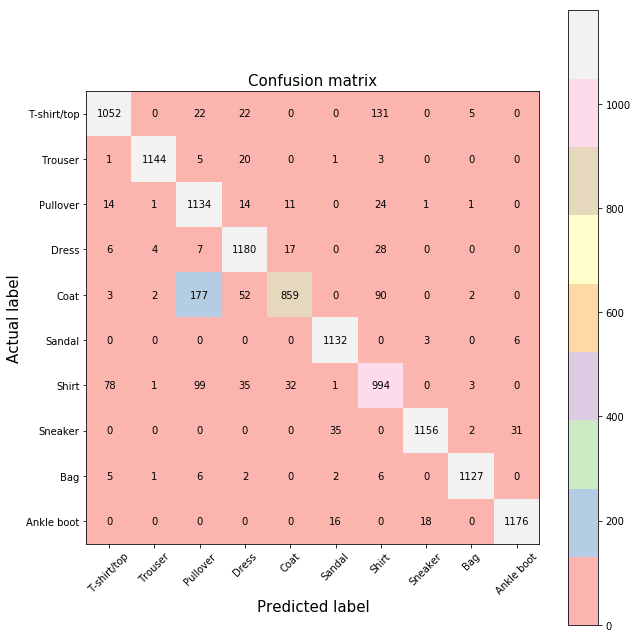

In [45]:
cm = confusion_matrix(y_test, y_pred_series)
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['T-shirt/top', 'Trouser', 'Pullover', 
                        'Dress', 'Coat', 'Sandal', 'Shirt', 
                        'Sneaker', 'Bag', 'Ankle boot'], rotation=45, size = 10)
plt.yticks(tick_marks, ['T-shirt/top', 'Trouser', 'Pullover', 
                        'Dress', 'Coat', 'Sandal', 'Shirt', 
                        'Sneaker', 'Bag', 'Ankle boot'], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

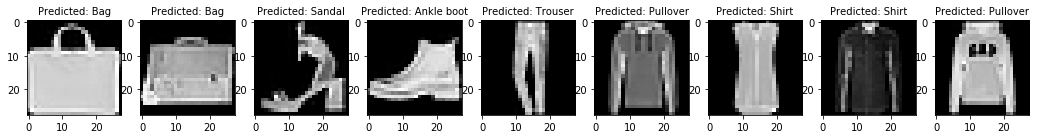

In [46]:
plt.figure(figsize=(20,10))
for index, (image, label) in enumerate(zip(np.array(X_test)[1:10], y_pred_series[1:10])):
    plt.subplot(1, 10, index + 1)
    plt.imshow(np.reshape(np.array(image), (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: ' + str(true_label(label)) , fontsize = 10)

Our model seems very accurate. But it seems that we can definitely improve it by focusing on our errors

In [47]:
y_test.apply(true_label).loc[y_test!=y_pred_series].value_counts()

Coat           326
Shirt          249
T-shirt/top    180
Sneaker         68
Pullover        66
Dress           62
Ankle boot      34
Trouser         30
Bag             22
Sandal           9
Name: label, dtype: int64

As concluded in the first analysis (PCA and tSNE graphs), the class '__Shirst__' is the hardest to predict. We need to focus on this class to improve our model

<a name="42"></a>
### 4.2. Grad CAM

We are going to analyse our neural network with a technic called : GradCAM. The idea is to see where the CNN is looking to classify.
Inspired by : http://www.hackevolve.com/where-cnn-is-looking-grad-cam/

In [48]:
j = 56

x = x_train[j].reshape(1, 28, 28, 1)

preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.layers[-6]

In [49]:
print(model.layers[-6].output_shape)

(None, 12, 12, 64)


In [50]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [51]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [52]:
img = x_train[j].reshape(28, 28, 1)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

predicted label: Shirt VS real label :Shirt


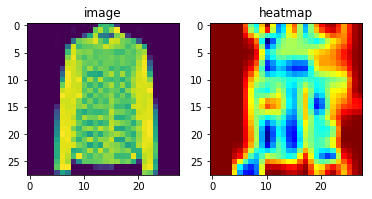

In [53]:
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img.reshape(28,28))
a.set_title('image')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(heatmap)
a.set_title('heatmap')
print('predicted label: '+ true_label(class_idx) + ' VS real label :' + true_label(y_train[j]))